In [1]:
import torch
from torch.autograd import Function, Variable
import torch.nn.functional as F
from torch import nn
from torch.nn.parameter import Parameter
import torch.optim as optim
from torch.nn.utils import parameters_to_vector
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import numpy.random as npr

import matplotlib
from matplotlib import pyplot as plt

from mpc import mpc
from mpc.mpc import GradMethods, QuadCost, LinDx
from mpc import casadi_control
#from mpc.dynamics import NNDynamics
#import mpc.util as eutil
from mpc.env_dx import frenet_dyn_bicycle  #changed
from mpc.track.src import simple_track_generator, track_functions

import time
import os
import shutil
import pickle as pkl
import collections

import argparse

#from tqdm import tqdm



In [2]:
class NN(nn.Module):
    def __init__(self, H):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(H + 3, 512)  
        self.fc2 = nn.Linear(512, 512)  
        self.output1 = nn.Linear(512, 8) 
        self.output2 = nn.Linear(512, 8) 

    def forward(self, c, x0):
        combined = torch.cat((c, x0), dim=1)
        x = F.relu(self.fc1(combined))
        x = F.relu(self.fc2(x))
        q = F.relu(self.output1(x)) + 0.0001
        p = self.output2(x)
        return q, p
    
def penalty_d(d, th, factor=100000):  
    overshoot_pos = (d - th).clamp(min=0)
    overshoot_neg = (-d - th).clamp(min=0)
    penalty_pos = torch.exp(overshoot_pos) - 1
    penalty_neg = torch.exp(overshoot_neg) - 1 
    return factor*(penalty_pos + penalty_neg)

def penalty_v(v, th, factor=100000):  
    penalty_pos = (v - th).clamp(min=0) ** 2
    return factor*penalty_pos

def penalty_ac(self, ac, factor=1000.):  
        penalty = (ac - ac_max).clamp(min=0) ** 2
        return factor*penalty

In [3]:
# Let's try to create a track 

track_density = 300
track_width = 0.5

gen = simple_track_generator.trackGenerator(track_density,track_width)
track_name = 'LONG_TRACK'

t = 0.3
init = [0,0,0]

track_function = {
    'DEMO_TRACK'    : track_functions.demo_track,
    'HARD_TRACK'    : track_functions.hard_track,
    'LONG_TRACK'    : track_functions.long_track,
    'LUCERNE_TRACK' : track_functions.lucerne_track,
    'BERN_TRACK'    : track_functions.bern_track,
    'INFINITY_TRACK': track_functions.infinity_track,
    'SNAIL_TRACK'   : track_functions.snail_track
}.get(track_name, track_functions.demo_track)
    
track_function(gen, t, init)
    
gen.populatePointsAndArcLength()
gen.centerTrack()

track_coord = torch.from_numpy(np.vstack([gen.xCoords, gen.yCoords, gen.arcLength, gen.tangentAngle, gen.curvature]))

In [4]:
device = 'cpu' #to do

mpc_T = 25
n_batch = 32
H_curve = 80

l_r = 0.2
l_f = 0.2

v_max = 2.5
a_max = 3.
delta_max = 1.

ac_max = (0.7*v_max)**2 * delta_max / (l_r+l_f)

dt = 0.04

params = torch.tensor([l_r, l_f, track_width, v_max, ac_max, dt, a_max, delta_max])

In [5]:
true_dx = frenet_dyn_bicycle.FrenetDynBicycleDx(track_coord, params)

u_lower = torch.tensor([-a_max, -delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_upper = torch.tensor([a_max, delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_init= torch.tensor([0.1, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)

n_state = true_dx.n_state
n_ctrl = true_dx.n_ctrl

eps = 1
lqr_iter = 20
grad_method = GradMethods.AUTO_DIFF

#softplus_op = torch.nn.Softplus(10)

10


In [6]:
def sample_xinit(n_batch):
    def uniform(shape, low, high):
        r = high-low
        return torch.rand(shape)*r+low
    sigma = uniform(n_batch, 0.01, 20.)
    d = uniform(n_batch, -track_width*0.4, track_width*0.4)
    phi = uniform(n_batch, -0.4*np.pi, 0.4*np.pi)
    r = uniform(n_batch, -0.05*np.pi, 0.05*np.pi)
    v_x = uniform(n_batch, 0., v_max)
    v_y = uniform(n_batch, 0., 0.05)

    sigma_0 = sigma
    sigma_diff = sigma-sigma_0
    
    d_pen = penalty_d(d, 0.4*track_width)
    v_ub = penalty_v(v_x, v_max)
    
    k = true_dx.curv(sigma)
    #ac = v**2 * 0.01 / (l_r+l_f)
    
    #ac_ub = penalty_v(ac, ac_max)

    xinit = torch.stack((sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub), dim=1)
    return xinit


def get_nearest_index(point_f, ref_path):
    return ((point_f[0] - ref_path[2,:])**2).argmin()
    
def compute_x_coord(point_f, ref_path, nearest_index):
    return ref_path[0,nearest_index] - point_f[1]*torch.sin(ref_path[3,nearest_index])

def compute_y_coord(point_f, ref_path, nearest_index):
    return ref_path[1,nearest_index] + point_f[1]*torch.cos(ref_path[3,nearest_index])

def frenet_to_cartesian(point_f, ref_path):     
    nearest_index = get_nearest_index(point_f, ref_path)
    x = compute_x_coord(point_f, ref_path, nearest_index)
    y = compute_y_coord(point_f, ref_path, nearest_index)
    
    return torch.tensor([x, y])

def get_loss_progress(x_init, dx, _Q, _p, mpc_T=mpc_T):    
        
        pred_x, pred_u, pred_objs = mpc.MPC(
            dx.n_state, dx.n_ctrl, mpc_T,
            u_lower=u_lower, u_upper=u_upper, u_init=u_init,
            lqr_iter=lqr_iter,
            verbose=0,
            exit_unconverged=False,
            detach_unconverged=False,
            linesearch_decay=.8,
            max_linesearch_iter=10,
            grad_method=grad_method,
            eps=eps,
            n_batch=n_batch,
        )(x_init, QuadCost(_Q, _p), dx)
        
        progress_loss = torch.mean(-pred_x[mpc_T-1,:,0] + pred_x[0,:,0])
                    
        return progress_loss
    
    
    
def get_curve_hor_from_x(x, track_coord, mpc_T):
    idx_track_batch = ((x[:,0]-track_coord[[2],:].T)**2).argmin(0)
    idcs_track_batch = idx_track_batch[:, None] + torch.arange(mpc_T)
    curvs = track_coord[4,idcs_track_batch].float()
    return curvs

def cost_to_batch_NN(q, p, n_batch, mpc_T):
    Q_batch = torch.zeros(n_batch, q.shape[1], q.shape[1])
    rows, cols = torch.arange(q.shape[1]), torch.arange(q.shape[1])  
    Q_batch[:, rows, cols] = q 
    Q_batch = Q_batch.unsqueeze(0).repeat(
                mpc_T, 1, 1, 1)    
    p_batch = p.unsqueeze(0).repeat(mpc_T, 1, 1)
    return Q_batch, p_batch

def cost_to_batch(q, p, n_batch, mpc_T):
    Q_batch = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
                mpc_T, n_batch, 1, 1
            )
    p_batch = p.unsqueeze(0).repeat(mpc_T, n_batch, 1)   
    return Q_batch, p_batch

def bound_params(q, p):
    q[:,0] = 0.0001
    q[:,6] = 0.0001
    p[:,0] = -0.0001
    q[:,1] = q[:,1] + 10.0
    q = q.clip(0.00001, 40.)
    p[:,0] = 0.0
    p[:,1] = 0.0
    p[:,2] = 0.0
    p[:,6] = 0.0
    p2 = p.clone()
    p2 = p.clip(-70.)
    p2[:,4] = p[:,4].clip(-70.)
    q2 = q.clone()
    return q2, p2

# -----------------NOT YET ADJUSTED------------------------------------------------------
def inference_params(x_in, track_coord, H_curve, model, q_pen, p_pen, N, mpc_T):
    curvs = get_curve_hor_from_x(x_in, track_coord, H_curve)
    q, p = model(curvs, x_in[:,1:4])
    q = torch.cat((q[:,:6], q_pen, q[:,6:]), dim=1)
    p = torch.cat((p[:,:6], p_pen, p[:,6:]), dim=1)
    q2, p2 = bound_params(q, p) 
    Q_batch, p_batch = cost_to_batch_NN(q2, p2, N, mpc_T)
    return Q_batch, p_batch
# ----------------------------------------------------------------------------------------
# From here onwards I did not adjust much - we can discuss

In [7]:
env_params = true_dx.params
track_coord = track_coord.to(device)
dx = true_dx.__class__(track_coord,env_params)

q_penalty = .0001*torch.ones(3).to(device)
p_penalty = torch.ones(3).to(device)

model = NN(H_curve)
opt = optim.Adam(model.parameters(), lr=8e-4)
q_penalty_batch = q_penalty.unsqueeze(0).repeat(n_batch,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(n_batch,1)

9


In [8]:
for i in range(600):
    
    x_init = sample_xinit(n_batch).to(device)
    
    Q_batch, p_batch = inference_params(
        x_init, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        n_batch, mpc_T)
           
    loss = get_loss_progress(x_init, dx, Q_batch, p_batch)

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    print('Batch:', i , ' Progression with MPC_T=',mpc_T ,': ', -round(loss.item(), 4))

/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/torch/autograd/__init__.py:411: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/torch/_tensor.py:770: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 0  Progression with MPC_T= 25 :  0.8697
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 1  Progression with MPC_T= 25 :  1.4109
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 2  Progression with MPC_T= 25 :  1.4901
Batch: 3  Progression with MPC_T= 25 :  1.3576
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 4  Progression with MPC_T= 25 :  1.3481
[WARNING] pnqp warning: Did

[WARNING] pnqp warning: Did not converge
Batch: 83  Progression with MPC_T= 25 :  1.6857
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 84  Progression with MPC_T= 25 :  1.6176
Batch: 85  Progression with MPC_T= 25 :  1.5
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 86  Progression with MPC_T= 25 :  1.5383
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 87  Progression with MPC_T= 25 :  1.6211
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 88  Progression with MPC_T= 25 :  1.5772
[WARNING] pnqp warning: Did not converge
Batch: 89  Progression with MPC_T= 25 :  1.6022
[WARNING] pnqp warning: Did not converge
Batch: 90  Progression with MPC_T= 25 :  1.6825
[WARNING] pnqp warning: Did not converge
Batch: 91  Progression with MPC_T= 25 :  1.4238
[WARNING] pnqp warning: Did not conver

[WARNING] pnqp warning: Did not converge
Batch: 160  Progression with MPC_T= 25 :  1.4249
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 161  Progression with MPC_T= 25 :  16.3757
[WARNING] pnqp warning: Did not converge
Batch: 162  Progression with MPC_T= 25 :  76.7946
Batch: 163  Progression with MPC_T= 25 :  1.5759
Batch: 164  Progression with MPC_T= 25 :  1.4173
[WARNING] pnqp warning: Did not converge
Batch: 165  Progression with MPC_T= 25 :  1.4406
Batch: 166  Progression with MPC_T= 25 :  1.6995
Batch: 167  Progression with MPC_T= 25 :  1.4039
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 168  Progression with MPC_T= 25 :  1.6615
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 169  Progression with MPC_T= 25 :  1.2911
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 170  Prog

[WARNING] pnqp warning: Did not converge
Batch: 232  Progression with MPC_T= 25 :  1.4419
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 233  Progression with MPC_T= 25 :  18.1132
[WARNING] pnqp warning: Did not converge
Batch: 234  Progression with MPC_T= 25 :  1.4147
Batch: 235  Progression with MPC_T= 25 :  1.5853
Batch: 236  Progression with MPC_T= 25 :  1.4082
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 237  Progression with MPC_T= 25 :  1.6201
[WARNING] pnqp warning: Did not converge
Batch: 238  Progression with MPC_T= 25 :  1.4467
[WARNING] pnqp warning: Did not converge
Batch: 239  Progression with MPC_T= 25 :  1.6881
[WARNING] pnqp warning: Did not converge
Batch: 240  Progression with MPC_T= 25 :  1.4594
[WARNING] pnqp warning: Did not converge
Batch: 241  Progression with MPC_T= 25 :  1.4596
Batch: 242  Progr

Batch: 305  Progression with MPC_T= 25 :  1.5397
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 306  Progression with MPC_T= 25 :  1.5211
Batch: 307  Progression with MPC_T= 25 :  1.6485
[WARNING] pnqp warning: Did not converge
Batch: 308  Progression with MPC_T= 25 :  1.4752
Batch: 309  Progression with MPC_T= 25 :  1.4878
[WARNING] pnqp warning: Did not converge
Batch: 310  Progression with MPC_T= 25 :  1.5606
[WARNING] pnqp warning: Did not converge
Batch: 311  Progression with MPC_T= 25 :  1.408
Batch: 312  Progression with MPC_T= 25 :  1.5652
Batch: 313  Progression with MPC_T= 25 :  1.5116
[WARNING] pnqp warning: Did not converge
Batch: 314  Progression with MPC_T= 25 :  1.5125
[WARNING] pnqp warning: Did not converge
Batch: 315  Progression with MPC_T= 25 :  1.5407
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] p

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 385  Progression with MPC_T= 25 :  1.692
[WARNING] pnqp warning: Did not converge
Batch: 386  Progression with MPC_T= 25 :  1.4512
Batch: 387  Progression with MPC_T= 25 :  1.5923
Batch: 388  Progression with MPC_T= 25 :  1.6104
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 389  Progression with MPC_T= 25 :  1.7038
Batch: 390  Progression with MPC_T= 25 :  1.5318
[WARNING] pnqp warning: Did not converge
Batch: 391  Progression with MPC_T= 25 :  1.2528
Batch: 392  Progression with MPC_T= 25 :  1.559
[WARNING] pnqp warning: Did not converge
Batch: 393  Progression with MPC_T= 25 :  1.4757
Batch: 394  Progression with MPC_T= 25 :  1.3021
[WARNING] pnqp warning: Did not converge
Batch: 395  Progression with MPC_T= 25 :  1.183
[WARNING] pnqp warning: Did not converge
Batch: 396  Progression with MPC_T= 25 :  1.1521
Batch: 397  Progression with MPC_T= 25 :  1.49

Batch: 467  Progression with MPC_T= 25 :  1.5179
[WARNING] pnqp warning: Did not converge
Batch: 468  Progression with MPC_T= 25 :  1.3553
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 469  Progression with MPC_T= 25 :  1.467
[WARNING] pnqp warning: Did not converge
Batch: 470  Progression with MPC_T= 25 :  1.4531
[WARNING] pnqp warning: Did not converge
Batch: 471  Progression with MPC_T= 25 :  1.5271
Batch: 472  Progression with MPC_T= 25 :  1.3971
Batch: 473  Progression with MPC_T= 25 :  1.4881
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 474  Progression with MPC_T= 25 :  1.4327
[WARNING] pnqp warning: Did not converge
Batch: 475  Progression with MPC_T= 25 :  1.5596
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did

Batch: 541  Progression with MPC_T= 25 :  1.5973
Batch: 542  Progression with MPC_T= 25 :  1.5977
Batch: 543  Progression with MPC_T= 25 :  1.4891
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 544  Progression with MPC_T= 25 :  1.5704
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 545  Progression with MPC_T= 25 :  1.4991
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 546  Progression with MPC_T= 25 :  1.4564
[WARNING] pnqp warning: Did not converge
Batch: 547  Progression with MPC_T= 25 :  1.4324
Batch: 548  Progression with MPC_T= 25 :  1.4827
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 549  Progression with MPC_T

In [9]:
N_test = 1
mpc_T_test = mpc_T

In [10]:
#x_init_test = sample_xinit(N_test)

# Below you can put any initial state you want (any that make sense)
sigma = torch.tensor(0.01)

d = torch.tensor(0.0)
d_pen = penalty_d(d, 0.5*track_width*0.75)

r = torch.tensor(0.0)

v_x = torch.tensor(0.01) #make sure this is never 0
v_ub = penalty_v(v_x, v_max*0.95)

v_y = torch.tensor(0.0)  # this can be zero

#ac = true_dx.curv(torch.tensor([sigma])) * v**2
#ac_ub = penalty_ac(ac, torch.tensor(ac_max)*0.95)

sigma_0 = sigma
sigma_diff = sigma-sigma_0

x_init_test = torch.tensor([[sigma, d, -.0, r, v_x, v_y, sigma_0, 
                             sigma_diff, d_pen, v_ub]])

In [11]:
# Added here the bounds of U
u_lower_test = torch.tensor([-a_max, -delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_upper_test = torch.tensor([a_max, delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_init= torch.tensor([0.1, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)

In [12]:
N_sim_total = 300
x_simulated = torch.zeros((N_sim_total,1,9))

x_simulated[0] = x_init_test[0]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    print('It:', i, 'x=', x_sim.detach().numpy().round(3))

    Q_test_batch, p_test_batch = inference_params(
        x_sim, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)

    x_mpc_test, u_mpc_test, objs_mpc_test = mpc.MPC(
                n_state, n_ctrl, mpc_T_test,
                u_lower=u_lower_test, u_upper=u_upper_test, u_init=u_init,
                lqr_iter=30,
                verbose=0,
                exit_unconverged=False,
                detach_unconverged=True,
                linesearch_decay=.8,
                max_linesearch_iter=10,
                grad_method=grad_method,
                eps=.5,
                n_batch=N_test,
            )(x_sim, QuadCost(Q_test_batch, p_test_batch), dx)

    x_simulated[i] = x_mpc_test[1]
    x_simulated[i,0,4] = x_simulated[i,0,0]
    x_simulated[i,0,5] = 0.

It: 1 x= [[ 0.01  0.   -0.    0.01  0.01  0.    0.    0.    0.  ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 2 x= [[0.01  0.    0.    0.117 0.01  0.    0.    0.    0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 3 x= [[ 0.015 -0.    -0.     0.22   0.015  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping throu

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 22 x= [[ 0.683 -0.053 -0.138  1.386  0.683  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All example

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 42 x= [[ 2.372 -0.037 -0.038  2.224  2.372  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 43 x= [[ 2.46  -0.047 -0.071  2.156  2.46   0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 44 x= [[ 2.546 -0.059 -0.102  2.096  2.546  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* 

[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 70 x= [[4.72  0.044 0.254 2.109 4.72  0.    0.    0.    0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 71 x= [[4.799 0.064 0.305 2.164 4.799 0.    0.    0.    0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 72 x= [[4.879 0.061 0.265 2.103 4.879 0.    0.    0.    0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples 

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 104 x= [[ 7.357 -0.014 -0.534  1.942  7.357  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 105 x= [[ 7.432 -0.03  -0.507  1.944  7.432  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 106 x= [[ 7.504 -0.048 -0.519  1.964  7.504  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 127 x= [[8.942 0.073 0.155 2.236 8.942 0.    0.    0.    0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 128 x= [[ 9.046  0.101 -0.027  2.271  9.046  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converg

[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 150 x= [[1.1098e+01 8.0000e-03 1.4300e-01 2.0140e+00 1.1098e+01 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 151 x= [[11.176  0.026  0.163  2.049 11.176  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 152 x= [[11.249 -0.013 -0.112  1.929 11.249  0.     0.     0.     0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* 

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 183 x= [[13.465 -0.073  0.071  1.853 13.465  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 184 x= [[13.549 -0.097  0.116  1.733 13.549  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 185 x= [[13.639 -0.111  0.234  1.853 13.639  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 186 x= [[13.735 -0.089  0.484  1.914 13.735  0.     0.     0.     0.   ]]
[WA

[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 215 x= [[15.862 -0.065  0.099  1.907 15.862  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 216 x= [[15.942 -0.06   0.144  1.92  15.942  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 217 x= [[16.019 -0.088  0.052  2.015 16.019  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 244 x= [[ 1.836600e+01 -6.700000e-02 -8.600000e-02  1.900000e+00  1.836600e+01
   0.000000e+00  0.000000e+00  0.000000e+00  1.872032e+03]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 245 x= [[ 1.8432e+01 -4.2000e-02 -6.0000e-03  1.7800e+00  1.8432e+01  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 246 x= [[18.497 -0.026 -0.029  1.772 18.497  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backprop

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 276 x= [[ 2.061e+01 -1.500e-02 -3.820e-01  1.749e+00  2.061e+01  0.000e+00
   0.000e+00  0.000e+00  0.000e+00]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 277 x= [[20.673 -0.04  -0.537  1.764 20.673  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 278 x= [[20.732 -0.067 -0.622  1.74  20.732  0.     0.     0.     0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 279 x= [[20.79  -0.093 -0.647  1.745 20.79   0.     0.     0.     0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 280 x

In [13]:
u_mpc_test[0]

tensor([[-0.0576,  0.0801]], grad_fn=<SelectBackward0>)

In [14]:
def get_nearest_index(point_f, ref_path):
    return ((point_f[0] - ref_path[2,:])**2).argmin()
    
def compute_x_coord(point_f, ref_path, nearest_index):
    return ref_path[0,nearest_index] - point_f[1]*torch.sin(ref_path[3,nearest_index])

def compute_y_coord(point_f, ref_path, nearest_index):
    return ref_path[1,nearest_index] + point_f[1]*torch.cos(ref_path[3,nearest_index])

def frenet_to_cartesian(point_f, ref_path):     
    nearest_index = get_nearest_index(point_f, ref_path)
    x = compute_x_coord(point_f, ref_path, nearest_index)
    y = compute_y_coord(point_f, ref_path, nearest_index)
    
    return torch.tensor([x, y])

In [15]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

In [16]:
x_plot = np.array(x_list)
y_plot = np.array(y_list)

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


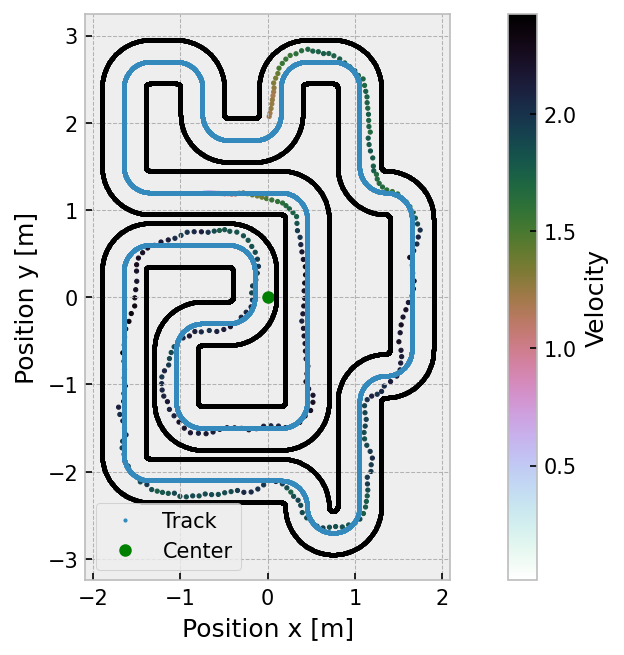

In [17]:
from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,0,3].detach(), cmap=custom_cmap, s=4)

cbar = plt.colorbar(sct)
cbar.set_label('Velocity') 
#ax.plot(x_plot, y_plot)

#ax.scatter(x_plot[23:25], y_plot[23:25], color='red', s=4)

#ax.scatter(x_plot, y_plot, s=4, color='red')

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

In [18]:
curvsp = dx.curv(x_simulated[:250,0,0]).detach()

Text(0, 0.5, '1-d*curve')

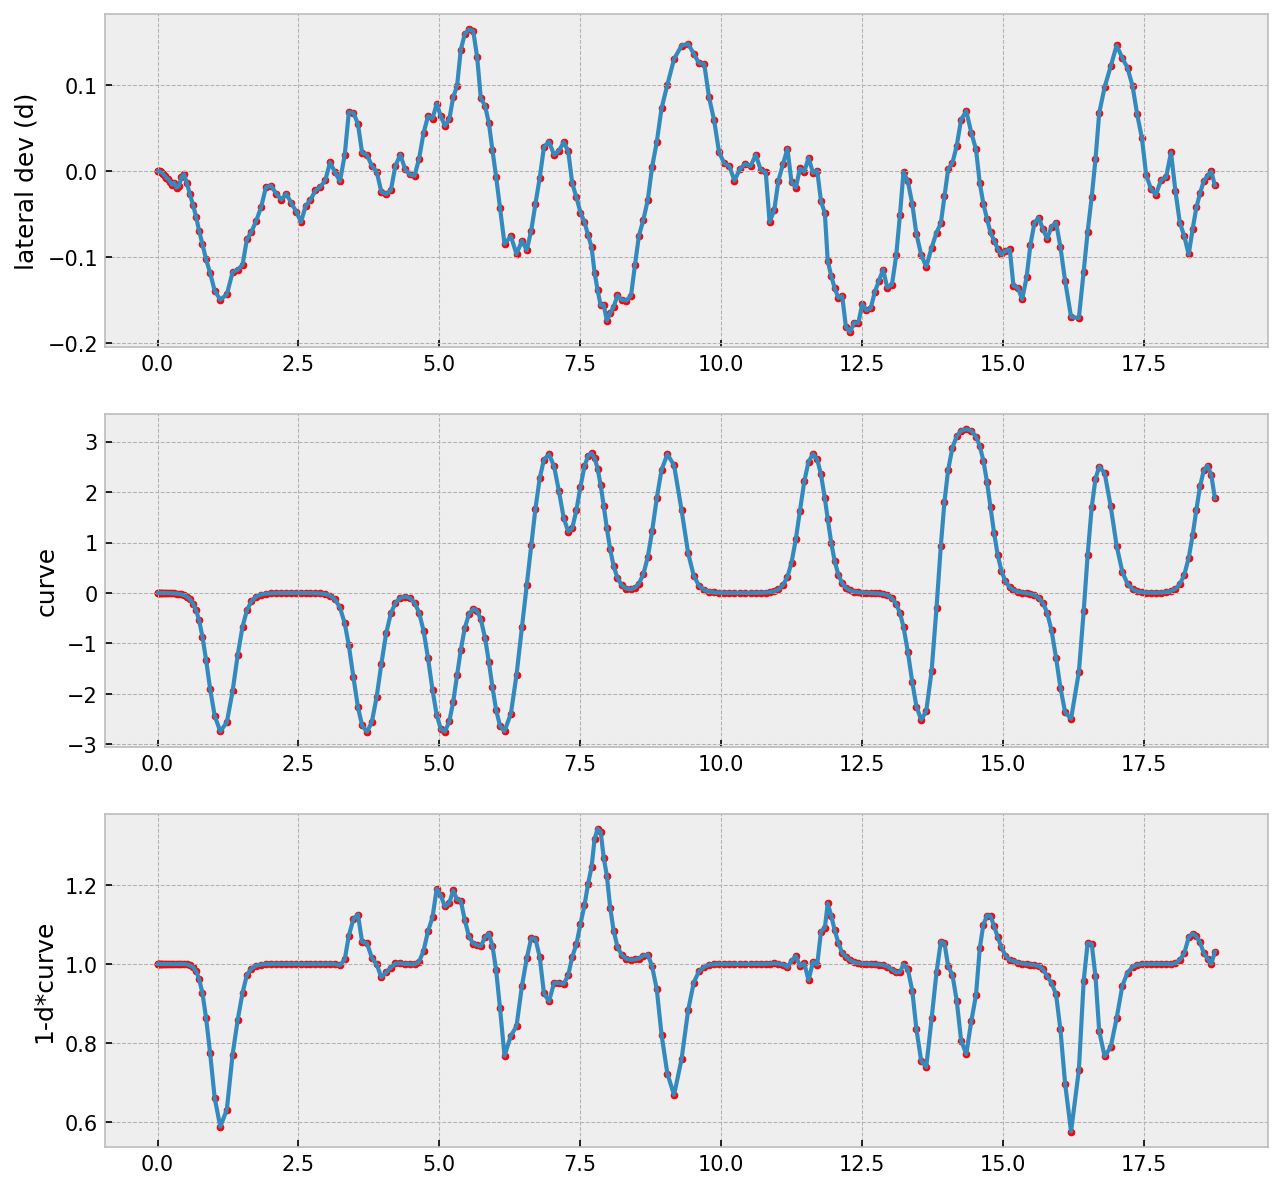

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(10,10), dpi=150)
axs[0].plot(x_simulated[:250,0,0].detach(), 
         x_simulated[:250,0,1].detach())
axs[0].scatter(x_simulated[:250,0,0].detach(), 
         x_simulated[:250,0,1].detach(), s=10, color='red')
axs[0].set_ylabel('lateral dev (d)')

axs[1].plot(x_simulated[:250,0,0].detach(), 
         curvsp)
axs[1].scatter(x_simulated[:250,0,0].detach(), 
         curvsp, s=10, color='red')
axs[1].set_ylabel('curve')

axs[2].plot(x_simulated[:250,0,0].detach(), 
         1 - curvsp*x_simulated[:250,0,1].detach())
axs[2].scatter(x_simulated[:250,0,0].detach(), 
         1 - curvsp*x_simulated[:250,0,1].detach(), s=10, color='red')
axs[2].set_ylabel('1-d*curve')



In [69]:
from mpc import casadi_control
from importlib import reload
reload(casadi_control)

<module 'mpc.casadi_control' from '/home/alan/Desktop/Research/Code/race_application/mpc/casadi_control.py'>

In [62]:
control = casadi_control.CasadiControl(track_coord, params.numpy())

dc = 2 #number constraints
df = 2 #number of states we artificially added like sigma_0, sigma_diff
dx = n_state #number states taken from the dynamics (including penalties and sigma_o/sigma_diff)
du = n_ctrl #number control inputs

N_sim_total = 200
x_simulated = torch.zeros((N_sim_total,1,9))

x_simulated[0] = x_init_test[0]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    print('It:', i, 'x=', x_sim.detach().numpy().round(3))

    Q_test_batch, p_test_batch = inference_params(
        x_sim, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)
    
    test_q = torch.diag(Q_test_batch[0,0]).detach().numpy()
    test_p = p_test_batch[0,0].detach().numpy()

    sol = control.mpc_casadi_with_constraints(
        test_q,test_p,x_sim.detach().numpy(),mpc_T_test,df,dc,dx,du)
    
    u_mpc_test = sol[-du*mpc_T_test:]
    x_mpc_test = sol[:-du*mpc_T_test]
    u_mpc_test = u_mpc_test.reshape(mpc_T_test,du)
    x_mpc_test = x_mpc_test.reshape(mpc_T_test+1,dx-dc-df)

    x_simulated[i,0,:4] = torch.tensor(x_mpc_test[1])
    x_simulated[i,0,4] = torch.tensor(x_simulated[i,0,0])
    x_simulated[i,0,5] = 0.

9
It: 1 x= [[ 0.01  0.   -0.    0.01  0.01  0.    0.    0.    0.  ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr  

/tmp/ipykernel_77055/224992496.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_simulated[i,0,4] = torch.tensor(x_simulated[i,0,0])


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8199982e+01 9.00e-02 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.3888616e+01 3.30e-01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3973461e+02 5.70e-01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2461018e+02 7.30e-01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3135478e+02 8.90e-01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.5971942e+02 1.05e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.0959411e+02 1.21e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.8143913e+02 1.37e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.7722900e+02 1.53e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2026913e+03 1.69e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4723753e+03 1.85e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8153252e+03 2.01e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0212404e+03 2.09e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2396644e+03 2.17e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4570795e+03 2.25e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.6643969e+03 2.33e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0517077e+03 2.49e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4219193e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.7791319e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1320090e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.4838060e+03 2.56e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.6598807e+03 2.66e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.8364207e+03 2.76e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0138540e+03 2.87e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.1928829e+03 2.97e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.3746776e+03 3.07e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.5611827e+03 3.18e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.7555339e+03 3.29e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.9624469e+03 3.41e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

It: 49 x= [[ 3.536 -0.188  0.208  2.5    3.536  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

It: 50 x= [[ 3.677 -0.188  0.324  2.5    3.677  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

It: 51 x= [[ 3.826 -0.188  0.429  2.5    3.826  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

It: 52 x= [[ 3.972 -0.184  0.478  2.5    3.972  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1822242e+03 4.10e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.3928123e+03 4.22e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.5919081e+03 4.34e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.7863292e+03 4.45e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.9807220e+03 4.56e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.1797570e+03 4.67e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

It: 59 x= [[ 4.794 -0.172  0.188  2.5    4.794  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

It: 60 x= [[ 4.922 -0.174  0.248  2.5    4.922  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.8571142e+

It: 62 x= [[ 5.209 -0.188  0.399  2.5    5.209  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

 147 -6.7515823e+03 4.56e-03 7.22e+02  -1.0 7.59e-02    -  1.00e+00 7.75e-01f  1
 148 -6.7519147e+03 1.09e-04 9.58e+03  -1.0 2.56e-02    -  3.19e-01 9.89e-01f  1
 149 -6.7521817e+03 1.30e-05 1.07e+05  -1.0 5.43e-03    -  1.00e+00 9.25e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -6.7521866e+03 1.14e-05 1.34e+08  -1.0 1.90e-03    -  1.00e+00 1.24e-01h  1
 151 -6.7522242e+03 4.03e-07 2.80e-03  -1.0 1.75e-03    -  1.00e+00 1.00e+00f  1
 152 -6.7526487e+03 5.32e-07 1.27e+08  -5.7 3.49e-02    -  9.53e-01 1.17e-01f  1
 153 -6.7553371e+03 3.28e-05 4.57e+06  -5.7 3.07e-02    -  9.64e-01 8.56e-01f  1
 154 -6.7557724e+03 2.00e-06 3.70e+05  -5.7 4.35e-03    -  9.19e-01 9.94e-01f  1
 155 -6.7557768e+03 1.25e-08 3.04e+02  -5.7 2.87e-04    -  9.99e-01 1.00e+00h  1
 156 -6.7557768e+03 1.25e-08 6.86e-09  -5.7 5.93e-06    -  1.00e+00 1.00e+00h  1
In iteration 156, 1 Slack too small, adjusting variable bound
 157 -6.7557769e+03 1.25e-08 2.57e+00  -9.0 6.3

 126 -6.0589144e+03 6.67e-01 2.64e+02  -1.0 7.85e+00    -  2.25e-02 6.02e-03f  1
 127 -6.0597532e+03 6.66e-01 1.28e+03  -1.0 7.82e+00    -  1.11e-02 8.86e-04f  1
 128 -6.0612845e+03 6.64e-01 2.62e+02  -1.0 7.85e+00    -  3.78e-05 3.35e-03f  1
 129 -6.0613273e+03 6.64e-01 2.62e+02  -1.0 7.84e+00    -  1.91e-03 1.21e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -6.0684039e+03 6.44e-01 2.54e+02  -1.0 7.77e+00    -  1.37e-03 2.93e-02f  1
 131 -6.0711094e+03 6.37e-01 2.51e+02  -1.0 7.53e+00    -  1.04e-02 1.12e-02f  1
 132 -6.0978402e+03 5.89e-01 3.12e+02  -1.0 7.45e+00    -  4.30e-03 7.48e-02f  1
 133 -6.0994314e+03 5.87e-01 3.30e+02  -1.0 6.88e+00    -  1.20e-01 3.86e-03f  1
 134 -6.1480629e+03 5.13e-01 2.25e+02  -1.0 6.85e+00    -  9.51e-02 1.27e-01f  1
 135 -6.1489910e+03 5.12e-01 2.25e+02  -1.0 4.54e+00    -  3.18e-03 1.92e-03f  1
 136 -6.2002988e+03 4.55e-01 2.83e+03  -1.0 4.41e+00    -  3.54e-03 1.11e-01f  1
 137 -6.2020328e+03 4.53e-01

It: 65 x= [[ 5.62  -0.175  0.411  2.5    5.62   0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

 133 -6.3669569e+03 3.38e-01 2.15e+02  -1.0 3.91e+00    -  2.94e-02 3.61e-02f  1
 134 -6.3863502e+03 3.22e-01 2.52e+02  -1.0 3.77e+00    -  3.18e-02 4.71e-02f  1
 135 -6.3894608e+03 3.19e-01 2.80e+02  -1.0 3.59e+00    -  7.01e-02 8.18e-03f  1
 136 -6.4409904e+03 2.73e-01 2.31e+02  -1.0 3.56e+00    -  1.07e-02 1.45e-01f  1
 137 -6.4421349e+03 2.72e-01 2.39e+02  -1.0 3.04e+00    -  3.33e-02 3.57e-03f  1
 138 -6.4812137e+03 2.37e-01 2.15e+02  -1.0 3.03e+00    -  1.33e-01 1.29e-01f  1
 139 -6.5137029e+03 2.05e-01 1.28e+02  -1.0 2.64e+00    -  4.02e-02 1.34e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -6.5303971e+03 1.88e-01 1.17e+02  -1.0 2.28e+00    -  6.66e-02 8.23e-02f  1
 141 -6.5403025e+03 1.79e-01 1.11e+02  -1.0 2.08e+00    -  6.18e-02 5.24e-02f  1
 142 -6.5406993e+03 1.78e-01 1.11e+02  -1.0 1.46e+00    -  1.02e-02 2.07e-03h  1
 143 -6.5493042e+03 1.70e-01 1.51e+02  -1.0 2.00e+00    -  2.39e-01 4.64e-02f  1
 144 -6.5786732e+03 1.39e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -6.3158595e+03 3.82e-01 7.65e+02  -1.0 1.40e+01    -  2.41e-03 7.09e-02f  1
 141 -6.3358354e+03 3.65e-01 7.32e+02  -1.0 4.14e+00    -  2.33e-02 4.30e-02f  1
 142 -6.3362836e+03 3.65e-01 7.32e+02  -1.0 1.80e+00    -  9.41e-03 9.90e-04f  1
 143 -6.3727344e+03 3.34e-01 6.70e+02  -1.0 3.97e+00    -  7.93e-03 8.42e-02f  1
 144 -6.3920275e+03 3.18e-01 6.37e+02  -1.0 3.65e+00    -  9.76e-02 4.92e-02f  1
 145 -6.4072579e+03 3.04e-01 6.10e+02  -1.0 3.47e+00    -  3.03e-02 4.21e-02f  1
 146 -6.4208496e+03 2.91e-01 5.84e+02  -1.0 3.32e+00    -  2.91e-02 4.30e-02f  1
 147 -6.4821596e+03 2.30e-01 5.33e+02  -1.0 3.18e+00    -  6.75e-02 2.12e-01f  1
 148 -6.5054160e+03 2.15e-01 5.16e+02  -1.0 2.50e+00    -  8.62e-03 6.43e-02f  1
 149 -6.5237517e+03 1.99e-01 5.38e+02  -1.0 2.34e+00    -  1.32e-01 7.28e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -6.5361355e+03 1.88e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0499100e+04 6.00e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 123 -6.3098767e+03 4.05e-01 8.01e+02  -1.0 4.23e+00    -  2.08e-01 5.96e-03f  1
 124 -6.3396278e+03 3.82e-01 6.78e+02  -1.0 4.11e+00    -  2.91e-03 5.75e-02f  1
 125 -6.3411066e+03 3.80e-01 6.70e+02  -1.0 2.72e+00    -  6.80e-03 3.16e-03f  1
 126 -6.3758499e+03 3.52e-01 7.07e+02  -1.0 3.97e+00    -  1.97e-02 7.57e-02f  1
 127 -6.3996746e+03 3.32e-01 6.88e+02  -1.0 3.67e+00    -  4.21e-02 5.49e-02f  1
 128 -6.4372186e+03 3.02e-01 4.71e+02  -1.0 3.47e+00    -  2.57e-01 9.09e-02f  1
 129 -6.4683571e+03 2.78e-01 4.33e+02  -1.0 3.15e+00    -  1.80e-01 8.04e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -6.4878973e+03 2.62e-01 4.11e+02  -1.0 2.90e+00    -  8.62e-02 5.56e-02f  1
 131 -6.5509423e+03 2.09e-01 4.56e+02  -1.0 2.74e+00    -  2.53e-02 2.05e-01f  1
 132 -6.5728631e+03 1.91e-01 2.96e+02  -1.0 2.17e+00    -  2.41e-01 8.55e-02f  1
 133 -6.5737407e+03 1.90e-01 2.95e+02  -1.0 1.50e+00    -  1.00e-02 3.80e-03f  1
 134 -6.5982711e+03 1.69e-01

 139 -6.7566324e+03 6.40e-07 2.07e-03  -1.0 1.66e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -6.7597659e+03 2.59e-05 1.29e+04  -3.8 3.41e-02    -  9.07e-01 9.64e-01f  1
 141 -6.7599398e+03 7.35e-06 1.50e-02  -3.8 6.76e-03    -  1.00e+00 1.00e+00f  1
 142 -6.7599467e+03 1.09e-06 6.61e-01  -3.8 2.57e-03    -  1.00e+00 9.51e-01h  1
 143 -6.7599465e+03 1.03e-07 1.04e-04  -3.8 1.09e-03    -  1.00e+00 1.00e+00f  1
 144 -6.7599514e+03 1.29e-08 9.86e+01  -5.7 3.49e-04    -  1.00e+00 9.83e-01f  1
 145 -6.7599515e+03 9.50e-11 9.68e-08  -5.7 3.30e-05    -  1.00e+00 1.00e+00f  1
 146 -6.7599515e+03 7.71e-13 9.05e-10  -8.6 2.82e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 146

                                   (scaled)                 (unscaled)
Objective...............:  -6.7599515241956624e+03   -6.7599515241956624e+03
Dual infeasibility......:   9.0450980039236129e-10    9.0450980039236129e-10
Constraint vio

 143 -6.3660502e+03 2.72e-01 3.28e+02  -1.0 3.34e+00    -  1.83e-03 1.85e-01f  1
 144 -6.3668925e+03 2.72e-01 4.59e+02  -1.0 2.72e+00    -  1.48e-01 2.30e-03f  1
 145 -6.3936228e+03 2.50e-01 5.62e+02  -1.0 2.71e+00    -  1.10e-01 8.02e-02f  1
 146 -6.4441784e+03 2.07e-01 2.48e+02  -1.0 2.49e+00    -  9.26e-02 1.73e-01f  1
 147 -6.4526421e+03 1.99e-01 4.44e+02  -1.0 2.02e+00    -  1.21e-01 3.59e-02f  1
 148 -6.4544704e+03 1.98e-01 4.39e+02  -1.0 1.90e+00    -  6.91e-03 8.16e-03f  1
 149 -6.4640866e+03 1.89e-01 4.26e+02  -1.0 1.99e+00    -  1.68e-02 4.30e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -6.4917668e+03 1.64e-01 3.69e+02  -1.0 1.90e+00    -  1.23e-01 1.33e-01f  1
 151 -6.4986426e+03 1.58e-01 8.17e+02  -1.0 1.65e+00    -  3.74e-01 3.69e-02f  1
 152 -6.5902582e+03 6.99e-02 4.33e+02  -1.0 1.59e+00    -  1.20e-01 5.58e-01f  1
 153 -6.6567462e+03 8.43e-03 5.29e+02  -1.0 7.02e-01    -  5.26e-01 9.90e-01f  1
 154 -6.6593938e+03 3.45e-03

 119 -6.3221382e+03 2.49e-01 6.13e+02  -1.0 2.45e+00    -  8.42e-02 5.83e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.3552441e+03 2.22e-01 1.11e+03  -1.0 2.43e+00    -  2.78e-01 1.07e-01f  1
 121 -6.3777015e+03 2.03e-01 1.06e+03  -1.0 2.15e+00    -  1.03e-01 8.56e-02f  1
 122 -6.3788520e+03 2.02e-01 1.07e+03  -1.0 1.62e+00    -  1.23e-02 5.00e-03f  1
 123 -6.4729361e+03 1.13e-01 4.86e+02  -1.0 1.99e+00    -  1.28e-02 4.41e-01f  1
 124 -6.4856284e+03 1.04e-01 4.46e+02  -1.0 1.11e+00    -  9.30e-02 7.84e-02f  1
 125 -6.4961659e+03 9.49e-02 1.85e+03  -1.0 1.03e+00    -  9.44e-01 8.87e-02f  1
 126 -6.5938813e+03 1.68e-02 8.88e+01  -1.0 9.34e-01    -  6.23e-01 9.90e-01f  1
 127 -6.6007813e+03 1.24e-03 1.62e+01  -1.0 5.16e-02    -  1.00e+00 9.40e-01f  1
 128 -6.6010616e+03 1.58e-05 3.99e+01  -1.0 6.89e-03    -  1.00e+00 9.91e-01f  1
 129 -6.6010720e+03 2.14e-07 7.54e-04  -1.0 1.17e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

It: 73 x= [[ 6.589 -0.037  0.568  2.5    6.589  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1682374e+04 6.68e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

It: 75 x= [[6.765 0.058 0.418 2.5   6.765 0.    0.    0.    0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   

It: 76 x= [[6.864 0.099 0.294 2.5   6.864 0.    0.    0.    0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   

 117 -6.2754960e+03 3.58e-01 1.04e+03  -1.0 3.66e+00    -  3.64e-02 1.04e-01f  1
 118 -6.3391208e+03 3.16e-01 7.68e+02  -1.0 3.28e+00    -  4.18e-03 1.18e-01f  1
 119 -6.3778550e+03 2.92e-01 7.30e+02  -1.0 2.90e+00    -  2.85e-01 7.54e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.4101865e+03 2.73e-01 9.85e+02  -1.0 2.67e+00    -  2.06e-01 6.62e-02f  1
 121 -6.4743770e+03 2.33e-01 1.71e+03  -1.0 2.48e+00    -  3.80e-01 1.46e-01f  1
 122 -6.5003336e+03 2.16e-01 1.48e+03  -1.0 1.99e+00    -  7.67e-03 7.26e-02f  1
 123 -6.5047441e+03 2.13e-01 1.46e+03  -1.0 1.86e+00    -  1.82e-02 1.37e-02f  1
 124 -6.6627793e+03 1.04e-01 7.16e+02  -1.0 1.96e+00    -  4.43e-01 5.13e-01f  1
 125 -6.7056335e+03 7.84e-02 4.64e+02  -1.0 9.53e-01    -  5.40e-01 2.45e-01f  1
 126 -6.7860833e+03 2.94e-02 2.69e+02  -1.0 7.20e-01    -  2.95e-01 6.25e-01f  1
 127 -6.8036339e+03 1.82e-02 2.48e+02  -1.0 2.70e-01    -  2.80e-01 3.82e-01f  1
 128 -6.8325012e+03 2.47e-03

 122 -6.6874718e+03 9.60e-02 3.67e+02  -1.0 1.19e+00    -  1.60e-01 2.73e-01f  1
 123 -6.7447898e+03 6.02e-02 4.20e+02  -1.0 8.67e-01    -  9.78e-02 3.73e-01f  1
 124 -6.7816879e+03 3.82e-02 2.39e+02  -1.0 5.43e-01    -  6.00e-01 3.66e-01f  1
 125 -6.8374022e+03 1.09e-02 3.46e+02  -1.0 3.45e-01    -  3.50e-01 9.90e-01f  1
 126 -6.8411251e+03 6.90e-03 1.07e+02  -1.0 2.16e-01    -  8.44e-01 9.90e-01f  1
 127 -6.8411675e+03 2.60e-04 5.25e-02  -1.0 5.00e-02    -  1.00e+00 1.00e+00h  1
 128 -6.8442657e+03 5.78e-05 1.28e+03  -2.5 3.33e-02    -  8.92e-01 8.60e-01f  1
 129 -6.8447969e+03 8.21e-06 6.33e-03  -2.5 7.23e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -6.8449098e+03 2.10e-06 7.78e+02  -5.7 3.64e-03    -  9.82e-01 9.89e-01f  1
 131 -6.8449128e+03 2.23e-07 1.37e-04  -5.7 1.20e-03    -  1.00e+00 1.00e+00f  1
 132 -6.8449130e+03 5.22e-09 3.34e-06  -5.7 1.84e-04    -  1.00e+00 1.00e+00h  1
 133 -6.8449131e+03 6.09e-12

 123 -5.3361877e+03 9.39e-01 1.40e+03  -1.0 7.97e+00    -  3.21e-03 8.20e-03f  1
 124 -5.3382481e+03 9.38e-01 1.68e+03  -1.0 7.91e+00    -  8.04e-02 1.19e-03f  1
 125 -5.3424092e+03 9.36e-01 1.63e+03  -1.0 6.34e+00    -  5.89e-04 2.57e-03f  1
 126 -5.3721437e+03 9.22e-01 1.59e+03  -1.0 6.08e+00    -  5.88e-03 1.53e-02f  1
 127 -5.3731641e+03 9.21e-01 1.37e+03  -1.0 4.77e+00    -  1.16e-02 5.63e-04f  1
 128 -5.3903913e+03 9.12e-01 1.36e+03  -1.0 8.14e+00    -  4.27e-02 1.02e-02f  1
 129 -5.4747666e+03 8.61e-01 1.74e+03  -1.0 7.86e+00    -  5.02e-04 5.57e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -5.5094536e+03 8.43e-01 1.71e+03  -1.0 6.91e+00    -  4.27e-03 2.06e-02f  1
 131 -5.5106241e+03 8.43e-01 1.71e+03  -1.0 7.07e+00    -  1.19e-01 6.84e-04f  1
 132 -5.5184125e+03 8.39e-01 1.72e+03  -1.0 7.24e+00    -  1.44e-02 4.85e-03f  1
 133 -5.5319287e+03 8.32e-01 1.68e+03  -1.0 6.64e+01    -  7.43e-05 7.37e-03f  1
 134 -5.5988776e+03 7.94e-01

 118 -5.0509735e+03 1.15e+00 8.18e+02  -1.0 8.70e+00    -  7.73e-03 2.26e-02f  1
 119 -5.0987021e+03 1.13e+00 7.17e+02  -1.0 7.25e+00    -  1.46e-04 1.90e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -5.1002838e+03 1.13e+00 1.05e+03  -1.0 7.85e+00    -  6.27e-02 6.90e-04f  1
 121 -5.1428485e+03 1.10e+00 7.20e+02  -1.0 1.74e+01    -  2.21e-04 1.86e-02f  1
 122 -5.1561403e+03 1.10e+00 1.04e+03  -1.0 8.56e+00    -  2.26e-02 6.64e-03f  1
 123 -5.2332032e+03 1.05e+00 6.72e+02  -1.0 8.28e+00    -  2.77e-04 3.84e-02f  1
 124 -5.2526419e+03 1.05e+00 6.68e+02  -1.0 7.51e+00    -  9.68e-03 5.90e-03f  1
 125 -5.2548733e+03 1.05e+00 1.64e+03  -1.0 8.07e+00    -  8.91e-02 1.08e-03f  1
 126 -5.3225448e+03 1.01e+00 8.69e+02  -1.0 8.26e+00    -  7.99e-04 3.65e-02f  1
 127 -5.3505651e+03 9.98e-01 8.60e+02  -1.0 7.12e+00    -  9.36e-03 1.14e-02f  1
 128 -5.3533652e+03 9.96e-01 1.81e+03  -1.0 7.65e+00    -  8.70e-02 1.46e-03f  1
 129 -5.4183693e+03 9.59e-01

 121 -5.2983704e+03 1.03e+00 2.36e+03  -1.0 8.35e+00    -  7.27e-02 4.92e-04f  1
 122 -5.3543290e+03 1.00e+00 1.37e+03  -1.0 8.06e+00    -  7.42e-04 3.29e-02f  1
 123 -5.3997551e+03 9.67e-01 1.38e+03  -1.0 7.03e+00    -  9.56e-03 3.25e-02f  1
 124 -5.4041831e+03 9.65e-01 1.23e+03  -1.0 5.60e+00    -  3.07e-02 2.63e-03f  1
 125 -5.4492443e+03 9.37e-01 1.22e+03  -1.0 7.97e+00    -  4.53e-02 2.89e-02f  1
 126 -5.4544296e+03 9.33e-01 1.19e+03  -1.0 7.66e+00    -  1.44e-03 3.63e-03f  1
 127 -5.5030085e+03 8.92e-01 1.13e+03  -1.0 7.38e+00    -  6.07e-04 4.44e-02f  1
 128 -5.5040926e+03 8.91e-01 1.55e+03  -1.0 7.13e+00    -  1.25e-01 7.65e-04f  1
 129 -5.5421342e+03 8.68e-01 1.43e+03  -1.0 7.29e+00    -  2.40e-02 2.63e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -5.5510326e+03 8.61e-01 1.14e+03  -1.0 7.20e+00    -  2.28e-04 7.64e-03f  1
 131 -5.6051669e+03 8.12e-01 1.09e+03  -1.0 6.87e+00    -  3.78e-02 5.74e-02f  1
 132 -5.6066482e+03 8.11e-01

 128 -4.9043011e+03 1.28e+00 1.97e+03  -1.0 1.00e+01    -  2.85e-04 3.63e-02f  1
 129 -4.9361738e+03 1.27e+00 1.96e+03  -1.0 9.47e+00    -  7.94e-03 8.17e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -4.9377343e+03 1.27e+00 1.96e+03  -1.0 9.65e+00    -  3.37e-02 6.11e-04f  1
 131 -4.9697038e+03 1.25e+00 1.93e+03  -1.0 9.54e+00    -  2.84e-04 1.43e-02f  1
 132 -5.0024449e+03 1.24e+00 1.91e+03  -1.0 9.17e+00    -  9.18e-03 1.07e-02f  1
 133 -5.0044765e+03 1.24e+00 1.91e+03  -1.0 8.79e+00    -  2.25e-02 8.68e-04f  1
 134 -5.0579998e+03 1.20e+00 1.86e+03  -1.0 7.85e+00    -  2.12e-04 2.55e-02f  1
 135 -5.0888556e+03 1.19e+00 1.83e+03  -1.0 5.20e+00    -  1.20e-02 1.25e-02f  1
 136 -5.0911349e+03 1.19e+00 1.83e+03  -1.0 7.59e+00    -  9.33e-03 1.03e-03f  1
 137 -5.1051643e+03 1.18e+00 1.83e+03  -1.0 8.64e+00    -  1.82e-02 6.39e-03f  1
 138 -5.1533444e+03 1.15e+00 1.78e+03  -1.0 9.68e+00    -  1.81e-04 2.45e-02f  1
 139 -5.1916350e+03 1.13e+00

 135 -4.7813379e+03 1.36e+00 2.47e+03  -1.0 1.01e+01    -  2.11e-02 4.24e-03f  1
 136 -4.8022086e+03 1.35e+00 2.44e+03  -1.0 1.01e+01    -  1.70e-04 9.88e-03f  1
 137 -4.8443317e+03 1.33e+00 2.42e+03  -1.0 9.52e+00    -  5.61e-03 1.04e-02f  1
 138 -4.8458552e+03 1.33e+00 2.41e+03  -1.0 9.71e+00    -  1.53e-02 6.20e-04f  1
 139 -4.8781191e+03 1.31e+00 2.38e+03  -1.0 9.79e+00    -  3.26e-02 1.61e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -4.8849617e+03 1.31e+00 2.37e+03  -1.0 1.01e+01    -  2.48e-04 3.52e-03f  1
 141 -4.9312078e+03 1.29e+00 2.33e+03  -1.0 9.30e+00    -  9.17e-03 1.48e-02f  1
 142 -4.9322859e+03 1.29e+00 2.33e+03  -1.0 9.42e+00    -  4.01e-02 4.24e-04f  1
 143 -4.9697867e+03 1.26e+00 2.29e+03  -1.0 9.08e+00    -  8.47e-03 1.92e-02f  1
 144 -4.9793663e+03 1.26e+00 2.28e+03  -1.0 7.70e+00    -  1.13e-04 4.56e-03f  1
 145 -5.0284145e+03 1.23e+00 2.23e+03  -1.0 7.47e+00    -  1.63e-02 1.99e-02f  1
 146 -5.0298107e+03 1.23e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3740570e+04 7.85e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 122 -4.3329525e+03 1.64e+00 7.99e+02  -1.0 1.25e+01    -  4.68e-04 3.21e-03f  1
 123 -4.3824560e+03 1.62e+00 7.88e+02  -1.0 1.25e+01    -  3.86e-03 1.38e-02f  1
 124 -4.3837135e+03 1.62e+00 7.88e+02  -1.0 1.22e+01    -  1.68e-03 3.72e-04f  1
 125 -4.3991905e+03 1.61e+00 7.84e+02  -1.0 1.25e+01    -  2.09e-04 4.34e-03f  1
 126 -4.4002447e+03 1.61e+00 7.84e+02  -1.0 1.22e+01    -  5.61e-03 3.28e-04f  1
 127 -4.4377867e+03 1.59e+00 7.75e+02  -1.0 1.22e+01    -  2.33e-02 1.22e-02f  1
 128 -4.4527250e+03 1.58e+00 7.71e+02  -1.0 1.22e+01    -  3.24e-04 5.03e-03f  1
 129 -4.4626300e+03 1.58e+00 7.68e+02  -1.0 1.23e+01    -  1.89e-03 3.79e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -4.4790119e+03 1.57e+00 7.63e+02  -1.0 1.24e+01    -  4.03e-03 6.59e-03f  1
 131 -4.4795686e+03 1.57e+00 7.63e+02  -1.0 1.19e+01    -  2.61e-02 1.90e-04f  1
 132 -4.5037654e+03 1.55e+00 7.56e+02  -1.0 1.13e+01    -  3.42e-03 8.11e-03f  1
 133 -4.5561491e+03 1.52e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3982604e+04 7.99e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -5.6097901e+03 5.32e-01 4.92e+02  -1.0 4.40e+00    -  6.88e-02 5.76e-02f  1
 121 -5.6598117e+03 5.06e-01 4.68e+02  -1.0 4.02e+00    -  4.33e-02 4.92e-02f  1
 122 -5.6676040e+03 5.02e-01 4.64e+02  -1.0 3.23e+00    -  9.51e-03 8.07e-03f  1
 123 -5.7300968e+03 4.69e-01 4.33e+02  -1.0 3.95e+00    -  1.11e-01 6.51e-02f  1
 124 -5.7822488e+03 4.42e-01 4.09e+02  -1.0 3.69e+00    -  3.15e-02 5.75e-02f  1
 125 -5.8133807e+03 4.26e-01 3.94e+02  -1.0 3.48e+00    -  3.06e-02 3.62e-02f  1
 126 -5.8980661e+03 3.82e-01 3.55e+02  -1.0 3.35e+00    -  2.37e-02 1.03e-01f  1
 127 -5.9026898e+03 3.80e-01 3.52e+02  -1.0 3.00e+00    -  3.81e-02 6.06e-03f  1
 128 -6.0034473e+03 3.28e-01 3.12e+02  -1.0 2.99e+00    -  1.55e-02 1.37e-01f  1
 129 -6.0060785e+03 3.27e-01 3.11e+02  -1.0 2.57e+00    -  8.49e-02 3.93e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -6.0936224e+03 2.82e-01

 144r-3.9485581e+03 1.61e+00 7.28e+02   0.2 5.21e+01    -  4.32e-02 3.57e-02f  1
 145r-3.8959612e+03 1.60e+00 6.49e+02   0.2 3.64e+00    -  5.94e-02 2.18e-01f  1
 146r-3.8201540e+03 1.60e+00 5.80e+02   0.2 3.73e+01    -  1.04e-01 3.10e-02f  1
 147r-3.7120140e+03 1.59e+00 5.31e+02   0.2 2.65e+01    -  1.15e-01 6.05e-02f  1
 148r-3.4913144e+03 1.35e+00 8.13e+02   0.2 1.61e+00    -  3.06e-02 4.17e-01f  1
 149r-3.4937654e+03 1.35e+00 7.85e+02   0.2 2.12e-01   4.0 1.46e-01 1.12e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150r-3.5120075e+03 1.33e+00 4.69e+02   0.2 1.87e-01   3.5 2.21e-01 3.27e-01h  1
 151 -3.5275863e+03 1.33e+00 7.00e+01  -1.0 1.47e+01    -  1.21e-02 7.04e-04f  1
 152 -3.5969326e+03 1.31e+00 6.94e+01  -1.0 9.57e+00    -  3.28e-02 1.11e-02f  1
 153 -3.6606517e+03 1.28e+00 2.90e+02  -1.0 5.55e+00    -  1.49e-01 2.10e-02f  1
 154 -3.6905343e+03 1.27e+00 6.82e+02  -1.0 3.89e+00    -  2.88e-01 1.41e-02f  1
 155 -3.6924032e+03 1.27e+00

 273 -6.5872550e+03 2.50e-03 5.53e+03  -1.0 1.60e-01    -  3.45e-01 9.92e-01f  1
 274 -6.5891807e+03 1.47e-03 3.59e+05  -1.0 8.67e-02    -  1.00e+00 5.78e-01f  1
 275 -6.5890346e+03 1.25e-05 7.83e-03  -1.0 1.10e-02    -  1.00e+00 1.00e+00h  1
 276 -6.5922023e+03 9.39e-05 2.44e+04  -5.7 3.42e-02    -  9.58e-01 9.46e-01f  1
 277 -6.5924057e+03 1.98e-05 6.22e+02  -5.7 1.09e-02    -  9.92e-01 9.99e-01f  1
 278 -6.5924091e+03 1.67e-06 8.55e+00  -5.7 1.43e-03    -  1.00e+00 9.31e-01f  1
 279 -6.5924091e+03 9.90e-11 6.96e-08  -5.7 2.97e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -6.5924092e+03 1.58e-13 8.51e-11  -8.6 9.65e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 280

                                   (scaled)                 (unscaled)
Objective...............:  -6.5924091865418104e+03   -6.5924091865418104e+03
Dual infeasibility......:   8.5115914316702401e-11    8.5115914316702401e-11
Constraint vio

 119 -4.4507986e+03 1.61e+00 1.21e+03  -1.0 6.76e+00    -  8.45e-06 9.90e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.4377249e+03 1.60e+00 1.20e+03  -1.0 7.91e+00    -  8.17e-04 1.09e-02h  1
 121 -4.4374969e+03 1.60e+00 1.20e+03  -1.0 1.02e+01    -  1.43e-02 2.87e-04h  1
 122 -4.4250866e+03 1.57e+00 1.18e+03  -1.0 1.20e+01    -  8.13e-03 1.73e-02h  1
 123 -4.3828334e+03 1.45e+00 1.09e+03  -1.0 1.18e+01    -  1.19e-03 7.30e-02h  1
 124 -4.4703395e+03 1.31e+00 9.81e+02  -1.0 1.07e+01    -  1.29e-01 9.96e-02f  1
 125 -4.4738373e+03 1.31e+00 9.79e+02  -1.0 4.80e+00    -  6.89e-03 1.86e-03f  1
 126 -4.8159210e+03 1.05e+00 7.86e+02  -1.0 9.92e+00    -  5.02e-03 1.97e-01f  1
 127 -4.8214121e+03 1.05e+00 7.84e+02  -1.0 7.49e+00    -  4.97e-02 2.61e-03f  1
 128 -4.8798034e+03 1.02e+00 7.62e+02  -1.0 7.94e+00    -  3.34e-03 2.81e-02f  1
 129 -4.8826635e+03 1.02e+00 7.82e+02  -1.0 7.75e+00    -  2.74e-02 1.49e-03f  1
iter    objective    inf_pr 

 126 -3.6809493e+03 2.06e+00 1.50e+04  -1.0 5.87e+00   2.9 2.38e-03 7.32e-03f  1
 127 -3.7262739e+03 2.02e+00 1.48e+04  -1.0 5.17e+00   2.5 4.06e-03 1.77e-02f  1
 128 -3.7304233e+03 2.02e+00 1.47e+04  -1.0 1.88e+01   2.0 2.12e-02 3.08e-03f  1
 129 -3.7741824e+03 1.98e+00 1.44e+04  -1.0 6.21e+00   2.4 1.70e-03 1.91e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -3.7817172e+03 1.97e+00 1.44e+04  -1.0 4.50e+00   2.8 3.15e-03 3.28e-03f  1
 131 -3.7910035e+03 1.96e+00 1.43e+04  -1.0 5.57e+00   2.4 3.19e-03 5.10e-03f  1
 132 -3.7917412e+03 1.96e+00 1.43e+04  -1.0 5.96e+00   2.8 1.47e-02 3.31e-04f  1
 133 -3.8136376e+03 1.94e+00 1.41e+04  -1.0 8.08e+00   2.3 5.32e-04 1.26e-02f  1
 134 -3.8375493e+03 1.91e+00 1.40e+04  -1.0 5.92e+00   2.7 2.74e-03 1.27e-02f  1
 135 -3.8394526e+03 1.91e+00 1.39e+04  -1.0 1.09e+01   2.2 1.31e-03 1.61e-03f  1
 136 -3.8616902e+03 1.88e+00 1.37e+04  -1.0 7.13e+00   2.7 1.08e-03 1.81e-02f  1
 137 -3.8688599e+03 1.86e+00

It: 88 x= [[ 8.433  0.088 -0.287  2.5    8.433  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

 146 -5.5801528e+03 8.06e-01 8.91e+02  -1.0 6.15e+00    -  8.01e-02 3.56e-02f  1
 147 -5.5824332e+03 8.05e-01 8.89e+02  -1.0 3.76e+00    -  3.57e-03 1.92e-03f  1
 148 -5.6035170e+03 7.91e-01 8.73e+02  -1.0 5.96e+00    -  7.03e-03 1.79e-02f  1
 149 -5.6065576e+03 7.88e-01 8.71e+02  -1.0 5.86e+00    -  1.69e-02 2.66e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -5.6446333e+03 7.61e-01 8.41e+02  -1.0 5.85e+00    -  2.21e-03 3.43e-02f  1
 151 -5.7302187e+03 7.02e-01 7.77e+02  -1.0 5.65e+00    -  1.27e-01 7.75e-02f  1
 152 -5.7400597e+03 6.96e-01 7.70e+02  -1.0 5.21e+00    -  2.86e-02 9.55e-03f  1
 153 -5.8022875e+03 6.51e-01 7.34e+02  -1.0 5.16e+00    -  1.96e-02 6.35e-02f  1
 154 -5.8244995e+03 6.36e-01 7.30e+02  -1.0 4.83e+00    -  1.11e-01 2.38e-02f  1
 155 -5.9419577e+03 5.51e-01 6.33e+02  -1.0 4.71e+00    -  4.72e-02 1.34e-01f  1
 156 -5.9439780e+03 5.49e-01 6.32e+02  -1.0 4.03e+00    -  3.46e-02 2.60e-03f  1
 157 -5.9612428e+03 5.37e-01

 121 -3.8117645e+03 2.07e+00 1.08e+03  -1.0 1.44e+01    -  2.56e-02 1.77e-02f  1
 122 -3.8177194e+03 2.07e+00 8.32e+02  -1.0 1.46e+01    -  2.34e-02 1.61e-03f  1
 123 -3.9216396e+03 2.01e+00 1.14e+03  -1.0 1.44e+01    -  2.69e-04 2.89e-02f  1
 124 -3.9378210e+03 2.00e+00 1.14e+03  -1.0 1.30e+01    -  2.57e-02 3.80e-03f  1
 125 -4.0018938e+03 1.97e+00 1.12e+03  -1.0 1.23e+01    -  1.07e-02 1.51e-02f  1
 126 -4.0096856e+03 1.96e+00 1.12e+03  -1.0 1.48e+01    -  6.30e-03 1.99e-03f  1
 127 -4.0536855e+03 1.94e+00 1.10e+03  -1.0 2.29e+01    -  3.59e-02 1.19e-02f  1
 128 -4.0566779e+03 1.94e+00 1.10e+03  -1.0 1.17e+01    -  1.77e-02 8.56e-04f  1
 129 -4.1019158e+03 1.91e+00 1.75e+03  -1.0 1.29e+01    -  7.46e-02 1.35e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -4.1573959e+03 1.88e+00 1.83e+03  -1.0 1.33e+01    -  2.18e-02 1.76e-02f  1
 131 -4.1589177e+03 1.88e+00 1.81e+03  -1.0 1.66e+01    -  5.77e-05 4.52e-04f  1
 132 -4.1834536e+03 1.87e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5123395e+04 8.64e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 126 -5.5527470e+03 8.27e-01 8.54e+02  -1.0 7.91e+00    -  8.72e-03 2.45e-01f  1
 127 -5.5567102e+03 8.24e-01 8.72e+02  -1.0 5.66e+00    -  5.42e-02 3.43e-03f  1
 128 -5.7058399e+03 7.12e-01 1.24e+03  -1.0 5.14e+00    -  4.08e-03 1.37e-01f  1
 129 -5.9462981e+03 5.40e-01 9.42e+02  -1.0 5.25e+00    -  6.29e-02 2.42e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -5.9496916e+03 5.38e-01 9.37e+02  -1.0 3.20e+00    -  1.16e-01 3.97e-03f  1
 131 -6.0273515e+03 4.88e-01 8.50e+02  -1.0 3.91e+00    -  3.95e-02 9.26e-02f  1
 132 -6.1700334e+03 3.95e-01 6.89e+02  -1.0 3.56e+00    -  1.91e-01 1.89e-01f  1
 133 -6.3190999e+03 2.97e-01 5.18e+02  -1.0 2.88e+00    -  6.85e-02 2.49e-01f  1
 134 -6.3223093e+03 2.95e-01 5.14e+02  -1.0 2.15e+00    -  1.24e-01 6.96e-03f  1
 135 -6.3555196e+03 2.73e-01 4.72e+02  -1.0 2.12e+00    -  4.61e-01 7.42e-02f  1
 136 -6.3694510e+03 2.63e-01 4.55e+02  -1.0 1.93e+00    -  1.47e-02 3.51e-02f  1
 137 -6.4198456e+03 2.28e-01

 123 -3.6377148e+03 2.12e+00 8.68e+02  -1.0 1.50e+01    -  7.44e-03 9.77e-03f  1
 124 -3.6815252e+03 2.09e+00 8.15e+02  -1.0 1.50e+01    -  1.54e-04 1.25e-02f  1
 125 -3.7702744e+03 2.04e+00 7.95e+02  -1.0 1.49e+01    -  2.22e-02 2.46e-02f  1
 126 -3.7741511e+03 2.04e+00 1.11e+03  -1.0 1.43e+01    -  2.28e-02 1.09e-03f  1
 127 -3.8376600e+03 2.00e+00 7.79e+02  -1.0 1.42e+01    -  1.95e-04 1.87e-02f  1
 128 -3.9265204e+03 1.95e+00 7.59e+02  -1.0 1.37e+01    -  3.27e-02 2.61e-02f  1
 129 -3.9405073e+03 1.94e+00 7.56e+02  -1.0 1.05e+01    -  2.94e-03 4.07e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -4.1005249e+03 1.85e+00 7.21e+02  -1.0 1.39e+01    -  9.07e-03 4.62e-02f  1
 131 -4.1064326e+03 1.85e+00 8.36e+02  -1.0 1.32e+01    -  2.90e-02 1.63e-03f  1
 132 -4.1908774e+03 1.81e+00 7.04e+02  -1.0 1.32e+01    -  9.55e-03 2.19e-02f  1
 133 -4.1980252e+03 1.80e+00 7.02e+02  -1.0 1.29e+01    -  1.14e-03 2.28e-03f  1
 134 -4.2853125e+03 1.75e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5521196e+04 8.87e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 123 -3.5009507e+03 2.27e+00 1.39e+03  -1.0 1.22e+01    -  1.06e-04 8.28e-03f  1
 124 -3.5521526e+03 2.24e+00 1.37e+03  -1.0 8.83e+00    -  1.38e-02 1.35e-02f  1
 125 -3.5929263e+03 2.21e+00 1.35e+03  -1.0 1.58e+01    -  1.53e-02 1.05e-02f  1
 126 -3.5954199e+03 2.21e+00 2.12e+03  -1.0 1.56e+01    -  1.47e-02 6.57e-04f  1
 127 -3.6356290e+03 2.19e+00 1.34e+03  -1.0 1.55e+01    -  1.25e-04 1.12e-02f  1
 128 -3.7265582e+03 2.13e+00 1.30e+03  -1.0 1.54e+01    -  1.65e-02 2.63e-02f  1
 129 -3.7946616e+03 2.09e+00 1.28e+03  -1.0 1.49e+01    -  4.66e-03 1.87e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -3.7979088e+03 2.09e+00 1.28e+03  -1.0 1.45e+01    -  1.51e-02 8.99e-04f  1
 131 -3.8083665e+03 2.08e+00 1.27e+03  -1.0 1.45e+01    -  5.25e-04 2.90e-03f  1
 132 -3.8164680e+03 2.08e+00 1.50e+03  -1.0 1.44e+01    -  1.23e-02 2.28e-03f  1
 133 -3.8559139e+03 2.05e+00 1.26e+03  -1.0 1.43e+01    -  1.47e-04 1.14e-02f  1
 134 -3.9628321e+03 1.99e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5755286e+04 9.00e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 136 -3.9560046e+03 1.99e+00 7.91e+02  -1.0 1.34e+01    -  1.92e-02 8.01e-04f  1
 137 -4.0199352e+03 1.95e+00 7.38e+02  -1.0 1.34e+01    -  3.12e-04 1.94e-02f  1
 138 -4.0217377e+03 1.95e+00 7.82e+02  -1.0 1.32e+01    -  1.20e-02 5.42e-04f  1
 139 -4.1034266e+03 1.90e+00 6.89e+02  -1.0 1.31e+01    -  4.64e-04 2.49e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -4.1051918e+03 1.90e+00 8.03e+02  -1.0 1.28e+01    -  2.58e-02 5.43e-04f  1
 141 -4.2120319e+03 1.83e+00 6.01e+02  -1.0 1.28e+01    -  7.43e-04 3.46e-02f  1
 142 -4.2134179e+03 1.83e+00 7.01e+02  -1.0 1.24e+01    -  1.58e-02 4.63e-04f  1
 143 -4.2839246e+03 1.79e+00 5.86e+02  -1.0 1.24e+01    -  9.18e-04 2.47e-02f  1
 144 -4.2853176e+03 1.79e+00 5.86e+02  -1.0 1.20e+01    -  6.81e-03 4.68e-04f  1
 145 -4.3522713e+03 1.75e+00 5.73e+02  -1.0 1.19e+01    -  3.37e-03 2.22e-02f  1
 146 -4.3538481e+03 1.75e+00 5.72e+02  -1.0 1.12e+01    -  1.18e-02 5.16e-04f  1
 147 -4.4005515e+03 1.72e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6014449e+04 9.15e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 112 -3.4298974e+03 2.07e+00 1.09e+03  -1.0 2.17e+02   0.3 8.06e-06 1.90e-03f  1
 113 -3.5160978e+03 2.02e+00 1.12e+03  -1.0 1.38e+01    -  8.60e-04 2.52e-02f  1
 114 -3.5170013e+03 2.02e+00 1.06e+03  -1.0 1.34e+01    -  2.32e-02 2.70e-04f  1
 115 -3.6468096e+03 1.95e+00 1.12e+03  -1.0 1.37e+01    -  4.60e-04 3.60e-02f  1
 116 -3.7236844e+03 1.88e+00 9.88e+02  -1.0 1.52e+01  -0.1 1.97e-04 3.28e-02f  1
 117 -3.7506887e+03 1.86e+00 1.03e+03  -1.0 3.97e+00   1.2 5.47e-02 1.08e-02f  1
 118 -3.8459543e+03 1.79e+00 9.88e+02  -1.0 1.42e+01    -  1.72e-02 3.75e-02f  1
 119 -4.0698562e+03 1.64e+00 8.57e+02  -1.0 1.36e+01    -  1.82e-03 8.79e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.0985271e+03 1.63e+00 8.51e+02  -1.0 6.90e+00    -  3.99e-03 5.34e-03f  1
 121 -4.4181690e+03 1.54e+00 7.67e+02  -1.0 8.99e+00    -  1.25e-02 5.56e-02f  1
 122 -4.4295976e+03 1.53e+00 7.65e+02  -1.0 1.01e+01    -  6.31e-02 2.55e-03f  1
 123 -4.5844252e+03 1.47e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6272087e+04 9.30e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 133 -2.6020892e+03 2.81e+00 1.67e+03  -1.0 3.66e+01   1.1 5.04e-04 1.85e-04f  1
 134 -2.6044670e+03 2.80e+00 1.67e+03  -1.0 1.40e+01   1.5 1.23e-02 4.25e-04f  1
 135 -2.6649954e+03 2.76e+00 1.65e+03  -1.0 3.13e+01   1.0 7.58e-04 1.45e-02f  1
 136 -2.6676405e+03 2.76e+00 1.65e+03  -1.0 2.03e+01    -  3.72e-03 5.54e-04f  1
 137 -2.7979975e+03 2.70e+00 1.61e+03  -1.0 1.32e+01    -  1.32e-04 2.16e-02f  1
 138 -2.7997794e+03 2.70e+00 1.61e+03  -1.0 1.77e+01    -  4.52e-02 2.98e-04f  1
 139 -2.8286052e+03 2.68e+00 1.60e+03  -1.0 1.88e+01    -  2.03e-03 6.35e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -2.8833831e+03 2.66e+00 1.58e+03  -1.0 1.98e+01    -  5.25e-05 1.07e-02f  1
 141 -2.9255874e+03 2.64e+00 1.57e+03  -1.0 2.16e+01    -  3.38e-02 7.69e-03f  1
 142 -2.9288779e+03 2.63e+00 1.57e+03  -1.0 1.98e+01    -  4.49e-03 8.07e-04f  1
 143 -2.9532326e+03 2.62e+00 1.56e+03  -1.0 1.97e+01    -  4.39e-05 6.24e-03f  1
 144 -3.0035046e+03 2.59e+00

 252 -6.5973217e+03 1.25e-08 4.31e-09  -9.0 8.56e-16    -  1.00e+00 1.00e+00   0
In iteration 252, 1 Slack too small, adjusting variable bound
 253 -6.5973217e+03 1.25e-08 4.31e-09  -9.0 8.57e-16    -  1.00e+00 1.00e+00   0
In iteration 253, 1 Slack too small, adjusting variable bound
 254 -6.5973217e+03 1.25e-08 4.31e-09  -9.0 8.56e-16    -  1.00e+00 1.00e+00   0
In iteration 254, 1 Slack too small, adjusting variable bound
 255 -6.5973217e+03 1.25e-08 4.31e-09  -9.0 8.57e-16    -  1.00e+00 1.00e+00   0
In iteration 255, 1 Slack too small, adjusting variable bound
 256 -6.5973217e+03 1.25e-08 4.31e-09  -9.0 8.56e-16    -  1.00e+00 1.00e+00   0
In iteration 256, 1 Slack too small, adjusting variable bound
 257 -6.5973217e+03 1.25e-08 4.31e-09  -9.0 8.57e-16    -  1.00e+00 1.00e+00   0

Number of Iterations....: 257

                                   (scaled)                 (unscaled)
Objective...............:  -6.5973217497803307e+03   -6.5973217497803307e+03
Dual infeasibility......

 132 -3.5359381e+03 2.14e+00 9.21e+02  -1.0 1.63e+01    -  5.16e-03 2.69e-02f  1
 133 -3.5384303e+03 2.13e+00 9.20e+02  -1.0 1.37e+01    -  8.58e-04 6.65e-04f  1
 134 -3.5995835e+03 2.10e+00 8.08e+02  -1.0 1.38e+01    -  7.71e-03 1.63e-02f  1
 135 -3.6216365e+03 2.09e+00 7.49e+02  -1.0 1.15e+01    -  1.06e-03 6.33e-03f  1
 136 -3.6219418e+03 2.09e+00 6.42e+02  -1.0 1.26e+01    -  2.36e-03 8.70e-05h  1
 137 -3.6531935e+03 2.07e+00 7.13e+02  -1.0 1.28e+01    -  5.28e-04 9.44e-03f  1
 138 -3.6537480e+03 2.07e+00 5.94e+02  -1.0 1.29e+01    -  3.75e-03 1.69e-04f  1
 139 -3.6827433e+03 2.05e+00 8.26e+02  -1.0 1.30e+01    -  1.97e-03 9.29e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -3.7103892e+03 2.03e+00 8.79e+02  -1.0 1.31e+01    -  6.03e-03 9.27e-03f  1
 141 -3.7249938e+03 2.02e+00 8.55e+02  -1.0 1.32e+01    -  6.83e-04 4.45e-03f  1
 142 -3.7270127e+03 2.02e+00 8.87e+02  -1.0 1.31e+01    -  3.71e-03 5.75e-04f  1
 143 -3.8547646e+03 1.94e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6721993e+04 9.56e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 125 -3.3339429e+03 2.37e+00 6.27e+02  -1.0 1.53e+01    -  1.04e-02 9.22e-03f  1
 126 -3.3628944e+03 2.36e+00 6.22e+02  -1.0 1.55e+01    -  5.31e-03 8.21e-03f  1
 127 -3.5288886e+03 2.24e+00 5.92e+02  -1.0 1.54e+01    -  1.87e-02 4.78e-02f  1
 128 -3.5312791e+03 2.24e+00 5.92e+02  -1.0 1.47e+01    -  2.34e-02 7.06e-04f  1
 129 -3.5569537e+03 2.22e+00 5.87e+02  -1.0 1.45e+01    -  9.81e-04 7.96e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -3.7007607e+03 2.13e+00 9.33e+02  -1.0 1.45e+01    -  2.88e-03 4.29e-02f  1
 131 -3.7058512e+03 2.12e+00 9.72e+02  -1.0 8.01e+00    -  6.80e-03 1.39e-03f  1
 132 -3.7468025e+03 2.10e+00 9.25e+02  -1.0 1.40e+01    -  6.31e-03 1.13e-02f  1
 133 -3.7477294e+03 2.10e+00 1.24e+03  -1.0 1.38e+01    -  1.70e-02 2.86e-04f  1
 134 -3.8556881e+03 2.03e+00 5.35e+02  -1.0 1.38e+01    -  1.51e-04 3.51e-02f  1
 135 -3.8875747e+03 2.01e+00 5.31e+02  -1.0 1.34e+01    -  1.09e-03 7.19e-03f  1
 136 -3.8894320e+03 2.01e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6920242e+04 9.67e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 122 -2.7813250e+03 2.61e+00 6.78e+02  -1.0 1.68e+01    -  9.10e-04 9.37e-03f  1
 123 -2.8164259e+03 2.59e+00 5.27e+02  -1.0 1.66e+01    -  1.04e-02 8.33e-03f  1
 124 -2.9045102e+03 2.54e+00 8.80e+02  -1.0 1.65e+01    -  4.44e-04 1.90e-02f  1
 125 -2.9069610e+03 2.54e+00 8.65e+02  -1.0 1.61e+01    -  5.78e-03 4.69e-04f  1
 126 -2.9113284e+03 2.54e+00 9.49e+02  -1.0 1.58e+01    -  1.78e-03 7.19e-04f  1
 127 -2.9494531e+03 2.52e+00 8.15e+02  -1.0 1.59e+01    -  1.30e-04 6.36e-03f  1
 128 -2.9502719e+03 2.52e+00 8.87e+02  -1.0 1.56e+01    -  3.03e-03 1.35e-04f  1
 129 -2.9742502e+03 2.51e+00 8.64e+02  -1.0 1.56e+01    -  1.41e-03 4.14e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -3.0274722e+03 2.48e+00 8.14e+02  -1.0 1.52e+01    -  5.94e-03 9.44e-03f  1
 131 -3.0600346e+03 2.47e+00 9.59e+02  -1.0 1.32e+01    -  1.45e-02 5.88e-03f  1
 132 -3.0644189e+03 2.47e+00 1.21e+03  -1.0 1.16e+01    -  7.56e-03 8.32e-04f  1
 133 -3.0689938e+03 2.47e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7108690e+04 9.78e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 142 -4.0274178e+03 1.87e+00 1.07e+03  -1.0 1.27e+01    -  1.31e-02 5.85e-02f  1
 143 -4.0297482e+03 1.87e+00 1.04e+03  -1.0 9.05e+00    -  9.10e-03 8.22e-04f  1
 144 -4.1850417e+03 1.76e+00 1.19e+03  -1.0 1.19e+01    -  2.22e-03 5.73e-02f  1
 145 -4.1875998e+03 1.76e+00 1.13e+03  -1.0 1.13e+01    -  4.51e-02 9.42e-04f  1
 146 -4.1935744e+03 1.76e+00 1.16e+03  -1.0 1.12e+01    -  3.22e-03 2.30e-03f  1
 147 -4.3951122e+03 1.62e+00 1.17e+03  -1.0 1.13e+01    -  1.60e-03 7.74e-02f  1
 148 -4.3989893e+03 1.62e+00 1.25e+03  -1.0 1.03e+01    -  8.95e-02 1.48e-03f  1
 149 -4.4015829e+03 1.62e+00 1.29e+03  -1.0 1.02e+01    -  7.86e-04 1.00e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -4.4931152e+03 1.56e+00 1.00e+03  -1.0 1.02e+01    -  7.53e-04 3.55e-02f  1
 151 -4.4951897e+03 1.56e+00 1.02e+03  -1.0 5.23e+00    -  3.75e-03 8.30e-04f  1
 152 -4.6082342e+03 1.48e+00 8.49e+02  -1.0 9.93e+00    -  2.51e-03 4.72e-02f  1
 153 -4.6106925e+03 1.48e+00

 116 -2.1603896e+03 3.08e+00 5.96e+02  -1.0 1.60e+01    -  7.71e-03 4.22e-03f  1
 117 -2.3543227e+03 2.93e+00 6.82e+02  -1.0 1.57e+01    -  8.40e-04 4.90e-02f  1
 118 -2.3674287e+03 2.92e+00 5.65e+02  -1.0 1.47e+01    -  2.91e-02 3.14e-03f  1
 119 -2.5161348e+03 2.82e+00 7.13e+02  -1.0 1.36e+01    -  3.08e-03 3.33e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -2.5397023e+03 2.81e+00 7.03e+02  -1.0 1.33e+01    -  5.67e-03 4.84e-03f  1
 121 -2.6788344e+03 2.73e+00 8.51e+02  -1.0 1.79e+01    -  5.23e-03 2.74e-02f  1
 122 -2.6905956e+03 2.73e+00 8.21e+02  -1.0 1.75e+01    -  1.41e-02 1.89e-03f  1
 123 -2.7093579e+03 2.72e+00 9.36e+02  -1.0 1.73e+01    -  1.65e-02 3.92e-03f  1
 124 -2.8246936e+03 2.65e+00 7.67e+02  -1.0 1.72e+01    -  8.81e-03 2.42e-02f  1
 125 -2.8332482e+03 2.65e+00 8.19e+02  -1.0 1.66e+01    -  4.89e-03 2.02e-03f  1
 126 -2.8978539e+03 2.60e+00 5.98e+02  -1.0 1.65e+01    -  5.43e-03 1.59e-02f  1
 127 -2.9345697e+03 2.59e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7471001e+04 9.98e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 124 -2.5022060e+03 2.85e+00 9.38e+02  -1.0 1.79e+01    -  8.44e-05 2.16e-03f  1
 125 -2.5072495e+03 2.84e+00 8.81e+02  -1.0 1.76e+01    -  1.88e-03 9.89e-04f  1
 126 -2.5602264e+03 2.81e+00 9.16e+02  -1.0 1.77e+01    -  1.25e-03 1.07e-02f  1
 127 -2.5610919e+03 2.81e+00 8.86e+02  -1.0 1.91e+01    -  2.74e-03 1.76e-04f  1
 128 -2.7424881e+03 2.70e+00 8.38e+02  -1.0 1.73e+01    -  3.65e-04 3.88e-02f  1
 129 -2.7560542e+03 2.69e+00 8.35e+02  -1.0 1.72e+01    -  4.93e-03 3.14e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -2.7664313e+03 2.69e+00 8.34e+02  -1.0 1.65e+01    -  4.08e-03 2.31e-03f  1
 131 -2.8393981e+03 2.64e+00 8.20e+02  -1.0 1.60e+01    -  2.85e-03 1.64e-02f  1
 132 -2.8406649e+03 2.64e+00 8.20e+02  -1.0 1.60e+01    -  3.23e-03 3.02e-04f  1
 133 -2.9343472e+03 2.58e+00 8.01e+02  -1.0 1.55e+01    -  1.56e-03 2.25e-02f  1
 134 -2.9996959e+03 2.54e+00 7.88e+02  -1.0 1.47e+01    -  1.12e-02 1.63e-02f  1
 135 -3.0077306e+03 2.54e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7648746e+04 1.01e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 109 -3.1660319e+03 2.39e+00 3.17e+02  -1.0 1.30e+01    -  4.89e-04 5.72e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -3.3157260e+03 2.30e+00 2.95e+02  -1.0 1.30e+01    -  1.13e-02 4.10e-02f  1
 111 -3.3180781e+03 2.29e+00 3.00e+02  -1.0 1.06e+01    -  2.28e-02 6.20e-04f  1
 112 -3.3514295e+03 2.27e+00 2.98e+02  -1.0 7.77e+00    -  5.60e-04 9.03e-03f  1
 113 -3.3896393e+03 2.25e+00 2.95e+02  -1.0 1.02e+01    -  1.44e-02 1.08e-02f  1
 114 -3.4978913e+03 2.18e+00 2.85e+02  -1.0 1.29e+01    -  1.99e-02 3.06e-02f  1
 115 -3.5069857e+03 2.17e+00 2.85e+02  -1.0 1.25e+01    -  1.53e-02 2.70e-03f  1
 116 -3.6963870e+03 2.05e+00 3.33e+02  -1.0 1.25e+01    -  1.20e-02 5.79e-02f  1
 117 -3.7001344e+03 2.05e+00 2.70e+02  -1.0 1.18e+01    -  2.99e-02 1.08e-03f  1
 118 -3.7447126e+03 2.02e+00 2.66e+02  -1.0 1.17e+01    -  1.36e-03 1.35e-02f  1
 119 -3.9032718e+03 1.92e+00 2.51e+02  -1.0 1.15e+01    -  2.39e-02 4.87e-02f  1
iter    objective    inf_pr 

It: 104 x= [[10.287  0.157 -0.038  2.5   10.287  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

  91 -2.5102814e+03 2.38e+00 7.48e+03  -1.0 1.57e+01    -  2.24e-04 7.72e-02f  1
  92 -2.5734785e+03 2.33e+00 7.33e+03  -1.0 1.44e+01    -  2.44e-02 2.03e-02f  1
  93 -2.6416547e+03 2.29e+00 7.18e+03  -1.0 1.36e+01    -  1.23e-02 2.11e-02f  1
  94 -2.6499930e+03 2.28e+00 7.16e+03  -1.0 9.12e+00    -  5.30e-03 2.57e-03f  1
  95 -2.7278406e+03 2.23e+00 6.99e+03  -1.0 1.38e+01    -  7.29e-03 2.38e-02f  1
  96 -2.7287006e+03 2.22e+00 6.99e+03  -1.0 1.35e+01    -  1.54e-02 2.45e-04f  1
  97 -2.7987086e+03 2.18e+00 6.85e+03  -1.0 1.35e+01    -  5.71e-04 1.94e-02f  1
  98 -2.7997248e+03 2.18e+00 6.85e+03  -1.0 1.32e+01    -  5.04e-03 2.65e-04f  1
  99 -2.8939394e+03 2.13e+00 6.68e+03  -1.0 1.32e+01    -  1.36e-04 2.40e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -2.8952635e+03 2.13e+00 6.68e+03  -1.0 1.28e+01    -  1.03e-02 3.19e-04f  1
 101 -3.2276396e+03 1.96e+00 6.15e+03  -1.0 1.28e+01    -  2.80e-04 7.84e-02f  1
 102 -3.2340732e+03 1.96e+00

  97 -4.4743668e+03 1.28e+00 5.87e+03  -1.0 2.39e+01    -  7.54e-02 5.24e-02f  1
  98 -4.5659160e+03 1.23e+00 5.63e+03  -1.0 8.15e+00    -  6.50e-02 4.22e-02f  1
  99 -4.6468470e+03 1.18e+00 5.39e+03  -1.0 9.33e+00    -  3.03e-02 4.05e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -4.7195440e+03 1.13e+00 5.19e+03  -1.0 6.08e+00    -  7.97e-02 3.99e-02f  1
 101 -4.7311250e+03 1.13e+00 5.16e+03  -1.0 7.16e+00    -  2.05e-02 7.24e-03f  1
 102 -4.7539882e+03 1.11e+00 5.08e+03  -1.0 7.17e+00    -  7.47e-03 1.40e-02f  1
 103 -4.8982141e+03 1.01e+00 4.60e+03  -1.0 7.06e+00    -  1.37e-02 9.19e-02f  1
 104 -4.9986566e+03 9.38e-01 4.27e+03  -1.0 6.27e+00    -  2.72e-02 6.87e-02f  1
 105 -5.0076995e+03 9.32e-01 4.25e+03  -1.0 4.00e+00    -  3.91e-02 6.41e-03f  1
 106 -5.0791835e+03 8.85e-01 4.03e+03  -1.0 5.40e+00    -  4.16e-02 5.10e-02f  1
 107 -5.4247961e+03 6.47e-01 2.91e+03  -1.0 5.53e+00    -  2.09e-02 2.69e-01f  1
 108 -5.4286441e+03 6.44e-01

 103 -2.2571205e+03 3.00e+00 6.88e+02  -1.0 1.50e+01    -  1.15e-03 8.50e-03f  1
 104 -2.2749131e+03 2.99e+00 6.75e+02  -1.0 1.05e+01    -  1.56e-03 4.02e-03f  1
 105 -2.3975887e+03 2.91e+00 6.60e+02  -1.0 1.62e+01    -  5.89e-03 2.83e-02f  1
 106 -2.3999869e+03 2.91e+00 6.60e+02  -1.0 1.74e+01    -  8.71e-03 5.46e-04f  1
 107 -2.5073461e+03 2.83e+00 6.43e+02  -1.0 1.74e+01    -  1.79e-02 2.59e-02f  1
 108 -2.5109353e+03 2.83e+00 6.42e+02  -1.0 1.69e+01    -  2.57e-02 8.53e-04f  1
 109 -2.7444075e+03 2.67e+00 6.05e+02  -1.0 1.68e+01    -  1.69e-02 5.72e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -2.7515169e+03 2.66e+00 6.04e+02  -1.0 7.91e+00    -  1.01e-02 1.74e-03f  1
 111 -2.9006489e+03 2.56e+00 5.82e+02  -1.0 1.58e+01    -  5.70e-03 3.71e-02f  1
 112 -2.9338705e+03 2.54e+00 5.77e+02  -1.0 1.53e+01    -  3.49e-02 8.14e-03f  1
 113 -3.2382339e+03 2.34e+00 5.32e+02  -1.0 1.52e+01    -  1.29e-03 7.88e-02f  1
 114 -3.2419255e+03 2.34e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8529511e+04 1.06e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  98  9.2823797e+02 4.16e+00 7.08e+02  -1.0 5.01e+01   0.0 6.40e-04 3.09e-03f  1
  99  9.0987261e+02 4.16e+00 7.07e+02  -1.0 1.99e+01   0.4 4.22e-03 1.96e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.3614094e+02 4.11e+00 6.99e+02  -1.0 1.78e+01   0.9 9.64e-03 1.13e-02f  1
 101  7.8202870e+02 4.09e+00 6.96e+02  -1.0 5.85e+01   0.4 2.48e-03 3.82e-03f  1
 102  7.6132152e+02 4.08e+00 6.94e+02  -1.0 2.04e+01   0.8 2.66e-02 2.80e-03f  1
 103  6.8285062e+02 4.05e+00 6.89e+02  -1.0 3.23e+01   0.3 6.99e-03 6.77e-03f  1
 104  6.1210860e+02 4.05e+00 6.89e+02  -1.0 3.51e+02  -0.1 1.72e-03 1.14e-03f  1
 105  5.2703720e+02 4.02e+00 6.83e+02  -1.0 2.19e+01   0.3 1.69e-02 7.78e-03f  1
 106  4.6061730e+02 4.00e+00 6.80e+02  -1.0 2.56e+01  -0.2 5.79e-03 4.13e-03f  1
 107  2.7046681e+02 3.94e+00 6.71e+02  -1.0 1.84e+01   0.2 1.93e-02 1.45e-02f  1
 108  2.1143892e+02 3.94e+00 6.70e+02  -1.0 1.39e+02  -0.2 4.99e-03 1.52e-03f  1
 109 -2.2283412e+01 3.89e+00

It: 108 x= [[10.689  0.165  0.012  2.5   10.689  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 121 -1.7429788e+03 3.35e+00 7.95e+02  -1.0 1.96e+01    -  7.33e-04 3.56e-03f  1
 122 -1.7851064e+03 3.32e+00 7.88e+02  -1.0 1.95e+01    -  5.25e-03 8.24e-03f  1
 123 -1.9451624e+03 3.21e+00 7.61e+02  -1.0 1.93e+01    -  5.20e-03 3.23e-02f  1
 124 -1.9612698e+03 3.20e+00 7.60e+02  -1.0 1.87e+01    -  5.42e-03 3.24e-03f  1
 125 -2.1361114e+03 3.08e+00 4.93e+02  -1.0 1.86e+01    -  2.78e-03 3.81e-02f  1
 126 -2.1411636e+03 3.08e+00 4.74e+02  -1.0 1.70e+01    -  6.74e-03 1.10e-03f  1
 127 -2.1597439e+03 3.06e+00 4.72e+02  -1.0 1.45e+01    -  1.05e-02 4.10e-03f  1
 128 -2.1770385e+03 3.05e+00 4.66e+02  -1.0 1.78e+01    -  2.57e-03 3.84e-03f  1
 129 -2.3647317e+03 2.92e+00 5.81e+02  -1.0 1.78e+01    -  4.58e-03 4.25e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -2.3688603e+03 2.92e+00 5.78e+02  -1.0 1.71e+01    -  2.77e-03 9.14e-04f  1
 131 -2.3956356e+03 2.90e+00 6.28e+02  -1.0 1.70e+01    -  2.26e-03 6.07e-03f  1
 132 -2.4505920e+03 2.87e+00

It: 109 x= [[10.79   0.169  0.017  2.5   10.79   0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 109  2.1128900e+03 5.34e+00 5.58e+02  -1.0 2.88e+01    -  1.43e-03 2.34e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  2.1114340e+03 5.34e+00 5.45e+02  -1.0 2.03e+01    -  1.96e-03 1.27e-04f  1
 111  1.8814023e+03 5.22e+00 5.89e+02  -1.0 2.89e+01    -  3.26e-03 2.15e-02f  1
 112  1.8801148e+03 5.22e+00 5.88e+02  -1.0 1.67e+01    -  4.42e-04 1.16e-04f  1
 113  1.6677368e+03 5.11e+00 5.97e+02  -1.0 2.08e+01    -  3.90e-03 2.19e-02f  1
 114  1.6665202e+03 5.11e+00 6.00e+02  -1.0 2.51e+01    -  8.14e-04 1.15e-04f  1
 115  1.4860778e+03 5.00e+00 5.12e+02  -1.0 2.49e+01    -  4.78e-03 2.05e-02f  1
 116  1.4846469e+03 5.00e+00 5.49e+02  -1.0 2.17e+01    -  3.73e-03 1.50e-04f  1
 117  1.2338849e+03 4.84e+00 3.67e+02  -1.0 2.05e+01    -  3.86e-03 3.22e-02f  1
 118  1.0767389e+03 4.72e+00 3.58e+02  -1.0 1.62e+01    -  9.60e-03 2.49e-02f  1
 119  1.0363743e+03 4.69e+00 3.56e+02  -1.0 2.23e+01    -  2.12e-04 6.15e-03f  1
iter    objective    inf_pr 

It: 110 x= [[10.893  0.173  0.017  2.5   10.893  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 105  2.7977344e+03 4.88e+00 4.08e+02  -1.0 2.21e+02    -  3.15e-03 3.39e-03h  1
 106  2.7976811e+03 4.88e+00 4.45e+02  -1.0 3.67e+02    -  6.65e-03 1.09e-04h  1
 107  2.7743231e+03 4.86e+00 4.97e+02  -1.0 6.79e+01    -  8.68e-03 3.21e-03f  1
 108  2.6766320e+03 4.80e+00 3.92e+02  -1.0 2.37e+02    -  2.98e-03 1.33e-02f  1
 109  2.6552926e+03 4.79e+00 4.05e+02  -1.0 1.68e+01    -  3.69e-03 2.07e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  2.3457623e+03 4.62e+00 7.45e+02  -1.0 1.72e+01    -  1.61e-02 3.57e-02f  1
 111  2.3156169e+03 4.60e+00 7.72e+02  -1.0 1.83e+01    -  7.49e-03 3.11e-03f  1
 112  2.3128308e+03 4.60e+00 6.60e+02  -1.0 2.90e+01    -  6.02e-04 2.28e-04f  1
 113  2.2711494e+03 4.59e+00 6.91e+02  -1.0 2.12e+01    -  1.94e-04 3.85e-03f  1
 114  2.2561112e+03 4.58e+00 6.91e+02  -1.0 2.01e+01    -  5.74e-03 1.27e-03f  1
 115  2.2196904e+03 4.57e+00 7.42e+02  -1.0 2.25e+01    -  6.31e-03 3.09e-03f  1
 116  2.1639717e+03 4.54e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -4.4920601e+03 1.47e+00 8.42e+02  -1.0 2.06e+01    -  2.46e-02 2.38e-02f  1
 201 -4.5666315e+03 1.42e+00 8.13e+02  -1.0 8.16e+00    -  8.97e-02 3.44e-02f  1
 202 -4.6012529e+03 1.40e+00 7.99e+02  -1.0 7.00e+00    -  6.50e-02 1.64e-02f  1
 203 -4.7595008e+03 1.29e+00 7.39e+02  -1.0 7.89e+00    -  8.89e-03 7.54e-02f  1
 204 -5.1137316e+03 1.04e+00 5.96e+02  -1.0 7.35e+00    -  1.04e-01 1.95e-01f  1
 205 -5.1186242e+03 1.04e+00 5.94e+02  -1.0 3.43e+01    -  1.72e-02 2.68e-03f  1
 206 -5.1728707e+03 1.01e+00 5.77e+02  -1.0 4.44e+01    -  4.65e-03 3.01e-02f  1
 207 -5.2735312e+03 9.43e-01 5.39e+02  -1.0 6.36e+00    -  4.58e-02 6.51e-02f  1
 208 -5.4201936e+03 8.45e-01 4.84e+02  -1.0 5.61e+00    -  2.15e-02 1.03e-01f  1
 209 -5.4702121e+03 8.13e-01 4.65e+02  -1.0 4.93e+00    -  6.28e-03 3.83e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -5.5239427e+03 7.79e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -3.4167026e+02 4.07e+00 2.84e+03  -1.0 6.16e+00   1.1 1.23e-02 2.39e-02f  1
 101 -3.9592615e+02 4.05e+00 2.82e+03  -1.0 7.69e+00   0.6 1.59e-03 6.18e-03f  1
 102 -4.4484351e+02 4.03e+00 2.81e+03  -1.0 2.04e+02    -  6.30e-03 3.56e-03f  1
 103 -4.5230775e+02 4.03e+00 2.81e+03  -1.0 2.17e+01    -  5.19e-02 7.99e-04f  1
 104 -8.9539278e+02 3.82e+00 2.67e+03  -1.0 1.39e+01    -  4.98e-03 5.15e-02f  1
 105 -9.6021737e+02 3.79e+00 2.65e+03  -1.0 1.42e+01    -  1.97e-02 7.01e-03f  1
 106 -9.6743411e+02 3.79e+00 2.65e+03  -1.0 1.57e+01    -  5.19e-03 9.03e-04f  1
 107 -9.7746895e+02 3.79e+00 2.64e+03  -1.0 1.64e+01    -  1.77e-03 1.37e-03f  1
 108 -9.9161873e+02 3.78e+00 2.64e+03  -1.0 1.58e+01    -  1.32e-03 2.15e-03f  1
 109 -1.0201420e+03 3.76e+00 2.63e+03  -1.0 1.59e+01    -  6.02e-03 4.50e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -1.0235109e+03 3.76e+00

It: 112 x= [[ 1.1103e+01  1.8300e-01 -1.0000e-02  2.5000e+00  1.1103e+01  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with on

 101  1.9847749e+03 4.92e+00 2.46e+02  -1.0 4.85e+01    -  1.74e-02 4.97e-03f  1
 102  1.8728144e+03 4.84e+00 2.42e+02  -1.0 3.40e+01    -  3.97e-03 1.80e-02f  1
 103  1.8697242e+03 4.83e+00 2.58e+02  -1.0 1.19e+02    -  8.42e-03 3.09e-04f  1
 104  1.7645265e+03 4.78e+00 2.48e+02  -1.0 9.89e+01    -  9.69e-03 1.03e-02f  1
 105  1.7418081e+03 4.77e+00 2.63e+02  -1.0 4.74e+01    -  4.26e-03 2.45e-03f  1
 106  1.6431351e+03 4.73e+00 2.96e+02  -1.0 1.12e+02    -  1.45e-02 9.62e-03f  1
 107  1.6180571e+03 4.72e+00 2.95e+02  -1.0 1.39e+02    -  8.62e-04 2.14e-03f  1
 108  1.5608793e+03 4.70e+00 2.96e+02  -1.0 2.31e+02    -  1.09e-03 4.11e-03f  1
 109  1.4679127e+03 4.67e+00 2.99e+02  -1.0 1.50e+02  -0.8 2.78e-03 6.39e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.3687476e+03 4.67e+00 2.99e+02  -1.0 1.00e+04  -1.2 9.93e-06 1.63e-04f  1
 111  1.3658055e+03 4.67e+00 3.01e+02  -1.0 2.50e+02  -0.8 2.59e-03 1.45e-04f  1
 112  1.2670909e+03 4.66e+00

 202 -6.7454703e+03 1.31e-05 6.82e+01  -3.8 3.31e-03    -  1.00e+00 2.50e-01h  3
 203 -6.7454686e+03 2.74e-06 1.96e-03  -3.8 3.40e-03    -  1.00e+00 1.00e+00h  1
 204 -6.7454718e+03 1.44e-07 1.04e-04  -5.7 7.76e-04    -  1.00e+00 1.00e+00h  1
 205 -6.7454717e+03 1.07e-08 7.93e-06  -5.7 2.12e-04    -  1.00e+00 1.00e+00h  1
 206 -6.7454718e+03 1.81e-10 1.34e-07  -8.6 2.75e-05    -  1.00e+00 1.00e+00h  1
 207 -6.7454718e+03 4.27e-14 3.17e-11  -8.6 4.23e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 207

                                   (scaled)                 (unscaled)
Objective...............:  -6.7454717839727846e+03   -6.7454717839727846e+03
Dual infeasibility......:   3.1704416869615670e-11    3.1704416869615670e-11
Constraint violation....:   4.2667258615125547e-14    4.2667258615125547e-14
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5804633475586788e-09    2.5804633475586788e-09
Overall NLP error.......: 

 114  1.1065650e+03 4.70e+00 1.81e+03  -1.0 7.85e+01   0.2 1.75e-03 3.80e-03f  1
 115  1.0248308e+03 4.69e+00 1.88e+03  -1.0 5.03e+02  -0.2 2.49e-04 1.89e-03f  1
 116  1.0128462e+03 4.69e+00 1.86e+03  -1.0 1.05e+02   0.2 1.60e-03 6.13e-04f  1
 117  9.8889963e+02 4.69e+00 1.84e+03  -1.0 6.66e+02  -0.3 6.91e-04 4.79e-04f  1
 118  9.1899424e+02 4.67e+00 1.89e+03  -1.0 1.10e+02   0.1 1.67e-03 3.78e-03f  1
 119  8.7328430e+02 4.67e+00 1.90e+03  -1.0 2.13e+03  -0.3 3.64e-04 4.04e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  8.5463867e+02 4.66e+00 1.83e+03  -1.0 1.17e+01   1.0 7.92e-03 1.68e-03f  1
 121  8.4044785e+02 4.65e+00 1.79e+03  -1.0 8.13e+00   1.4 8.78e-03 1.44e-03f  1
 122  8.1644117e+02 4.64e+00 1.77e+03  -1.0 8.80e+00   1.8 2.54e-04 2.47e-03f  1
 123  8.1163556e+02 4.64e+00 1.75e+03  -1.0 1.28e+01   1.4 3.82e-03 4.34e-04f  1
 124  6.9234977e+02 4.58e+00 1.66e+03  -1.0 9.55e+00   1.8 3.57e-03 1.20e-02f  1
 125  6.2291334e+02 4.55e+00

 207 -4.4640190e+03 1.35e+00 3.51e+02  -1.0 4.63e+00    -  3.47e-03 4.45e-02f  1
 208 -4.4775279e+03 1.34e+00 5.43e+02  -1.0 4.39e+00    -  1.15e-01 6.11e-03f  1
 209 -4.6580836e+03 1.23e+00 3.20e+02  -1.0 4.22e+00    -  2.23e-02 8.31e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -4.6753708e+03 1.22e+00 3.17e+02  -1.0 2.50e+00    -  9.48e-03 8.36e-03f  1
 211 -4.7202693e+03 1.19e+00 3.10e+02  -1.0 2.66e+00    -  3.63e-02 2.20e-02f  1
 212 -4.8022716e+03 1.14e+00 2.97e+02  -1.0 3.87e+00    -  3.90e-02 4.07e-02f  1
 213 -4.9738270e+03 1.04e+00 2.71e+02  -1.0 3.70e+00    -  7.87e-02 8.91e-02f  1
 214 -5.0058200e+03 1.02e+00 2.66e+02  -1.0 3.36e+00    -  1.43e-03 1.76e-02f  1
 215 -5.1489596e+03 9.38e-01 3.71e+02  -1.0 3.30e+00    -  1.24e-02 8.15e-02f  1
 216 -5.1512400e+03 9.37e-01 3.07e+02  -1.0 3.02e+00    -  5.11e-02 1.37e-03f  1
 217 -5.2225926e+03 8.96e-01 2.99e+02  -1.0 3.03e+00    -  1.20e-03 4.35e-02f  1
 218 -5.3279390e+03 8.36e-01

 119r 3.1651577e+03 4.81e+00 9.01e+02   0.7 2.49e+01    -  2.65e-02 2.41e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r 3.3488565e+03 4.86e+00 8.23e+02   0.7 3.92e+01    -  1.09e-01 8.66e-02f  1
 121r 3.2247711e+03 4.83e+00 7.29e+02   0.7 2.18e+01    -  1.88e-01 1.15e-01f  1
 122r 3.0268608e+03 4.73e+00 7.08e+02   0.7 2.97e+01    -  1.89e-02 2.83e-02f  1
 123r 2.9064601e+03 4.77e+00 7.35e+02   0.7 2.63e+00    -  1.77e-01 4.29e-01f  1
 124r 2.7542224e+03 4.61e+00 3.41e+02   0.7 7.85e-01   2.0 3.40e-01 7.45e-01f  1
 125r 2.5631648e+03 4.33e+00 2.12e+02   0.7 4.31e-01   2.4 7.40e-01 6.45e-01f  1
 126  2.5076154e+03 4.31e+00 8.27e+02  -1.0 1.03e+02    -  1.19e-02 4.51e-03f  1
 127  2.1676140e+03 4.19e+00 7.30e+02  -1.0 9.27e+01    -  5.05e-02 2.83e-02f  1
 128  2.0975312e+03 4.17e+00 7.29e+02  -1.0 5.05e+01    -  1.11e-02 5.67e-03f  1
 129  1.6612783e+03 4.02e+00 7.62e+02  -1.0 7.34e+01    -  1.26e-02 3.49e-02f  1
iter    objective    inf_pr 

 221 -6.7398337e+03 1.25e-08 1.92e-08  -9.0 8.50e-16    -  1.00e+00 1.00e+00   0
In iteration 221, 1 Slack too small, adjusting variable bound
 222 -6.7398337e+03 1.25e-08 1.06e-08  -9.0 8.36e-16    -  1.00e+00 1.00e+00   0
In iteration 222, 1 Slack too small, adjusting variable bound
 223 -6.7398337e+03 1.25e-08 1.92e-08  -9.0 8.28e-16    -  1.00e+00 1.00e+00   0
In iteration 223, 1 Slack too small, adjusting variable bound
 224 -6.7398337e+03 1.25e-08 1.06e-08  -9.0 8.53e-16    -  1.00e+00 1.00e+00   0
In iteration 224, 1 Slack too small, adjusting variable bound
 225 -6.7398337e+03 1.25e-08 1.92e-08  -9.0 8.45e-16    -  1.00e+00 1.00e+00   0
In iteration 225, 1 Slack too small, adjusting variable bound
 226 -6.7398337e+03 1.25e-08 1.06e-08  -9.0 8.53e-16    -  1.00e+00 1.00e+00   0
In iteration 226, 1 Slack too small, adjusting variable bound
 227 -6.7398337e+03 1.25e-08 1.92e-08  -9.0 8.47e-16    -  1.00e+00 1.00e+00   0
In iteration 227, 1 Slack too small, adjusting variable bound

 104 -1.8590037e+03 3.04e+00 7.23e+02  -1.0 1.65e+01    -  6.40e-04 7.83e-03f  1
 105 -1.9553831e+03 2.97e+00 7.05e+02  -1.0 1.63e+01    -  4.09e-02 2.10e-02f  1
 106 -2.0321981e+03 2.92e+00 6.87e+02  -1.0 1.50e+01    -  2.11e-03 1.87e-02f  1
 107 -2.0423894e+03 2.91e+00 6.85e+02  -1.0 1.20e+01    -  3.50e-03 2.75e-03f  1
 108 -2.2181806e+03 2.77e+00 6.46e+02  -1.0 1.58e+01    -  7.37e-03 4.84e-02f  1
 109 -2.4675118e+03 2.56e+00 5.95e+02  -1.0 1.50e+01    -  1.97e-02 7.66e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -2.4712318e+03 2.55e+00 5.94e+02  -1.0 9.92e+00    -  9.73e-03 1.16e-03f  1
 111 -2.6074205e+03 2.44e+00 5.68e+02  -1.0 1.38e+01    -  2.85e-03 4.27e-02f  1
 112 -2.6115270e+03 2.44e+00 5.68e+02  -1.0 1.33e+01    -  2.22e-02 1.21e-03f  1
 113 -2.8123100e+03 2.31e+00 5.38e+02  -1.0 1.33e+01    -  4.33e-03 5.22e-02f  1
 114 -2.8164256e+03 2.31e+00 5.37e+02  -1.0 1.26e+01    -  1.05e-02 1.20e-03f  1
 115 -2.8852376e+03 2.27e+00

 208 -6.7131271e+03 1.25e-08 1.06e-08  -9.0 8.85e-16    -  1.00e+00 1.00e+00   0
In iteration 208, 1 Slack too small, adjusting variable bound
 209 -6.7131271e+03 1.25e-08 1.06e-08  -9.0 8.82e-16    -  1.00e+00 1.00e+00   0
In iteration 209, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -6.7131271e+03 1.25e-08 1.06e-08  -9.0 8.89e-16    -  1.00e+00 1.00e+00   0
In iteration 210, 1 Slack too small, adjusting variable bound
 211 -6.7131271e+03 1.25e-08 1.06e-08  -9.0 9.00e-16    -  1.00e+00 1.00e+00   0
In iteration 211, 1 Slack too small, adjusting variable bound
 212 -6.7131271e+03 1.25e-08 1.06e-08  -9.0 8.86e-16    -  1.00e+00 1.00e+00   0
In iteration 212, 1 Slack too small, adjusting variable bound
 213 -6.7131271e+03 1.25e-08 1.06e-08  -9.0 8.86e-16    -  1.00e+00 1.00e+00   0
In iteration 213, 1 Slack too small, adjusting variable bound
 214 -6.7131271e+03 1.25e-08 1.06e-08  -9.0 8.82e-16    -  1.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -3.7272062e+02 4.06e+00 8.87e+02  -1.0 1.24e+01    -  3.38e-03 1.11e-03f  1
 121 -5.5243254e+02 3.93e+00 9.90e+02  -1.0 2.18e+01    -  3.61e-03 3.13e-02f  1
 122 -9.0020714e+02 3.70e+00 1.35e+03  -1.0 2.12e+01    -  1.88e-03 5.93e-02f  1
 123 -9.1102852e+02 3.70e+00 1.34e+03  -1.0 1.52e+01   1.3 4.27e-03 1.07e-03f  1
 124 -9.4256130e+02 3.68e+00 1.33e+03  -1.0 1.04e+01   1.7 2.68e-03 4.51e-03f  1
 125 -9.4889571e+02 3.68e+00 1.33e+03  -1.0 1.55e+01   1.2 8.07e-03 5.78e-04f  1
 126 -9.6168325e+02 3.67e+00 1.44e+03  -1.0 7.50e+00   1.7 7.66e-03 2.17e-03f  1
 127 -1.1076488e+03 3.59e+00 1.22e+03  -1.0 1.72e+01   1.2 6.59e-03 2.14e-02f  1
 128 -1.1189925e+03 3.59e+00 1.22e+03  -1.0 2.71e+02    -  2.79e-04 4.60e-04f  1
 129 -1.1208481e+03 3.59e+00 1.22e+03  -1.0 2.82e+02    -  5.32e-05 6.10e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -1.1348071e+03 3.59e+00

 222 -6.2265732e+03 3.57e-01 1.61e+03  -1.0 2.00e+00    -  1.00e-02 2.89e-02f  1
 223 -6.2410858e+03 3.47e-01 1.69e+03  -1.0 1.94e+00    -  1.04e-01 3.02e-02f  1
 224 -6.2434943e+03 3.45e-01 1.97e+03  -1.0 1.89e+00    -  2.44e-02 5.13e-03f  1
 225 -6.2605577e+03 3.31e-01 1.50e+03  -1.0 1.88e+00    -  1.48e-02 3.95e-02f  1
 226 -6.2761898e+03 3.18e-01 1.43e+03  -1.0 1.80e+00    -  2.46e-02 3.96e-02f  1
 227 -6.3543027e+03 2.59e-01 1.17e+03  -1.0 1.73e+00    -  8.77e-03 1.85e-01f  1
 228 -6.3769191e+03 2.42e-01 1.09e+03  -1.0 1.41e+00    -  2.78e-01 6.81e-02f  1
 229 -6.3792088e+03 2.40e-01 1.24e+03  -1.0 1.31e+00    -  4.28e-02 7.34e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -6.5141409e+03 1.28e-01 6.79e+02  -1.0 1.30e+00    -  9.78e-03 4.67e-01f  1
 231 -6.5355059e+03 1.10e-01 6.37e+02  -1.0 6.94e-01    -  9.69e-02 1.37e-01f  1
 232 -6.5564116e+03 9.25e-02 4.19e+02  -1.0 5.98e-01    -  4.24e-01 1.60e-01f  1
 233 -6.5641946e+03 8.59e-02

  86r 3.5187433e+03 5.05e+00 2.89e+01   0.0 4.45e-02   2.8 1.00e+00 1.00e+00f  1
  87r 3.4090697e+03 4.98e+00 4.10e+01  -0.7 1.49e-01   2.3 7.21e-01 6.17e-01f  1
  88  3.3641534e+03 4.96e+00 8.46e+02  -1.0 1.72e+01    -  2.18e-02 3.05e-03f  1
  89  3.3146154e+03 4.94e+00 8.44e+02  -1.0 1.44e+01    -  3.87e-03 3.32e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  3.2173906e+03 4.91e+00 8.43e+02  -1.0 1.37e+01    -  1.23e-02 6.56e-03f  1
  91  3.0401209e+03 4.85e+00 8.43e+02  -1.0 1.18e+01    -  2.28e-02 1.18e-02f  1
  92  2.9507637e+03 4.82e+00 8.52e+02  -1.0 9.85e+00    -  2.25e-02 6.31e-03f  1
  93  2.7973821e+03 4.77e+00 8.40e+02  -1.0 8.47e+00    -  8.46e-03 1.13e-02f  1
  94  2.2233825e+03 4.56e+00 7.68e+02  -1.0 7.95e+00    -  4.56e-03 4.46e-02f  1
  95  2.1274527e+03 4.51e+00 7.63e+02  -1.0 6.36e+00    -  1.34e-02 1.05e-02f  1
  96  2.1260176e+03 4.51e+00 7.65e+02  -1.0 1.31e+01    -  2.85e-03 1.74e-04f  1
  97  1.8392943e+03 4.36e+00

It: 118 x= [[11.896  0.185 -0.472  2.5   11.896  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 122  2.7406509e+01 4.29e+00 3.11e+03  -1.0 2.80e+01   1.7 3.35e-04 4.10e-03f  1
 123 -8.2394852e+01 4.21e+00 3.05e+03  -1.0 3.94e+01   1.2 4.63e-03 1.92e-02f  1
 124 -8.6384078e+01 4.20e+00 3.05e+03  -1.0 9.03e+01    -  3.74e-04 4.29e-04f  1
 125 -9.3064854e+01 4.20e+00 3.05e+03  -1.0 5.07e+01    -  1.21e-03 7.56e-04f  1
 126 -9.5116520e+01 4.20e+00 3.05e+03  -1.0 6.18e+01    -  2.67e-05 2.04e-04f  1
 127 -9.6420503e+01 4.20e+00 3.05e+03  -1.0 6.61e+02    -  5.76e-05 4.49e-05f  1
 128 -1.0100693e+02 4.20e+00 3.04e+03  -1.0 2.13e+01    -  1.88e-03 5.92e-04f  1
 129 -1.3650886e+02 4.18e+00 3.03e+03  -1.0 2.07e+01    -  6.26e-04 4.58e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -1.3691194e+02 4.18e+00 3.03e+03  -1.0 1.80e+01    -  2.01e-03 5.12e-05h  1
 131 -1.9171398e+02 4.15e+00 3.01e+03  -1.0 1.79e+01    -  3.07e-05 7.28e-03f  1
 132 -1.9270126e+02 4.15e+00 3.01e+03  -1.0 1.62e+01    -  1.45e-02 1.33e-04f  1
 133 -2.8560111e+02 4.09e+00

It: 119 x= [[12.027  0.174 -0.465  2.5   12.027  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 113 -2.2060066e+02 4.11e+00 8.39e+02  -1.0 2.17e+01    -  1.62e-03 1.82e-03f  1
 114 -2.3428874e+02 4.10e+00 9.23e+02  -1.0 2.16e+01    -  1.18e-02 1.72e-03f  1
 115 -3.1068463e+02 4.06e+00 9.09e+02  -1.0 2.16e+01    -  1.49e-03 9.48e-03f  1
 116 -3.1181121e+02 4.06e+00 9.09e+02  -1.0 2.12e+01    -  4.16e-03 1.42e-04f  1
 117 -4.0553265e+02 4.01e+00 8.97e+02  -1.0 2.11e+01    -  1.34e-03 1.28e-02f  1
 118 -4.0702684e+02 4.01e+00 8.96e+02  -1.0 2.07e+01    -  4.08e-02 2.06e-04f  1
 119 -7.0305985e+02 3.83e+00 8.57e+02  -1.0 2.05e+01    -  1.01e-03 4.38e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -7.1292616e+02 3.83e+00 8.56e+02  -1.0 1.00e+01    -  3.16e-03 1.37e-03f  1
 121 -8.2362692e+02 3.77e+00 8.43e+02  -1.0 1.99e+01    -  3.76e-03 1.55e-02f  1
 122 -8.2559593e+02 3.77e+00 8.42e+02  -1.0 1.96e+01    -  3.53e-02 2.79e-04f  1
 123 -9.9923661e+02 3.67e+00 8.20e+02  -1.0 1.95e+01    -  1.32e-03 2.67e-02f  1
 124 -1.0028585e+03 3.67e+00

 216 -6.5206861e+03 6.68e-04 5.39e-01  -1.0 7.46e-02    -  1.00e+00 1.00e+00f  1
 217 -6.5226361e+03 1.20e-04 6.53e+05  -3.8 3.41e-02    -  9.84e-01 8.21e-01f  1
 218 -6.5230366e+03 1.92e-06 6.47e-04  -3.8 6.19e-03    -  1.00e+00 1.00e+00f  1
 219 -6.5230403e+03 2.83e-09 7.92e-07  -5.7 1.04e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -6.5230404e+03 3.34e-14 1.10e-11  -8.6 6.32e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 220

                                   (scaled)                 (unscaled)
Objective...............:  -6.5230403865446533e+03   -6.5230403865446533e+03
Dual infeasibility......:   1.0999201549566351e-11    1.0999201549566351e-11
Constraint violation....:   3.3362201889985954e-14    3.3362201889985954e-14
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5441459073554125e-09    2.5441459073554125e-09
Overall NLP error.......: 

 109 -1.9626692e+03 2.94e+00 4.76e+02  -1.0 1.28e+01    -  2.86e-02 6.41e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -1.9808802e+03 2.92e+00 4.76e+02  -1.0 1.04e+01    -  1.09e-03 4.56e-03f  1
 111 -2.3233813e+03 2.66e+00 4.72e+02  -1.0 1.20e+01    -  1.29e-02 9.11e-02f  1
 112 -2.4245906e+03 2.59e+00 4.68e+02  -1.0 1.13e+01    -  7.68e-03 2.52e-02f  1
 113 -2.4349863e+03 2.58e+00 4.58e+02  -1.0 9.89e+00    -  2.07e-02 2.26e-03f  1
 114 -2.7603684e+03 2.41e+00 4.46e+02  -1.0 1.15e+01    -  2.87e-02 6.81e-02f  1
 115 -2.7663708e+03 2.41e+00 4.28e+02  -1.0 1.21e+01    -  3.84e-02 1.01e-03f  1
 116 -2.9000612e+03 2.35e+00 4.24e+02  -1.0 1.20e+01    -  1.09e-02 2.51e-02f  1
 117 -3.0414718e+03 2.28e+00 4.17e+02  -1.0 1.14e+01    -  1.69e-02 2.94e-02f  1
 118 -3.0475744e+03 2.27e+00 3.88e+02  -1.0 7.69e+00    -  6.60e-02 1.42e-03f  1
 119 -3.1905137e+03 2.19e+00 3.79e+02  -1.0 1.16e+01    -  2.43e-02 3.48e-02f  1
iter    objective    inf_pr 

 107  1.4902160e+03 5.00e+00 1.99e+03  -1.0 2.91e+01    -  1.69e-03 1.55e-02f  1
 108  1.2075879e+03 4.85e+00 1.52e+03  -1.0 2.51e+01    -  2.99e-03 3.02e-02f  1
 109  1.1312171e+03 4.81e+00 1.22e+03  -1.0 2.42e+01    -  3.73e-03 8.21e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.1241414e+03 4.81e+00 1.64e+03  -1.0 2.40e+01    -  8.62e-03 7.54e-04f  1
 111  1.1225138e+03 4.81e+00 1.63e+03  -1.0 2.35e+01    -  9.21e-04 1.60e-04f  1
 112  9.1586430e+02 4.70e+00 1.84e+03  -1.0 2.38e+01    -  4.27e-03 2.23e-02f  1
 113  9.1448014e+02 4.70e+00 1.82e+03  -1.0 1.90e+01    -  4.64e-03 1.43e-04f  1
 114  8.4627758e+02 4.67e+00 1.82e+03  -1.0 3.62e+01    -  2.88e-03 6.92e-03f  1
 115  8.3088200e+02 4.66e+00 1.81e+03  -1.0 1.26e+02    -  3.35e-03 1.51e-03f  1
 116  8.2921296e+02 4.66e+00 1.79e+03  -1.0 1.13e+02    -  2.79e-03 1.52e-04f  1
 117  8.1453782e+02 4.65e+00 1.79e+03  -1.0 7.05e+01    -  9.24e-04 1.26e-03f  1
 118  6.4523320e+02 4.58e+00

 212 -4.7120556e+03 1.31e+00 2.35e+03  -1.0 6.94e+00    -  9.40e-03 4.04e-02f  1
 213 -4.7812999e+03 1.26e+00 2.26e+03  -1.0 6.68e+00    -  7.78e-02 3.61e-02f  1
 214 -4.7871067e+03 1.26e+00 2.26e+03  -1.0 6.41e+00    -  1.57e-02 3.09e-03f  1
 215 -4.8093179e+03 1.24e+00 2.23e+03  -1.0 6.39e+00    -  6.99e-04 1.24e-02f  1
 216 -4.8616730e+03 1.20e+00 2.16e+03  -1.0 6.30e+00    -  3.57e-02 2.95e-02f  1
 217 -4.8721536e+03 1.20e+00 2.15e+03  -1.0 6.02e+00    -  3.43e-02 6.02e-03f  1
 218 -4.9114356e+03 1.17e+00 2.10e+03  -1.0 5.66e+00    -  9.03e-04 2.33e-02f  1
 219 -4.9167590e+03 1.17e+00 2.09e+03  -1.0 4.57e+00    -  4.82e-03 3.32e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -4.9406959e+03 1.15e+00 2.06e+03  -1.0 5.95e+00    -  2.42e-03 1.47e-02f  1
 221 -4.9721011e+03 1.13e+00 2.02e+03  -1.0 6.02e+00    -  2.55e-02 1.86e-02f  1
 222 -4.9831683e+03 1.12e+00 2.01e+03  -1.0 5.76e+00    -  1.42e-02 6.87e-03f  1
 223 -4.9960107e+03 1.11e+00

 111 -8.7225397e+02 3.57e+00 7.60e+02  -1.0 1.85e+01    -  6.58e-03 3.69e-02f  1
 112 -9.1187289e+02 3.54e+00 7.23e+02  -1.0 1.63e+01    -  1.99e-02 6.78e-03f  1
 113 -9.5791685e+02 3.51e+00 7.27e+02  -1.0 1.78e+01    -  2.17e-03 7.80e-03f  1
 114 -1.5475520e+03 3.16e+00 7.91e+02  -1.0 1.78e+01    -  1.51e-02 1.02e-01f  1
 115 -1.5544575e+03 3.15e+00 7.83e+02  -1.0 1.39e+01    -  5.16e-03 1.31e-03f  1
 116 -1.5664149e+03 3.14e+00 7.83e+02  -1.0 1.14e+01    -  1.64e-03 2.26e-03f  1
 117 -1.6181694e+03 3.11e+00 7.89e+02  -1.0 1.59e+01    -  3.91e-03 9.77e-03f  1
 118 -1.8695042e+03 2.96e+00 8.47e+02  -1.0 1.58e+01    -  1.44e-02 4.93e-02f  1
 119 -1.9675389e+03 2.90e+00 8.43e+02  -1.0 1.50e+01    -  1.67e-02 2.06e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -2.1850162e+03 2.76e+00 8.55e+02  -1.0 1.46e+01    -  3.24e-02 4.85e-02f  1
 121 -2.1880601e+03 2.76e+00 8.54e+02  -1.0 9.49e+00    -  6.20e-03 7.49e-04f  1
 122 -2.7364037e+03 2.37e+00

 122  1.1777854e+03 4.69e+00 9.21e+02  -1.0 1.99e+01    -  1.12e-02 4.13e-03f  1
 123  7.5170293e+02 4.35e+00 8.55e+02  -1.0 2.32e+01    -  1.08e-02 7.22e-02f  1
 124  7.4276471e+02 4.34e+00 8.53e+02  -1.0 1.16e+01    -  1.08e-02 1.44e-03f  1
 125  5.3201818e+02 4.20e+00 8.24e+02  -1.0 2.17e+01    -  5.38e-03 3.40e-02f  1
 126  5.2744095e+02 4.19e+00 8.29e+02  -1.0 2.10e+01    -  1.51e-02 6.90e-04f  1
 127  5.1983557e+02 4.19e+00 8.38e+02  -1.0 2.09e+01    -  2.45e-03 1.09e-03f  1
 128  2.1734442e+02 4.00e+00 8.92e+02  -1.0 2.09e+01    -  1.33e-03 4.49e-02f  1
 129  2.1390992e+02 4.00e+00 8.71e+02  -1.0 1.94e+01    -  3.35e-02 4.88e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.1572753e+02 3.95e+00 8.62e+02  -1.0 1.61e+01    -  2.67e-03 1.14e-02f  1
 131  5.9632380e+01 3.93e+00 8.56e+02  -1.0 1.66e+01    -  4.49e-03 6.79e-03f  1
 132  5.4820353e+01 3.92e+00 8.56e+02  -1.0 1.96e+01    -  2.97e-03 5.79e-04f  1
 133 -1.0586347e+02 3.85e+00

It: 124 x= [[12.548  0.052 -0.326  2.5   12.548  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 121  1.4072176e+03 4.66e+00 6.76e+02  -1.0 2.29e+01    -  1.33e-03 2.75e-04f  1
 122  1.2117648e+03 4.54e+00 6.61e+02  -1.0 2.29e+01    -  1.06e-02 2.71e-02f  1
 123  1.2071341e+03 4.53e+00 6.62e+02  -1.0 2.21e+01    -  9.01e-03 6.99e-04f  1
 124  9.9791032e+02 4.39e+00 6.42e+02  -1.0 2.19e+01    -  3.69e-02 3.14e-02f  1
 125  9.6823602e+02 4.37e+00 6.39e+02  -1.0 1.66e+01    -  1.76e-03 4.57e-03f  1
 126  7.5201360e+02 4.23e+00 6.25e+02  -1.0 2.01e+01    -  6.64e-03 3.27e-02f  1
 127  7.4970412e+02 4.23e+00 5.94e+02  -1.0 2.08e+01    -  3.37e-02 3.33e-04f  1
 128  6.4503475e+02 4.17e+00 5.96e+02  -1.0 2.06e+01    -  7.77e-03 1.27e-02f  1
 129  6.1422179e+02 4.16e+00 5.91e+02  -1.0 2.00e+01    -  5.10e-03 3.68e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  4.4910970e+02 4.08e+00 5.71e+02  -1.0 1.97e+01    -  2.32e-02 1.94e-02f  1
 131  4.3790978e+02 4.07e+00 5.71e+02  -1.0 1.72e+01    -  3.37e-03 1.33e-03f  1
 132  3.9504699e+02 4.05e+00

 218 -4.1280688e+03 1.63e+00 9.68e+03  -1.0 8.02e+00    -  3.54e-03 1.14e-02f  1
 219 -4.1613429e+03 1.61e+00 9.56e+03  -1.0 8.02e+00    -  1.92e-02 1.19e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -4.1716785e+03 1.61e+00 9.53e+03  -1.0 7.63e+00    -  1.21e-03 3.91e-03f  1
 221 -4.2136343e+03 1.58e+00 9.36e+03  -1.0 7.38e+00    -  1.08e-02 1.73e-02f  1
 222 -4.2301772e+03 1.57e+00 9.29e+03  -1.0 4.93e+00    -  4.61e-04 7.00e-03f  1
 223 -4.2663277e+03 1.54e+00 9.15e+03  -1.0 6.28e+00    -  1.83e-02 1.58e-02f  1
 224 -4.2697766e+03 1.54e+00 9.13e+03  -1.0 7.64e+00    -  1.08e-02 1.59e-03f  1
 225 -4.3464961e+03 1.48e+00 8.79e+03  -1.0 7.68e+00    -  2.59e-04 3.72e-02f  1
 226 -4.3651703e+03 1.47e+00 8.71e+03  -1.0 7.42e+00    -  5.16e-02 9.47e-03f  1
 227 -4.4134182e+03 1.43e+00 8.47e+03  -1.0 7.35e+00    -  7.04e-04 2.74e-02f  1
 228 -4.5117587e+03 1.33e+00 7.86e+03  -1.0 7.14e+00    -  2.43e-02 7.22e-02f  1
 229 -4.5906270e+03 1.24e+00

 109 -2.9430536e+03 2.33e+00 4.48e+02  -1.0 9.92e+00    -  3.36e-04 5.36e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -2.9769102e+03 2.31e+00 4.45e+02  -1.0 8.53e+00    -  4.93e-02 5.92e-03f  1
 111 -2.9797742e+03 2.31e+00 4.45e+02  -1.0 8.63e+00    -  1.46e-02 6.45e-04f  1
 112 -3.0545378e+03 2.27e+00 4.38e+02  -1.0 9.49e+00    -  3.16e-04 1.60e-02f  1
 113 -3.0758689e+03 2.26e+00 4.37e+02  -1.0 9.84e+00    -  3.09e-02 4.25e-03f  1
 114 -3.0862468e+03 2.26e+00 4.93e+02  -1.0 8.76e+00    -  1.68e-02 2.48e-03f  1
 115 -3.1850648e+03 2.20e+00 4.25e+02  -1.0 8.94e+00    -  1.96e-04 2.39e-02f  1
 116 -3.1890111e+03 2.20e+00 4.25e+02  -1.0 8.46e+00    -  1.27e-02 9.72e-04f  1
 117 -3.2188779e+03 2.19e+00 4.22e+02  -1.0 8.14e+00    -  5.04e-03 7.56e-03f  1
 118 -3.2979893e+03 2.14e+00 4.11e+02  -1.0 9.12e+00    -  1.86e-04 1.91e-02f  1
 119 -3.2999386e+03 2.14e+00 4.13e+02  -1.0 7.07e+00    -  7.03e-03 4.90e-04f  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.8244173e+02 4.50e+00 2.39e+03  -1.0 2.13e+01    -  4.87e-04 4.76e-03f  1
 121  4.3878847e+02 4.47e+00 2.38e+03  -1.0 2.04e+01    -  1.40e-02 5.75e-03f  1
 122  4.1603872e+02 4.46e+00 2.37e+03  -1.0 1.83e+01    -  2.14e-03 3.06e-03f  1
 123  4.1572292e+02 4.46e+00 2.30e+03  -1.0 2.20e+01    -  7.35e-04 4.43e-05h  1
 124  3.4500580e+02 4.41e+00 2.42e+03  -1.0 2.19e+01    -  9.93e-05 9.81e-03f  1
 125  3.4465194e+02 4.41e+00 2.38e+03  -1.0 2.17e+01    -  3.92e-03 5.02e-05h  1
 126  2.6414317e+02 4.36e+00 2.38e+03  -1.0 2.17e+01    -  6.05e-05 1.16e-02f  1
 127  2.4546044e+02 4.35e+00 2.35e+03  -1.0 2.13e+01    -  1.75e-02 2.66e-03f  1
 128 -1.0571513e+02 4.11e+00 2.29e+03  -1.0 2.13e+01    -  1.32e-02 5.47e-02f  1
 129 -1.5072167e+02 4.08e+00 2.27e+03  -1.0 1.97e+01    -  1.26e-03 7.75e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -1.5246430e+02 4.08e+00

 224 -6.1369235e+03 2.60e-01 7.53e+02  -1.0 1.54e+00    -  4.50e-01 1.64e-01f  1
 225 -6.1446349e+03 2.56e-01 7.77e+02  -1.0 1.57e+00    -  2.70e-01 1.54e-02f  1
 226 -6.2498772e+03 1.97e-01 5.71e+02  -1.0 1.62e+00    -  9.61e-02 2.29e-01f  1
 227 -6.2527057e+03 1.96e-01 5.67e+02  -1.0 9.76e-01    -  2.75e-02 7.66e-03f  1
 228 -6.2959643e+03 1.70e-01 4.91e+02  -1.0 9.66e-01    -  5.43e-01 1.34e-01f  1
 229 -6.3352895e+03 1.47e-01 4.25e+02  -1.0 8.37e-01    -  1.86e-01 1.34e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -6.4254323e+03 9.29e-02 2.69e+02  -1.0 8.71e-01    -  2.71e-01 3.67e-01f  1
 231 -6.4281286e+03 9.14e-02 2.65e+02  -1.0 4.61e-01    -  1.41e-01 1.69e-02f  1
 232 -6.5187592e+03 3.13e-02 6.15e+02  -1.0 4.81e-01    -  2.09e-01 6.57e-01f  1
 233 -6.5538345e+03 2.39e-02 2.24e+02  -1.0 3.70e-01    -  5.02e-01 6.37e-01f  1
 234 -6.5722261e+03 3.78e-03 5.89e+00  -1.0 1.40e-01    -  1.00e+00 9.90e-01f  1
 235 -6.5730862e+03 7.47e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.4231365e+03 7.04e+00 1.23e+03  -1.0 1.33e+02    -  2.70e-03 3.07e-03f  1
 101  5.3846150e+03 6.99e+00 1.42e+03  -1.0 2.85e+02    -  3.02e-04 6.12e-03f  1
 102  5.3403641e+03 6.95e+00 1.51e+03  -1.0 1.94e+02    -  3.77e-03 6.51e-03f  1
 103  5.3257454e+03 6.93e+00 1.54e+03  -1.0 1.75e+02    -  1.34e-03 2.07e-03f  1
 104  5.3149453e+03 6.92e+00 1.47e+03  -1.0 4.53e+02    -  1.20e-04 2.24e-03f  1
 105  5.3126505e+03 6.91e+00 1.54e+03  -1.0 3.30e+02    -  2.76e-03 5.70e-04f  1
 106  5.3120588e+03 6.91e+00 1.54e+03  -1.0 4.89e+02    -  5.20e-04 4.04e-04f  1
 107  5.3086430e+03 6.89e+00 1.52e+03  -1.0 8.45e+02    -  1.74e-03 2.78e-03f  1
 108  5.3072799e+03 6.89e+00 1.55e+03  -1.0 1.11e+03    -  2.60e-03 8.58e-04f  1
 109  5.3063385e+03 6.88e+00 1.58e+03  -1.0 2.75e+02    -  5.15e-03 5.26e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.3083556e+03 6.86e+00

 195 -5.1313343e+03 8.98e-01 2.37e+02  -1.0 4.68e+00    -  2.83e-03 6.54e-02f  1
 196 -5.1876638e+03 8.67e-01 2.21e+02  -1.0 4.37e+00    -  9.97e-02 3.53e-02f  1
 197 -5.2533351e+03 8.29e-01 1.79e+02  -1.0 4.17e+00    -  2.33e-03 4.34e-02f  1
 198 -5.2791000e+03 8.15e-01 2.49e+02  -1.0 3.82e+00    -  6.29e-02 1.70e-02f  1
 199 -5.3225915e+03 7.90e-01 1.86e+02  -1.0 3.54e+00    -  1.62e-03 3.01e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -5.4750478e+03 7.00e-01 4.60e+02  -1.0 3.74e+00    -  2.85e-02 1.14e-01f  1
 201 -5.5359528e+03 6.63e-01 4.43e+02  -1.0 3.43e+00    -  9.50e-03 5.24e-02f  1
 202 -5.6721514e+03 5.73e-01 6.89e+02  -1.0 3.25e+00    -  3.02e-02 1.35e-01f  1
 203 -5.7528176e+03 5.23e-01 6.41e+02  -1.0 2.81e+00    -  9.18e-03 8.87e-02f  1
 204 -5.9065730e+03 4.04e-01 7.51e+02  -1.0 2.56e+00    -  7.89e-02 2.26e-01f  1
 205 -5.9092099e+03 4.03e-01 7.47e+02  -1.0 2.21e+00    -  5.79e-03 3.91e-03f  1
 206 -5.9606513e+03 3.73e-01

 112  4.3527436e+03 6.60e+00 1.46e+03  -1.0 6.33e+03  -0.2 6.09e-07 1.26e-05f  1
 113  4.3048622e+03 6.58e+00 1.48e+03  -1.0 6.18e+01    -  2.53e-03 3.63e-03f  1
 114  4.2738122e+03 6.57e+00 1.49e+03  -1.0 4.96e+01    -  5.95e-05 1.76e-03f  1
 115  4.2203089e+03 6.54e+00 1.50e+03  -1.0 3.31e+01    -  1.30e-02 3.79e-03f  1
 116  4.1691531e+03 6.52e+00 1.48e+03  -1.0 2.42e+01    -  1.32e-04 3.68e-03f  1
 117  4.1232447e+03 6.50e+00 1.48e+03  -1.0 4.01e+01    -  2.96e-03 3.06e-03f  1
 118  4.0958750e+03 6.48e+00 1.42e+03  -1.0 8.21e+01    -  3.62e-03 2.39e-03f  1
 119  4.0580543e+03 6.47e+00 1.68e+03  -1.0 2.57e+01    -  2.38e-02 2.85e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  3.9311870e+03 6.40e+00 1.54e+03  -1.0 2.78e+01    -  2.56e-04 1.05e-02f  1
 121  3.9100428e+03 6.38e+00 1.54e+03  -1.0 2.82e+01    -  4.54e-03 1.93e-03f  1
 122  3.7584621e+03 6.28e+00 1.50e+03  -1.0 2.82e+01    -  6.11e-05 1.65e-02f  1
 123  3.6651797e+03 6.20e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2805094e+04 1.30e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  88  6.1631783e+03 7.34e+00 4.33e+03  -1.0 3.72e+01    -  1.24e-03 5.85e-03f  1
  89  6.1632258e+03 7.34e+00 4.33e+03  -1.0 1.32e+02    -  4.86e-04 9.43e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  6.1641309e+03 7.34e+00 4.33e+03  -1.0 6.01e+02    -  1.13e-05 4.92e-05h  1
  91  6.1675032e+03 7.34e+00 4.33e+03  -1.0 6.14e+02    -  1.42e-03 1.83e-04h  1
  92  6.1831770e+03 7.33e+00 4.32e+03  -1.0 4.94e+02    -  2.30e-05 1.69e-03h  1
  93  6.1467452e+03 7.31e+00 4.31e+03  -1.0 2.27e+02    -  2.56e-03 2.90e-03f  1
  94  6.1471813e+03 7.31e+00 4.31e+03  -1.0 2.72e+02    -  1.18e-03 7.85e-05h  1
  95  6.1806796e+03 7.28e+00 4.29e+03  -1.0 1.17e+03    -  3.13e-04 3.10e-03h  1
  96  6.1813221e+03 7.28e+00 4.29e+03  -1.0 6.12e+02    -  1.26e-03 5.91e-05h  1
  97  6.2205722e+03 7.26e+00 4.28e+03  -1.0 2.46e+02    -  4.08e-05 3.01e-03h  1
  98  6.2272855e+03 7.26e+00 4.28e+03  -1.0 3.45e+02    -  2.83e-03 5.99e-04h  1
  99  6.2777769e+03 7.20e+00

 238 -2.0502111e+02 2.87e+00 2.75e+03  -1.0 2.00e+02    -  1.35e-02 2.35e-03h  1
 239 -2.0041087e+02 2.85e+00 2.73e+03  -1.0 1.05e+02    -  2.69e-02 7.34e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 -2.0872004e+02 2.83e+00 2.71e+03  -1.0 1.77e+02    -  1.35e-02 7.15e-03f  1
 241 -2.2083679e+02 2.82e+00 2.70e+03  -1.0 3.17e+00   1.9 1.25e-02 2.67e-03f  1
 242 -2.2317773e+02 2.82e+00 2.70e+03  -1.0 7.28e+01    -  3.88e-02 8.01e-04f  1
 243 -3.2153714e+02 2.75e+00 2.63e+03  -1.0 3.52e+01    -  4.06e-02 2.65e-02f  1
 244 -4.8420763e+02 2.64e+00 2.52e+03  -1.0 1.42e+01    -  8.79e-04 3.94e-02f  1
 245 -4.8923920e+02 2.64e+00 2.52e+03  -1.0 7.22e+00    -  1.17e-02 1.12e-03f  1
 246 -8.9394491e+02 2.39e+00 2.28e+03  -1.0 6.94e+00    -  1.88e-02 9.45e-02f  1
 247 -1.0654509e+03 2.29e+00 2.19e+03  -1.0 3.25e+00   1.4 8.57e-03 4.21e-02f  1
 248 -1.0680913e+03 2.29e+00 2.18e+03  -1.0 2.71e+00   1.9 2.03e-02 6.87e-04f  1
 249 -1.4101017e+03 2.08e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2982254e+04 1.31e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  99  3.4056024e+03 5.91e+00 5.35e+02  -1.0 5.54e+01    -  2.04e-05 4.56e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.1934796e+03 5.79e+00 5.25e+02  -1.0 1.48e+01    -  3.15e-03 1.98e-02f  1
 101  3.1907633e+03 5.79e+00 6.57e+02  -1.0 2.25e+01    -  8.36e-03 2.66e-04f  1
 102  3.0245883e+03 5.70e+00 1.79e+03  -1.0 3.92e+01    -  2.70e-05 1.56e-02f  1
 103  2.9295118e+03 5.64e+00 2.01e+03  -1.0 1.07e+01    -  4.10e-02 1.01e-02f  1
 104  2.9243065e+03 5.64e+00 1.97e+03  -1.0 2.12e+01    -  3.82e-05 5.39e-04f  1
 105  2.7641223e+03 5.55e+00 1.95e+03  -1.0 1.14e+01    -  5.13e-03 1.67e-02f  1
 106  2.5938904e+03 5.45e+00 1.90e+03  -1.0 1.25e+01    -  4.26e-04 1.76e-02f  1
 107  2.5400353e+03 5.42e+00 1.89e+03  -1.0 1.10e+01    -  2.18e-03 5.58e-03f  1
 108  2.3918725e+03 5.33e+00 1.86e+03  -1.0 9.78e+00    -  3.68e-03 1.55e-02f  1
 109  2.0615157e+03 5.14e+00 1.80e+03  -1.0 1.21e+01    -  1.96e-03 3.57e-02f  1
iter    objective    inf_pr 

curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3166454e+

 166 -3.5767797e+03 9.78e-01 2.87e+03  -1.0 1.22e+03  -0.0 9.72e-04 5.34e-04f  1
 167 -3.8503178e+03 9.38e-01 2.56e+03  -1.0 3.62e+01   0.4 5.74e-03 4.10e-02f  1
 168 -4.1360902e+03 8.66e-01 1.97e+03  -1.0 9.16e+00   0.8 8.74e-03 7.64e-02f  1
 169 -4.1392468e+03 8.66e-01 1.98e+03  -1.0 4.19e+01   0.3 5.07e-03 1.97e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -4.3387057e+03 8.25e-01 1.92e+03  -1.0 8.69e+00   0.8 2.62e-02 4.78e-02f  1
 171 -4.3412346e+03 8.25e-01 1.92e+03  -1.0 1.79e+02   0.3 6.00e-04 5.39e-05f  1
 172 -4.5452239e+03 7.89e-01 1.77e+03  -1.0 9.70e+00   0.7 9.50e-04 4.32e-02f  1
 173 -4.5571878e+03 7.88e-01 1.78e+03  -1.0 5.95e+01   0.2 1.68e-03 7.05e-04f  1
 174 -4.7227371e+03 7.86e-01 1.83e+03  -1.0 1.73e+02   0.7 1.20e-04 2.44e-03f  1
 175 -4.7537049e+03 7.80e-01 1.81e+03  -1.0 9.50e+00   1.1 9.07e-03 7.92e-03f  1
 176 -4.7570475e+03 7.79e-01 1.81e+03  -1.0 6.56e+00   1.5 2.59e-03 1.15e-03f  1
 177 -4.8123471e+03 7.73e-01

  91  4.2142664e+03 5.84e+00 2.23e+03  -1.0 1.28e+02   0.3 1.57e-02 2.23e-05h  1
  92  4.2203085e+03 5.84e+00 3.10e+03  -1.0 1.70e+02  -0.2 1.90e-02 5.56e-04h  1
  93  4.2366840e+03 5.83e+00 3.51e+03  -1.0 4.54e+02  -0.7 9.17e-03 1.28e-03h  1
  94  4.2460377e+03 5.83e+00 3.90e+03  -1.0 2.06e+02    -  7.49e-03 8.71e-04h  1
  95  4.2971428e+03 5.80e+00 3.64e+03  -1.0 2.43e+02    -  7.85e-04 4.81e-03h  1
  96  4.5807935e+03 5.77e+00 3.26e+03  -1.0 1.32e+02    -  1.18e-05 5.94e-03h  1
  97  4.5898710e+03 5.76e+00 2.94e+03  -1.0 1.23e+02    -  1.29e-02 2.00e-04h  1
  98  4.8443022e+03 5.73e+00 3.09e+03  -1.0 1.93e+02    -  4.07e-03 6.31e-03h  1
  99  4.8875211e+03 5.72e+00 3.13e+03  -1.0 3.59e+02    -  4.65e-04 1.44e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.2184547e+03 5.67e+00 3.62e+03  -1.0 3.45e+02    -  2.61e-02 9.55e-03h  1
 101  5.2471904e+03 5.66e+00 4.40e+03  -1.0 2.65e+02    -  3.44e-03 4.67e-04h  1
 102  5.4034828e+03 5.65e+00

 186 -4.6123499e+03 1.02e+00 4.01e+02  -1.0 6.71e+00    -  1.68e-04 3.09e-02f  1
 187 -4.6142643e+03 1.02e+00 3.93e+02  -1.0 6.04e+00    -  1.14e-02 7.34e-04f  1
 188 -4.7937404e+03 9.41e-01 5.43e+02  -1.0 5.46e+00    -  1.57e-04 7.48e-02f  1
 189 -4.7948750e+03 9.40e-01 6.85e+02  -1.0 6.25e+00    -  5.51e-02 5.06e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 -5.0319911e+03 8.32e-01 6.65e+02  -1.0 4.77e+00    -  2.42e-04 1.15e-01f  1
 191 -5.0333133e+03 8.31e-01 7.17e+02  -1.0 5.67e+00    -  2.40e-02 6.59e-04f  1
 192 -5.1605041e+03 7.70e-01 4.88e+02  -1.0 5.44e+00    -  1.27e-02 7.41e-02f  1
 193 -5.1839950e+03 7.60e-01 5.01e+02  -1.0 5.76e+00    -  1.02e-03 1.30e-02f  1
 194 -5.1868315e+03 7.59e-01 3.91e+02  -1.0 3.84e+00    -  7.55e-02 1.63e-03f  1
 195 -5.2524262e+03 7.29e-01 3.83e+02  -1.0 3.48e+00    -  3.35e-02 3.86e-02f  1
 196 -5.2636949e+03 7.24e-01 3.76e+02  -1.0 3.55e+00    -  3.98e-02 6.60e-03f  1
 197 -5.2945897e+03 7.10e-01

  87  2.3816668e+03 5.42e+00 1.86e+02  -1.0 1.03e+01    -  1.67e-04 3.18e-03f  1
  88  2.3793671e+03 5.42e+00 1.86e+02  -1.0 9.90e+00    -  4.44e-03 1.98e-04f  1
  89  2.2971501e+03 5.38e+00 1.85e+02  -1.0 9.00e+00    -  2.90e-04 7.06e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.2962338e+03 5.38e+00 1.85e+02  -1.0 9.41e+00    -  3.37e-03 7.73e-05f  1
  91  2.2670924e+03 5.37e+00 1.84e+02  -1.0 8.96e+00    -  4.67e-04 2.49e-03f  1
  92  2.2585318e+03 5.36e+00 1.84e+02  -1.0 8.07e+00    -  4.05e-03 7.89e-04f  1
  93  2.0839611e+03 5.28e+00 1.81e+02  -1.0 8.16e+00    -  1.73e-03 1.57e-02f  1
  94  2.0808645e+03 5.28e+00 1.81e+02  -1.0 7.87e+00    -  1.11e-02 2.86e-04f  1
  95  1.8628261e+03 5.16e+00 1.96e+02  -1.0 7.49e+00    -  2.53e-03 2.14e-02f  1
  96  1.8588489e+03 5.16e+00 2.00e+02  -1.0 7.11e+00    -  5.53e-03 4.06e-04f  1
  97  1.6248407e+03 5.03e+00 2.27e+02  -1.0 6.89e+00    -  3.98e-03 2.50e-02f  1
  98  1.6184959e+03 5.03e+00

 196 -6.6595393e+03 6.39e-02 8.32e+02  -1.0 1.17e+00    -  8.14e-02 1.89e-03f  1
 197 -6.6710390e+03 5.55e-02 9.63e+02  -1.0 2.26e-01    -  2.17e-01 1.32e-01f  1
 198 -6.6807375e+03 4.88e-02 1.42e+03  -1.0 4.76e-01    -  3.48e-01 1.21e-01f  1
 199 -6.7552177e+03 1.65e-02 1.15e+03  -1.0 2.22e-01    -  7.42e-03 9.90e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -6.7647912e+03 1.39e-02 8.92e+02  -1.0 3.80e-01    -  1.69e-01 2.25e-01f  1
 201 -6.7658289e+03 8.47e-03 6.44e+02  -1.0 1.08e-01    -  5.66e-01 4.00e-01f  1
 202 -6.7682305e+03 4.01e-03 1.56e+03  -1.0 8.22e-02    -  1.00e+00 5.49e-01f  1
 203 -6.7694982e+03 8.41e-05 7.14e+01  -1.0 1.83e-02    -  1.00e+00 9.92e-01f  1
 204 -6.7696346e+03 1.22e-05 5.20e-02  -1.0 8.84e-03    -  1.00e+00 1.00e+00h  1
 205 -6.7726391e+03 1.58e-05 3.96e+03  -3.8 3.41e-02    -  9.73e-01 9.79e-01f  1
 206 -6.7727325e+03 2.88e-07 3.03e-04  -3.8 1.41e-03    -  1.00e+00 1.00e+00f  1
 207 -6.7727376e+03 2.58e-10

  96  5.2998271e+03 6.30e+00 5.90e+02  -1.0 6.47e+01    -  2.75e-02 3.21e-02f  1
  97  5.2031311e+03 6.25e+00 4.97e+02  -1.0 1.68e+01    -  6.61e-02 8.41e-03f  1
  98  5.0259049e+03 6.18e+00 5.05e+02  -1.0 3.19e+02    -  1.48e-03 1.10e-02f  1
  99  5.0188994e+03 6.17e+00 4.62e+02  -1.0 9.33e+01    -  3.08e-02 5.07e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.9638015e+03 6.16e+00 4.63e+02  -1.0 3.20e+02    -  8.18e-04 2.32e-03f  1
 101  4.9191416e+03 6.15e+00 4.45e+02  -1.0 3.06e+02    -  1.37e-02 1.82e-03f  1
 102  4.7385673e+03 6.11e+00 4.46e+02  -1.0 4.43e+02    -  3.54e-03 5.45e-03f  1
 103  4.7325196e+03 6.11e+00 4.75e+02  -1.0 6.20e+01    -  3.16e-02 3.90e-04f  1
 104  4.2107887e+03 5.89e+00 4.36e+02  -1.0 4.30e+01    -  2.03e-04 3.72e-02f  1
 105  4.0056702e+03 5.83e+00 4.25e+02  -1.0 2.57e+02    -  1.73e-02 9.24e-03f  1
 106  3.9853948e+03 5.82e+00 4.17e+02  -1.0 1.83e+01    -  1.45e-02 1.30e-03f  1
 107  3.6368593e+03 5.71e+00

 207 -5.9332111e+03 4.72e-01 2.62e+03  -1.0 2.71e+00    -  7.52e-02 7.61e-04f  1
 208 -5.9435125e+03 4.64e-01 2.58e+03  -1.0 2.17e+00    -  3.35e-03 1.67e-02f  1
 209 -6.0004582e+03 4.15e-01 2.31e+03  -1.0 2.19e+00    -  3.27e-02 1.06e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -6.0123111e+03 4.05e-01 2.25e+03  -1.0 1.66e+00    -  3.20e-02 2.41e-02f  1
 211 -6.0739560e+03 3.86e-01 2.15e+03  -1.0 4.23e+00    -  3.13e-04 4.68e-02f  1
 212 -6.0862507e+03 3.85e-01 2.14e+03  -1.0 1.50e+01   1.1 1.87e-03 3.22e-03f  1
 213 -6.0874557e+03 3.84e-01 2.14e+03  -1.0 1.88e+00    -  2.77e-02 2.03e-03f  1
 214 -6.0940798e+03 3.79e-01 2.11e+03  -1.0 1.86e+00    -  1.46e-02 1.20e-02f  1
 215 -6.1237580e+03 3.57e-01 1.99e+03  -1.0 1.80e+00    -  3.22e-02 5.76e-02f  1
 216 -6.1485120e+03 3.38e-01 1.88e+03  -1.0 1.47e+00    -  7.48e-02 5.54e-02f  1
 217 -6.1867800e+03 3.06e-01 1.70e+03  -1.0 1.37e+00    -  4.01e-02 9.36e-02f  1
 218 -6.2689955e+03 2.82e-01

 109  1.1026530e+03 4.62e+00 1.04e+03  -1.0 9.98e+00    -  1.02e-02 1.27e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.1004133e+03 4.62e+00 1.03e+03  -1.0 1.01e+01    -  2.31e-03 3.41e-04f  1
 111  9.1646456e+02 4.49e+00 1.10e+03  -1.0 9.98e+00    -  1.67e-02 2.82e-02f  1
 112  8.8852152e+02 4.47e+00 1.10e+03  -1.0 8.83e+00    -  2.83e-03 3.58e-03f  1
 113  5.8292896e+02 4.30e+00 1.08e+03  -1.0 8.51e+00    -  1.31e-02 3.99e-02f  1
 114  4.3921947e+02 4.22e+00 1.07e+03  -1.0 9.25e+00    -  1.29e-02 1.70e-02f  1
 115  4.2779113e+02 4.22e+00 1.07e+03  -1.0 1.17e+01    -  7.82e-04 1.28e-03f  1
 116  3.4933512e+02 4.18e+00 1.05e+03  -1.0 1.18e+01    -  1.32e-02 8.72e-03f  1
 117  3.3845886e+02 4.18e+00 1.02e+03  -1.0 1.11e+01    -  1.22e-02 1.16e-03f  1
 118  9.8397294e+01 4.07e+00 1.03e+03  -1.0 1.07e+01    -  1.19e-02 2.58e-02f  1
 119  9.1972731e+01 4.06e+00 9.76e+02  -1.0 7.82e+00    -  2.26e-02 7.58e-04f  1
iter    objective    inf_pr 

 222 -6.3834049e+03 1.95e-01 8.03e+02  -1.0 5.73e+00    -  1.25e-02 7.14e-04f  1
 223 -6.3877986e+03 1.94e-01 9.36e+02  -1.0 1.44e+00    -  6.17e-02 6.98e-03f  1
 224 -6.4010359e+03 1.84e-01 1.22e+03  -1.0 1.00e+00    -  9.17e-02 5.00e-02f  1
 225 -6.4579226e+03 1.37e-01 9.43e+02  -1.0 1.12e+00    -  3.09e-02 2.57e-01f  1
 226 -6.4707188e+03 1.25e-01 5.62e+02  -1.0 6.33e-01    -  1.60e-01 8.68e-02f  1
 227 -6.5826545e+03 7.04e-02 1.61e+03  -1.0 6.95e-01    -  2.34e-03 4.36e-01f  1
 228 -6.5834286e+03 7.03e-02 1.72e+03  -1.0 1.25e+00    -  4.83e-02 1.81e-03f  1
 229 -6.5954216e+03 6.12e-02 1.55e+03  -1.0 3.34e-01    -  1.42e-01 1.29e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -6.6121089e+03 4.80e-02 1.46e+03  -1.0 4.93e-01    -  2.75e-01 2.17e-01f  1
 231 -6.6894374e+03 1.61e-02 1.76e+03  -1.0 2.21e-01    -  6.47e-03 9.90e-01f  1
 232 -6.6974855e+03 1.41e-02 1.50e+03  -1.0 4.79e-01    -  4.00e-01 1.47e-01f  1
 233 -6.7021585e+03 1.26e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.4824817e+03 4.73e+00 1.42e+03  -1.0 1.87e+01    -  6.86e-04 6.32e-04f  1
 121  1.4207906e+03 4.70e+00 1.41e+03  -1.0 1.74e+01    -  3.65e-03 6.56e-03f  1
 122  1.4054286e+03 4.69e+00 1.41e+03  -1.0 1.92e+01    -  2.97e-03 1.69e-03f  1
 123  1.3145984e+03 4.64e+00 1.39e+03  -1.0 2.07e+01    -  3.44e-03 1.00e-02f  1
 124  1.2089077e+03 4.59e+00 1.38e+03  -1.0 2.14e+01    -  3.28e-03 1.15e-02f  1
 125  1.1380458e+03 4.55e+00 1.37e+03  -1.0 2.09e+01    -  1.73e-02 7.84e-03f  1
 126  1.1289042e+03 4.55e+00 1.37e+03  -1.0 1.89e+01    -  4.11e-03 1.05e-03f  1
 127  8.5321565e+02 4.40e+00 1.32e+03  -1.0 1.67e+01    -  2.20e-03 3.17e-02f  1
 128  8.4424519e+02 4.40e+00 1.32e+03  -1.0 1.37e+01    -  7.28e-03 1.04e-03f  1
 129  6.6804584e+02 4.31e+00 1.29e+03  -1.0 1.29e+01    -  2.19e-02 2.09e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.6418593e+02 4.03e+00

 231 -5.8790216e+03 4.60e-01 7.08e+02  -1.0 3.36e+00    -  3.27e-03 8.45e-02f  1
 232 -5.8803413e+03 4.59e-01 6.64e+02  -1.0 1.99e+00    -  4.49e-02 2.36e-03f  1
 233 -5.9174686e+03 4.37e-01 7.02e+02  -1.0 1.90e+00    -  5.22e-04 4.84e-02f  1
 234 -5.9252129e+03 4.35e-01 6.79e+02  -1.0 6.49e+00    -  1.18e-02 4.28e-03f  1
 235 -5.9666036e+03 4.28e-01 7.55e+02  -1.0 1.17e+01    -  1.12e-03 1.52e-02f  1
 236 -5.9671117e+03 4.28e-01 7.90e+02  -1.0 5.10e+00    -  6.22e-03 3.02e-04f  1
 237 -5.9692294e+03 4.27e-01 2.26e+03  -1.0 2.54e+00    -  1.44e-01 3.27e-03f  1
 238 -6.0326454e+03 3.80e-01 6.00e+02  -1.0 2.85e+00    -  1.15e-03 1.09e-01f  1
 239 -6.0773516e+03 3.70e-01 5.83e+02  -1.0 8.50e+00    -  8.21e-03 2.76e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 -6.0782625e+03 3.69e-01 5.83e+02  -1.0 5.39e+00    -  8.30e-03 7.45e-04f  1
 241 -6.0897446e+03 3.65e-01 5.76e+02  -1.0 4.04e+00    -  4.95e-02 1.11e-02f  1
 242 -6.0934038e+03 3.64e-01

 103  3.4140715e+02 4.28e+00 5.69e+02  -1.0 1.34e+01    -  7.56e-05 5.34e-03f  1
 104  2.2554508e+02 4.22e+00 5.97e+02  -1.0 1.67e+01    -  6.41e-02 1.33e-02f  1
 105  2.1858743e+02 4.22e+00 6.02e+02  -1.0 1.60e+01    -  9.25e-03 7.81e-04f  1
 106 -8.1237222e+01 4.07e+00 5.59e+02  -1.0 1.58e+01    -  1.07e-04 3.49e-02f  1
 107 -8.4509094e+01 4.07e+00 6.44e+02  -1.0 1.25e+01    -  1.13e-02 3.72e-04f  1
 108 -2.7867227e+02 3.97e+00 5.38e+02  -1.0 1.18e+01    -  1.04e-04 2.31e-02f  1
 109 -2.8123367e+02 3.97e+00 5.44e+02  -1.0 1.13e+01    -  1.12e-02 2.98e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -3.9121946e+02 3.92e+00 5.29e+02  -1.0 1.27e+01    -  1.03e-04 1.33e-02f  1
 111 -3.9419636e+02 3.92e+00 5.36e+02  -1.0 1.22e+01    -  1.17e-02 3.60e-04f  1
 112 -4.9056358e+02 3.87e+00 5.22e+02  -1.0 1.29e+01    -  1.13e-04 1.20e-02f  1
 113 -4.9418773e+02 3.87e+00 5.30e+02  -1.0 1.27e+01    -  1.34e-02 4.59e-04f  1
 114 -6.0949090e+02 3.81e+00

 211 -5.8163826e+03 5.05e-01 9.09e+02  -1.0 3.34e+00    -  5.61e-03 1.32e-02f  1
 212 -5.8166608e+03 5.05e-01 9.09e+02  -1.0 3.00e+00    -  4.57e-03 3.62e-04h  1
 213 -5.8235488e+03 5.00e-01 9.00e+02  -1.0 3.86e+00    -  5.28e-03 9.42e-03f  1
 214 -5.8316838e+03 4.94e-01 8.91e+02  -1.0 4.21e+00    -  2.31e-02 1.08e-02f  1
 215 -5.8612236e+03 4.73e-01 8.51e+02  -1.0 3.97e+00    -  2.37e-02 4.43e-02f  1
 216 -5.8855480e+03 4.54e-01 8.17e+02  -1.0 3.34e+00    -  8.13e-02 4.02e-02f  1
 217 -5.8899075e+03 4.50e-01 8.11e+02  -1.0 2.72e+00    -  7.91e-04 7.02e-03f  1
 218 -5.9974921e+03 3.96e-01 7.13e+02  -1.0 2.94e+00    -  1.05e-02 1.21e-01f  1
 219 -5.9986794e+03 3.96e-01 7.12e+02  -1.0 2.73e+00    -  1.38e-02 1.05e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -6.0009947e+03 3.94e-01 7.10e+02  -1.0 2.56e+00    -  7.46e-03 3.59e-03f  1
 221 -6.0065712e+03 3.90e-01 7.03e+02  -1.0 3.12e+00    -  1.45e-02 9.73e-03f  1
 222 -6.0182666e+03 3.82e-01

  92  6.9639752e+03 7.44e+00 9.20e+02  -1.0 5.00e+01   0.3 2.05e-02 1.84e-03f  1
  93  6.6541951e+03 7.39e+00 9.14e+02  -1.0 1.86e+02  -0.1 1.52e-04 6.81e-03f  1
  94  6.6219675e+03 7.38e+00 9.13e+02  -1.0 1.19e+02  -0.6 2.15e-03 1.00e-03f  1
  95  6.3181302e+03 7.34e+00 9.07e+02  -1.0 4.55e+02  -1.1 3.11e-04 6.07e-03f  1
  96  6.2847968e+03 7.31e+00 9.04e+02  -1.0 4.49e+01   1.1 1.31e-03 3.16e-03f  1
  97  6.2822814e+03 7.31e+00 9.05e+02  -1.0 6.60e+01   0.7 8.67e-03 1.86e-04f  1
  98  6.2651199e+03 7.31e+00 9.05e+02  -1.0 2.03e+02   0.2 1.60e-03 6.29e-04f  1
  99  6.2477964e+03 7.30e+00 9.05e+02  -1.0 2.68e+02  -0.3 1.01e-02 5.17e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.2195229e+03 7.30e+00 9.05e+02  -1.0 2.09e+03    -  1.06e-03 2.00e-04f  1
 101  6.0780208e+03 7.24e+00 8.97e+02  -1.0 4.56e+01    -  1.66e-02 8.75e-03f  1
 102  5.8942670e+03 7.16e+00 8.87e+02  -1.0 2.75e+02    -  4.66e-03 1.02e-02f  1
 103  5.8900216e+03 7.16e+00

 195 -4.0078744e+03 1.53e+00 1.10e+03  -1.0 2.40e+01   1.5 1.21e-03 4.24e-03f  1
 196 -4.0082612e+03 1.53e+00 1.18e+03  -1.0 2.14e+01   1.0 4.86e-03 6.54e-05h  1
 197 -4.0753698e+03 1.50e+00 1.07e+03  -1.0 2.70e+01    -  5.91e-05 1.85e-02f  1
 198 -4.1023648e+03 1.49e+00 1.07e+03  -1.0 2.28e+01    -  1.03e-02 5.94e-03f  1
 199 -4.1105732e+03 1.49e+00 1.07e+03  -1.0 1.75e+01   1.4 2.31e-04 1.77e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -4.1111708e+03 1.49e+00 1.07e+03  -1.0 8.88e+00    -  3.65e-02 2.09e-04f  1
 201 -4.2006878e+03 1.43e+00 1.03e+03  -1.0 8.14e+00    -  4.29e-04 3.79e-02f  1
 202 -4.2197739e+03 1.42e+00 1.02e+03  -1.0 5.24e+00   1.8 6.99e-03 8.27e-03f  1
 203 -4.2279794e+03 1.42e+00 1.02e+03  -1.0 2.03e+01   1.4 2.74e-03 1.48e-03f  1
 204 -4.2310774e+03 1.42e+00 1.01e+03  -1.0 7.44e+00    -  6.22e-02 1.36e-03f  1
 205 -4.2886386e+03 1.38e+00 9.88e+02  -1.0 8.26e+00    -  6.70e-04 2.61e-02f  1
 206 -4.2992251e+03 1.38e+00

 299 -6.7991234e+03 2.78e-10 2.94e-07  -5.7 8.17e-05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 -6.7991234e+03 3.72e-14 3.90e-11  -8.6 9.45e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  -6.7991234306004490e+03   -6.7991234306004490e+03
Dual infeasibility......:   3.8980374483799096e-11    3.8980374483799096e-11
Constraint violation....:   3.7164715749327115e-14    3.7164715749327115e-14
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6293736415931636e-09    2.6293736415931636e-09
Overall NLP error.......:   2.6293736415931636e-09    2.6293736415931636e-09


Number of objective function evaluations             = 303
Number of objective gradient evaluations             = 301
Number of equality constraint evaluations            = 303
Number of ine

  97  2.7823043e+03 5.31e+00 4.35e+02  -1.0 1.03e+02    -  5.16e-03 6.02e-04f  1
  98  2.7678140e+03 5.29e+00 5.24e+02  -1.0 8.58e+01    -  2.72e-02 3.70e-03f  1
  99  2.7396041e+03 5.27e+00 5.09e+02  -1.0 6.42e+01    -  7.84e-04 3.33e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.7392375e+03 5.27e+00 5.14e+02  -1.0 7.58e+01    -  1.48e-03 4.45e-05h  1
 101  2.7714040e+03 5.18e+00 1.35e+03  -1.0 2.21e+02    -  1.17e-04 1.78e-02h  1
 102  2.7715781e+03 5.18e+00 1.21e+03  -1.0 1.80e+02    -  2.13e-03 2.19e-04h  1
 103  2.7208437e+03 5.15e+00 1.23e+03  -1.0 7.45e+01    -  4.49e-04 6.54e-03f  1
 104  2.6828583e+03 5.12e+00 1.22e+03  -1.0 6.09e+01    -  1.07e-02 5.05e-03f  1
 105  2.6444383e+03 5.09e+00 1.21e+03  -1.0 1.44e+02    -  1.14e-03 6.27e-03f  1
 106  2.6108101e+03 5.06e+00 1.20e+03  -1.0 1.13e+02    -  1.04e-02 5.08e-03f  1
 107  2.6004670e+03 5.05e+00 1.20e+03  -1.0 6.50e+01    -  1.01e-03 1.32e-03f  1
 108  2.6003210e+03 5.05e+00

 208 -4.3781424e+03 1.31e+00 1.05e+03  -1.0 4.34e+00    -  3.44e-04 9.24e-04f  1
 209 -4.4256917e+03 1.29e+00 1.04e+03  -1.0 1.31e+01   1.5 3.57e-03 1.16e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -4.4263940e+03 1.29e+00 1.04e+03  -1.0 3.37e+01    -  6.11e-03 9.46e-05f  1
 211 -4.4271393e+03 1.29e+00 1.04e+03  -1.0 4.54e+00    -  5.78e-02 4.15e-04f  1
 212 -4.4820659e+03 1.24e+00 9.94e+02  -1.0 7.48e+00    -  1.51e-03 4.13e-02f  1
 213 -4.5329638e+03 1.23e+00 9.88e+02  -1.0 3.44e+01   1.0 1.18e-04 5.81e-03f  1
 214 -4.5341403e+03 1.23e+00 9.87e+02  -1.0 2.04e+01    -  9.77e-03 3.65e-04f  1
 215 -4.5416504e+03 1.22e+00 1.07e+03  -1.0 2.02e+01    -  6.27e-02 5.05e-03f  1
 216 -4.5963501e+03 1.18e+00 9.47e+02  -1.0 1.26e+01   0.5 4.02e-04 3.60e-02f  1
 217 -4.5981511e+03 1.18e+00 9.46e+02  -1.0 1.15e+01    -  4.17e-03 1.45e-03f  1
 218 -4.6671803e+03 1.17e+00 9.36e+02  -1.0 1.05e+02    -  6.45e-05 1.02e-02f  1
 219 -4.6678515e+03 1.17e+00

It: 140 x= [[14.164  0.146  0.217  2.5   14.164  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 122  4.8066079e+03 6.75e+00 2.31e+03  -1.0 1.53e+02    -  3.41e-05 4.82e-03f  1
 123  4.7471559e+03 6.72e+00 2.29e+03  -1.0 4.58e+01    -  3.93e-03 5.18e-03f  1
 124  4.6450554e+03 6.66e+00 2.27e+03  -1.0 6.29e+01    -  1.47e-02 9.38e-03f  1
 125  4.6433221e+03 6.65e+00 2.27e+03  -1.0 1.10e+02    -  8.70e-04 1.82e-04f  1
 126  4.6358224e+03 6.65e+00 2.27e+03  -1.0 3.65e+02    -  6.52e-04 9.72e-04f  1
 127  4.4768476e+03 6.55e+00 2.24e+03  -1.0 2.01e+01    -  4.25e-05 1.48e-02f  1
 128  4.4425701e+03 6.53e+00 2.23e+03  -1.0 2.07e+01    -  6.97e-03 3.42e-03f  1
 129  4.4414066e+03 6.53e+00 2.23e+03  -1.0 9.70e+01    -  1.31e-03 1.14e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  4.2494905e+03 6.40e+00 2.19e+03  -1.0 3.27e+01    -  4.07e-05 1.90e-02f  1
 131  4.2441001e+03 6.40e+00 2.18e+03  -1.0 1.68e+01    -  1.92e-02 5.84e-04f  1
 132  4.0046150e+03 6.23e+00 2.13e+03  -1.0 2.44e+01    -  2.05e-04 2.61e-02f  1
 133  4.0024659e+03 6.23e+00

 234 -4.2071527e+03 1.42e+00 1.64e+03  -1.0 3.28e+01    -  2.00e-03 1.76e-04f  1
 235 -4.2275990e+03 1.42e+00 1.63e+03  -1.0 9.99e+01    -  1.59e-04 7.94e-04f  1
 236 -4.2430867e+03 1.42e+00 1.63e+03  -1.0 7.47e+01    -  2.93e-03 7.98e-04f  1
 237 -4.2446293e+03 1.42e+00 1.63e+03  -1.0 6.79e+00    -  6.25e-03 6.13e-04f  1
 238 -4.2830424e+03 1.39e+00 1.61e+03  -1.0 6.85e+00    -  3.82e-03 1.61e-02f  1
 239 -4.3244613e+03 1.38e+00 1.60e+03  -1.0 2.51e+01    -  6.31e-05 6.09e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 -4.3250381e+03 1.38e+00 1.60e+03  -1.0 1.83e+01    -  9.24e-03 1.10e-04f  1
 241 -4.3342528e+03 1.38e+00 1.59e+03  -1.0 6.73e+00    -  8.42e-05 3.66e-03f  1
 242 -4.3595228e+03 1.37e+00 1.58e+03  -1.0 2.85e+01    -  3.29e-03 3.66e-03f  1
 243 -4.3730310e+03 1.37e+00 1.58e+03  -1.0 4.63e+01    -  2.85e-03 1.25e-03f  1
 244 -4.3744355e+03 1.37e+00 1.58e+03  -1.0 5.30e+00    -  1.47e-02 6.88e-04f  1
 245 -4.3850793e+03 1.36e+00

It: 141 x= [[14.303  0.176 -0.038  2.5   14.303  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 128  2.3462543e+03 5.45e+00 5.64e+02  -1.0 1.61e+01    -  4.22e-03 2.06e-03f  1
 129  2.2399853e+03 5.38e+00 5.53e+02  -1.0 2.33e+01    -  7.50e-03 1.32e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  2.1471150e+03 5.32e+00 5.50e+02  -1.0 2.29e+01    -  1.38e-02 1.16e-02f  1
 131  1.6542760e+03 5.00e+00 3.69e+02  -1.0 2.25e+01    -  1.22e-03 5.87e-02f  1
 132  1.6377570e+03 4.99e+00 3.68e+02  -1.0 1.09e+01    -  5.69e-03 1.95e-03f  1
 133  1.5034014e+03 4.91e+00 3.63e+02  -1.0 2.18e+01    -  7.48e-03 1.58e-02f  1
 134  8.9806092e+02 4.56e+00 3.39e+02  -1.0 2.16e+01    -  2.17e-02 7.25e-02f  1
 135  8.8573662e+02 4.55e+00 3.36e+02  -1.0 1.07e+01    -  5.89e-03 1.47e-03f  1
 136  8.1155285e+02 4.51e+00 3.37e+02  -1.0 1.97e+01    -  4.05e-03 8.84e-03f  1
 137  8.0779482e+02 4.51e+00 3.31e+02  -1.0 1.95e+01    -  1.92e-02 4.67e-04f  1
 138  5.5939235e+02 4.37e+00 3.40e+02  -1.0 1.95e+01    -  2.96e-04 3.09e-02f  1
 139  5.4737254e+02 4.36e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 -5.3605616e+03 8.17e-01 1.21e+03  -1.0 1.72e+01    -  1.73e-03 1.31e-02f  1
 241 -5.3614141e+03 8.17e-01 1.21e+03  -1.0 5.52e+01    -  2.00e-03 1.27e-04f  1
 242 -5.3619722e+03 8.15e-01 1.22e+03  -1.0 7.02e+01    -  3.59e-02 1.34e-03f  1
 243 -5.3660451e+03 8.11e-01 1.33e+03  -1.0 1.03e+01    -  8.33e-03 5.24e-03f  1
 244 -5.3854181e+03 7.93e-01 1.17e+03  -1.0 6.72e+00    -  9.94e-05 2.19e-02f  1
 245 -5.4362532e+03 7.82e-01 1.15e+03  -1.0 1.14e+01    -  2.72e-04 1.37e-02f  1
 246 -5.4383909e+03 7.82e-01 1.15e+03  -1.0 1.69e+01    -  3.62e-03 4.65e-04f  1
 247 -5.4486344e+03 7.81e-01 1.15e+03  -1.0 1.25e+02    -  1.06e-03 1.92e-03f  1
 248 -5.4680982e+03 7.78e-01 1.15e+03  -1.0 1.54e+02    -  6.54e-03 3.58e-03f  1
 249 -5.4683084e+03 7.77e-01 1.15e+03  -1.0 9.50e+01    -  1.43e-02 4.96e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 -5.4728219e+03 7.70e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5339867e+04 1.45e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 112  1.5082841e+03 5.01e+00 1.15e+03  -1.0 1.17e+01    -  1.25e-02 2.46e-03f  1
 113  9.1449468e+02 4.67e+00 1.07e+03  -1.0 2.07e+01    -  1.04e-02 6.96e-02f  1
 114  9.1123810e+02 4.66e+00 1.07e+03  -1.0 1.94e+01    -  9.14e-02 3.06e-04f  1
 115  7.8102928e+02 4.60e+00 1.05e+03  -1.0 1.11e+01    -  1.45e-02 1.48e-02f  1
 116  5.7890750e+02 4.48e+00 1.03e+03  -1.0 1.97e+01    -  2.08e-02 2.45e-02f  1
 117  5.6617616e+02 4.48e+00 1.03e+03  -1.0 1.88e+01    -  5.12e-04 1.57e-03f  1
 118  4.4457029e+02 4.41e+00 1.01e+03  -1.0 1.87e+01    -  2.38e-02 1.50e-02f  1
 119  3.2218643e+02 4.34e+00 9.94e+02  -1.0 1.82e+01    -  1.17e-02 1.57e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.7491834e+02 4.25e+00 9.74e+02  -1.0 1.76e+01    -  3.34e-03 2.00e-02f  1
 121  9.1007915e+01 4.20e+00 9.63e+02  -1.0 1.65e+01    -  5.72e-04 1.13e-02f  1
 122  8.5461205e+01 4.20e+00 9.62e+02  -1.0 1.53e+01    -  1.44e-02 7.52e-04f  1
 123 -8.8303977e+01 4.10e+00

 237 -5.2354740e+03 9.53e-01 2.61e+03  -1.0 1.25e+01    -  4.38e-03 3.66e-02f  1
 238 -5.2371823e+03 9.52e-01 2.45e+03  -1.0 9.52e+00    -  4.54e-03 1.37e-03f  1
 239 -5.2685821e+03 9.30e-01 3.21e+03  -1.0 1.14e+01    -  2.46e-04 2.28e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 -5.2690108e+03 9.30e-01 2.28e+03  -1.0 7.58e+00    -  2.57e-02 3.81e-04h  1
 241 -5.2779375e+03 9.19e-01 2.91e+03  -1.0 1.16e+01    -  4.05e-04 1.18e-02f  1
 242 -5.2790189e+03 9.17e-01 2.73e+03  -1.0 9.93e+00    -  5.44e-03 1.48e-03f  1
 243 -5.3636017e+03 8.69e-01 3.47e+03  -1.0 5.03e+00    -  1.43e-04 5.24e-02f  1
 244 -5.3644091e+03 8.69e-01 3.47e+03  -1.0 8.45e+00    -  4.30e-03 2.40e-04f  1
 245 -5.3644921e+03 8.69e-01 3.47e+03  -1.0 8.99e+00    -  2.76e-02 9.64e-05h  1
 246 -5.3671066e+03 8.65e-01 3.79e+03  -1.0 1.32e+01    -  2.28e-02 4.40e-03f  1
 247 -5.3676941e+03 8.64e-01 3.60e+03  -1.0 2.20e+01    -  9.80e-05 1.02e-03f  1
 248 -5.4270089e+03 8.29e-01

 348 -5.8373227e+03 3.44e-01 2.43e+03  -1.0 1.60e+02    -  5.32e-03 1.26e-03f  1
 349 -5.8851080e+03 3.40e-01 1.27e+03  -1.0 1.18e+02    -  3.53e-04 1.14e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -5.8980746e+03 3.38e-01 8.63e+02  -1.0 4.16e+01    -  1.83e-03 7.36e-03f  1
 351 -5.9185362e+03 3.32e-01 8.44e+02  -1.0 1.86e+01    -  1.17e-02 1.62e-02f  1
 352 -5.9591268e+03 3.17e-01 7.58e+02  -1.0 5.19e+00    -  1.67e-02 4.51e-02f  1
 353 -5.9816909e+03 3.11e-01 7.38e+02  -1.0 2.40e+01    -  1.88e-02 2.04e-02f  1
 354 -6.0449769e+03 2.92e-01 6.81e+02  -1.0 2.04e+01    -  5.18e-02 6.27e-02f  1
 355 -6.0966716e+03 2.69e-01 5.53e+02  -1.0 7.20e-01    -  2.02e-02 7.70e-02f  1
 356 -6.2751420e+03 1.90e-01 4.38e+02  -1.0 1.05e+00    -  7.59e-02 2.93e-01f  1
 357 -6.3341865e+03 1.67e-01 4.38e+02  -1.0 5.55e+00    -  7.87e-02 1.21e-01f  1
 358 -6.3831630e+03 1.49e-01 3.97e+02  -1.0 8.52e+00    -  1.04e-01 1.11e-01f  1
 359 -6.7005750e+03 5.71e-02

 109  1.5673097e+03 4.91e+00 2.31e+03  -1.0 2.08e+01    -  2.67e-03 2.58e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.2135528e+03 4.70e+00 2.37e+03  -1.0 2.07e+01    -  1.45e-03 4.35e-02f  1
 111  1.1725388e+03 4.67e+00 2.35e+03  -1.0 1.84e+01    -  4.79e-03 5.34e-03f  1
 112  1.1634162e+03 4.67e+00 2.37e+03  -1.0 1.46e+01    -  3.04e-03 1.21e-03f  1
 113  9.0779955e+02 4.51e+00 2.12e+03  -1.0 1.97e+01    -  4.00e-03 3.43e-02f  1
 114  7.8744757e+02 4.43e+00 2.08e+03  -1.0 1.91e+01    -  1.18e-02 1.78e-02f  1
 115  4.7342389e+02 4.21e+00 1.98e+03  -1.0 1.88e+01    -  3.45e-04 4.87e-02f  1
 116  4.6790183e+02 4.21e+00 1.98e+03  -1.0 1.21e+01    -  3.38e-03 7.57e-04f  1
 117 -3.3594240e+02 3.82e+00 1.80e+03  -1.0 1.40e+01    -  2.18e-03 9.28e-02f  1
 118 -3.6168288e+02 3.80e+00 1.79e+03  -1.0 1.57e+01    -  8.54e-02 4.46e-03f  1
 119 -5.7960182e+02 3.64e+00 1.72e+03  -1.0 1.42e+01    -  7.07e-02 4.17e-02f  1
iter    objective    inf_pr 

 223 -5.2435417e+03 9.45e-01 1.10e+03  -1.0 4.76e+00    -  8.28e-03 5.32e-03f  1
 224 -5.2678331e+03 9.32e-01 1.08e+03  -1.0 4.83e+00    -  1.42e-02 1.42e-02f  1
 225 -5.2684774e+03 9.31e-01 1.05e+03  -1.0 4.22e+00    -  1.28e-02 3.69e-04f  1
 226 -5.2907018e+03 9.19e-01 1.02e+03  -1.0 5.32e+00    -  1.83e-02 1.31e-02f  1
 227 -5.2920318e+03 9.18e-01 8.08e+02  -1.0 6.59e+00    -  4.51e-02 7.43e-04f  1
 228 -5.2922203e+03 9.18e-01 8.08e+02  -1.0 3.45e+00    -  8.61e-05 1.02e-04h  1
 229 -5.2915038e+03 9.17e-01 1.77e+03  -1.0 4.32e+00    -  5.28e-06 9.54e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -5.2730609e+03 8.98e-01 1.73e+03  -1.0 4.41e+00    -  4.45e-03 2.15e-02h  1
 231 -5.2683786e+03 8.92e-01 1.72e+03  -1.0 3.95e+00    -  2.54e-02 6.47e-03h  1
 232 -5.2518745e+03 8.72e-01 1.68e+03  -1.0 3.83e+00    -  2.44e-02 2.22e-02h  1
 233 -5.2284680e+03 8.46e-01 1.63e+03  -1.0 3.75e+00    -  3.48e-02 3.03e-02h  1
 234 -5.2276582e+03 8.45e-01

It: 144 x= [[14.823  0.161 -0.793  2.5   14.823  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 123 -2.1165682e+03 2.61e+00 2.33e+03  -1.0 1.79e+01    -  2.18e-02 5.47e-02f  1
 124 -2.1270100e+03 2.59e+00 2.50e+03  -1.0 2.92e+01   1.4 2.07e-02 7.64e-03f  1
 125r-2.1270100e+03 2.59e+00 1.00e+03   0.4 0.00e+00    -  0.00e+00 2.62e-07R  6
 126r-2.1979250e+03 2.50e+00 9.82e+02   0.4 5.54e+01    -  4.22e-02 1.71e-02f  1
 127r-2.2238377e+03 2.47e+00 9.80e+02   0.4 7.39e+01    -  2.53e-02 1.22e-03f  1
 128r-2.2556234e+03 2.31e+00 9.28e+02   0.4 1.50e+01    -  4.10e-02 5.53e-02f  1
 129 -2.2592632e+03 2.31e+00 6.99e+01  -1.0 5.47e+00    -  1.15e-03 7.32e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -2.3145419e+03 2.28e+00 6.93e+01  -1.0 8.72e+00    -  7.11e-04 1.11e-02f  1
 131 -2.3298649e+03 2.28e+00 6.91e+01  -1.0 9.90e+00    -  1.09e-02 2.90e-03f  1
 132 -2.4269665e+03 2.24e+00 6.81e+01  -1.0 1.07e+01    -  1.95e-02 1.74e-02f  1
 133 -2.6700806e+03 2.14e+00 6.67e+01  -1.0 1.03e+01    -  3.02e-02 4.44e-02f  1
 134 -2.8873871e+03 2.06e+00

 233r-4.1852087e+03 7.10e-01 1.15e+03  -0.1 7.00e+00    -  6.20e-02 3.01e-02f  1
 234r-4.2038380e+03 6.97e-01 1.13e+03  -0.1 8.60e+00    -  3.93e-02 8.29e-03f  1
 235r-4.2390255e+03 6.48e-01 1.06e+03  -0.1 9.98e+00    -  6.42e-02 5.80e-02f  1
 236r-4.3320927e+03 5.88e-01 1.06e+03  -0.1 1.31e+01    -  9.94e-04 2.82e-02f  1
 237 -4.3585634e+03 5.87e-01 7.00e+01  -1.0 4.22e+01    -  3.24e-03 4.86e-04f  1
 238 -4.4151058e+03 5.86e-01 6.99e+01  -1.0 3.48e+01    -  6.78e-04 1.66e-03f  1
 239 -4.4463749e+03 5.86e-01 6.98e+01  -1.0 2.90e+01    -  1.01e-03 1.66e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 -4.4645309e+03 5.84e-01 6.97e+01  -1.0 2.24e+01    -  2.86e-03 2.30e-03f  1
 241 -4.5920837e+03 5.65e-01 3.21e+02  -1.0 2.15e+01    -  7.31e-03 3.24e-02f  1
 242 -4.6608217e+03 5.56e-01 7.89e+01  -1.0 1.98e+01    -  4.28e-02 1.59e-02f  1
 243 -4.8232183e+03 5.35e-01 8.74e+01  -1.0 2.80e+01    -  3.24e-02 3.85e-02f  1
 244 -4.9153010e+03 5.19e-01

 104 -1.4325669e+03 2.81e+00 3.08e+03  -1.0 5.71e+01    -  4.16e-03 2.82e-02f  1
 105 -1.7203939e+03 2.65e+00 2.90e+03  -1.0 8.25e+00    -  4.63e-04 5.79e-02f  1
 106 -1.7230782e+03 2.65e+00 2.90e+03  -1.0 5.36e+00    -  1.55e-02 5.92e-04f  1
 107 -1.9213557e+03 2.52e+00 2.76e+03  -1.0 7.72e+00    -  1.17e-03 5.00e-02f  1
 108 -1.9251309e+03 2.51e+00 2.75e+03  -1.0 5.24e+00    -  2.60e-02 9.38e-04f  1
 109 -2.0951689e+03 2.42e+00 2.65e+03  -1.0 8.27e+00    -  5.30e-04 3.86e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -2.1163233e+03 2.40e+00 2.64e+03  -1.0 4.76e+00    -  8.67e-02 5.40e-03f  1
 111 -2.1369493e+03 2.39e+00 2.62e+03  -1.0 4.61e+00    -  9.19e-03 6.00e-03f  1
 112 -2.1640015e+03 2.37e+00 2.60e+03  -1.0 7.61e+00    -  3.18e-04 7.08e-03f  1
 113 -2.1782502e+03 2.36e+00 2.59e+03  -1.0 1.18e+01   1.3 1.21e-02 4.64e-03f  1
 114 -2.2959271e+03 2.27e+00 2.48e+03  -1.0 1.12e+01   1.7 1.20e-03 4.01e-02f  1
 115 -2.3028790e+03 2.26e+00

 201 -3.8449351e+03 8.03e-01 6.52e+03  -1.0 4.44e+01    -  4.61e-02 9.82e-03h  1
 202 -3.8377280e+03 8.02e-01 9.39e+03  -1.0 7.37e+01    -  3.87e-02 1.98e-03h  1
 203 -3.8321407e+03 8.01e-01 4.61e+04  -1.0 3.56e+01    -  8.23e-02 1.48e-03h  1
 204 -3.8142936e+03 7.99e-01 4.44e+04  -1.0 1.12e+03    -  1.52e-03 1.60e-03h  1
 205 -3.8098497e+03 7.99e-01 2.52e+05  -1.0 1.32e+03    -  2.39e-03 3.20e-04h  1
 206 -3.8065729e+03 7.99e-01 3.22e+05  -1.0 2.28e+03    -  5.76e-04 1.63e-04h  1
 207 -3.8046277e+03 7.99e-01 6.93e+05  -1.0 1.76e+03    -  1.08e-03 9.10e-05h  1
 208 -3.7888993e+03 7.98e-01 9.01e+05  -1.0 2.70e+03    -  9.72e-04 4.94e-04h  1
 209 -3.7968504e+03 7.98e-01 1.60e+06  -1.0 5.90e+02    -  1.16e-03 4.44e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -3.8034110e+03 7.98e-01 4.87e+06  -1.0 6.48e+02    -  1.54e-03 2.59e-04f  1
 211 -3.8291198e+03 7.97e-01 2.26e+07  -1.0 9.57e+02    -  2.74e-03 7.04e-04f  1
 212 -3.8296167e+03 7.97e-01

 118  8.5265470e+03 7.51e+00 6.98e+01  -1.0 7.61e+01    -  1.33e-03 4.32e-03f  1
 119  8.4174875e+03 7.51e+00 6.97e+01  -1.0 6.53e+01    -  7.72e-04 1.02e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  8.0247694e+03 7.48e+00 6.94e+01  -1.0 5.94e+01    -  2.09e-03 3.84e-03f  1
 121  8.0044269e+03 7.47e+00 6.94e+01  -1.0 1.73e+01    -  1.00e-03 8.04e-04f  1
 122  5.6150619e+03 6.65e+00 2.99e+02  -1.0 1.62e+01    -  1.75e-03 1.09e-01f  1
 123  5.5387969e+03 6.63e+00 2.85e+02  -1.0 1.59e+01    -  9.85e-03 3.85e-03f  1
 124  5.3292364e+03 6.54e+00 2.69e+02  -1.0 1.43e+01    -  1.87e-02 1.29e-02f  1
 125  5.1897962e+03 6.47e+00 2.20e+02  -1.0 9.49e+00    -  3.47e-02 1.05e-02f  1
 126  4.9559771e+03 6.36e+00 2.46e+02  -1.0 2.70e+01    -  1.34e-03 1.80e-02f  1
 127  4.9396062e+03 6.35e+00 1.66e+02  -1.0 2.92e+01    -  4.74e-02 1.16e-03f  1
 128  4.6031357e+03 6.19e+00 1.87e+02  -1.0 1.62e+01    -  3.30e-02 2.47e-02f  1
 129  4.2178128e+03 6.00e+00

 233 -3.9363950e+03 1.11e+00 4.09e+02  -1.0 5.45e+02    -  1.33e-03 2.69e-04h  1
 234 -3.9346103e+03 1.11e+00 6.27e+02  -1.0 4.00e+02    -  1.50e-05 1.44e-04h  1
 235 -3.9341133e+03 1.11e+00 4.09e+02  -1.0 4.77e+02    -  1.46e-04 3.75e-05h  1
 236r-3.9341133e+03 1.11e+00 1.00e+03   0.0 0.00e+00    -  0.00e+00 2.71e-07R  2
 237r-3.9376623e+03 1.11e+00 1.01e+03   0.0 8.49e+02    -  1.29e-03 1.13e-04f  1
 238r-4.0834147e+03 1.06e+00 9.94e+02   0.0 1.18e+01    -  1.14e-02 9.92e-03f  1
 239r-4.1279979e+03 1.04e+00 9.65e+02   0.0 8.08e+00    -  7.80e-02 2.43e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r-4.1707699e+03 1.02e+00 8.46e+02   0.0 1.47e+00    -  1.33e-01 1.23e-01f  1
 241r-4.1523440e+03 1.03e+00 7.73e+02   0.0 1.74e+00    -  1.54e-01 8.67e-02f  1
 242r-4.1670302e+03 1.00e+00 7.04e+02   0.0 3.57e-01   2.0 2.89e-01 1.39e-01f  1
 243r-4.1880016e+03 9.70e-01 5.68e+02   0.0 2.36e-01   2.4 3.38e-01 1.61e-01f  1
 244 -4.1925416e+03 9.70e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.6511756e+04 1.51e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.2248577e+03 4.65e+00 6.73e+02  -1.0 1.69e+01    -  6.36e-03 1.04e-02f  1
 111  8.8805602e+02 4.43e+00 9.05e+02  -1.0 1.71e+01    -  1.06e-03 4.63e-02f  1
 112  5.7546837e+02 4.25e+00 1.08e+03  -1.0 1.64e+01    -  7.72e-03 4.08e-02f  1
 113  5.1425747e+02 4.22e+00 1.08e+03  -1.0 1.27e+01    -  1.87e-02 7.44e-03f  1
 114  2.6907524e+02 4.09e+00 1.04e+03  -1.0 1.76e+01    -  2.48e-02 3.08e-02f  1
 115  2.4046380e+02 4.08e+00 1.04e+03  -1.0 1.66e+01    -  7.30e-04 3.73e-03f  1
 116  2.2151525e+02 4.07e+00 1.04e+03  -1.0 1.64e+01    -  8.83e-02 2.40e-03f  1
 117  9.7665699e+01 4.01e+00 1.02e+03  -1.0 1.49e+01    -  6.80e-04 1.44e-02f  1
 118  8.2689460e+01 4.00e+00 1.02e+03  -1.0 1.40e+01    -  3.48e-03 1.56e-03f  1
 119 -5.2362601e+01 3.94e+00 1.00e+03  -1.0 1.38e+01    -  1.03e-02 1.59e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -1.1832648e+02 3.90e+00

 224 -4.5138599e+03 1.05e+00 4.32e+07  -1.0 5.91e+02    -  8.16e-03 8.54e-05h  1
 225r-4.5138599e+03 1.05e+00 1.00e+03   0.0 0.00e+00    -  0.00e+00 2.97e-07R  6
 226r-4.5320136e+03 1.05e+00 1.20e+03   0.0 1.34e+01    -  5.46e-02 1.18e-02f  1
 227r-4.7425566e+03 9.40e-01 1.10e+03   0.0 1.10e+01    -  4.28e-02 2.51e-02f  1
 228 -4.7448932e+03 9.38e-01 6.99e+01  -1.0 5.99e+00    -  5.19e-04 1.38e-03f  1
 229 -4.7985104e+03 9.06e-01 6.91e+01  -1.0 5.02e+00    -  2.92e-03 3.49e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -4.8123954e+03 9.02e-01 6.88e+01  -1.0 5.89e+00    -  8.59e-03 4.55e-03f  1
 231 -4.8521285e+03 8.85e-01 6.79e+01  -1.0 4.18e+00    -  3.50e-02 1.78e-02f  1
 232 -4.8886928e+03 8.70e-01 6.69e+01  -1.0 3.88e+00    -  4.61e-02 1.76e-02f  1
 233 -4.9867515e+03 8.27e-01 1.75e+02  -1.0 3.52e+00    -  3.37e-03 4.90e-02f  1
 234 -5.0893389e+03 7.82e-01 1.67e+02  -1.0 4.34e+00    -  3.82e-02 5.50e-02f  1
 235 -5.6581478e+03 5.24e-01

 111 -2.6313833e+03 2.21e+00 5.22e+02  -1.0 1.19e+01    -  4.94e-02 2.35e-04f  1
 112 -2.7078429e+03 2.17e+00 5.84e+02  -1.0 1.64e+01    -  6.55e-03 1.85e-02f  1
 113 -2.7090842e+03 2.17e+00 9.46e+02  -1.0 1.09e+01    -  2.34e-02 2.78e-04f  1
 114 -2.8043204e+03 2.11e+00 1.30e+03  -1.0 1.56e+01    -  1.36e-04 2.63e-02f  1
 115 -2.8226121e+03 2.10e+00 1.29e+03  -1.0 1.45e+01    -  1.47e-02 4.06e-03f  1
 116 -2.9084006e+03 2.07e+00 1.27e+03  -1.0 1.67e+01    -  3.83e-02 1.79e-02f  1
 117 -2.9125484e+03 2.06e+00 1.27e+03  -1.0 1.38e+01    -  1.20e-02 9.08e-04f  1
 118 -2.9677473e+03 2.04e+00 1.25e+03  -1.0 1.62e+01    -  9.86e-03 1.35e-02f  1
 119 -2.9734403e+03 2.03e+00 1.32e+03  -1.0 1.20e+01    -  1.07e-02 1.48e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -2.9916433e+03 2.02e+00 1.24e+03  -1.0 1.45e+01    -  8.40e-05 4.58e-03f  1
 121 -3.0189523e+03 2.01e+00 1.24e+03  -1.0 3.61e+01    -  6.99e-04 5.34e-03f  1
 122 -3.0360961e+03 2.01e+00

It: 149 x= [[ 1.534e+01 -1.400e-02 -4.450e-01  2.500e+00  1.534e+01  0.000e+00
   0.000e+00  0.000e+00  0.000e+00]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper 

 106 -1.7018835e+03 2.79e+00 6.80e+02  -1.0 6.24e+00    -  1.79e-02 6.20e-03f  1
 107 -1.8098158e+03 2.71e+00 9.06e+02  -1.0 5.65e+00    -  1.37e-03 2.69e-02f  1
 108 -1.8188730e+03 2.70e+00 8.62e+02  -1.0 6.37e+00    -  5.78e-03 2.23e-03f  1
 109 -2.1267452e+03 2.49e+00 1.55e+03  -1.0 5.88e+00    -  7.27e-03 7.96e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -2.2491261e+03 2.39e+00 1.54e+03  -1.0 4.65e+00    -  2.66e-02 4.18e-02f  1
 111 -2.2521603e+03 2.38e+00 1.35e+03  -1.0 5.68e+00    -  4.21e-02 1.14e-03f  1
 112 -2.2637278e+03 2.37e+00 1.35e+03  -1.0 4.84e+00    -  2.84e-03 3.84e-03f  1
 113 -2.2807738e+03 2.36e+00 1.36e+03  -1.0 1.25e+01    -  1.94e-03 4.18e-03f  1
 114 -2.4484098e+03 2.26e+00 1.31e+03  -1.0 6.90e+00    -  1.21e-03 4.26e-02f  1
 115 -2.4756445e+03 2.25e+00 1.30e+03  -1.0 4.30e+00    -  4.38e-02 7.08e-03f  1
 116 -2.7132295e+03 2.11e+00 1.22e+03  -1.0 4.62e+00    -  3.27e-03 6.19e-02f  1
 117 -2.7438254e+03 2.10e+00

 114 -2.1066006e+03 2.85e+00 7.16e+02  -1.0 1.44e+01    -  1.27e-02 3.69e-03f  1
 115 -2.1153419e+03 2.85e+00 7.15e+02  -1.0 1.00e+01    -  8.00e-02 1.73e-03f  1
 116 -2.1796068e+03 2.81e+00 1.39e+03  -1.0 1.48e+01    -  4.77e-02 1.34e-02f  1
 117 -2.2130892e+03 2.79e+00 1.13e+03  -1.0 1.84e+01    -  2.87e-04 7.49e-03f  1
 118 -2.2186345e+03 2.79e+00 1.24e+03  -1.0 1.13e+01    -  7.02e-02 1.17e-03f  1
 119 -2.4046302e+03 2.67e+00 9.95e+02  -1.0 1.12e+01    -  1.54e-03 4.18e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -2.4111583e+03 2.67e+00 1.05e+03  -1.0 1.07e+01    -  4.34e-02 1.41e-03f  1
 121 -2.4777081e+03 2.61e+00 1.13e+03  -1.0 1.65e+01    -  1.99e-04 2.09e-02f  1
 122 -2.6566728e+03 2.50e+00 1.08e+03  -1.0 1.05e+01    -  8.08e-03 4.14e-02f  1
 123 -2.6608574e+03 2.50e+00 1.08e+03  -1.0 9.26e+00    -  4.82e-03 1.02e-03f  1
 124 -2.6795280e+03 2.48e+00 1.07e+03  -1.0 8.98e+00    -  5.91e-05 5.85e-03f  1
 125 -2.7044325e+03 2.46e+00

 223 -6.5676396e+03 4.98e-08 1.06e-04  -3.8 7.39e-04    -  1.00e+00 1.00e+00h  1
 224 -6.5676432e+03 1.10e-10 1.82e-07  -5.7 7.25e-05    -  1.00e+00 1.00e+00f  1
 225 -6.5676433e+03 1.43e-14 2.35e-11  -8.6 7.47e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 225

                                   (scaled)                 (unscaled)
Objective...............:  -6.5676432854612303e+03   -6.5676432854612303e+03
Dual infeasibility......:   2.3518964553659316e-11    2.3518964553659316e-11
Constraint violation....:   1.4273304760337169e-14    1.4273304760337169e-14
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6266773420978181e-09    2.6266773420978181e-09
Overall NLP error.......:   2.6266773420978181e-09    2.6266773420978181e-09


Number of objective function evaluations             = 226
Number of objective gradient evaluations             = 226
Number of equality constraint evaluations            = 226
Number of ine

 126 -1.9024488e+03 2.99e+00 9.40e+02  -1.0 1.18e+01    -  1.53e-03 2.51e-04f  1
 127 -1.9450122e+03 2.96e+00 9.35e+02  -1.0 1.08e+01    -  1.55e-02 8.06e-03f  1
 128 -1.9996173e+03 2.93e+00 9.23e+02  -1.0 1.04e+01    -  1.43e-03 1.15e-02f  1
 129 -2.0188995e+03 2.92e+00 9.19e+02  -1.0 1.26e+01    -  1.27e-03 2.91e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -2.0526423e+03 2.91e+00 9.17e+02  -1.0 1.16e+01    -  1.27e-02 5.12e-03f  1
 131 -2.0547287e+03 2.91e+00 9.17e+02  -1.0 1.17e+01    -  1.18e-02 4.05e-04f  1
 132 -2.0826461e+03 2.89e+00 9.12e+02  -1.0 1.17e+01    -  1.71e-04 5.26e-03f  1
 133 -2.1394623e+03 2.86e+00 9.03e+02  -1.0 1.17e+01    -  2.13e-02 1.05e-02f  1
 134 -2.2006076e+03 2.83e+00 8.93e+02  -1.0 1.16e+01    -  1.33e-02 1.14e-02f  1
 135 -2.2024739e+03 2.83e+00 8.92e+02  -1.0 1.13e+01    -  8.21e-03 4.28e-04f  1
 136 -2.2327830e+03 2.81e+00 8.86e+02  -1.0 1.13e+01    -  9.20e-05 7.22e-03f  1
 137 -2.3988861e+03 2.71e+00

It: 152 x= [[15.628 -0.102 -0.288  2.5   15.628  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 124  5.6921327e+03 7.00e+00 2.52e+03  -1.0 4.24e+02    -  8.20e-04 1.58e-03f  1
 125  5.6794384e+03 6.97e+00 2.83e+03  -1.0 3.80e+02    -  2.20e-03 3.35e-03f  1
 126  5.7217639e+03 6.94e+00 2.98e+03  -1.0 4.86e+02    -  1.67e-04 4.27e-03h  1
 127  5.7219810e+03 6.94e+00 2.50e+03  -1.0 1.98e+02    -  2.89e-03 1.09e-04h  1
 128  5.7415643e+03 6.91e+00 3.08e+03  -1.0 2.25e+02    -  9.35e-05 4.60e-03h  1
 129  5.7803061e+03 6.86e+00 3.52e+03  -1.0 2.66e+02    -  2.60e-03 6.97e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  5.7496281e+03 6.84e+00 3.51e+03  -1.0 6.19e+01    -  1.72e-03 3.75e-03f  1
 131  5.6992583e+03 6.82e+00 3.50e+03  -1.0 2.00e+02    -  1.72e-03 2.84e-03f  1
 132  5.6971535e+03 6.82e+00 3.50e+03  -1.0 2.60e+02    -  1.29e-03 9.44e-05f  1
 133  5.6922599e+03 6.81e+00 3.50e+03  -1.0 9.66e+01    -  3.20e-04 4.38e-04f  1
 134  5.6991041e+03 6.81e+00 3.50e+03  -1.0 2.21e+02    -  8.40e-03 9.84e-04h  1
 135  5.7295105e+03 6.78e+00

 229  1.5658098e+03 4.33e+00 2.76e+03  -1.0 7.21e+01    -  2.20e-04 1.09e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  1.5350038e+03 4.28e+00 2.73e+03  -1.0 7.13e+01    -  1.13e-02 1.05e-02f  1
 231  1.5154248e+03 4.26e+00 2.71e+03  -1.0 1.13e+02    -  2.74e-03 4.62e-03f  1
 232  1.5154844e+03 4.26e+00 2.76e+03  -1.0 2.78e+02    -  1.41e-03 2.19e-04h  1
 233  1.4602730e+03 4.25e+00 2.69e+03  -1.0 1.75e+03    -  2.57e-05 1.76e-03f  1
 234  1.4694996e+03 4.25e+00 3.05e+03  -1.0 2.35e+02    -  5.71e-03 1.26e-03h  1
 235  1.4896147e+03 4.23e+00 2.83e+03  -1.0 3.01e+02    -  3.69e-05 3.15e-03h  1
 236  1.4998543e+03 4.23e+00 2.78e+03  -1.0 2.69e+02    -  1.47e-04 6.56e-04h  1
 237  1.4986340e+03 4.23e+00 3.38e+03  -1.0 1.03e+03  -1.0 4.61e-03 5.73e-05f  1
 238  1.5010592e+03 4.23e+00 3.93e+03  -1.0 1.38e+02    -  3.56e-03 3.57e-04h  1
 239  1.4843857e+03 4.22e+00 3.43e+03  -1.0 2.43e+01    -  4.14e-05 2.98e-03f  1
iter    objective    inf_pr 

 327 -2.6822863e+03 2.38e+00 1.62e+03  -1.0 2.38e+01    -  3.03e-03 7.58e-04f  1
 328 -2.6903789e+03 2.37e+00 1.61e+03  -1.0 8.88e+00    -  1.22e-04 2.75e-03f  1
 329 -2.7126379e+03 2.36e+00 1.60e+03  -1.0 9.71e+00    -  3.64e-03 7.95e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330 -2.7568066e+03 2.30e+00 1.57e+03  -1.0 3.77e+01    -  1.30e-03 2.17e-02f  1
 331 -2.7533179e+03 2.30e+00 1.57e+03  -1.0 4.09e+02    -  2.18e-03 8.95e-04h  1
 332 -2.7530057e+03 2.30e+00 1.56e+03  -1.0 2.29e+02    -  5.57e-03 5.26e-04h  1
 333 -2.7453869e+03 2.30e+00 1.56e+03  -1.0 3.71e+02    -  1.30e-04 1.89e-03h  1
 334 -2.7459636e+03 2.30e+00 1.56e+03  -1.0 6.43e+01    -  3.49e-03 5.69e-04f  1
 335 -2.7575319e+03 2.26e+00 1.54e+03  -1.0 1.22e+02    -  9.66e-03 1.47e-02f  1
 336 -2.7571589e+03 2.26e+00 1.54e+03  -1.0 3.17e+02    -  1.17e-04 2.97e-04h  1
 337 -2.7572328e+03 2.26e+00 1.54e+03  -1.0 1.24e+01   1.3 1.25e-03 1.88e-05h  1
 338 -2.7566070e+03 2.26e+00

It: 153 x= [[15.729 -0.125 -0.226  2.5   15.729  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 126  1.7063052e+03 5.13e+00 7.14e+02  -1.0 1.96e+01    -  3.35e-03 1.12e-02f  1
 127  1.7031445e+03 5.13e+00 7.14e+02  -1.0 1.88e+01    -  1.86e-03 3.42e-04f  1
 128  1.4735311e+03 4.99e+00 6.95e+02  -1.0 1.87e+01    -  3.23e-04 2.64e-02f  1
 129  1.4596136e+03 4.99e+00 6.94e+02  -1.0 1.51e+01    -  5.79e-03 1.59e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.4536900e+03 4.98e+00 6.93e+02  -1.0 1.97e+01    -  8.15e-03 7.07e-04f  1
 131  1.2030458e+03 4.83e+00 6.72e+02  -1.0 1.98e+01    -  2.18e-04 3.13e-02f  1
 132  1.1997268e+03 4.82e+00 6.71e+02  -1.0 1.93e+01    -  5.48e-03 4.29e-04f  1
 133  1.1700675e+03 4.81e+00 6.91e+02  -1.0 1.93e+01    -  3.21e-02 3.89e-03f  1
 134  1.0971010e+03 4.76e+00 6.62e+02  -1.0 1.90e+01    -  3.65e-03 1.01e-02f  1
 135  1.0891171e+03 4.75e+00 6.61e+02  -1.0 1.88e+01    -  1.41e-02 1.16e-03f  1
 136  1.0008083e+03 4.69e+00 6.52e+02  -1.0 1.87e+01    -  1.40e-04 1.33e-02f  1
 137  9.9034540e+02 4.68e+00

 234 -3.4211851e+03 1.99e+00 3.90e+03  -1.0 5.90e+00    -  1.63e-02 5.50e-03f  1
 235 -3.4349394e+03 1.98e+00 3.87e+03  -1.0 6.62e+00    -  1.89e-03 7.79e-03f  1
 236 -3.4373258e+03 1.98e+00 3.87e+03  -1.0 8.66e+00    -  1.65e-02 1.42e-03f  1
 237 -3.4437902e+03 1.97e+00 3.85e+03  -1.0 8.12e+00   2.6 1.10e-03 4.09e-03f  1
 238 -3.4518510e+03 1.96e+00 3.83e+03  -1.0 7.82e+00   2.1 9.05e-03 5.26e-03f  1
 239 -3.4545320e+03 1.95e+00 3.82e+03  -1.0 1.12e+01   2.5 2.89e-04 2.20e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 -3.4608889e+03 1.94e+00 3.80e+03  -1.0 1.03e+01   2.0 6.79e-03 5.52e-03f  1
 241 -3.4616195e+03 1.94e+00 3.80e+03  -1.0 1.28e+01   2.5 7.65e-04 1.48e-03f  1
 242 -3.4630617e+03 1.93e+00 3.79e+03  -1.0 1.24e+01   2.0 2.05e-02 2.92e-03f  1
 243 -3.4630238e+03 1.93e+00 3.79e+03  -1.0 5.39e+00   2.4 2.37e-03 6.94e-05h  1
 244 -3.4570499e+03 1.92e+00 3.75e+03  -1.0 5.39e+00   1.9 3.42e-03 8.57e-03h  1
 245 -3.4433021e+03 1.87e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.7710739e+04 1.58e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 112  3.1157712e+03 5.96e+00 5.11e+02  -1.0 2.10e+01    -  1.45e-03 2.21e-02f  1
 113  3.1127235e+03 5.96e+00 5.05e+02  -1.0 1.56e+01    -  2.32e-03 2.70e-04f  1
 114  3.0027751e+03 5.90e+00 4.28e+02  -1.0 1.70e+01    -  2.66e-04 9.64e-03f  1
 115  2.9822878e+03 5.89e+00 4.93e+02  -1.0 2.01e+01    -  9.52e-03 1.84e-03f  1
 116  2.9701404e+03 5.88e+00 4.73e+02  -1.0 2.13e+01    -  1.25e-04 1.09e-03f  1
 117  2.9629036e+03 5.88e+00 4.70e+02  -1.0 2.13e+01    -  9.56e-03 6.43e-04f  1
 118  2.7008344e+03 5.74e+00 4.45e+02  -1.0 2.20e+01    -  1.26e-03 2.40e-02f  1
 119  2.6984446e+03 5.74e+00 4.92e+02  -1.0 2.09e+01    -  6.25e-03 2.29e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.2533760e+03 5.48e+00 6.46e+02  -1.0 2.07e+01    -  1.37e-04 4.53e-02f  1
 121  2.2334745e+03 5.47e+00 6.36e+02  -1.0 1.43e+01    -  8.39e-03 1.88e-03f  1
 122  2.2294828e+03 5.47e+00 7.06e+02  -1.0 1.87e+01    -  1.26e-02 4.18e-04f  1
 123  1.9592503e+03 5.31e+00

 223 -3.3558080e+03 2.02e+00 1.64e+03  -1.0 9.35e+00    -  1.06e-03 1.30e-02f  1
 224 -3.3611782e+03 2.01e+00 1.64e+03  -1.0 1.56e+01    -  8.69e-04 2.57e-03f  1
 225 -3.3785520e+03 2.01e+00 1.64e+03  -1.0 6.45e+03   0.3 9.46e-07 9.09e-05f  1
 226 -3.3797502e+03 2.01e+00 1.64e+03  -1.0 1.12e+01    -  2.58e-03 9.88e-04f  1
 227 -3.3832921e+03 2.01e+00 1.57e+03  -1.0 1.13e+01    -  3.12e-02 3.01e-03f  1
 228 -3.3833984e+03 2.01e+00 1.61e+03  -1.0 1.11e+01    -  5.10e-05 1.06e-04h  1
 229 -3.3834478e+03 2.00e+00 1.60e+03  -1.0 2.28e+01    -  4.75e-05 4.60e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -3.3835203e+03 2.00e+00 1.60e+03  -1.0 7.24e+00    -  2.37e-05 1.73e-04f  1
 231 -3.3845884e+03 2.00e+00 1.56e+03  -1.0 6.73e+00    -  1.42e-03 1.76e-03f  1
 232 -3.3849219e+03 2.00e+00 1.56e+03  -1.0 6.16e+00    -  2.16e-04 5.79e-04h  1
 233 -3.3849875e+03 1.99e+00 1.62e+03  -1.0 6.23e+00    -  4.38e-06 4.08e-03h  1
 234 -3.3808749e+03 1.96e+00

 112  2.3564435e+03 5.52e+00 2.11e+03  -1.0 1.68e+01    -  3.27e-03 2.18e-02f  1
 113  2.3003925e+03 5.49e+00 2.10e+03  -1.0 2.24e+01    -  7.42e-04 4.16e-03f  1
 114  2.2994258e+03 5.49e+00 2.04e+03  -1.0 2.07e+01    -  2.74e-03 7.53e-05f  1
 115  1.9943116e+03 5.34e+00 3.03e+03  -1.0 2.17e+01    -  1.87e-03 2.86e-02f  1
 116  1.9862237e+03 5.33e+00 3.11e+03  -1.0 2.07e+01    -  4.32e-02 6.74e-04f  1
 117  1.9143026e+03 5.29e+00 3.09e+03  -1.0 2.04e+01    -  7.25e-03 7.18e-03f  1
 118  1.8710553e+03 5.27e+00 3.09e+03  -1.0 1.97e+01    -  3.59e-04 4.67e-03f  1
 119  1.5495051e+03 5.08e+00 3.29e+03  -1.0 1.94e+01    -  3.50e-03 3.64e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.5404751e+03 5.07e+00 3.11e+03  -1.0 1.37e+01    -  2.45e-02 1.11e-03f  1
 121  1.2740826e+03 4.90e+00 3.20e+03  -1.0 1.95e+01    -  5.69e-03 3.46e-02f  1
 122  9.9195062e+02 4.68e+00 3.07e+03  -1.0 1.89e+01    -  3.49e-02 4.40e-02f  1
 123  8.5265223e+02 4.56e+00

 222 -3.3649103e+03 2.05e+00 1.59e+03  -1.0 1.79e+01    -  8.03e-03 1.45e-04h  1
 223 -3.3682860e+03 2.04e+00 1.58e+03  -1.0 2.87e+01    -  1.19e-03 4.45e-03f  1
 224 -3.3683758e+03 2.04e+00 1.58e+03  -1.0 1.59e+01    -  9.36e-05 8.05e-05h  1
 225 -3.3689644e+03 2.04e+00 1.58e+03  -1.0 2.78e+01    -  6.96e-05 5.63e-04f  1
 226 -3.3739632e+03 2.03e+00 1.57e+03  -1.0 2.72e+01    -  6.16e-03 3.22e-03f  1
 227 -3.3740107e+03 2.03e+00 1.57e+03  -1.0 1.91e+01    -  6.83e-05 4.61e-05h  1
 228 -3.3619625e+03 1.93e+00 1.62e+03  -1.0 6.28e+00    -  5.48e-04 5.12e-02h  1
 229 -3.5109736e+03 1.61e+00 1.35e+03  -1.0 7.35e+00    -  3.14e-02 1.65e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -3.5435671e+03 1.59e+00 1.34e+03  -1.0 9.75e+00    -  1.62e-02 9.95e-03f  1
 231 -3.6372576e+03 1.55e+00 1.29e+03  -1.0 9.38e+00    -  2.05e-02 3.11e-02f  1
 232 -3.7116715e+03 1.51e+00 1.27e+03  -1.0 5.60e+00    -  5.90e-04 2.25e-02f  1
 233 -3.7236048e+03 1.50e+00

 104  3.3644848e+03 5.98e+00 1.02e+03  -1.0 2.20e+01    -  1.42e-03 2.36e-03f  1
 105  3.3354495e+03 5.96e+00 1.06e+03  -1.0 2.19e+01    -  2.31e-02 2.90e-03f  1
 106  3.1455170e+03 5.85e+00 1.01e+03  -1.0 2.19e+01    -  3.47e-03 1.90e-02f  1
 107  3.1416327e+03 5.85e+00 9.93e+02  -1.0 2.13e+01    -  6.97e-03 4.09e-04f  1
 108  3.0911021e+03 5.82e+00 9.32e+02  -1.0 2.09e+01    -  1.63e-02 5.22e-03f  1
 109  3.0773353e+03 5.81e+00 8.89e+02  -1.0 1.92e+01    -  8.68e-03 1.40e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  2.7212433e+03 5.60e+00 1.05e+03  -1.0 1.83e+01    -  1.29e-04 3.64e-02f  1
 111  2.7171977e+03 5.60e+00 9.83e+02  -1.0 1.05e+01    -  1.16e-02 3.95e-04f  1
 112  2.2570275e+03 5.35e+00 1.30e+03  -1.0 1.63e+01    -  8.27e-03 4.35e-02f  1
 113  2.0392507e+03 5.25e+00 1.41e+03  -1.0 2.01e+01    -  2.41e-03 1.99e-02f  1
 114  1.9820495e+03 5.22e+00 1.24e+03  -1.0 1.90e+01    -  2.90e-02 5.59e-03f  1
 115  1.6499079e+03 5.05e+00

 216 -4.1676215e+03 1.38e+00 8.68e+02  -1.0 5.41e+00    -  9.37e-03 1.97e-03f  1
 217 -4.1869367e+03 1.37e+00 8.26e+02  -1.0 5.40e+00    -  2.03e-02 7.75e-03f  1
 218 -4.1958763e+03 1.37e+00 7.75e+02  -1.0 5.35e+00    -  1.69e-02 3.62e-03f  1
 219 -4.3330795e+03 1.29e+00 8.78e+02  -1.0 5.34e+00    -  4.55e-03 5.49e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -4.3520047e+03 1.28e+00 8.73e+02  -1.0 5.08e+00    -  6.83e-03 7.55e-03f  1
 221 -4.4209349e+03 1.24e+00 8.71e+02  -1.0 5.03e+00    -  1.58e-02 2.98e-02f  1
 222 -4.5861993e+03 1.16e+00 9.45e+02  -1.0 4.91e+00    -  1.95e-03 6.96e-02f  1
 223 -4.5885316e+03 1.16e+00 9.30e+02  -1.0 4.57e+00    -  4.08e-02 1.02e-03f  1
 224 -4.6774044e+03 1.11e+00 9.12e+02  -1.0 4.56e+00    -  6.34e-04 3.88e-02f  1
 225 -4.6792065e+03 1.11e+00 9.08e+02  -1.0 4.36e+00    -  1.65e-02 8.02e-04f  1
 226 -4.7736956e+03 1.06e+00 8.86e+02  -1.0 4.37e+00    -  6.78e-04 4.07e-02f  1
 227 -4.7753164e+03 1.06e+00

 128 -1.7896832e+03 3.09e+00 9.14e+02  -1.0 2.51e+01    -  1.01e-04 1.94e-03f  1
 129 -1.8893447e+03 3.03e+00 1.00e+03  -1.0 1.59e+01    -  1.55e-03 2.00e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -1.9251342e+03 3.00e+00 1.02e+03  -1.0 1.20e+01    -  7.16e-03 8.05e-03f  1
 131 -2.0914242e+03 2.91e+00 1.57e+03  -1.0 1.14e+01    -  1.31e-04 3.07e-02f  1
 132 -2.1199496e+03 2.91e+00 1.57e+03  -1.0 7.86e+01    -  6.65e-03 1.08e-03f  1
 133 -2.1250340e+03 2.90e+00 1.57e+03  -1.0 1.16e+01    -  4.81e-03 1.13e-03f  1
 134 -2.1752858e+03 2.87e+00 1.55e+03  -1.0 1.15e+01    -  4.06e-03 1.15e-02f  1
 135 -2.2668626e+03 2.80e+00 1.51e+03  -1.0 1.13e+01    -  9.43e-03 2.46e-02f  1
 136 -2.2687058e+03 2.80e+00 1.51e+03  -1.0 1.07e+01    -  2.61e-03 4.39e-04f  1
 137 -2.3867205e+03 2.73e+00 1.47e+03  -1.0 1.19e+01    -  1.88e-04 2.48e-02f  1
 138 -2.4048895e+03 2.72e+00 1.47e+03  -1.0 1.01e+01    -  1.46e-02 3.40e-03f  1
 139 -2.5510807e+03 2.64e+00

 101  7.8262814e+03 7.83e+00 8.66e+02  -1.0 3.37e+01    -  2.66e-04 9.47e-03f  1
 102  7.8210967e+03 7.82e+00 8.66e+02  -1.0 1.91e+01    -  4.41e-04 4.39e-04f  1
 103  7.8052100e+03 7.81e+00 8.65e+02  -1.0 2.60e+01    -  3.38e-03 1.36e-03f  1
 104  7.3731416e+03 7.53e+00 8.33e+02  -1.0 3.24e+01    -  1.89e-03 3.66e-02f  1
 105  6.6380434e+03 7.04e+00 8.12e+02  -1.0 4.31e+01    -  1.24e-03 6.43e-02f  1
 106  6.4681024e+03 6.93e+00 8.27e+02  -1.0 1.70e+01    -  8.00e-03 1.52e-02f  1
 107  6.3777570e+03 6.88e+00 8.38e+02  -1.0 2.55e+01    -  3.01e-03 7.80e-03f  1
 108  6.2552307e+03 6.81e+00 8.29e+02  -1.0 1.21e+01    -  1.09e-02 1.09e-02f  1
 109  6.1960974e+03 6.77e+00 8.02e+02  -1.0 7.36e+00    -  8.97e-03 5.22e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  6.0793182e+03 6.70e+00 7.42e+02  -1.0 7.13e+00    -  2.10e-02 1.03e-02f  1
 111  5.4319806e+03 6.34e+00 8.54e+02  -1.0 7.42e+00    -  5.07e-03 5.33e-02f  1
 112  5.4297149e+03 6.34e+00

 211 -8.0320502e+02 3.51e+00 7.61e+02  -1.0 2.92e+01    -  4.30e-03 1.07e-03f  1
 212 -8.9854301e+02 3.44e+00 7.23e+02  -1.0 2.53e+01    -  3.12e-04 1.93e-02f  1
 213 -9.0014871e+02 3.44e+00 7.17e+02  -1.0 2.58e+01    -  1.89e-02 3.39e-04f  1
 214 -9.3103112e+02 3.42e+00 7.12e+02  -1.0 2.57e+01    -  8.83e-03 6.00e-03f  1
 215 -9.7994815e+02 3.39e+00 7.08e+02  -1.0 1.77e+01    -  1.60e-04 9.51e-03f  1
 216 -1.0113192e+03 3.37e+00 7.06e+02  -1.0 8.60e+01    -  8.92e-04 4.62e-03f  1
 217 -1.0285108e+03 3.37e+00 7.05e+02  -1.0 3.07e+02    -  1.26e-03 1.29e-03f  1
 218 -1.0329213e+03 3.37e+00 7.04e+02  -1.0 2.24e+01    -  3.20e-04 1.13e-03f  1
 219 -1.0563933e+03 3.34e+00 6.97e+02  -1.0 1.55e+01    -  3.19e-03 6.53e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -1.0617656e+03 3.34e+00 6.99e+02  -1.0 2.51e+01    -  3.80e-03 1.21e-03f  1
 221 -1.1013986e+03 3.31e+00 6.89e+02  -1.0 2.48e+01    -  6.41e-03 9.13e-03f  1
 222 -1.1202489e+03 3.31e+00

It: 159 x= [[16.4   -0.067  0.497  2.5   16.4    0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 128  2.9573594e+03 5.89e+00 1.59e+03  -1.0 9.60e+00    -  1.43e-02 1.27e-02f  1
 129  2.8398162e+03 5.81e+00 1.58e+03  -1.0 1.44e+01    -  1.10e-02 1.24e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  2.8357840e+03 5.81e+00 1.58e+03  -1.0 1.77e+01    -  1.25e-03 4.10e-04f  1
 131  2.6993577e+03 5.73e+00 2.16e+03  -1.0 1.79e+01    -  3.32e-02 1.46e-02f  1
 132  2.5921935e+03 5.67e+00 1.80e+03  -1.0 2.09e+01    -  3.60e-04 9.88e-03f  1
 133  2.5889923e+03 5.67e+00 1.83e+03  -1.0 4.76e+01    -  1.51e-03 1.85e-04f  1
 134  2.5878310e+03 5.67e+00 1.73e+03  -1.0 1.98e+01    -  1.59e-02 8.14e-05f  1
 135  2.5633281e+03 5.65e+00 9.57e+02  -1.0 1.68e+01    -  3.71e-02 2.58e-03f  1
 136  2.5630210e+03 5.65e+00 9.57e+02  -1.0 1.16e+01    -  4.44e-04 3.37e-05h  1
 137  2.4822487e+03 5.61e+00 3.76e+03  -1.0 1.09e+01    -  7.59e-06 8.26e-03f  1
 138  2.4171170e+03 5.57e+00 3.73e+03  -1.0 1.12e+01    -  1.77e-02 6.05e-03f  1
 139  2.4151339e+03 5.57e+00

 225r-1.2808605e+02 3.09e+00 8.65e+02   0.5 2.40e+01   0.0 6.89e-02 2.30e-02f  1
 226r 5.3225468e+02 3.01e+00 7.59e+02   0.5 6.40e+00    -  7.55e-02 1.67e-01f  1
 227  2.8421825e+02 3.01e+00 6.99e+01  -1.0 6.01e+01    -  5.61e-04 2.21e-03f  1
 228  2.5086264e+02 3.00e+00 6.98e+01  -1.0 5.91e+01    -  1.05e-03 3.08e-04f  1
 229 -1.4521965e+02 2.99e+00 7.01e+01  -1.0 5.91e+01    -  1.58e-03 3.76e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -1.9359101e+02 2.99e+00 7.01e+01  -1.0 5.43e+01    -  3.66e-03 6.09e-04f  1
 231 -4.9879084e+02 2.98e+00 7.07e+01  -1.0 4.73e+01    -  5.91e-03 4.91e-03f  1
 232 -5.2953967e+02 2.97e+00 8.63e+01  -1.0 2.17e+01    -  2.04e-02 1.56e-03f  1
 233 -6.5979919e+02 2.92e+00 1.10e+02  -1.0 1.60e+01    -  1.71e-03 1.68e-02f  1
 234 -6.8918504e+02 2.91e+00 1.10e+02  -1.0 1.19e+01    -  3.96e-03 3.96e-03f  1
 235 -8.1342254e+02 2.87e+00 1.51e+02  -1.0 1.58e+01    -  1.51e-03 1.25e-02f  1
 236 -8.1447002e+02 2.87e+00

 116  6.6544605e+02 4.40e+00 2.81e+03  -1.0 1.39e+01    -  3.94e-03 3.17e-02f  1
 117  5.4421946e+02 4.34e+00 2.56e+03  -1.0 1.49e+01    -  6.85e-03 1.48e-02f  1
 118  4.2854168e+02 4.30e+00 2.53e+03  -1.0 1.53e+01    -  7.68e-05 9.38e-03f  1
 119  4.2761776e+02 4.30e+00 2.53e+03  -1.0 2.81e+01    -  1.26e-03 6.15e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.1097766e+02 4.29e+00 2.53e+03  -1.0 1.48e+01    -  4.97e-03 2.35e-03f  1
 121  2.5983120e+02 4.21e+00 2.48e+03  -1.0 1.46e+01    -  4.74e-05 1.79e-02f  1
 122  2.5018237e+02 4.21e+00 2.48e+03  -1.0 2.10e+01   1.3 1.04e-03 9.77e-04f  1
 123  2.3016279e+01 4.05e+00 2.39e+03  -1.0 9.12e+00   1.8 1.96e-03 3.60e-02f  1
 124  2.1359761e+01 4.05e+00 2.39e+03  -1.0 2.20e+02    -  7.37e-05 7.16e-04f  1
 125 -8.1964173e+00 4.03e+00 2.38e+03  -1.0 4.08e+01    -  7.98e-03 4.53e-03f  1
 126 -1.1362121e+01 4.03e+00 2.38e+03  -1.0 1.62e+01    -  4.29e-03 5.14e-04f  1
 127 -4.5505365e+01 4.01e+00

 217 -6.5856812e+03 3.89e-03 9.93e+01  -1.0 8.27e-02    -  6.49e-01 9.90e-01f  1
 218 -6.5860607e+03 7.93e-05 7.89e+01  -1.0 3.66e-02    -  1.00e+00 9.97e-01h  1
 219 -6.5861095e+03 1.07e-06 1.17e-03  -1.0 6.21e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -6.5885327e+03 7.91e-06 8.06e+05  -5.7 3.42e-02    -  9.78e-01 7.03e-01f  1
 221 -6.5892444e+03 4.93e-06 1.81e+05  -5.7 1.43e-02    -  9.85e-01 7.92e-01f  1
 222 -6.5893997e+03 1.18e-06 1.93e+04  -5.7 6.57e-03    -  1.00e+00 8.94e-01f  1
 223 -6.5894146e+03 1.08e-07 1.93e-04  -5.7 1.86e-03    -  1.00e+00 1.00e+00f  1
 224 -6.5894144e+03 1.39e-09 2.08e-06  -5.7 2.22e-04    -  1.00e+00 1.00e+00h  1
 225 -6.5894145e+03 8.16e-13 1.27e-09  -8.6 5.35e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 225

                                   (scaled)                 (unscaled)
Objective...............:  -6.5894144522565830e+03   -6.5894144522565830e+03
Dual infea

 111  6.9241488e+03 7.48e+00 1.11e+03  -1.0 2.25e+02    -  6.74e-04 4.82e-05f  1
 112  6.9230523e+03 7.47e+00 2.29e+03  -1.0 1.05e+02    -  8.48e-03 1.20e-04f  1
 113  6.9030848e+03 7.46e+00 2.34e+03  -1.0 1.73e+02    -  1.77e-03 1.58e-03f  1
 114  6.8880069e+03 7.46e+00 2.32e+03  -1.0 1.57e+02    -  1.90e-04 7.59e-04f  1
 115  6.7548853e+03 7.41e+00 2.30e+03  -1.0 1.57e+02    -  7.84e-03 6.55e-03f  1
 116  6.6163333e+03 7.40e+00 2.30e+03  -1.0 1.49e+03    -  3.42e-05 1.50e-03f  1
 117  6.6145058e+03 7.40e+00 2.28e+03  -1.0 1.18e+03    -  3.00e-03 1.90e-05f  1
 118  6.5551497e+03 7.37e+00 2.28e+03  -1.0 1.02e+02    -  1.00e-02 3.67e-03f  1
 119  6.2631810e+03 7.35e+00 2.25e+03  -1.0 1.36e+03    -  1.06e-04 2.80e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  6.2557171e+03 7.35e+00 2.26e+03  -1.0 1.39e+02  -0.3 1.46e-03 2.75e-04f  1
 121  5.9856578e+03 7.31e+00 2.23e+03  -1.0 5.05e+02  -0.8 2.18e-04 5.13e-03f  1
 122  5.9812008e+03 7.31e+00

 206  1.3396496e+03 4.74e+00 4.86e+03  -1.0 2.44e+02  -0.4 2.04e-03 1.17e-04f  1
 207  1.3076052e+03 4.74e+00 4.86e+03  -1.0 3.55e+03  -0.9 6.23e-06 3.31e-04f  1
 208  1.3059968e+03 4.74e+00 4.86e+03  -1.0 7.96e+03  -1.3 1.11e-04 8.47e-06f  1
 209  1.2757536e+03 4.73e+00 4.85e+03  -1.0 6.18e+02  -0.9 2.06e-04 1.22e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.2715674e+03 4.73e+00 4.85e+03  -1.0 5.88e+03    -  4.02e-04 5.36e-05f  1
 211  1.2430239e+03 4.72e+00 4.84e+03  -1.0 3.77e+02    -  2.13e-03 2.04e-03f  1
 212  1.2264522e+03 4.72e+00 4.83e+03  -1.0 3.23e+02    -  3.87e-03 1.31e-03f  1
 213  1.1939996e+03 4.70e+00 4.82e+03  -1.0 2.42e+01    -  1.42e-04 2.65e-03f  1
 214  1.0878470e+03 4.66e+00 4.78e+03  -1.0 2.27e+01    -  3.45e-03 9.36e-03f  1
 215  1.0665858e+03 4.65e+00 4.76e+03  -1.0 1.56e+01    -  7.80e-03 2.35e-03f  1
 216  9.3106268e+02 4.58e+00 4.69e+03  -1.0 1.36e+01    -  3.38e-03 1.57e-02f  1
 217  9.2874681e+02 4.57e+00

 302 -1.7771867e+03 2.76e+00 3.33e+03  -1.0 2.72e+02    -  6.83e-03 6.34e-03h  1
 303 -1.7767705e+03 2.75e+00 3.32e+03  -1.0 3.84e+01    -  5.15e-03 2.53e-03h  1
 304 -1.7771514e+03 2.75e+00 3.32e+03  -1.0 1.81e+02    -  1.24e-03 4.87e-04f  1
 305 -1.7771004e+03 2.74e+00 3.31e+03  -1.0 9.44e+01    -  6.88e-03 2.68e-03h  1
 306 -1.7795775e+03 2.73e+00 3.29e+03  -1.0 2.36e+02    -  1.18e-04 6.44e-03f  1
 307 -1.7802082e+03 2.72e+00 3.28e+03  -1.0 3.17e+01    -  4.61e-03 8.65e-04f  1
 308 -1.7836741e+03 2.72e+00 3.28e+03  -1.0 2.07e+01    -  1.40e-03 1.26e-03f  1
 309 -1.7890034e+03 2.72e+00 3.27e+03  -1.0 2.58e+01    -  8.30e-03 2.03e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 -1.7926082e+03 2.71e+00 3.27e+03  -1.0 2.00e+02    -  2.59e-03 1.91e-03f  1
 311 -1.7863426e+03 2.67e+00 3.21e+03  -1.0 1.16e+02    -  1.23e-03 1.59e-02h  1
 312 -1.7855910e+03 2.65e+00 3.20e+03  -1.0 1.04e+02    -  4.07e-03 4.71e-03h  1
 313 -1.7934417e+03 2.65e+00

 396 -6.4239262e+03 1.36e-01 3.19e+02  -1.0 5.42e-01    -  1.00e+00 2.00e-02f  1
 397 -6.4932124e+03 9.28e-02 2.41e+02  -1.0 5.16e-01    -  1.44e-01 3.17e-01f  1
 398 -6.6103844e+03 1.29e-02 4.17e+02  -1.0 3.52e-01    -  2.02e-01 8.91e-01f  1
 399 -6.6197566e+03 3.57e-03 1.27e+02  -1.0 2.25e-01    -  5.92e-01 9.90e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400 -6.6210651e+03 1.97e-04 5.47e+01  -1.0 5.96e-02    -  1.00e+00 9.92e-01f  1
 401 -6.6209206e+03 5.83e-06 5.93e-03  -1.0 1.24e-02    -  1.00e+00 1.00e+00h  1
 402 -6.6233101e+03 1.20e-05 1.84e+05  -3.8 3.41e-02    -  9.75e-01 6.95e-01f  1
 403 -6.6241509e+03 1.16e-05 2.02e+04  -3.8 1.74e-02    -  1.00e+00 8.99e-01f  1
 404 -6.6242262e+03 1.77e-06 2.08e+03  -3.8 4.94e-03    -  1.00e+00 8.97e-01f  1
 405 -6.6242322e+03 6.64e-08 1.03e-04  -3.8 1.48e-03    -  1.00e+00 1.00e+00f  1
 406 -6.6242365e+03 1.09e-09 2.00e-06  -5.7 1.81e-04    -  1.00e+00 1.00e+00f  1
 407 -6.6242365e+03 5.13e-13

 126  3.1353441e+03 5.98e+00 3.64e+03  -1.0 4.93e+01    -  1.35e-03 1.15e-04f  1
 127  3.1270388e+03 5.98e+00 3.64e+03  -1.0 1.04e+02    -  2.30e-04 5.11e-04f  1
 128  2.9119182e+03 5.87e+00 3.57e+03  -1.0 6.88e+01    -  1.29e-04 1.90e-02f  1
 129  2.9092370e+03 5.87e+00 3.56e+03  -1.0 4.17e+01    -  2.25e-02 2.37e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  2.8673739e+03 5.85e+00 3.55e+03  -1.0 5.68e+01    -  2.38e-03 2.90e-03f  1
 131  2.7830431e+03 5.81e+00 3.53e+03  -1.0 1.02e+02    -  1.26e-03 6.41e-03f  1
 132  2.7773469e+03 5.81e+00 3.53e+03  -1.0 3.83e+01    -  5.09e-04 5.34e-04f  1
 133  2.7709026e+03 5.81e+00 3.53e+03  -1.0 3.40e+01    -  1.12e-03 6.20e-04f  1
 134  2.5639877e+03 5.69e+00 3.46e+03  -1.0 2.55e+01    -  3.61e-04 2.03e-02f  1
 135  2.5612416e+03 5.69e+00 3.36e+03  -1.0 3.09e+01    -  1.37e-02 2.93e-04f  1
 136  2.5182771e+03 5.66e+00 3.63e+03  -1.0 9.13e+01    -  1.58e-03 4.85e-03f  1
 137  2.4694802e+03 5.63e+00

 231 -3.1407319e+03 2.04e+00 1.06e+03  -1.0 7.68e+00    -  1.71e-03 5.93e-03f  1
 232 -3.4809936e+03 1.81e+00 9.38e+02  -1.0 7.64e+00    -  1.45e-02 1.12e-01f  1
 233 -3.4832735e+03 1.81e+00 9.37e+02  -1.0 6.78e+00    -  1.24e-02 9.48e-04f  1
 234 -3.5161675e+03 1.79e+00 9.26e+02  -1.0 6.76e+00    -  1.98e-02 1.14e-02f  1
 235 -3.5217911e+03 1.78e+00 9.25e+02  -1.0 6.70e+00    -  9.86e-03 1.69e-03f  1
 236 -3.6623838e+03 1.71e+00 8.87e+02  -1.0 6.69e+00    -  8.60e-03 4.04e-02f  1
 237 -3.7307149e+03 1.68e+00 8.69e+02  -1.0 6.41e+00    -  1.74e-02 2.09e-02f  1
 238 -3.7544824e+03 1.66e+00 8.62e+02  -1.0 6.27e+00    -  9.58e-03 8.04e-03f  1
 239 -3.7860307e+03 1.64e+00 8.52e+02  -1.0 6.21e+00    -  2.40e-02 1.13e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 -3.8094561e+03 1.63e+00 8.45e+02  -1.0 6.08e+00    -  4.01e-02 8.22e-03f  1
 241 -3.8731530e+03 1.59e+00 8.26e+02  -1.0 5.78e+00    -  1.51e-02 2.31e-02f  1
 242 -3.8859005e+03 1.58e+00

 109  9.1481620e+03 8.75e+00 6.97e+01  -1.0 8.80e+01    -  6.22e-03 7.26e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.8642406e+03 8.67e+00 6.92e+01  -1.0 6.80e+01    -  1.19e-02 9.74e-03f  1
 111  8.7531490e+03 8.63e+00 6.89e+01  -1.0 4.87e+01    -  5.24e-03 4.04e-03f  1
 112  8.6748370e+03 8.61e+00 6.87e+01  -1.0 4.06e+01    -  4.81e-03 2.75e-03f  1
 113  8.3137170e+03 8.50e+00 6.78e+01  -1.0 4.03e+01    -  5.84e-05 1.24e-02f  1
 114  8.3072298e+03 8.50e+00 6.78e+01  -1.0 1.63e+01    -  8.81e-04 3.12e-04f  1
 115  8.1408641e+03 8.45e+00 6.76e+01  -1.0 3.20e+01    -  8.86e-05 5.98e-03f  1
 116  8.0263785e+03 8.41e+00 6.74e+01  -1.0 2.88e+01    -  5.24e-03 4.23e-03f  1
 117  7.8028523e+03 8.34e+00 6.73e+01  -1.0 2.79e+01    -  7.95e-05 8.69e-03f  1
 118  7.7942412e+03 8.34e+00 6.72e+01  -1.0 2.10e+01    -  4.93e-04 3.96e-04f  1
 119  7.7429882e+03 8.32e+00 6.71e+01  -1.0 2.67e+01    -  1.65e-03 2.04e-03f  1
iter    objective    inf_pr 

 215  3.4106275e+02 4.21e+00 9.06e+02  -1.0 1.78e+01    -  1.26e-02 1.87e-04f  1
 216  2.7789304e+02 4.17e+00 8.97e+02  -1.0 2.33e+01    -  9.58e-03 1.01e-02f  1
 217  2.7656505e+02 4.16e+00 8.97e+02  -1.0 1.38e+01    -  8.57e-05 2.19e-04f  1
 218  2.3151975e+02 4.14e+00 8.92e+02  -1.0 2.95e+01    -  7.13e-03 5.29e-03f  1
 219  2.2914894e+02 4.14e+00 8.92e+02  -1.0 2.03e+01    -  1.25e-02 3.39e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.5855025e+02 4.10e+00 8.82e+02  -1.0 2.32e+01    -  1.38e-02 1.11e-02f  1
 221  1.5707579e+02 4.09e+00 8.82e+02  -1.0 1.53e+01    -  1.07e-04 2.46e-04f  1
 222  1.2706558e+02 4.08e+00 8.78e+02  -1.0 2.45e+01    -  7.04e-03 4.01e-03f  1
 223  1.2185569e+02 4.07e+00 8.77e+02  -1.0 2.08e+01    -  9.06e-03 7.90e-04f  1
 224  6.0986361e+01 4.04e+00 8.69e+02  -1.0 2.18e+01    -  2.57e-02 9.64e-03f  1
 225  5.8982472e+01 4.03e+00 8.69e+02  -1.0 1.82e+01    -  1.20e-04 3.42e-04f  1
 226 -8.3991822e-01 4.00e+00

 321r-2.2302923e+03 2.51e+00 8.01e+02   0.4 2.64e-01   2.0 7.93e-02 2.91e-01f  1
 322r-2.2397814e+03 2.43e+00 7.87e+02   0.4 1.31e+01    -  1.81e-02 1.73e-02f  1
 323 -2.2496399e+03 2.43e+00 7.00e+01  -1.0 1.28e+01    -  7.53e-03 6.92e-04f  1
 324 -2.3599270e+03 2.39e+00 6.92e+01  -1.0 1.18e+01    -  1.01e-02 1.67e-02f  1
 325 -2.4553107e+03 2.34e+00 6.83e+01  -1.0 7.29e+00    -  3.65e-02 2.16e-02f  1
 326 -2.6538447e+03 2.22e+00 6.86e+01  -1.0 4.63e+00    -  6.34e-02 5.16e-02f  1
 327 -2.7827702e+03 2.13e+00 2.82e+02  -1.0 2.48e+00    -  1.92e-01 3.78e-02f  1
 328 -3.2679791e+03 1.81e+00 2.04e+02  -1.0 2.83e+00    -  1.26e-01 1.53e-01f  1
 329 -3.2966756e+03 1.79e+00 2.14e+02  -1.0 2.86e+00    -  2.00e-02 9.67e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330 -3.3929678e+03 1.73e+00 2.19e+02  -1.0 2.88e+00    -  4.44e-02 3.28e-02f  1
 331 -3.4044235e+03 1.72e+00 2.19e+02  -1.0 2.88e+00    -  4.47e-03 3.82e-03f  1
 332 -3.4673735e+03 1.69e+00

 115  4.4298972e+03 6.40e+00 2.71e+02  -1.0 1.69e+01    -  1.50e-03 3.63e-03f  1
 116  4.3184546e+03 6.34e+00 2.68e+02  -1.0 1.68e+01    -  5.32e-03 8.93e-03f  1
 117  4.3158861e+03 6.34e+00 2.68e+02  -1.0 1.05e+01    -  6.46e-05 2.00e-04f  1
 118  4.2859359e+03 6.33e+00 2.68e+02  -1.0 1.47e+01    -  7.92e-03 2.25e-03f  1
 119  4.2787141e+03 6.32e+00 2.68e+02  -1.0 1.59e+01    -  1.49e-03 5.79e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.1200470e+03 6.24e+00 2.64e+02  -1.0 1.64e+01    -  4.61e-03 1.30e-02f  1
 121  4.1158915e+03 6.24e+00 2.64e+02  -1.0 1.15e+01    -  6.25e-03 3.37e-04f  1
 122  4.0735999e+03 6.22e+00 2.63e+02  -1.0 1.41e+01    -  9.23e-05 3.51e-03f  1
 123  4.0116381e+03 6.18e+00 2.62e+02  -1.0 1.43e+01    -  1.27e-03 5.14e-03f  1
 124  3.9814049e+03 6.17e+00 2.61e+02  -1.0 1.23e+01    -  8.28e-03 2.56e-03f  1
 125  3.9431438e+03 6.15e+00 2.60e+02  -1.0 1.23e+01    -  1.59e-04 3.29e-03f  1
 126  3.7950229e+03 6.07e+00

 225 -8.6051403e+02 3.33e+00 1.54e+03  -1.0 1.92e+01    -  8.16e-03 1.47e-04f  1
 226 -8.6453919e+02 3.33e+00 1.54e+03  -1.0 5.35e+01    -  2.70e-03 6.30e-04f  1
 227 -8.9527988e+02 3.31e+00 1.53e+03  -1.0 5.43e+01    -  2.84e-05 6.01e-03f  1
 228 -9.0228435e+02 3.31e+00 1.53e+03  -1.0 1.59e+01    -  4.02e-04 1.06e-03f  1
 229 -9.2958417e+02 3.29e+00 1.52e+03  -1.0 1.76e+01    -  1.05e-02 4.34e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -9.8876531e+02 3.26e+00 1.51e+03  -1.0 1.85e+01    -  4.75e-03 8.82e-03f  1
 231 -9.8953298e+02 3.26e+00 1.50e+03  -1.0 1.75e+01    -  1.06e-02 1.03e-04f  1
 232 -1.0031912e+03 3.25e+00 1.50e+03  -1.0 6.50e+01    -  9.19e-05 2.50e-03f  1
 233 -1.0175872e+03 3.24e+00 1.50e+03  -1.0 5.56e+01    -  6.87e-04 3.55e-03f  1
 234 -1.0199510e+03 3.24e+00 1.49e+03  -1.0 1.41e+01    -  4.96e-05 5.13e-04f  1
 235 -1.0357344e+03 3.23e+00 1.49e+03  -1.0 1.60e+01    -  1.20e-02 3.25e-03f  1
 236 -1.0666930e+03 3.21e+00

It: 165 x= [[16.994  0.175  0.074  2.5   16.994  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 112  3.6067635e+02 4.29e+00 2.82e+02  -1.0 1.14e+01    -  1.71e-04 1.36e-02f  1
 113  3.5776432e+02 4.29e+00 2.82e+02  -1.0 1.13e+01    -  1.98e-03 4.60e-04f  1
 114  1.3210498e+02 4.14e+00 2.72e+02  -1.0 1.47e+01    -  2.47e-04 3.49e-02f  1
 115  1.3063888e+02 4.14e+00 2.72e+02  -1.0 1.09e+01    -  2.65e-03 2.67e-04f  1
 116 -9.7923693e+01 3.93e+00 1.19e+03  -1.0 9.52e+00    -  4.36e-03 4.94e-02f  1
 117 -1.0990126e+02 3.92e+00 9.91e+02  -1.0 5.57e+00   1.7 1.00e-02 3.48e-03f  1
 118 -1.6374078e+02 3.90e+00 1.13e+03  -1.0 2.48e+01   1.2 9.94e-05 4.87e-03f  1
 119 -1.6453333e+02 3.90e+00 1.23e+03  -1.0 9.65e+00   1.6 2.13e-02 1.22e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -3.4537165e+02 3.82e+00 1.11e+03  -1.0 2.69e+01    -  2.75e-03 2.01e-02f  1
 121 -3.4988770e+02 3.82e+00 1.11e+03  -1.0 6.24e+00   2.1 1.13e-03 1.07e-03f  1
 122 -3.6080508e+02 3.81e+00 1.10e+03  -1.0 2.13e+01   1.6 6.82e-04 8.81e-04f  1
 123 -3.6135090e+02 3.81e+00

 217 -4.6585424e+03 1.02e+00 3.90e+02  -1.0 3.19e+00    -  3.49e-02 4.73e-02f  1
 218 -4.6644248e+03 1.02e+00 3.89e+02  -1.0 3.00e+00    -  1.12e-02 2.61e-03f  1
 219 -4.7907767e+03 9.58e-01 3.67e+02  -1.0 3.45e+00    -  4.33e-02 5.74e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -4.7963330e+03 9.56e-01 3.66e+02  -1.0 2.91e+00    -  7.85e-03 2.51e-03f  1
 221 -4.9117088e+03 9.05e-01 3.47e+02  -1.0 3.50e+00    -  5.84e-02 5.33e-02f  1
 222 -4.9180528e+03 9.02e-01 3.46e+02  -1.0 3.03e+00    -  6.46e-03 2.96e-03f  1
 223 -5.0201985e+03 8.58e-01 3.29e+02  -1.0 3.48e+00    -  4.63e-02 4.87e-02f  1
 224 -5.0474294e+03 8.47e-01 3.24e+02  -1.0 2.54e+00    -  4.04e-02 1.31e-02f  1
 225 -5.1749785e+03 7.92e-01 4.46e+02  -1.0 3.26e+00    -  9.40e-03 6.47e-02f  1
 226 -5.1823659e+03 7.89e-01 6.17e+02  -1.0 2.58e+00    -  1.25e-01 3.90e-03f  1
 227 -5.2950030e+03 7.41e-01 2.83e+02  -1.0 2.87e+00    -  4.14e-03 6.15e-02f  1
 228 -5.3126652e+03 7.33e-01

 108  5.4535177e+03 6.87e+00 1.13e+03  -1.0 1.24e+01    -  2.52e-04 1.97e-04f  1
 109  5.3036777e+03 6.79e+00 1.12e+03  -1.0 1.65e+01    -  2.49e-03 1.15e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.3009770e+03 6.79e+00 1.12e+03  -1.0 1.15e+01    -  1.21e-03 2.00e-04f  1
 111  5.2159808e+03 6.74e+00 1.11e+03  -1.0 1.51e+01    -  2.20e-04 6.59e-03f  1
 112  5.2136005e+03 6.74e+00 1.11e+03  -1.0 1.21e+01    -  3.95e-03 1.82e-04f  1
 113  5.1762532e+03 6.72e+00 1.11e+03  -1.0 1.27e+01    -  4.03e-04 2.99e-03f  1
 114  5.1279978e+03 6.70e+00 1.11e+03  -1.0 1.11e+01    -  3.08e-03 3.87e-03f  1
 115  5.0671935e+03 6.66e+00 1.10e+03  -1.0 1.04e+01    -  2.45e-04 5.08e-03f  1
 116  5.0508479e+03 6.65e+00 1.10e+03  -1.0 1.03e+01    -  6.11e-03 1.35e-03f  1
 117  4.9413388e+03 6.59e+00 1.09e+03  -1.0 1.07e+01    -  1.20e-04 9.32e-03f  1
 118  4.7825783e+03 6.50e+00 1.07e+03  -1.0 1.03e+01    -  1.07e-02 1.36e-02f  1
 119  4.7349596e+03 6.48e+00

 217  5.6270680e+01 3.72e+00 2.09e+03  -1.0 1.77e+01    -  1.45e-02 6.59e-04f  1
 218  2.8436472e+01 3.71e+00 2.08e+03  -1.0 2.53e+01    -  2.93e-03 3.38e-03f  1
 219  7.9147686e-01 3.70e+00 2.08e+03  -1.0 3.25e+01    -  1.87e-03 3.81e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  3.8119527e-01 3.70e+00 2.08e+03  -1.0 2.38e+01    -  4.13e-03 6.00e-05h  1
 221 -3.9396888e+01 3.67e+00 2.06e+03  -1.0 3.87e+01    -  3.28e-05 6.22e-03f  1
 222 -4.2595396e+01 3.67e+00 2.06e+03  -1.0 1.65e+01    -  2.29e-03 4.38e-04f  1
 223 -1.2495099e+02 3.63e+00 2.04e+03  -1.0 3.00e+01    -  1.02e-02 1.14e-02f  1
 224 -1.3725898e+02 3.63e+00 2.04e+03  -1.0 2.33e+01    -  1.17e-04 1.32e-03f  1
 225 -1.3758321e+02 3.63e+00 2.04e+03  -1.0 2.15e+01    -  2.34e-02 3.58e-05h  1
 226 -1.8515855e+02 3.61e+00 2.02e+03  -1.0 2.61e+01    -  8.17e-03 5.81e-03f  1
 227 -1.9807526e+02 3.60e+00 2.02e+03  -1.0 3.79e+01    -  1.17e-03 1.95e-03f  1
 228 -2.0889502e+02 3.59e+00

It: 167 x= [[17.229  0.188 -0.086  2.5   17.229  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 108  3.5314677e+03 6.27e+00 2.52e+02  -1.0 1.66e+01    -  4.24e-05 1.45e-02f  1
 109  3.5299558e+03 6.27e+00 4.08e+02  -1.0 2.29e+01    -  4.63e-03 1.29e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.5208425e+03 6.26e+00 2.47e+02  -1.0 2.47e+01    -  1.61e-04 1.02e-03f  1
 111  3.5001481e+03 6.25e+00 5.37e+02  -1.0 2.35e+01    -  2.32e-04 2.25e-03f  1
 112  3.4049840e+03 6.19e+00 4.95e+02  -1.0 2.36e+01    -  9.21e-04 8.43e-03f  1
 113  3.3802608e+03 6.18e+00 7.01e+02  -1.0 2.38e+01    -  2.66e-02 2.03e-03f  1
 114  3.3363111e+03 6.16e+00 6.54e+02  -1.0 2.40e+01    -  4.65e-04 3.45e-03f  1
 115  3.3354855e+03 6.16e+00 6.84e+02  -1.0 2.38e+01    -  2.33e-04 6.99e-05f  1
 116  3.2245373e+03 6.10e+00 5.90e+02  -1.0 2.39e+01    -  4.68e-05 9.59e-03f  1
 117  3.1599551e+03 6.07e+00 5.87e+02  -1.0 2.34e+01    -  3.88e-03 5.23e-03f  1
 118  2.9776134e+03 5.97e+00 5.78e+02  -1.0 2.30e+01    -  1.05e-04 1.62e-02f  1
 119  2.9744258e+03 5.97e+00

 216r-9.9088884e+02 3.50e+00 9.45e+02   0.6 1.91e+01    -  7.97e-02 3.27e-02f  1
 217r-1.0309573e+03 3.46e+00 7.65e+02   0.6 2.14e+00    -  1.85e-01 1.80e-01f  1
 218r-1.0897345e+03 3.41e+00 6.56e+02   0.6 1.77e+00    -  1.50e-01 1.65e-01f  1
 219r-1.0247830e+03 3.35e+00 5.98e+02   0.6 8.85e-01    -  1.75e-01 4.63e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r-1.0408029e+03 3.29e+00 4.42e+02   0.6 6.89e-01    -  2.58e-01 3.40e-01f  1
 221r-1.0672691e+03 3.26e+00 3.71e+02   0.6 1.70e+00    -  1.22e-01 1.63e-01f  1
 222r-1.1413927e+03 3.20e+00 4.63e+02   0.6 1.52e+01    -  3.41e-02 1.42e-02f  1
 223 -1.1605856e+03 3.20e+00 7.00e+01  -1.0 2.39e+01    -  4.64e-03 6.15e-04f  1
 224 -1.1931599e+03 3.19e+00 6.98e+01  -1.0 8.91e+00    -  3.22e-03 2.95e-03f  1
 225 -1.2810428e+03 3.15e+00 7.00e+01  -1.0 8.24e+00    -  9.02e-03 1.14e-02f  1
 226 -1.3269245e+03 3.13e+00 6.98e+01  -1.0 7.36e+00    -  2.14e-02 6.21e-03f  1
 227 -1.5176133e+03 3.05e+00

It: 168 x= [[17.339  0.188 -0.096  2.5   17.339  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 108  1.6490951e+03 4.90e+00 1.73e+03  -1.0 1.29e+01   1.8 2.96e-03 8.86e-05f  1
 109  1.6324927e+03 4.89e+00 1.66e+03  -1.0 1.67e+01   1.3 3.18e-05 1.97e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.6310210e+03 4.89e+00 1.66e+03  -1.0 2.13e+02    -  2.87e-05 3.98e-04f  1
 111  1.6293207e+03 4.89e+00 1.66e+03  -1.0 2.19e+01   1.7 2.65e-02 2.00e-04f  1
 112  1.6288413e+03 4.89e+00 1.66e+03  -1.0 3.36e+01    -  5.23e-03 6.87e-05f  1
 113  1.6069329e+03 4.88e+00 1.65e+03  -1.0 1.74e+01    -  4.98e-02 2.80e-03f  1
 114  1.5585271e+03 4.85e+00 1.69e+03  -1.0 2.68e+01    -  1.98e-02 6.10e-03f  1
 115  1.4565778e+03 4.78e+00 1.62e+03  -1.0 1.04e+02    -  7.82e-03 1.39e-02f  1
 116  1.4404095e+03 4.77e+00 2.63e+03  -1.0 5.48e+01    -  3.83e-02 1.89e-03f  1
 117  1.2937529e+03 4.69e+00 2.21e+03  -1.0 1.36e+01    -  6.44e-02 1.74e-02f  1
 118  1.2364211e+03 4.65e+00 2.26e+03  -1.0 2.38e+02    -  7.77e-03 6.87e-03f  1
 119  1.2254426e+03 4.65e+00

 212 -5.7900859e+03 5.09e-01 3.81e+02  -1.0 7.94e-01    -  7.58e-02 3.39e-02f  1
 213 -5.8703306e+03 4.58e-01 2.83e+02  -1.0 7.32e-01    -  1.92e-01 1.00e-01f  1
 214 -6.0930328e+03 3.08e-01 4.00e+02  -1.0 6.34e-01    -  1.15e-01 3.27e-01f  1
 215 -6.2426779e+03 2.12e-01 2.83e+02  -1.0 5.43e-01    -  1.51e-01 3.12e-01f  1
 216 -6.3817840e+03 1.26e-01 3.02e+02  -1.0 4.55e-01    -  1.95e-01 4.06e-01f  1
 217 -6.5250878e+03 3.92e-02 4.46e+02  -1.0 3.39e-01    -  2.67e-01 6.89e-01f  1
 218 -6.5913315e+03 8.60e-03 2.41e+02  -1.0 2.75e-01    -  4.86e-01 9.90e-01f  1
 219 -6.5948880e+03 1.52e-03 5.23e+03  -1.0 9.95e-02    -  1.00e+00 8.30e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -6.5944964e+03 2.83e-05 2.59e+03  -1.0 2.36e-02    -  1.00e+00 9.85e-01h  1
 221 -6.5945620e+03 9.09e-06 3.01e+06  -1.0 4.80e-03    -  1.00e+00 6.79e-01h  1
 222 -6.5945628e+03 8.87e-06 1.29e+09  -1.0 2.22e-03    -  1.00e+00 2.37e-02h  1
 223 -6.5945628e+03 8.86e-06

 121  5.6370957e+03 7.30e+00 1.95e+02  -1.0 1.67e+01    -  1.94e-03 6.24e-03f  1
 122  5.6092249e+03 7.29e+00 1.90e+02  -1.0 1.31e+01    -  5.18e-03 2.12e-03f  1
 123  5.5830413e+03 7.27e+00 1.93e+02  -1.0 1.14e+01    -  9.16e-05 2.01e-03f  1
 124  5.5171008e+03 7.24e+00 1.88e+02  -1.0 1.32e+01    -  7.88e-03 5.10e-03f  1
 125  5.3843335e+03 7.16e+00 2.00e+02  -1.0 1.15e+01    -  1.20e-04 1.04e-02f  1
 126  5.3758439e+03 7.16e+00 1.91e+02  -1.0 1.20e+01    -  7.34e-03 6.50e-04f  1
 127  5.3377270e+03 7.13e+00 1.94e+02  -1.0 1.09e+01    -  1.10e-04 2.95e-03f  1
 128  5.1625522e+03 7.03e+00 2.06e+02  -1.0 1.07e+01    -  4.05e-03 1.41e-02f  1
 129  5.1602523e+03 7.03e+00 2.05e+02  -1.0 9.94e+00    -  7.62e-04 1.79e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  5.1234357e+03 7.01e+00 2.08e+02  -1.0 1.28e+01    -  1.65e-04 2.95e-03f  1
 131  4.9923055e+03 6.94e+00 2.11e+02  -1.0 1.40e+01    -  6.72e-03 1.04e-02f  1
 132  4.9901584e+03 6.94e+00

 233  2.0682673e+02 4.03e+00 1.99e+03  -1.0 4.67e+01    -  8.94e-04 2.07e-04f  1
 234  1.9876616e+02 4.02e+00 1.98e+03  -1.0 3.60e+01    -  3.51e-03 6.95e-04f  1
 235  1.8666663e+02 4.02e+00 1.98e+03  -1.0 2.50e+01    -  2.29e-03 1.09e-03f  1
 236  1.7311628e+02 4.01e+00 1.98e+03  -1.0 4.14e+01    -  1.51e-03 1.42e-03f  1
 237  1.4060744e+02 4.00e+00 1.97e+03  -1.0 4.05e+01    -  4.20e-03 3.72e-03f  1
 238  1.4026625e+02 4.00e+00 1.97e+03  -1.0 3.51e+01    -  5.48e-05 4.29e-05h  1
 239  1.3938550e+02 4.00e+00 1.97e+03  -1.0 4.99e+01    -  6.86e-04 1.01e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  9.6763691e+01 3.97e+00 1.96e+03  -1.0 4.98e+01    -  5.91e-05 6.13e-03f  1
 241  9.6195109e+01 3.97e+00 1.96e+03  -1.0 3.17e+01    -  3.36e-03 9.63e-05f  1
 242  7.8323054e+01 3.96e+00 1.95e+03  -1.0 4.34e+01    -  2.37e-05 2.37e-03f  1
 243  5.9981299e+01 3.96e+00 1.95e+03  -1.0 2.75e+01    -  8.41e-04 1.74e-03f  1
 244  1.1114961e+01 3.94e+00

 343 -6.5973851e+03 3.55e-06 9.26e+04  -5.7 1.22e-02    -  9.91e-01 8.61e-01f  1
 344 -6.5974522e+03 8.27e-07 1.32e-03  -5.7 5.68e-03    -  1.00e+00 1.00e+00f  1
 345 -6.5974518e+03 8.19e-08 2.09e-04  -5.7 1.95e-03    -  1.00e+00 1.00e+00h  1
 346 -6.5974519e+03 1.68e-08 3.75e-05  -5.7 9.62e-04    -  1.00e+00 1.00e+00h  1
 347 -6.5974519e+03 3.73e-09 7.70e-06  -5.7 4.68e-04    -  1.00e+00 1.00e+00h  1
 348 -6.5974519e+03 7.78e-10 1.59e-06  -5.7 2.15e-04    -  1.00e+00 1.00e+00h  1
 349 -6.5974519e+03 1.78e-10 1.24e-01  -8.6 1.03e-04    -  1.00e+00 9.98e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -6.5974519e+03 9.21e-11 6.20e-02  -8.6 2.81e-05    -  1.00e+00 5.00e-01f  2
 351 -6.5974519e+03 4.49e-12 9.20e-09  -8.6 1.64e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 351

                                   (scaled)                 (unscaled)
Objective...............:  -6.5974519273075430e+03   -6.5974519273075430e+03
Dual infea

 106  4.5527529e+03 6.23e+00 1.80e+03  -1.0 1.02e+01    -  2.21e-02 2.77e-03f  1
 107  4.5457200e+03 6.23e+00 1.80e+03  -1.0 1.15e+02    -  1.97e-04 6.89e-04f  1
 108  4.4884234e+03 6.20e+00 1.79e+03  -1.0 3.16e+01    -  1.79e-05 4.96e-03f  1
 109  4.4782158e+03 6.19e+00 1.79e+03  -1.0 3.67e+01    -  7.73e-03 8.19e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.3230516e+03 6.12e+00 1.76e+03  -1.0 3.66e+01    -  8.04e-03 1.26e-02f  1
 111  4.1928631e+03 6.05e+00 1.74e+03  -1.0 4.51e+01    -  9.89e-03 1.07e-02f  1
 112  4.1898749e+03 6.05e+00 1.74e+03  -1.0 5.73e+01    -  8.49e-05 2.45e-04f  1
 113  4.1895487e+03 6.05e+00 1.74e+03  -1.0 1.45e+02    -  9.08e-05 2.78e-05h  1
 114  4.0356586e+03 5.97e+00 1.72e+03  -1.0 5.42e+01    -  5.76e-05 1.27e-02f  1
 115  4.0350727e+03 5.97e+00 1.72e+03  -1.0 2.73e+01    -  9.81e-03 5.40e-05f  1
 116  3.9872454e+03 5.94e+00 1.71e+03  -1.0 1.64e+01    -  4.28e-04 4.67e-03f  1
 117  3.8376542e+03 5.85e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -1.5643436e+03 2.85e+00 1.09e+02  -1.0 1.17e+01    -  1.44e-03 2.46e-02f  1
 211 -1.7264229e+03 2.76e+00 1.05e+02  -1.0 9.67e+00    -  8.24e-03 3.10e-02f  1
 212 -1.7996507e+03 2.72e+00 1.22e+02  -1.0 6.16e+00    -  4.21e-02 1.72e-02f  1
 213 -2.0457685e+03 2.55e+00 1.50e+02  -1.0 3.00e+00    -  2.13e-03 6.05e-02f  1
 214 -2.0749160e+03 2.53e+00 1.48e+02  -1.0 3.27e+00    -  2.65e-02 7.42e-03f  1
 215 -2.2196922e+03 2.44e+00 1.44e+02  -1.0 3.60e+00    -  2.06e-02 3.68e-02f  1
 216 -2.2336398e+03 2.43e+00 1.43e+02  -1.0 3.11e+00    -  6.28e-03 3.64e-03f  1
 217 -2.3367075e+03 2.37e+00 1.39e+02  -1.0 3.53e+00    -  2.54e-02 2.67e-02f  1
 218 -2.3498215e+03 2.36e+00 1.39e+02  -1.0 2.93e+00    -  6.01e-03 3.48e-03f  1
 219 -2.5149865e+03 2.26e+00 1.43e+02  -1.0 3.41e+00    -  1.70e-02 4.34e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -2.5235242e+03 2.25e+00

 108  6.7863298e+03 7.98e+00 1.43e+02  -1.0 1.60e+01    -  6.85e-03 5.88e-03f  1
 109  6.7795844e+03 7.97e+00 1.43e+02  -1.0 1.69e+01    -  2.10e-03 5.21e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  6.6332522e+03 7.89e+00 1.42e+02  -1.0 1.31e+01    -  3.81e-05 1.08e-02f  1
 111  6.6288998e+03 7.89e+00 1.74e+02  -1.0 1.53e+01    -  3.05e-03 3.27e-04f  1
 112  6.5010975e+03 7.81e+00 1.53e+02  -1.0 1.24e+01    -  4.16e-05 9.53e-03f  1
 113  6.4973905e+03 7.81e+00 1.72e+02  -1.0 1.43e+01    -  3.64e-03 2.76e-04f  1
 114  6.4224830e+03 7.76e+00 1.54e+02  -1.0 1.22e+01    -  4.53e-05 5.58e-03f  1
 115  6.4173583e+03 7.76e+00 1.89e+02  -1.0 1.19e+01    -  7.65e-03 3.78e-04f  1
 116  6.3533907e+03 7.72e+00 1.67e+02  -1.0 1.18e+01    -  6.86e-05 4.79e-03f  1
 117  6.2987182e+03 7.69e+00 1.61e+02  -1.0 1.17e+01    -  2.32e-03 4.08e-03f  1
 118  6.2004994e+03 7.64e+00 1.63e+02  -1.0 1.15e+01    -  1.09e-04 7.41e-03f  1
 119  6.0703043e+03 7.56e+00

 218  8.5544323e+02 4.39e+00 1.15e+03  -1.0 2.76e+01    -  5.43e-03 1.83e-05h  1
 219  7.8646908e+02 4.34e+00 7.75e+02  -1.0 3.06e+01    -  4.99e-05 1.00e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  7.1547607e+02 4.31e+00 7.69e+02  -1.0 3.39e+01    -  1.11e-03 7.24e-03f  1
 221  7.1493379e+02 4.31e+00 7.69e+02  -1.0 6.58e+01    -  3.20e-04 3.17e-05f  1
 222  7.1445914e+02 4.31e+00 7.70e+02  -1.0 3.13e+01    -  7.25e-03 6.38e-05f  1
 223  6.5636625e+02 4.27e+00 7.63e+02  -1.0 3.44e+01    -  6.55e-03 8.53e-03f  1
 224  6.5578830e+02 4.27e+00 7.63e+02  -1.0 2.88e+01    -  1.07e-04 9.39e-05f  1
 225  6.4841969e+02 4.27e+00 7.62e+02  -1.0 2.39e+01    -  1.72e-05 9.83e-04f  1
 226  5.7928662e+02 4.24e+00 7.57e+02  -1.0 3.86e+01    -  8.46e-05 6.99e-03f  1
 227  5.7869207e+02 4.24e+00 7.57e+02  -1.0 1.09e+02    -  9.72e-05 2.56e-05f  1
 228  5.7803913e+02 4.24e+00 7.57e+02  -1.0 2.65e+01    -  6.96e-03 6.52e-05f  1
 229  5.7627730e+02 4.24e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320 -2.3498230e+03 2.05e+00 2.82e+03  -1.0 3.72e+01    -  2.49e-02 1.38e-02f  1
 321 -2.3673503e+03 2.04e+00 2.82e+03  -1.0 2.18e+02    -  5.00e-03 2.44e-03f  1
 322 -2.3793193e+03 2.03e+00 2.81e+03  -1.0 1.41e+01    -  1.28e-02 3.70e-03f  1
 323 -2.5043284e+03 1.96e+00 2.70e+03  -1.0 1.45e+01    -  7.02e-03 3.78e-02f  1
 324 -2.5135394e+03 1.95e+00 2.69e+03  -1.0 2.78e+01    -  2.25e-02 2.68e-03f  1
 325 -2.5799903e+03 1.92e+00 2.65e+03  -1.0 5.89e+01    -  6.30e-04 1.64e-02f  1
 326 -2.5884766e+03 1.91e+00 2.64e+03  -1.0 3.42e+01    -  1.27e-02 2.57e-03f  1
 327 -2.6639678e+03 1.87e+00 2.58e+03  -1.0 3.96e+01    -  1.77e-02 2.29e-02f  1
 328 -2.7952252e+03 1.80e+00 2.49e+03  -1.0 2.58e+01    -  1.24e-02 3.63e-02f  1
 329 -2.8217307e+03 1.79e+00 2.47e+03  -1.0 2.69e+01    -  8.52e-03 6.42e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330 -2.9495490e+03 1.73e+00

 106  4.0512504e+03 6.48e+00 2.65e+02  -1.0 1.32e+01    -  1.12e-02 2.10e-03f  1
 107  4.0176377e+03 6.46e+00 2.68e+02  -1.0 1.41e+01    -  7.03e-05 3.12e-03f  1
 108  3.8014996e+03 6.32e+00 2.81e+02  -1.0 1.44e+01    -  7.71e-03 2.13e-02f  1
 109  3.7982747e+03 6.32e+00 2.79e+02  -1.0 1.43e+01    -  1.27e-03 2.88e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.5071862e+03 6.16e+00 2.86e+02  -1.0 1.10e+01    -  1.56e-02 2.58e-02f  1
 111  3.0760753e+03 5.90e+00 3.26e+02  -1.0 1.40e+01    -  1.01e-03 4.08e-02f  1
 112  2.9279278e+03 5.81e+00 3.34e+02  -1.0 1.70e+01    -  5.62e-03 1.52e-02f  1
 113  2.8965462e+03 5.80e+00 3.32e+02  -1.0 1.85e+01    -  3.72e-03 3.26e-03f  1
 114  2.8955078e+03 5.79e+00 3.29e+02  -1.0 1.73e+01    -  2.69e-03 1.08e-04f  1
 115  2.6689299e+03 5.66e+00 3.52e+02  -1.0 1.97e+01    -  8.86e-05 2.41e-02f  1
 116  2.6674850e+03 5.65e+00 3.46e+02  -1.0 2.12e+01    -  4.91e-03 1.53e-04f  1
 117  2.6562375e+03 5.65e+00

 212  3.5838012e+01 4.07e+00 2.85e+04  -1.0 6.48e+02    -  2.88e-03 3.41e-05h  1
 213  2.2672170e+01 4.07e+00 7.81e+03  -1.0 1.29e+03    -  1.80e-05 7.78e-04f  1
 214  1.9540718e+01 4.07e+00 9.92e+03  -1.0 1.84e+03    -  5.26e-05 1.64e-04f  1
 215  1.9197927e+01 4.07e+00 3.36e+04  -1.0 7.29e+03    -  8.13e-08 3.99e-05h  1
 216  1.8696951e+01 4.07e+00 3.33e+04  -1.0 8.13e+03    -  3.54e-05 3.44e-05h  1
 217  1.7768500e+01 4.07e+00 8.28e+04  -1.0 1.14e+04    -  1.84e-04 4.70e-05h  1
 218r 1.7768500e+01 4.07e+00 1.00e+03   0.6 0.00e+00    -  0.00e+00 2.54e-07R  6
 219r-1.6408490e+02 3.95e+00 9.90e+02   0.6 1.67e+01    -  2.54e-02 2.44e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r-2.0115953e+02 3.92e+00 9.04e+02   0.6 4.76e+00    -  8.85e-02 7.26e-02f  1
 221r-1.3277985e+02 3.92e+00 7.69e+02   0.6 6.42e+00    -  1.71e-01 1.49e-01f  1
 222r-1.6346763e+02 3.89e+00 6.42e+02   0.6 1.07e+00    -  1.45e-01 1.66e-01f  1
 223r-1.6142488e+02 3.87e+00

It: 173 x= [[17.857  0.187 -0.031  2.5   17.857  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 111  2.6536170e+03 5.30e+00 7.16e+02  -1.0 3.45e+02    -  2.37e-04 6.58e-04f  1
 112  2.6493948e+03 5.30e+00 7.15e+02  -1.0 1.08e+01   2.0 4.57e-03 4.54e-04f  1
 113  2.6446491e+03 5.30e+00 7.15e+02  -1.0 1.35e+01    -  8.30e-06 4.82e-04f  1
 114  2.5985704e+03 5.28e+00 7.11e+02  -1.0 4.37e+01   1.5 1.50e-02 3.20e-03f  1
 115  2.5979724e+03 5.28e+00 7.11e+02  -1.0 4.07e+01    -  7.80e-04 4.04e-05f  1
 116  2.5635194e+03 5.27e+00 7.41e+02  -1.0 3.01e+01    -  1.03e-05 2.83e-03f  1
 117  2.4935831e+03 5.23e+00 7.36e+02  -1.0 2.17e+01   1.9 1.09e-02 6.40e-03f  1
 118  2.4930722e+03 5.23e+00 8.27e+02  -1.0 6.35e+01    -  7.90e-04 2.71e-05f  1
 119  2.3816124e+03 5.17e+00 7.94e+02  -1.0 1.83e+01    -  1.34e-05 1.13e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.3712156e+03 5.17e+00 8.36e+02  -1.0 1.29e+01   2.4 2.09e-03 1.06e-03f  1
 121  2.3704833e+03 5.17e+00 8.72e+02  -1.0 1.39e+01    -  5.84e-04 8.31e-05f  1
 122  2.2254949e+03 5.09e+00

 213 -3.4860661e+03 1.70e+00 2.72e+02  -1.0 4.67e+00    -  1.13e-02 2.13e-02f  1
 214 -3.5166201e+03 1.69e+00 2.64e+02  -1.0 3.51e+00    -  2.28e-02 7.00e-03f  1
 215 -3.5930297e+03 1.65e+00 2.60e+02  -1.0 4.76e+00    -  3.05e-03 1.79e-02f  1
 216 -3.6163068e+03 1.65e+00 2.58e+02  -1.0 4.66e+00    -  1.89e-02 5.34e-03f  1
 217 -3.6937437e+03 1.62e+00 2.53e+02  -1.0 4.71e+00    -  1.08e-03 1.82e-02f  1
 218 -3.8675547e+03 1.55e+00 2.43e+02  -1.0 4.67e+00    -  2.65e-02 4.30e-02f  1
 219 -4.0108065e+03 1.49e+00 3.72e+02  -1.0 4.56e+00    -  2.64e-03 3.94e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -4.3381545e+03 1.33e+00 8.08e+02  -1.0 4.28e+00    -  3.67e-02 1.05e-01f  1
 221 -4.4544837e+03 1.27e+00 8.18e+02  -1.0 2.08e+00    -  1.55e-02 4.60e-02f  1
 222 -4.6385903e+03 1.17e+00 6.94e+02  -1.0 1.92e+00    -  1.30e-02 7.94e-02f  1
 223 -4.8266706e+03 1.06e+00 5.98e+02  -1.0 1.55e+00    -  8.32e-02 9.49e-02f  1
 224 -4.8998798e+03 1.01e+00

 109  3.0142003e+03 5.69e+00 1.38e+03  -1.0 1.22e+01    -  8.48e-03 3.38e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  2.5856464e+03 5.37e+00 1.60e+03  -1.0 1.43e+01    -  6.23e-03 5.61e-02f  1
 111  2.5807170e+03 5.37e+00 1.63e+03  -1.0 1.17e+01    -  3.77e-03 6.88e-04f  1
 112  2.4856520e+03 5.29e+00 1.63e+03  -1.0 1.34e+01    -  8.36e-03 1.39e-02f  1
 113  2.4808086e+03 5.29e+00 1.63e+03  -1.0 1.28e+01    -  1.01e-03 7.01e-04f  1
 114  2.4788045e+03 5.29e+00 1.25e+03  -1.0 1.59e+01    -  2.04e-02 2.83e-04f  1
 115  2.3554508e+03 5.19e+00 1.27e+03  -1.0 1.21e+01    -  8.77e-04 1.79e-02f  1
 116  2.3518146e+03 5.19e+00 1.27e+03  -1.0 1.33e+01    -  9.54e-03 4.97e-04f  1
 117  2.1905983e+03 5.08e+00 1.27e+03  -1.0 1.41e+01    -  3.36e-03 2.19e-02f  1
 118  2.1554399e+03 5.06e+00 1.26e+03  -1.0 1.44e+01    -  5.66e-03 3.98e-03f  1
 119  2.1541854e+03 5.06e+00 1.26e+03  -1.0 1.28e+01    -  3.39e-03 1.37e-04f  1
iter    objective    inf_pr 

 213 -2.2908411e+03 2.32e+00 2.43e+02  -1.0 4.06e+00    -  7.55e-04 1.15e-02f  1
 214 -2.3232602e+03 2.31e+00 2.40e+02  -1.0 5.47e+00    -  2.02e-02 7.44e-03f  1
 215 -2.6385450e+03 2.14e+00 4.21e+02  -1.0 4.10e+00    -  3.17e-04 7.38e-02f  1
 216 -2.6453609e+03 2.13e+00 5.78e+02  -1.0 3.66e+00    -  6.42e-02 1.59e-03f  1
 217 -2.9894539e+03 1.95e+00 3.85e+02  -1.0 3.73e+00    -  5.69e-04 8.55e-02f  1
 218 -3.1154297e+03 1.90e+00 3.75e+02  -1.0 3.54e+00    -  1.45e-02 2.59e-02f  1
 219 -3.1488306e+03 1.89e+00 3.73e+02  -1.0 4.48e+00    -  3.63e-02 6.67e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -3.2222002e+03 1.86e+00 3.67e+02  -1.0 3.61e+00    -  8.39e-03 1.57e-02f  1
 221 -3.2418031e+03 1.85e+00 3.65e+02  -1.0 4.61e+00    -  1.06e-02 4.23e-03f  1
 222 -3.3054040e+03 1.82e+00 3.60e+02  -1.0 3.46e+00    -  1.30e-02 1.39e-02f  1
 223 -3.3273240e+03 1.82e+00 3.59e+02  -1.0 5.45e+00    -  1.51e-02 4.88e-03f  1
 224 -3.3927531e+03 1.79e+00

 106  5.7906266e+03 7.48e+00 9.06e+03  -1.0 2.42e+01    -  6.50e-03 8.88e-04f  1
 107  5.7015059e+03 7.44e+00 9.61e+03  -1.0 2.44e+01    -  1.82e-02 5.69e-03f  1
 108  5.3914308e+03 7.29e+00 8.59e+03  -1.0 2.46e+01    -  5.52e-03 2.06e-02f  1
 109  5.2183715e+03 7.20e+00 8.67e+03  -1.0 2.48e+01    -  6.37e-05 1.18e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.1905411e+03 7.19e+00 8.78e+03  -1.0 2.46e+01    -  2.12e-04 1.84e-03f  1
 111  5.1894873e+03 7.19e+00 8.69e+03  -1.0 2.46e+01    -  1.39e-03 6.96e-05f  1
 112  5.1100717e+03 7.15e+00 8.92e+03  -1.0 2.42e+01    -  9.67e-05 5.22e-03f  1
 113  5.0984446e+03 7.15e+00 8.39e+03  -1.0 2.40e+01    -  1.11e-02 7.55e-04f  1
 114  5.0780646e+03 7.14e+00 8.44e+03  -1.0 2.36e+01    -  2.37e-04 1.32e-03f  1
 115  5.0775860e+03 7.14e+00 7.18e+03  -1.0 2.68e+01    -  1.65e-03 2.89e-05f  1
 116  5.0512318e+03 7.13e+00 8.83e+03  -1.0 3.64e+01    -  1.78e-05 1.59e-03f  1
 117  4.9155040e+03 7.06e+00

 211  6.4483313e+02 4.45e+00 3.62e+03  -1.0 5.03e+01    -  3.60e-05 1.88e-03f  1
 212  6.4459708e+02 4.45e+00 3.62e+03  -1.0 6.02e+01    -  5.92e-04 1.30e-05h  1
 213  6.1849484e+02 4.45e+00 3.62e+03  -1.0 4.89e+01    -  8.80e-06 1.50e-03f  1
 214  6.1714239e+02 4.45e+00 3.62e+03  -1.0 5.13e+02    -  3.32e-05 1.09e-05f  1
 215  6.0889495e+02 4.45e+00 3.62e+03  -1.0 1.01e+03    -  7.22e-06 2.67e-05f  1
 216  5.9135490e+02 4.45e+00 3.62e+03  -1.0 6.86e+02   0.4 2.83e-04 8.32e-05f  1
 217  5.9125158e+02 4.45e+00 3.62e+03  -1.0 3.16e+03   0.8 3.66e-05 1.13e-07f  2
 218  5.7760544e+02 4.45e+00 4.17e+03  -1.0 1.11e+02   1.3 4.02e-03 3.19e-04f  1
 219  5.3773771e+02 4.44e+00 4.23e+03  -1.0 5.52e+01   1.7 1.97e-03 1.54e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  5.3755814e+02 4.44e+00 4.48e+03  -1.0 5.22e+03    -  3.65e-05 2.89e-07f  2
 221  5.3044369e+02 4.44e+00 4.42e+03  -1.0 2.84e+02    -  5.14e-06 1.27e-04f  1
 222  5.2435257e+02 4.44e+00

 313 -6.6199697e+03 1.25e-08 3.14e-09  -9.0 1.58e-15    -  1.00e+00 1.00e+00   0
 314 -6.6199697e+03 1.25e-08 5.80e-10  -9.0 1.58e-15    -  1.00e+00 1.00e+00   0
 315 -6.6199697e+03 1.25e-08 3.14e-09  -9.0 1.58e-15    -  1.00e+00 1.00e+00   0

Number of Iterations....: 315

                                   (scaled)                 (unscaled)
Objective...............:  -6.6199697375241631e+03   -6.6199697375241631e+03
Dual infeasibility......:   3.1449451931564454e-09    3.1449451931564454e-09
Constraint violation....:   1.2499999257897798e-08    1.2499999257897798e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0927267749201232e-10    9.0927267749201232e-10
Overall NLP error.......:   1.2499999257897798e-08    1.2499999257897798e-08


Number of objective function evaluations             = 322
Number of objective gradient evaluations             = 303
Number of equality constraint evaluations            = 322
Number of ine

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  2.9568240e+03 5.70e+00 6.15e+03  -1.0 1.90e+01    -  1.44e-02 2.12e-02f  1
 131  2.9555420e+03 5.70e+00 6.15e+03  -1.0 1.62e+01    -  6.90e-04 2.08e-04f  1
 132  2.8881627e+03 5.64e+00 6.08e+03  -1.0 1.57e+01    -  1.34e-03 1.09e-02f  1
 133  2.8662725e+03 5.62e+00 6.06e+03  -1.0 1.41e+01    -  1.15e-03 3.22e-03f  1
 134  2.8491144e+03 5.61e+00 6.05e+03  -1.0 1.62e+01    -  1.72e-03 2.33e-03f  1
 135  2.8465865e+03 5.61e+00 6.05e+03  -1.0 1.54e+01    -  9.94e-03 3.26e-04f  1
 136  2.7623405e+03 5.55e+00 5.98e+03  -1.0 1.65e+01    -  7.28e-03 1.09e-02f  1
 137  2.7598915e+03 5.54e+00 6.25e+03  -1.0 1.74e+01    -  1.02e-02 3.39e-04f  1
 138  2.6951734e+03 5.50e+00 6.05e+03  -1.0 1.79e+01    -  1.48e-04 8.36e-03f  1
 139  2.6864549e+03 5.49e+00 5.93e+03  -1.0 1.81e+01    -  1.72e-02 9.28e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  2.5871285e+03 5.44e+00

 236 -5.9615439e+03 4.23e-01 8.53e+02  -1.0 1.68e+00    -  7.52e-03 3.75e-01f  1
 237 -6.3982854e+03 1.65e-01 6.16e+02  -1.0 1.79e+00    -  3.32e-01 6.09e-01f  1
 238 -6.4321186e+03 1.45e-01 1.84e+02  -1.0 9.37e-01    -  6.46e-01 1.24e-01f  1
 239 -6.4692663e+03 1.20e-01 1.61e+02  -1.0 7.17e-01    -  1.35e-01 1.69e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 -6.4873387e+03 1.07e-01 1.21e+02  -1.0 3.39e-01    -  2.14e-01 1.07e-01f  1
 241 -6.5568400e+03 5.53e-02 2.04e+02  -1.0 3.49e-01    -  1.28e-01 4.85e-01f  1
 242 -6.6215904e+03 6.10e-03 3.74e+02  -1.0 1.59e-01    -  4.08e-01 9.90e-01f  1
 243 -6.6218704e+03 9.31e-04 4.80e+02  -1.0 1.24e-01    -  1.00e+00 9.89e-01h  1
 244 -6.6217902e+03 5.19e-04 1.30e+06  -1.0 1.81e-02    -  1.00e+00 4.44e-01f  2
 245 -6.6217378e+03 1.02e-04 1.25e+06  -1.0 8.08e-03    -  1.00e+00 8.07e-01h  1
 246 -6.6217371e+03 9.78e-05 6.10e+08  -1.0 1.58e-03    -  1.00e+00 4.17e-02h  1
 247 -6.6217192e+03 1.38e-07

 106  1.5708469e+04 1.07e+01 7.61e+03  -1.0 4.05e+02   0.2 4.08e-04 1.96e-03f  1
 107  1.5707705e+04 1.07e+01 7.25e+03  -1.0 4.62e+02  -0.3 2.90e-03 2.11e-05f  1
 108  1.5664771e+04 1.07e+01 7.17e+03  -1.0 5.79e+02  -0.8 2.91e-03 1.38e-03f  1
 109  1.5660715e+04 1.07e+01 7.16e+03  -1.0 7.17e+02  -1.3 1.21e-03 1.10e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.5607712e+04 1.07e+01 7.15e+03  -1.0 9.35e+02  -1.7 3.85e-04 1.44e-03f  1
 111  1.5604886e+04 1.07e+01 7.15e+03  -1.0 1.86e+03  -2.2 6.47e-04 2.82e-04f  1
 112  1.5583936e+04 1.07e+01 7.14e+03  -1.0 2.01e+03  -2.7 1.48e-04 3.69e-04f  1
 113r 1.5583936e+04 1.07e+01 1.00e+03   1.0 0.00e+00  -2.3 0.00e+00 3.00e-07R  6
 114r 1.5168097e+04 1.07e+01 9.97e+02   1.0 1.72e+03    -  2.34e-02 2.29e-03f  1
 115r 1.4256443e+04 1.09e+01 9.12e+02   1.0 2.40e+01    -  8.80e-02 8.49e-02f  1
 116r 1.3474884e+04 1.08e+01 8.58e+02   1.0 5.42e+01    -  7.41e-02 5.96e-02f  1
 117r 1.3738394e+04 1.07e+01

 212  2.0764511e+03 4.38e+00 1.09e+03  -1.0 3.89e+01    -  5.90e-03 9.03e-03f  1
 213  2.0727685e+03 4.38e+00 1.09e+03  -1.0 2.82e+01    -  3.43e-05 2.64e-04f  1
 214  2.0298468e+03 4.36e+00 1.08e+03  -1.0 3.94e+01    -  8.33e-05 4.43e-03f  1
 215  2.0285840e+03 4.36e+00 1.08e+03  -1.0 3.07e+01    -  1.92e-02 9.30e-05f  1
 216  1.9298650e+03 4.33e+00 1.08e+03  -1.0 4.34e+01    -  3.78e-03 7.37e-03f  1
 217  1.9281580e+03 4.33e+00 1.08e+03  -1.0 2.93e+01    -  2.95e-05 1.09e-04f  1
 218  1.8850709e+03 4.31e+00 1.07e+03  -1.0 4.29e+01    -  4.63e-03 4.84e-03f  1
 219  1.8828899e+03 4.31e+00 1.07e+03  -1.0 3.72e+01    -  7.27e-03 1.47e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.8404036e+03 4.29e+00 1.07e+03  -1.0 4.53e+01    -  9.79e-03 2.73e-03f  1
 221  1.7672094e+03 4.28e+00 1.06e+03  -1.0 4.64e+01    -  2.31e-04 4.46e-03f  1
 222  1.7653797e+03 4.27e+00 1.06e+03  -1.0 3.44e+01    -  2.41e-03 1.05e-04f  1
 223  1.7255404e+03 4.26e+00

 317 -6.3190279e+02 2.81e+00 9.13e+02  -1.0 7.19e+00    -  2.38e-02 1.62e-03f  1
 318 -6.6983322e+02 2.80e+00 9.03e+02  -1.0 5.99e+00    -  3.47e-04 6.15e-03f  1
 319 -6.9167986e+02 2.79e+00 9.07e+02  -1.0 6.56e+00    -  1.42e-02 3.64e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320 -8.0253867e+02 2.74e+00 8.85e+02  -1.0 5.67e+00    -  8.52e-03 1.77e-02f  1
 321 -1.3143601e+03 2.50e+00 1.74e+03  -1.0 7.09e+00    -  5.97e-03 8.65e-02f  1
 322 -1.3186362e+03 2.50e+00 1.76e+03  -1.0 9.23e+00    -  2.61e-03 6.92e-04f  1
 323 -1.7673021e+03 2.31e+00 1.45e+03  -1.0 1.07e+01    -  2.06e-02 7.53e-02f  1
 324 -1.7748883e+03 2.31e+00 1.45e+03  -1.0 8.05e+00    -  3.19e-03 1.25e-03f  1
 325 -2.1904659e+03 2.14e+00 1.35e+03  -1.0 1.30e+01    -  2.56e-02 7.22e-02f  1
 326 -2.2110042e+03 2.13e+00 1.34e+03  -1.0 5.05e+00    -  3.00e-04 3.45e-03f  1
 327 -2.2390387e+03 2.12e+00 1.34e+03  -1.0 7.17e+00    -  1.09e-02 4.52e-03f  1
 328 -2.2426888e+03 2.12e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2206514e+04 1.84e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  92  1.9706266e+03 4.47e+00 9.42e+02  -1.0 6.00e+01    -  4.84e-05 1.11e-04f  1
  93  1.9151384e+03 4.45e+00 9.12e+02  -1.0 1.48e+01    -  6.94e-05 5.65e-03f  1
  94  1.7597926e+03 4.37e+00 8.65e+02  -1.0 1.30e+01    -  6.93e-03 1.63e-02f  1
  95  1.7579903e+03 4.37e+00 8.62e+02  -1.0 1.61e+01    -  2.05e-03 1.73e-04f  1
  96  1.7547041e+03 4.37e+00 8.63e+02  -1.0 2.40e+01    -  7.10e-05 3.61e-04f  1
  97  1.6431573e+03 4.32e+00 8.34e+02  -1.0 1.17e+01    -  2.37e-04 1.20e-02f  1
  98  1.6409926e+03 4.32e+00 8.25e+02  -1.0 1.06e+01    -  1.23e-02 3.15e-04f  1
  99  1.5040989e+03 4.23e+00 8.39e+02  -1.0 1.07e+01    -  4.59e-04 1.99e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3836842e+03 4.19e+00 8.31e+02  -1.0 2.14e+01    -  9.95e-03 9.95e-03f  1
 101  1.3815144e+03 4.19e+00 8.18e+02  -1.0 5.50e+01    -  2.15e-03 1.18e-04f  1
 102  1.3810081e+03 4.19e+00 8.17e+02  -1.0 5.69e+01    -  3.61e-05 2.79e-05f  1
 103  1.2753762e+03 4.15e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2425836e+04 1.85e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 105  8.1999730e+03 8.81e+00 1.01e+03  -1.0 1.45e+01    -  9.67e-04 2.60e-03f  1
 106  8.1317535e+03 8.77e+00 1.00e+03  -1.0 2.00e+01    -  4.07e-03 4.21e-03f  1
 107  8.1286936e+03 8.77e+00 1.03e+03  -1.0 2.76e+01    -  1.18e-02 1.95e-04f  1
 108  7.9988944e+03 8.70e+00 1.03e+03  -1.0 2.72e+01    -  1.74e-02 8.49e-03f  1
 109  7.9908736e+03 8.69e+00 1.05e+03  -1.0 4.09e+01    -  4.70e-03 5.10e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  7.9587937e+03 8.67e+00 1.05e+03  -1.0 3.37e+01    -  2.50e-04 2.06e-03f  1
 111  7.9583663e+03 8.67e+00 1.05e+03  -1.0 8.48e+01    -  3.97e-04 3.27e-05h  1
 112  7.9528215e+03 8.67e+00 1.05e+03  -1.0 1.87e+02    -  2.70e-04 6.80e-04f  1
 113  7.9504458e+03 8.67e+00 1.05e+03  -1.0 1.08e+02   1.1 6.91e-04 2.46e-04f  1
 114r 7.9504458e+03 8.67e+00 9.99e+02   0.9 0.00e+00   0.7 0.00e+00 2.75e-07R  5
 115r 7.3529242e+03 8.38e+00 9.92e+02   0.9 6.88e+01    -  8.67e-03 6.91e-03f  1
 116r 6.9859638e+03 8.19e+00

 211  8.8734004e+02 4.74e+00 7.76e+02  -1.0 4.37e+01    -  2.14e-02 1.18e-02f  1
 212  8.8598437e+02 4.74e+00 7.76e+02  -1.0 3.51e+01    -  4.37e-05 1.88e-04f  1
 213  8.5556048e+02 4.72e+00 7.73e+02  -1.0 1.79e+01    -  9.96e-05 3.97e-03f  1
 214  8.4257920e+02 4.72e+00 7.72e+02  -1.0 2.13e+01    -  6.63e-03 1.53e-03f  1
 215  8.2114719e+02 4.70e+00 7.70e+02  -1.0 1.89e+01    -  6.33e-05 2.70e-03f  1
 216  8.1829860e+02 4.70e+00 7.69e+02  -1.0 1.69e+01    -  4.28e-03 8.27e-04f  1
 217  7.4809363e+02 4.57e+00 7.48e+02  -1.0 1.70e+01    -  1.13e-03 2.71e-02f  1
 218  7.3671040e+02 4.56e+00 7.46e+02  -1.0 1.10e+01    -  2.59e-02 2.38e-03f  1
 219  7.1972001e+02 4.54e+00 7.43e+02  -1.0 1.06e+01    -  2.38e-02 3.45e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  7.1091696e+02 4.54e+00 7.42e+02  -1.0 1.71e+01    -  4.69e-03 1.49e-03f  1
 221  6.8963913e+02 4.52e+00 7.39e+02  -1.0 1.69e+01    -  1.43e-04 3.44e-03f  1
 222  6.4886648e+02 4.49e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2649074e+04 1.87e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 108  6.1684576e+03 7.76e+00 1.57e+03  -1.0 2.14e+01    -  7.90e-03 1.06e-04f  1
 109  5.9634143e+03 7.64e+00 1.55e+03  -1.0 2.50e+01    -  1.00e-04 1.57e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.9548263e+03 7.63e+00 1.55e+03  -1.0 2.10e+01    -  1.86e-02 6.17e-04f  1
 111  5.8311775e+03 7.56e+00 1.53e+03  -1.0 2.20e+01    -  7.35e-03 9.01e-03f  1
 112  5.8038854e+03 7.55e+00 1.53e+03  -1.0 2.20e+01    -  2.75e-04 2.02e-03f  1
 113  5.5740756e+03 7.42e+00 1.50e+03  -1.0 2.22e+01    -  4.79e-03 1.75e-02f  1
 114  5.5678808e+03 7.41e+00 1.50e+03  -1.0 2.18e+01    -  3.81e-03 5.09e-04f  1
 115  5.5020514e+03 7.37e+00 1.49e+03  -1.0 2.18e+01    -  6.71e-03 5.43e-03f  1
 116  5.4902511e+03 7.37e+00 1.49e+03  -1.0 2.13e+01    -  7.15e-03 1.01e-03f  1
 117  5.2669310e+03 7.22e+00 1.46e+03  -1.0 2.08e+01    -  1.18e-04 1.97e-02f  1
 118  5.1601151e+03 7.15e+00 1.45e+03  -1.0 1.80e+01    -  4.37e-03 1.03e-02f  1
 119  5.1562251e+03 7.14e+00

 211  9.1174674e+02 4.59e+00 1.60e+03  -1.0 1.45e+01    -  4.31e-03 2.14e-02f  1
 212  7.6795617e+02 4.51e+00 1.57e+03  -1.0 1.96e+01    -  1.22e-03 1.91e-02f  1
 213  7.3118019e+02 4.49e+00 1.56e+03  -1.0 2.02e+01    -  1.98e-03 4.37e-03f  1
 214  5.7088098e+02 4.39e+00 1.53e+03  -1.0 1.97e+01    -  5.79e-03 2.09e-02f  1
 215  5.4429338e+02 4.37e+00 1.52e+03  -1.0 1.95e+01    -  2.30e-03 4.89e-03f  1
 216  5.0824724e+02 4.35e+00 1.51e+03  -1.0 2.30e+01    -  3.66e-04 4.68e-03f  1
 217  5.0796063e+02 4.35e+00 1.51e+03  -1.0 2.37e+01    -  4.63e-03 4.03e-05h  1
 218  2.9266217e+02 4.25e+00 1.48e+03  -1.0 2.16e+01    -  1.77e-04 2.24e-02f  1
 219  2.9084739e+02 4.25e+00 1.48e+03  -1.0 2.97e+01    -  1.41e-03 3.13e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  2.9043322e+02 4.25e+00 1.48e+03  -1.0 3.06e+01    -  9.65e-05 6.78e-05f  1
 221  2.8708759e+02 4.25e+00 1.48e+03  -1.0 3.50e+01    -  6.13e-04 5.81e-04f  1
 222  2.7445999e+02 4.24e+00

 319 -6.5406656e+03 1.14e-05 2.01e+05  -5.7 3.47e-02    -  9.83e-01 9.00e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320 -6.5409429e+03 4.57e-06 5.91e+01  -5.7 6.50e-03    -  9.86e-01 9.97e-01f  1
 321 -6.5409480e+03 1.05e-06 6.79e-04  -5.7 3.07e-03    -  1.00e+00 1.00e+00f  1
 322 -6.5409490e+03 2.52e-07 1.59e-04  -5.7 1.49e-03    -  1.00e+00 1.00e+00h  1
 323 -6.5409493e+03 5.01e-08 3.15e-05  -5.7 6.63e-04    -  1.00e+00 1.00e+00h  1
 324 -6.5409494e+03 5.50e-09 3.46e-06  -5.7 2.20e-04    -  1.00e+00 1.00e+00h  1
 325 -6.5409494e+03 1.55e-10 9.75e-08  -8.6 3.69e-05    -  1.00e+00 1.00e+00h  1
 326 -6.5409494e+03 9.70e-14 6.07e-11  -8.6 9.21e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 326

                                   (scaled)                 (unscaled)
Objective...............:  -6.5409494193014662e+03   -6.5409494193014662e+03
Dual infeasibility......:   6.0733640339094563e-11    6.0733640339094563e-11
Constraint vio

 128  2.5304385e+03 5.58e+00 9.59e+02  -1.0 3.07e+01    -  7.26e-04 9.04e-05f  1
 129  2.4368269e+03 5.48e+00 8.30e+02  -1.0 8.38e+01    -  2.16e-03 1.85e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  2.4284774e+03 5.47e+00 8.91e+02  -1.0 9.09e+01    -  1.52e-04 2.22e-03f  1
 131  2.4222893e+03 5.46e+00 9.02e+02  -1.0 1.71e+01    -  9.92e-04 1.40e-03f  1
 132  2.4186331e+03 5.46e+00 9.13e+02  -1.0 3.10e+01    -  9.22e-05 3.67e-04f  1
 133  2.4050740e+03 5.45e+00 8.12e+02  -1.0 2.93e+01    -  4.30e-03 1.64e-03f  1
 134  2.3580885e+03 5.42e+00 9.38e+02  -1.0 4.32e+01    -  2.34e-03 5.71e-03f  1
 135  2.3562439e+03 5.42e+00 8.94e+02  -1.0 3.81e+01    -  1.10e-03 1.89e-04f  1
 136  2.3388745e+03 5.41e+00 8.66e+02  -1.0 3.70e+01    -  2.33e-03 1.78e-03f  1
 137  2.3318561e+03 5.40e+00 6.81e+02  -1.0 3.40e+01    -  4.52e-03 6.63e-04f  1
 138  2.2740658e+03 5.37e+00 7.02e+02  -1.0 3.40e+01    -  4.40e-03 5.49e-03f  1
 139  2.2639133e+03 5.37e+00

 234 -4.9256926e+03 9.28e-01 7.84e+02  -1.0 1.92e+00    -  2.64e-02 1.99e-02f  1
 235 -5.0660754e+03 8.50e-01 7.18e+02  -1.0 1.89e+00    -  4.39e-03 8.43e-02f  1
 236 -5.1108198e+03 8.26e-01 6.97e+02  -1.0 1.71e+00    -  2.88e-02 2.86e-02f  1
 237 -5.8126956e+03 4.38e-01 9.64e+02  -1.0 1.63e+00    -  3.54e-02 4.69e-01f  1
 238 -5.8266496e+03 4.31e-01 7.56e+02  -1.0 1.48e+00    -  7.54e-02 1.69e-02f  1
 239 -5.9643216e+03 3.55e-01 9.57e+02  -1.0 1.19e+00    -  7.55e-02 1.76e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 -5.9687978e+03 3.53e-01 6.65e+02  -1.0 9.70e-01    -  7.75e-02 7.22e-03f  1
 241 -6.1206156e+03 2.63e-01 4.99e+02  -1.0 1.06e+00    -  2.54e-01 2.55e-01f  1
 242 -6.1263199e+03 2.59e-01 2.18e+02  -1.0 7.31e-01    -  1.07e-01 1.26e-02f  1
 243 -6.4138209e+03 7.36e-02 3.17e+03  -1.0 8.65e-01    -  1.43e-01 7.16e-01f  1
 244 -6.4277465e+03 6.64e-02 8.61e+02  -1.0 5.54e-01    -  2.89e-01 9.79e-02f  1
 245 -6.4476206e+03 5.37e-02

 116  3.9711022e+03 6.33e+00 1.91e+03  -1.0 1.49e+01    -  4.83e-04 1.34e-02f  1
 117  3.9604918e+03 6.32e+00 2.01e+03  -1.0 1.76e+01    -  9.53e-03 1.04e-03f  1
 118  3.7125798e+03 6.16e+00 1.71e+03  -1.0 1.82e+01    -  6.56e-03 2.58e-02f  1
 119  3.7071777e+03 6.15e+00 1.83e+03  -1.0 1.66e+01    -  3.21e-03 6.59e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  3.6820841e+03 6.14e+00 1.74e+03  -1.0 1.68e+01    -  6.15e-04 2.90e-03f  1
 121  3.6776666e+03 6.13e+00 1.90e+03  -1.0 1.66e+01    -  5.74e-03 5.01e-04f  1
 122  3.6251710e+03 6.09e+00 1.86e+03  -1.0 1.69e+01    -  3.73e-04 6.31e-03f  1
 123  3.5346466e+03 6.02e+00 1.84e+03  -1.0 1.68e+01    -  1.39e-02 1.16e-02f  1
 124  3.5090482e+03 6.00e+00 1.83e+03  -1.0 1.61e+01    -  6.07e-04 3.18e-03f  1
 125  3.5084088e+03 6.00e+00 1.83e+03  -1.0 1.70e+01    -  8.51e-03 6.80e-05f  1
 126  3.3905125e+03 5.93e+00 2.12e+03  -1.0 2.12e+01    -  5.90e-04 1.17e-02f  1
 127  3.3481359e+03 5.91e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  2.6064586e+02 3.76e+00 7.67e+01  -1.0 7.55e+00    -  2.78e-04 2.35e-02f  1
 221  2.5699929e+02 3.76e+00 6.89e+01  -1.0 5.47e+00    -  5.35e-03 4.82e-04f  1
 222  5.3425205e+01 3.65e+00 1.10e+02  -1.0 6.82e+00    -  2.41e-04 2.75e-02f  1
 223  4.9889172e+01 3.65e+00 9.78e+01  -1.0 5.11e+00    -  8.35e-03 4.98e-04f  1
 224 -1.7731427e+02 3.53e+00 1.46e+02  -1.0 6.10e+00    -  2.42e-04 3.27e-02f  1
 225 -1.8113191e+02 3.53e+00 1.26e+02  -1.0 4.69e+00    -  1.29e-02 5.75e-04f  1
 226 -4.3113624e+02 3.39e+00 1.80e+02  -1.0 5.47e+00    -  2.72e-04 3.84e-02f  1
 227 -4.3530022e+02 3.39e+00 1.52e+02  -1.0 4.72e+00    -  1.87e-02 6.71e-04f  1
 228 -9.3274178e+02 3.11e+00 2.63e+02  -1.0 5.33e+00    -  3.14e-04 8.18e-02f  1
 229 -9.4086309e+02 3.11e+00 2.27e+02  -1.0 4.61e+00    -  3.59e-02 1.37e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -1.3912646e+03 2.87e+00

 124  8.0298321e+03 8.61e+00 2.86e+03  -1.0 1.18e+01    -  2.31e-02 3.33e-03f  1
 125  8.0199005e+03 8.61e+00 2.86e+03  -1.0 1.34e+01    -  2.70e-03 7.37e-04f  1
 126  7.9823642e+03 8.59e+00 2.85e+03  -1.0 1.40e+01    -  3.97e-05 2.49e-03f  1
 127  7.9418439e+03 8.57e+00 2.85e+03  -1.0 1.43e+01    -  1.89e-03 2.17e-03f  1
 128  7.8921019e+03 8.55e+00 2.84e+03  -1.0 1.47e+01    -  4.08e-03 2.55e-03f  1
 129  7.8615365e+03 8.53e+00 2.84e+03  -1.0 1.48e+01    -  7.34e-04 1.59e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  7.8036132e+03 8.51e+00 2.83e+03  -1.0 1.49e+01    -  1.12e-02 3.08e-03f  1
 131  7.7000503e+03 8.46e+00 2.81e+03  -1.0 1.55e+01    -  2.57e-04 5.58e-03f  1
 132  7.6771227e+03 8.45e+00 2.81e+03  -1.0 1.55e+01    -  4.82e-03 1.24e-03f  1
 133  7.6128317e+03 8.42e+00 2.80e+03  -1.0 1.59e+01    -  8.04e-05 3.65e-03f  1
 134  7.5784805e+03 8.40e+00 2.79e+03  -1.0 1.87e+01    -  2.74e-03 2.14e-03f  1
 135  7.1003252e+03 8.14e+00

 229  2.9997845e+03 5.80e+00 4.17e+03  -1.0 2.02e+02    -  4.87e-03 5.09e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  2.9839568e+03 5.79e+00 4.16e+03  -1.0 5.05e+01    -  4.52e-03 1.67e-03f  1
 231  2.9810073e+03 5.78e+00 4.15e+03  -1.0 4.19e+02    -  6.01e-05 2.69e-03f  1
 232  2.9838472e+03 5.77e+00 4.15e+03  -1.0 9.90e+02    -  2.45e-03 8.64e-04h  1
 233  2.9937571e+03 5.76e+00 4.14e+03  -1.0 8.85e+02    -  2.46e-04 2.38e-03h  1
 234  2.9940858e+03 5.76e+00 4.13e+03  -1.0 1.32e+03    -  2.75e-03 4.41e-04h  1
 235  2.9931018e+03 5.75e+00 4.13e+03  -1.0 7.11e+01    -  5.65e-04 3.07e-04f  1
 236  2.9966578e+03 5.75e+00 4.13e+03  -1.0 8.08e+02    -  5.42e-05 9.08e-04h  1
 237  2.9966784e+03 5.75e+00 4.13e+03  -1.0 5.69e+02    -  3.32e-03 1.53e-05h  1
 238  3.0107919e+03 5.73e+00 4.12e+03  -1.0 3.44e+02    -  8.32e-05 3.10e-03h  1
 239  3.0383165e+03 5.70e+00 4.10e+03  -1.0 3.54e+02    -  2.16e-03 4.80e-03h  1
iter    objective    inf_pr 

 331  2.0023777e+02 3.62e+00 3.08e+03  -1.0 3.83e+01   0.9 1.44e-04 3.85e-03f  1
 332  1.7371238e+02 3.61e+00 3.08e+03  -1.0 1.49e+02   0.4 8.08e-03 1.76e-03f  1
 333  9.6217604e+01 3.58e+00 3.05e+03  -1.0 2.25e+01   0.8 2.25e-04 8.09e-03f  1
 334  9.5048495e+01 3.58e+00 3.05e+03  -1.0 1.78e+02   0.4 6.69e-04 4.69e-05f  1
 335  9.1887587e+01 3.58e+00 3.05e+03  -1.0 5.39e+01  -0.1 1.88e-03 1.58e-03f  1
 336  5.4511507e+01 3.54e+00 3.02e+03  -1.0 2.92e+02  -0.6 5.15e-04 1.08e-02f  1
 337  4.8638617e+01 3.53e+00 3.01e+03  -1.0 8.49e+01  -0.2 6.89e-03 2.17e-03f  1
 338  4.4477725e+01 3.53e+00 3.01e+03  -1.0 3.51e+02  -0.6 2.78e-03 1.35e-03f  1
 339  4.4532485e+01 3.53e+00 3.01e+03  -1.0 1.28e+02  -1.1 1.09e-02 1.41e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  4.4505700e+01 3.53e+00 3.01e+03  -1.0 4.14e+02    -  1.18e-03 2.99e-04h  1
 341 -5.6559673e+01 3.52e+00 3.00e+03  -1.0 6.51e+02    -  4.21e-06 2.17e-03f  1
 342 -1.0574070e+02 3.51e+00

 429 -5.0035565e+03 8.75e-01 9.32e+02  -1.0 2.99e+00    -  1.51e-02 2.97e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 -5.0697080e+03 8.10e-01 1.02e+03  -1.0 2.90e+00    -  3.46e-02 7.47e-02f  1
 431 -5.0989551e+03 8.05e-01 1.03e+03  -1.0 2.82e+02    -  1.08e-03 6.01e-03f  1
 432 -5.1123046e+03 7.93e-01 9.96e+02  -1.0 2.67e+00    -  2.12e-02 1.48e-02f  1
 433 -5.1917379e+03 7.28e-01 1.21e+03  -1.0 2.63e+00    -  6.90e-03 8.22e-02f  1
 434 -5.2014276e+03 7.21e-01 8.31e+02  -1.0 2.41e+00    -  1.28e-01 1.00e-02f  1
 435 -5.2838620e+03 6.68e-01 9.09e+02  -1.0 2.38e+00    -  2.00e-03 7.25e-02f  1
 436 -5.4298844e+03 6.03e-01 8.19e+02  -1.0 2.20e+00    -  1.19e-02 9.82e-02f  1
 437 -5.4323839e+03 6.02e-01 8.18e+02  -1.0 2.44e+00    -  1.95e-02 1.87e-03f  1
 438 -5.6072481e+03 5.28e-01 7.76e+02  -1.0 2.57e+00    -  1.46e-02 1.23e-01f  1
 439 -5.6091913e+03 5.27e-01 7.16e+02  -1.0 1.76e+00    -  6.20e-02 1.90e-03f  1
iter    objective    inf_pr 

 124  7.0448174e+03 8.03e+00 7.63e+02  -1.0 1.09e+01    -  1.86e-02 3.05e-03f  1
 125  6.9648345e+03 7.97e+00 7.50e+02  -1.0 1.03e+01    -  1.36e-04 7.54e-03f  1
 126  6.9598481e+03 7.97e+00 7.50e+02  -1.0 1.27e+01    -  1.11e-03 4.40e-04f  1
 127  6.8994438e+03 7.92e+00 7.46e+02  -1.0 1.31e+01    -  3.82e-03 5.19e-03f  1
 128  6.8923105e+03 7.92e+00 7.46e+02  -1.0 1.53e+01    -  3.20e-03 6.12e-04f  1
 129  6.8669528e+03 7.90e+00 7.45e+02  -1.0 1.18e+01    -  4.34e-05 2.27e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  6.8500506e+03 7.89e+00 7.41e+02  -1.0 9.50e+00    -  4.67e-03 1.70e-03f  1
 131  6.1893089e+03 7.34e+00 7.60e+02  -1.0 1.02e+01    -  2.16e-03 7.00e-02f  1
 132  6.1783958e+03 7.33e+00 7.59e+02  -1.0 2.16e+01    -  1.92e-03 8.23e-04f  1
 133  6.0680017e+03 7.26e+00 8.68e+02  -1.0 1.58e+01    -  2.14e-04 8.80e-03f  1
 134  6.0649819e+03 7.26e+00 8.50e+02  -1.0 1.42e+01    -  2.98e-03 2.30e-04f  1
 135  6.0163696e+03 7.24e+00

 225  2.4958178e+03 5.53e+00 2.42e+03  -1.0 4.35e+01    -  5.79e-05 1.54e-03f  1
 226  2.4939128e+03 5.53e+00 2.42e+03  -1.0 4.30e+01    -  4.82e-03 2.72e-04f  1
 227  2.4373950e+03 5.49e+00 2.40e+03  -1.0 2.57e+01    -  2.55e-04 7.25e-03f  1
 228  2.4367934e+03 5.49e+00 2.40e+03  -1.0 2.37e+01    -  5.62e-03 6.46e-05f  1
 229  2.4340080e+03 5.49e+00 2.40e+03  -1.0 8.03e+01    -  1.63e-03 6.47e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  2.4286813e+03 5.48e+00 2.39e+03  -1.0 7.61e+01    -  1.90e-05 1.69e-03f  1
 231  2.4254103e+03 5.47e+00 2.39e+03  -1.0 2.21e+01    -  2.89e-04 5.56e-04f  1
 232  2.4006475e+03 5.45e+00 2.38e+03  -1.0 2.26e+01    -  9.31e-03 4.16e-03f  1
 233  2.3938874e+03 5.45e+00 2.38e+03  -1.0 2.44e+01    -  4.85e-03 9.61e-04f  1
 234  2.3477329e+03 5.41e+00 2.36e+03  -1.0 2.45e+01    -  2.98e-02 6.60e-03f  1
 235  2.3466998e+03 5.41e+00 2.36e+03  -1.0 1.91e+02    -  3.91e-06 3.66e-04f  1
 236  2.3240815e+03 5.38e+00

 324 -6.6562918e+03 4.88e-05 2.15e+02  -2.5 3.35e-02    -  9.78e-01 9.82e-01f  1
 325 -6.6563919e+03 7.74e-06 8.98e-03  -2.5 7.50e-03    -  1.00e+00 1.00e+00f  1
 326 -6.6564883e+03 2.54e-06 9.36e+02  -5.7 4.20e-03    -  9.87e-01 9.95e-01f  1
 327 -6.6564898e+03 5.52e-07 1.24e+01  -5.7 1.86e-03    -  1.00e+00 9.76e-01h  1
 328 -6.6564899e+03 1.11e-07 1.65e-04  -5.7 8.74e-04    -  1.00e+00 1.00e+00f  1
 329 -6.6564899e+03 1.31e-08 2.15e-05  -5.7 3.10e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330 -6.6564899e+03 4.84e-10 8.20e-07  -5.7 5.96e-05    -  1.00e+00 1.00e+00h  1
 331 -6.6564900e+03 1.63e-11 2.60e-08  -8.6 1.09e-05    -  1.00e+00 1.00e+00h  1
 332 -6.6564900e+03 2.16e-15 1.34e-12  -9.0 8.49e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 332

                                   (scaled)                 (unscaled)
Objective...............:  -6.6564899624278933e+03   -6.6564899624278933e+03
Dual infea

 108  1.0398284e+04 1.01e+01 4.45e+03  -1.0 1.63e+01    -  5.84e-03 1.35e-02f  1
 109  1.0110354e+04 9.91e+00 4.37e+03  -1.0 1.78e+01    -  3.22e-03 1.84e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  9.9596664e+03 9.82e+00 4.33e+03  -1.0 1.57e+01    -  1.80e-02 9.30e-03f  1
 111  9.8597640e+03 9.76e+00 4.30e+03  -1.0 1.40e+01    -  4.35e-04 5.83e-03f  1
 112  9.4255077e+03 9.52e+00 4.20e+03  -1.0 1.29e+01    -  1.76e-02 2.51e-02f  1
 113  9.1418844e+03 9.36e+00 4.13e+03  -1.0 1.41e+01    -  1.92e-02 1.66e-02f  1
 114  9.1122668e+03 9.35e+00 4.12e+03  -1.0 1.36e+01   1.8 6.18e-03 1.70e-03f  1
 115  8.9336899e+03 9.25e+00 4.08e+03  -1.0 3.13e+01   1.3 5.74e-04 1.01e-02f  1
 116  8.9159847e+03 9.24e+00 4.07e+03  -1.0 1.68e+01   2.6 7.27e-04 1.03e-03f  1
 117  8.6863427e+03 9.14e+00 4.03e+03  -1.0 3.89e+01    -  9.90e-04 1.06e-02f  1
 118  8.6180356e+03 9.11e+00 4.01e+03  -1.0 1.64e+01   2.2 6.36e-03 3.80e-03f  1
 119  8.5862893e+03 9.09e+00

 286 -6.6705080e+03 6.24e-04 6.01e+01  -1.0 5.43e-02    -  1.00e+00 9.98e-01f  1
 287 -6.6707067e+03 4.74e-05 6.96e-02  -1.0 1.95e-02    -  1.00e+00 1.00e+00f  1
 288 -6.6737266e+03 5.29e-05 6.36e+04  -5.7 3.44e-02    -  9.32e-01 9.52e-01f  1
 289 -6.6739205e+03 1.36e-05 4.80e+03  -5.7 9.77e-03    -  9.75e-01 9.96e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 -6.6739263e+03 2.45e-06 3.53e-03  -5.7 4.08e-03    -  1.00e+00 1.00e+00h  1
 291 -6.6739265e+03 3.18e-07 5.15e-04  -5.7 1.50e-03    -  1.00e+00 1.00e+00h  1
 292 -6.6739264e+03 1.13e-08 2.02e-05  -5.7 2.89e-04    -  1.00e+00 1.00e+00h  1
 293 -6.6739264e+03 2.01e-11 3.71e-08  -5.7 1.22e-05    -  1.00e+00 1.00e+00h  1
 294 -6.6739265e+03 6.19e-13 8.72e-10  -8.6 2.03e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 294

                                   (scaled)                 (unscaled)
Objective...............:  -6.6739265018425112e+03   -6.6739265018425112e+03
Dual infea

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.6375470e+03 6.78e+00 6.60e+02  -1.0 6.29e+01    -  5.14e-04 5.33e-05f  1
 121  4.6371217e+03 6.78e+00 6.69e+02  -1.0 3.82e+01    -  1.72e-03 4.83e-05h  1
 122  4.5764479e+03 6.75e+00 6.24e+02  -1.0 3.88e+01    -  3.44e-05 3.94e-03f  1
 123  4.5316844e+03 6.74e+00 6.35e+02  -1.0 4.80e+01    -  3.27e-03 2.67e-03f  1
 124  4.5290798e+03 6.74e+00 6.33e+02  -1.0 5.07e+01    -  7.25e-05 1.73e-04f  1
 125  4.5271132e+03 6.73e+00 6.81e+02  -1.0 5.16e+01    -  4.36e-03 1.30e-04f  1
 126  4.4652063e+03 6.70e+00 5.92e+02  -1.0 4.31e+01    -  3.96e-05 4.78e-03f  1
 127  4.4398387e+03 6.69e+00 5.88e+02  -1.0 4.85e+01    -  1.57e-03 1.76e-03f  1
 128  4.3669477e+03 6.65e+00 5.27e+02  -1.0 4.43e+01    -  6.44e-04 5.69e-03f  1
 129  4.3272506e+03 6.63e+00 4.95e+02  -1.0 4.18e+01    -  6.23e-05 2.85e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  4.2954807e+03 6.62e+00

 228 -5.5446245e+03 6.82e-01 5.95e+02  -1.0 2.35e+00    -  1.04e-03 9.31e-02f  1
 229 -5.5482191e+03 6.80e-01 5.94e+02  -1.0 2.17e+00    -  1.16e-02 2.79e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -5.5972527e+03 6.54e-01 5.71e+02  -1.0 2.53e+00    -  4.57e-02 3.88e-02f  1
 231 -5.6009511e+03 6.52e-01 5.69e+02  -1.0 2.31e+00    -  3.07e-02 3.17e-03f  1
 232 -5.7241327e+03 5.80e-01 5.06e+02  -1.0 2.43e+00    -  1.10e-01 1.10e-01f  1
 233 -5.8076264e+03 5.29e-01 4.62e+02  -1.0 1.78e+00    -  3.01e-03 8.65e-02f  1
 234 -5.8098622e+03 5.28e-01 4.61e+02  -1.0 1.62e+00    -  4.02e-02 2.50e-03f  1
 235 -5.9296586e+03 4.53e-01 3.95e+02  -1.0 2.21e+00    -  1.27e-01 1.43e-01f  1
 236 -5.9321188e+03 4.51e-01 3.94e+02  -1.0 1.38e+00    -  4.22e-02 3.36e-03f  1
 237 -5.9413938e+03 4.45e-01 3.89e+02  -1.0 1.37e+00    -  5.07e-03 1.25e-02f  1
 238 -6.0679683e+03 3.62e-01 3.16e+02  -1.0 1.94e+00    -  2.51e-01 1.86e-01f  1
 239 -6.0719020e+03 3.60e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r 1.1621492e+04 1.08e+01 9.69e+02   1.0 1.98e+01    -  1.80e-02 2.79e-02f  1
 111r 1.1501905e+04 1.07e+01 9.55e+02   1.0 3.83e+01    -  1.65e-02 3.83e-03f  1
 112r 1.1043170e+04 1.04e+01 9.20e+02   1.0 2.03e+01    -  2.76e-02 3.68e-02f  1
 113r 1.0883678e+04 1.02e+01 7.27e+02   1.0 9.64e-01   2.0 2.51e-01 2.27e-01f  1
 114r 1.0429150e+04 9.94e+00 5.59e+02   1.0 1.19e+00   1.5 2.30e-01 2.44e-01f  1
 115  1.0377951e+04 9.93e+00 6.99e+01  -1.0 2.37e+01    -  5.76e-02 9.76e-04f  1
 116  9.9954714e+03 9.74e+00 1.56e+02  -1.0 1.31e+01    -  7.11e-02 1.89e-02f  1
 117  9.6892914e+03 9.59e+00 1.70e+02  -1.0 1.91e+01    -  2.58e-02 1.58e-02f  1
 118  9.0553495e+03 9.27e+00 1.32e+02  -1.0 1.98e+01    -  1.32e-02 3.35e-02f  1
 119  9.0469604e+03 9.26e+00 1.60e+02  -1.0 1.72e+01    -  2.00e-02 4.66e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  8.7794105e+03 9.12e+00

 217  1.2397940e+03 4.29e+00 8.07e+02  -1.0 1.04e+01    -  1.79e-02 5.53e-04f  1
 218  8.2873258e+02 4.11e+00 7.47e+02  -1.0 1.17e+01    -  1.52e-04 4.18e-02f  1
 219  8.1680458e+02 4.10e+00 7.49e+02  -1.0 8.32e+00    -  5.71e-03 1.47e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  6.7470611e+02 4.04e+00 7.26e+02  -1.0 8.12e+00    -  8.34e-04 1.64e-02f  1
 221  6.7159530e+02 4.03e+00 7.30e+02  -1.0 5.58e+00    -  6.27e-03 3.83e-04f  1
 222  6.0794166e+02 4.00e+00 7.21e+02  -1.0 5.54e+00    -  3.28e-03 7.76e-03f  1
 223  6.0166583e+02 4.00e+00 7.40e+02  -1.0 8.43e+00    -  3.11e-02 8.23e-04f  1
 224  2.6048708e+02 3.81e+00 6.76e+02  -1.0 8.03e+00    -  3.43e-04 4.73e-02f  1
 225  2.4144078e+02 3.80e+00 6.87e+02  -1.0 1.11e+01    -  2.40e-02 2.92e-03f  1
 226  1.5654744e+02 3.75e+00 6.72e+02  -1.0 1.14e+01    -  3.46e-03 1.35e-02f  1
 227  1.7435039e+01 3.65e+00 6.42e+02  -1.0 8.39e+00    -  4.05e-03 2.52e-02f  1
 228 -4.2016630e+01 3.61e+00

curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4052193e+04 1.95e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 

 108  7.3455545e+03 8.25e+00 2.72e+03  -1.0 3.31e+01    -  1.68e-04 7.60e-03f  1
 109  7.2134662e+03 8.14e+00 2.68e+03  -1.0 2.38e+01    -  4.25e-03 1.29e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  7.2123470e+03 8.14e+00 2.68e+03  -1.0 1.33e+01    -  2.81e-04 1.11e-04f  1
 111  7.2121969e+03 8.14e+00 2.69e+03  -1.0 2.29e+01    -  3.09e-03 1.06e-05h  1
 112  7.0262653e+03 8.04e+00 2.65e+03  -1.0 1.77e+01    -  6.60e-05 1.24e-02f  1
 113  6.9380777e+03 7.99e+00 2.63e+03  -1.0 2.13e+01    -  1.35e-02 6.22e-03f  1
 114  6.9364752e+03 7.99e+00 2.63e+03  -1.0 1.44e+01    -  1.78e-04 1.16e-04f  1
 115  6.3481402e+03 7.64e+00 2.52e+03  -1.0 1.57e+01    -  2.54e-02 4.28e-02f  1
 116  6.1622474e+03 7.55e+00 2.49e+03  -1.0 2.25e+01    -  6.70e-04 1.25e-02f  1
 117  6.1574659e+03 7.55e+00 2.49e+03  -1.0 2.73e+01    -  1.60e-03 2.87e-04f  1
 118  6.0975456e+03 7.52e+00 2.48e+03  -1.0 2.78e+01    -  6.74e-03 3.64e-03f  1
 119  6.0780288e+03 7.51e+00

 212  4.6132890e+02 4.24e+00 1.48e+03  -1.0 9.86e+00    -  5.62e-04 1.77e-04f  1
 213  4.5534058e+02 4.24e+00 1.49e+03  -1.0 1.02e+01    -  2.54e-03 9.49e-04f  1
 214  4.4593222e+02 4.23e+00 1.48e+03  -1.0 1.08e+01    -  9.98e-04 1.66e-03f  1
 215  4.0155552e+02 4.20e+00 1.47e+03  -1.0 1.08e+01    -  4.73e-03 7.90e-03f  1
 216  2.3811885e+02 4.09e+00 1.44e+03  -1.0 1.06e+01    -  2.87e-04 2.53e-02f  1
 217  2.3263610e+02 4.09e+00 1.43e+03  -1.0 1.11e+01    -  1.28e-02 1.09e-03f  1
 218  1.6312180e+02 4.03e+00 1.41e+03  -1.0 1.10e+01    -  3.33e-04 1.37e-02f  1
 219  1.6200163e+02 4.03e+00 1.41e+03  -1.0 1.07e+01    -  5.64e-04 2.19e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.1443051e+02 3.99e+00 1.40e+03  -1.0 1.06e+01    -  8.83e-03 1.01e-02f  1
 221  1.1091285e+02 3.99e+00 1.40e+03  -1.0 1.00e+01    -  2.25e-04 6.90e-04f  1
 222  4.3310646e+01 3.93e+00 1.38e+03  -1.0 9.98e+00    -  1.75e-03 1.30e-02f  1
 223 -5.9405024e+00 3.89e+00

It: 189 x= [[19.562 -0.037  0.2    2.5   19.562  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 124  6.5439302e+03 6.91e+00 6.13e+03  -1.0 6.10e+01   0.3 1.43e-03 1.19e-04f  1
 125  6.4383463e+03 6.85e+00 6.08e+03  -1.0 1.87e+01   0.8 4.78e-05 7.59e-03f  1
 126  6.3940233e+03 6.83e+00 6.06e+03  -1.0 2.87e+01   0.3 7.41e-03 3.24e-03f  1
 127  6.3847977e+03 6.83e+00 6.06e+03  -1.0 1.47e+02  -0.2 7.48e-05 3.74e-04f  1
 128  6.3712137e+03 6.82e+00 6.05e+03  -1.0 4.68e+01   0.2 1.04e-03 7.96e-04f  1
 129  6.3704142e+03 6.82e+00 6.05e+03  -1.0 1.34e+01  -0.2 2.73e-04 7.72e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  6.3626075e+03 6.82e+00 6.05e+03  -1.0 5.43e+01  -0.7 4.58e-03 1.19e-03f  1
 131  6.3636806e+03 6.78e+00 6.04e+03  -1.0 1.59e+02    -  1.83e-03 4.74e-03h  1
 132  6.3612412e+03 6.78e+00 6.08e+03  -1.0 1.53e+01    -  5.62e-03 2.63e-04f  1
 133  6.2864450e+03 6.72e+00 5.90e+03  -1.0 1.47e+01    -  1.74e-04 8.43e-03f  1
 134  6.2531176e+03 6.70e+00 5.87e+03  -1.0 1.43e+01    -  3.62e-03 3.66e-03f  1
 135  6.0215073e+03 6.56e+00

 219  1.2908619e+03 4.43e+00 2.99e+02  -1.0 2.44e+01    -  9.25e-05 2.17e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.1402488e+03 4.36e+00 2.94e+02  -1.0 1.50e+01    -  1.70e-02 1.68e-02f  1
 221  9.0028815e+02 4.22e+00 2.85e+02  -1.0 9.20e+00    -  5.71e-04 3.17e-02f  1
 222  7.2498111e+02 4.11e+00 2.77e+02  -1.0 7.71e+00    -  1.64e-03 2.64e-02f  1
 223  5.0255163e+02 3.99e+00 2.70e+02  -1.0 6.43e+00    -  1.51e-02 2.84e-02f  1
 224  2.7185596e+02 3.87e+00 2.62e+02  -1.0 5.61e+00    -  1.71e-02 3.01e-02f  1
 225 -1.2070760e+01 3.73e+00 2.52e+02  -1.0 5.33e+00    -  5.65e-02 3.80e-02f  1
 226 -2.3691603e+01 3.72e+00 2.52e+02  -1.0 6.31e+00    -  3.67e-03 1.73e-03f  1
 227 -3.1177322e+02 3.56e+00 2.85e+02  -1.0 6.68e+00    -  1.81e-03 4.20e-02f  1
 228 -3.1463559e+02 3.56e+00 3.03e+02  -1.0 4.90e+00    -  4.49e-03 4.63e-04f  1
 229 -6.4682903e+02 3.36e+00 2.83e+02  -1.0 5.79e+00    -  3.57e-03 5.69e-02f  1
iter    objective    inf_pr 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4409391e+04 1.97e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 109  2.6050090e+03 5.44e+00 9.35e+02  -1.0 1.40e+01    -  2.11e-02 3.02e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  2.2473760e+03 5.28e+00 1.09e+03  -1.0 1.28e+01    -  1.07e-03 2.87e-02f  1
 111  2.1033838e+03 5.20e+00 1.08e+03  -1.0 6.95e+00    -  1.54e-02 1.45e-02f  1
 112  1.9704137e+03 5.13e+00 1.07e+03  -1.0 6.09e+00    -  1.41e-02 1.41e-02f  1
 113  1.9690424e+03 5.13e+00 1.92e+03  -1.0 1.07e+01    -  4.38e-02 1.44e-04f  1
 114  1.8840256e+03 5.08e+00 1.48e+03  -1.0 1.64e+01    -  2.74e-04 9.07e-03f  1
 115  1.8338359e+03 5.06e+00 1.50e+03  -1.0 2.62e+01    -  5.93e-03 5.43e-03f  1
 116  1.6298154e+03 4.94e+00 7.78e+02  -1.0 1.24e+01    -  1.07e-04 2.33e-02f  1
 117  1.5157983e+03 4.88e+00 7.68e+02  -1.0 7.69e+00    -  1.47e-02 1.27e-02f  1
 118  1.5117242e+03 4.87e+00 7.68e+02  -1.0 1.83e+01    -  6.48e-04 4.80e-04f  1
 119  1.5073330e+03 4.87e+00 7.67e+02  -1.0 2.54e+01    -  1.74e-04 4.90e-04f  1
iter    objective    inf_pr 

It: 191 x= [[1.9759e+01 8.0000e-03 2.9400e-01 2.5000e+00 1.9759e+01 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper 

 119  1.2058196e+04 1.08e+01 2.34e+03  -1.0 1.05e+02    -  3.35e-03 4.43e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.2045096e+04 1.08e+01 2.34e+03  -1.0 2.56e+02    -  3.45e-03 1.02e-03f  1
 121  1.2042005e+04 1.08e+01 2.34e+03  -1.0 1.04e+02    -  1.19e-02 1.90e-04f  1
 122  1.1981184e+04 1.08e+01 2.33e+03  -1.0 7.34e+01    -  4.71e-04 3.53e-03f  1
 123  1.1971121e+04 1.08e+01 2.33e+03  -1.0 3.64e+01    -  1.39e-03 6.07e-04f  1
 124  1.1789798e+04 1.07e+01 2.31e+03  -1.0 2.90e+01    -  5.76e-04 9.81e-03f  1
 125  1.1772835e+04 1.07e+01 2.31e+03  -1.0 5.25e+01    -  2.57e-02 1.12e-03f  1
 126  1.1772148e+04 1.07e+01 2.31e+03  -1.0 2.65e+01    -  2.01e-03 3.95e-05f  1
 127  1.1579790e+04 1.05e+01 2.28e+03  -1.0 4.49e+01    -  3.75e-04 1.11e-02f  1
 128  1.1538626e+04 1.05e+01 2.27e+03  -1.0 2.75e+01    -  2.33e-03 2.29e-03f  1
 129  1.1317461e+04 1.04e+01 2.25e+03  -1.0 1.52e+01    -  2.11e-03 1.20e-02f  1
iter    objective    inf_pr 

 241  4.6156738e+03 6.61e+00 1.27e+03  -1.0 1.11e+02    -  9.95e-04 1.83e-03f  1
 242  4.6194469e+03 6.60e+00 1.27e+03  -1.0 4.49e+02    -  9.71e-04 7.82e-04h  1
 243  4.6323270e+03 6.58e+00 1.26e+03  -1.0 3.96e+02    -  4.63e-03 3.49e-03h  1
 244  4.6312362e+03 6.58e+00 1.26e+03  -1.0 1.63e+02    -  4.05e-04 4.26e-04f  1
 245  4.6228199e+03 6.56e+00 1.26e+03  -1.0 1.67e+02    -  2.93e-03 2.64e-03f  1
 246  4.6165822e+03 6.54e+00 1.26e+03  -1.0 1.81e+02    -  3.21e-03 2.34e-03f  1
 247  4.6197437e+03 6.54e+00 1.26e+03  -1.0 3.88e+02    -  5.09e-04 1.07e-03h  1
 248  4.6300851e+03 6.51e+00 1.25e+03  -1.0 3.77e+02    -  2.33e-03 4.80e-03h  1
 249  4.5920373e+03 6.48e+00 1.25e+03  -1.0 2.07e+01    -  9.99e-05 3.80e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  4.5545689e+03 6.46e+00 1.24e+03  -1.0 1.90e+01    -  9.11e-03 3.36e-03f  1
 251  4.5416423e+03 6.45e+00 1.24e+03  -1.0 5.73e+01    -  1.03e-02 1.17e-03f  1
 252  4.4655864e+03 6.40e+00

 342 -3.2093076e+02 3.87e+00 9.32e+02  -1.0 2.28e+01    -  3.78e-03 7.05e-03f  1
 343 -4.1414305e+02 3.83e+00 8.88e+02  -1.0 3.16e+01    -  3.32e-03 1.19e-02f  1
 344 -4.1732832e+02 3.83e+00 8.91e+02  -1.0 3.86e+01    -  2.12e-03 4.04e-04f  1
 345 -5.0489574e+02 3.78e+00 8.73e+02  -1.0 3.62e+01    -  4.74e-03 1.13e-02f  1
 346 -5.2501014e+02 3.77e+00 8.70e+02  -1.0 2.58e+01    -  5.67e-03 2.70e-03f  1
 347 -5.7483865e+02 3.75e+00 8.64e+02  -1.0 2.13e+01    -  3.71e-03 7.00e-03f  1
 348 -6.0009327e+02 3.73e+00 8.61e+02  -1.0 1.52e+01    -  5.30e-03 3.58e-03f  1
 349 -7.0422991e+02 3.68e+00 8.87e+02  -1.0 1.10e+01    -  2.54e-04 1.52e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -7.0629640e+02 3.68e+00 8.48e+02  -1.0 1.03e+01    -  1.41e-02 3.03e-04f  1
 351 -8.1368264e+02 3.62e+00 8.53e+02  -1.0 1.04e+01    -  5.94e-03 1.59e-02f  1
 352 -9.0428555e+02 3.57e+00 8.94e+02  -1.0 8.93e+00    -  2.60e-03 1.35e-02f  1
 353 -9.0704712e+02 3.57e+00

 452 -6.6802227e+03 2.19e-02 5.37e+02  -1.0 3.57e-01    -  2.53e-01 7.41e-01f  1
 453 -6.7061784e+03 1.08e-02 2.24e+02  -1.0 2.32e-01    -  6.96e-01 5.06e-01f  1
 454 -6.7307586e+03 9.36e-04 4.39e+01  -1.0 7.03e-02    -  7.96e-01 9.90e-01f  1
 455 -6.7311698e+03 1.09e-05 5.98e+01  -1.0 5.18e-03    -  1.00e+00 9.92e-01h  1
 456 -6.7311685e+03 5.96e-09 7.60e-06  -1.0 2.24e-04    -  1.00e+00 1.00e+00h  1
 457 -6.7342229e+03 2.17e-05 2.74e+04  -3.8 3.41e-02    -  9.49e-01 9.12e-01f  1
 458 -6.7344951e+03 3.79e-06 6.06e+03  -3.8 4.45e-03    -  1.00e+00 9.06e-01f  1
 459 -6.7345208e+03 1.76e-08 3.98e-05  -3.8 4.63e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460 -6.7345257e+03 1.10e-10 1.18e-07  -5.7 5.09e-05    -  1.00e+00 1.00e+00f  1
 461 -6.7345257e+03 1.56e-14 1.66e-11  -8.6 6.32e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 461

                                   (scaled)                 (unscaled)
Object

 112  1.1851411e+04 1.08e+01 5.50e+02  -1.0 3.26e+01    -  3.91e-03 2.78e-02f  1
 113  1.1835284e+04 1.08e+01 5.49e+02  -1.0 1.67e+01    -  1.80e-03 1.03e-03f  1
 114  1.1525980e+04 1.05e+01 5.38e+02  -1.0 3.33e+01    -  1.84e-03 2.07e-02f  1
 115  1.1518846e+04 1.05e+01 5.38e+02  -1.0 3.29e+01    -  4.60e-02 4.43e-04f  1
 116  1.1453176e+04 1.05e+01 5.36e+02  -1.0 3.19e+01    -  7.11e-04 3.37e-03f  1
 117  1.1392500e+04 1.05e+01 5.35e+02  -1.0 3.20e+01    -  5.95e-03 3.10e-03f  1
 118  1.1235521e+04 1.04e+01 5.30e+02  -1.0 3.19e+01    -  9.45e-04 7.78e-03f  1
 119  1.0957403e+04 1.02e+01 5.22e+02  -1.0 3.15e+01    -  4.46e-03 1.38e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.0937295e+04 1.02e+01 5.29e+02  -1.0 2.74e+01    -  1.21e-02 9.75e-04f  1
 121  1.0921855e+04 1.02e+01 5.54e+02  -1.0 3.04e+01    -  2.86e-03 7.48e-04f  1
 122  1.0838387e+04 1.02e+01 5.16e+02  -1.0 3.06e+01    -  9.13e-05 4.11e-03f  1
 123  1.0831908e+04 1.02e+01

 225  3.5521669e+03 6.25e+00 1.31e+03  -1.0 7.40e+01    -  3.61e-03 8.16e-03f  1
 226  3.5338978e+03 6.23e+00 1.30e+03  -1.0 3.83e+01    -  4.32e-05 3.40e-03f  1
 227  3.4358911e+03 6.20e+00 1.29e+03  -1.0 4.06e+01    -  1.95e-04 5.26e-03f  1
 228  3.4347323e+03 6.20e+00 1.29e+03  -1.0 3.75e+01    -  4.96e-03 1.20e-04f  1
 229  3.4302095e+03 6.19e+00 1.29e+03  -1.0 3.38e+01    -  7.61e-05 9.58e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  3.4301183e+03 6.19e+00 1.28e+03  -1.0 4.44e+01    -  2.03e-03 1.29e-05h  1
 231  3.3954767e+03 6.18e+00 1.56e+03  -1.0 1.01e+02    -  6.87e-06 2.85e-03f  1
 232  3.2884918e+03 6.13e+00 1.51e+03  -1.0 2.95e+01    -  2.38e-03 8.14e-03f  1
 233  3.2882821e+03 6.13e+00 1.47e+03  -1.0 3.18e+01    -  4.48e-03 1.72e-05h  1
 234  3.2823384e+03 6.12e+00 1.57e+03  -1.0 1.20e+02    -  6.80e-06 5.99e-04f  1
 235  3.2138243e+03 6.08e+00 1.51e+03  -1.0 2.62e+01    -  1.58e-04 6.92e-03f  1
 236  3.2130715e+03 6.08e+00

 334 -4.5495895e+03 1.21e+00 8.34e+02  -1.0 3.90e+00    -  3.99e-02 1.62e-02f  1
 335 -4.5977003e+03 1.19e+00 1.04e+03  -1.0 3.83e+00    -  1.23e-01 2.11e-02f  1
 336 -4.6672287e+03 1.15e+00 9.87e+02  -1.0 3.75e+00    -  2.18e-02 3.27e-02f  1
 337 -4.7068209e+03 1.13e+00 9.34e+02  -1.0 3.65e+00    -  1.42e-01 2.01e-02f  1
 338 -4.7095487e+03 1.12e+00 9.72e+02  -1.0 4.07e+00    -  2.33e-02 1.44e-03f  1
 339 -4.7702576e+03 1.09e+00 9.51e+02  -1.0 3.55e+00    -  2.20e-02 3.38e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 -4.8565638e+03 1.03e+00 9.71e+02  -1.0 3.60e+00    -  2.03e-01 5.10e-02f  1
 341 -4.8627735e+03 1.03e+00 1.19e+03  -1.0 3.85e+00    -  1.59e-02 3.84e-03f  1
 342 -4.9688402e+03 9.53e-01 8.14e+02  -1.0 3.24e+00    -  6.78e-04 7.21e-02f  1
 343 -4.9765083e+03 9.48e-01 8.87e+02  -1.0 3.03e+00    -  9.98e-02 4.90e-03f  1
 344 -5.0129238e+03 9.26e-01 7.94e+02  -1.0 2.99e+00    -  1.83e-01 2.33e-02f  1
 345 -5.0390377e+03 9.11e-01

 112  9.3510389e+03 9.29e+00 1.51e+03  -1.0 1.10e+01    -  4.85e-03 2.68e-04f  1
 113  9.3311584e+03 9.28e+00 1.35e+03  -1.0 2.40e+01    -  3.12e-04 1.13e-03f  1
 114  9.2129386e+03 9.22e+00 5.77e+02  -1.0 2.41e+01    -  2.22e-03 6.94e-03f  1
 115  9.1528697e+03 9.19e+00 6.64e+02  -1.0 1.19e+01    -  1.41e-04 3.27e-03f  1
 116  9.1491020e+03 9.18e+00 6.64e+02  -1.0 1.26e+01    -  1.14e-02 2.01e-04f  1
 117  9.0926015e+03 9.16e+00 6.63e+02  -1.0 1.25e+01    -  2.24e-04 3.08e-03f  1
 118  9.0365220e+03 9.13e+00 6.61e+02  -1.0 1.28e+01    -  1.31e-03 3.02e-03f  1
 119  8.9039621e+03 8.99e+00 6.51e+02  -1.0 1.62e+02    -  3.37e-04 1.49e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  8.6965712e+03 8.85e+00 6.44e+02  -1.0 9.43e+01    -  1.22e-02 1.62e-02f  1
 121  8.6431353e+03 8.82e+00 7.01e+02  -1.0 3.82e+01    -  1.07e-02 3.47e-03f  1
 122  8.6368209e+03 8.81e+00 7.14e+02  -1.0 6.00e+01    -  7.19e-03 4.29e-04f  1
 123  8.4614750e+03 8.70e+00

 216  3.7922848e+03 6.33e+00 1.16e+03  -1.0 2.55e+01    -  4.53e-05 2.13e-04f  1
 217  3.7915086e+03 6.33e+00 1.16e+03  -1.0 2.52e+01    -  8.31e-03 6.98e-05f  1
 218  3.7434167e+03 6.30e+00 1.16e+03  -1.0 2.30e+01    -  1.63e-04 4.41e-03f  1
 219  3.7431413e+03 6.30e+00 1.16e+03  -1.0 2.64e+01    -  2.79e-04 4.65e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  3.6808336e+03 6.21e+00 3.14e+03  -1.0 7.21e+01    -  5.17e-04 1.44e-02f  1
 221  3.6681297e+03 6.20e+00 3.06e+03  -1.0 4.94e+01    -  2.89e-03 1.73e-03f  1
 222  3.6051360e+03 6.14e+00 3.26e+03  -1.0 3.40e+01    -  1.40e-04 9.06e-03f  1
 223  3.6026559e+03 6.14e+00 2.96e+03  -1.0 1.60e+01    -  2.45e-02 3.29e-04f  1
 224  3.5311253e+03 6.09e+00 2.80e+03  -1.0 2.15e+01    -  3.09e-04 8.24e-03f  1
 225  3.4871013e+03 6.07e+00 2.77e+03  -1.0 2.16e+01    -  2.30e-03 4.29e-03f  1
 226  3.4845082e+03 6.06e+00 2.79e+03  -1.0 1.18e+01   1.4 3.97e-03 2.87e-04f  1
 227  3.4682093e+03 6.05e+00

 323 -5.0511242e+03 8.66e-01 8.57e+02  -1.0 2.80e+00    -  2.10e-02 4.35e-04f  1
 324 -5.0736749e+03 8.53e-01 8.44e+02  -1.0 3.08e+00    -  2.04e-04 1.48e-02f  1
 325 -5.1151191e+03 8.40e-01 8.31e+02  -1.0 6.93e+00    -  3.12e-04 1.55e-02f  1
 326 -5.1158029e+03 8.40e-01 8.31e+02  -1.0 3.16e+00    -  5.63e-02 3.23e-04f  1
 327 -5.1356299e+03 8.28e-01 8.20e+02  -1.0 3.41e+00    -  2.73e-04 1.33e-02f  1
 328 -5.1867684e+03 8.05e-01 7.97e+02  -1.0 4.43e+00    -  1.46e-03 2.78e-02f  1
 329 -5.1879463e+03 8.05e-01 1.18e+03  -1.0 2.84e+00    -  1.01e-01 6.84e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330 -5.1986582e+03 7.99e-01 1.16e+03  -1.0 4.30e+00    -  6.12e-03 6.80e-03f  1
 331 -5.2433569e+03 7.77e-01 8.85e+02  -1.0 2.49e+00    -  1.84e-04 2.77e-02f  1
 332 -5.2525940e+03 7.73e-01 1.18e+03  -1.0 2.75e+00    -  2.31e-01 5.58e-03f  1
 333 -5.3338699e+03 7.34e-01 1.15e+03  -1.0 2.76e+00    -  6.12e-02 5.03e-02f  1
 334 -5.3353493e+03 7.33e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.2436372e+04 1.11e+01 3.20e+03  -1.0 1.30e+02    -  9.04e-03 3.12e-03f  1
 121  1.2434609e+04 1.11e+01 3.20e+03  -1.0 1.14e+02    -  4.63e-04 9.19e-05f  1
 122  1.2323677e+04 1.10e+01 3.18e+03  -1.0 1.88e+02    -  1.32e-04 7.05e-03f  1
 123  1.2291250e+04 1.10e+01 3.17e+03  -1.0 8.54e+01    -  1.45e-02 2.02e-03f  1
 124  1.2192183e+04 1.09e+01 3.15e+03  -1.0 5.06e+01    -  3.11e-04 5.92e-03f  1
 125  1.2185505e+04 1.09e+01 3.15e+03  -1.0 3.60e+01    -  7.47e-03 3.65e-04f  1
 126  1.2152029e+04 1.09e+01 3.15e+03  -1.0 1.51e+01    -  4.72e-04 1.69e-03f  1
 127  1.2003749e+04 1.08e+01 3.12e+03  -1.0 1.64e+01    -  2.06e-03 7.35e-03f  1
 128  1.1845538e+04 1.07e+01 3.10e+03  -1.0 2.07e+01    -  7.39e-03 8.38e-03f  1
 129  1.1621257e+04 1.06e+01 3.06e+03  -1.0 6.76e+01    -  1.14e-02 1.17e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.1295560e+04 1.04e+01

 227  5.8143882e+03 7.42e+00 2.61e+03  -1.0 5.58e+02    -  2.96e-04 4.62e-05f  1
 228  5.8122721e+03 7.42e+00 2.61e+03  -1.0 6.82e+02    -  7.30e-05 1.03e-04f  1
 229  5.7849901e+03 7.41e+00 2.61e+03  -1.0 9.59e+02    -  8.28e-04 1.17e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  5.7845668e+03 7.41e+00 2.61e+03  -1.0 5.60e+02    -  4.67e-04 1.97e-05h  1
 231  5.7535848e+03 7.40e+00 2.61e+03  -1.0 5.37e+02    -  4.35e-06 1.38e-03f  1
 232  5.7525539e+03 7.40e+00 2.61e+03  -1.0 2.79e+02    -  2.21e-04 2.66e-05f  1
 233  5.7374138e+03 7.40e+00 2.61e+03  -1.0 1.28e+02    -  6.97e-06 3.98e-04f  1
 234  5.7371073e+03 7.40e+00 2.36e+03  -1.0 7.06e+01    -  2.49e-03 1.51e-05h  1
 235  5.7349694e+03 7.40e+00 2.32e+03  -1.0 6.77e+01    -  4.67e-04 1.49e-04f  1
 236r 5.7349694e+03 7.40e+00 1.00e+03   0.9 0.00e+00    -  0.00e+00 4.12e-07R  5
 237r 5.7470216e+03 7.41e+00 9.99e+02   0.9 3.58e+02    -  8.97e-04 1.07e-03f  1
 238r 5.6252894e+03 7.35e+00

 326 -4.5164203e+03 1.22e+00 7.54e+02  -1.0 3.24e+00    -  1.75e-01 1.28e-01f  1
 327 -4.5511308e+03 1.19e+00 7.25e+02  -1.0 3.38e+00    -  6.35e-03 2.25e-02f  1
 328 -4.5706375e+03 1.18e+00 7.06e+02  -1.0 2.74e+00    -  4.72e-02 1.31e-02f  1
 329 -4.6187101e+03 1.14e+00 6.90e+02  -1.0 2.71e+00    -  1.85e-02 3.22e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330 -4.6533169e+03 1.11e+00 1.65e+03  -1.0 4.06e+00    -  2.89e-01 2.22e-02f  1
 331 -4.7255895e+03 1.06e+00 1.53e+03  -1.0 4.00e+00    -  3.39e-02 4.63e-02f  1
 332 -4.7442113e+03 1.05e+00 1.50e+03  -1.0 2.74e+00    -  9.20e-04 1.22e-02f  1
 333 -4.8087883e+03 1.01e+00 1.44e+03  -1.0 2.98e+00    -  5.52e-02 4.22e-02f  1
 334 -4.8401819e+03 9.88e-01 1.01e+03  -1.0 4.17e+00    -  1.29e-01 1.83e-02f  1
 335 -4.8548254e+03 9.79e-01 1.06e+03  -1.0 2.81e+00    -  3.94e-02 8.32e-03f  1
 336 -5.0044683e+03 8.88e-01 1.61e+03  -1.0 3.91e+00    -  1.86e-02 9.28e-02f  1
 337 -5.0094381e+03 8.86e-01

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5264145e+04 2.02e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 108  1.0816319e+04 1.02e+01 5.46e+02  -1.0 3.10e+01    -  2.73e-04 5.67e-03f  1
 109  1.0763108e+04 1.02e+01 5.77e+02  -1.0 3.13e+01    -  5.74e-03 2.97e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.0623907e+04 1.01e+01 5.70e+02  -1.0 2.95e+01    -  1.58e-03 7.73e-03f  1
 111  1.0488605e+04 1.00e+01 5.66e+02  -1.0 2.81e+01    -  1.05e-02 7.40e-03f  1
 112  1.0277965e+04 9.89e+00 5.60e+02  -1.0 3.23e+01    -  1.41e-02 1.12e-02f  1
 113  1.0275008e+04 9.89e+00 5.59e+02  -1.0 5.04e+01    -  2.21e-04 1.41e-04f  1
 114  1.0153141e+04 9.83e+00 5.56e+02  -1.0 4.92e+01    -  4.62e-03 5.87e-03f  1
 115  1.0151925e+04 9.83e+00 5.55e+02  -1.0 4.46e+01    -  8.94e-05 5.38e-05f  1
 116  1.0049763e+04 9.78e+00 7.63e+02  -1.0 4.87e+01    -  7.22e-04 4.89e-03f  1
 117  1.0034713e+04 9.77e+00 6.16e+02  -1.0 5.23e+01    -  3.70e-03 6.81e-04f  1
 118  9.6027353e+03 9.57e+00 1.54e+03  -1.0 4.78e+01    -  5.48e-03 2.09e-02f  1
 119  9.5920010e+03 9.56e+00

 209  4.2971250e+03 6.57e+00 1.18e+03  -1.0 5.91e+01    -  1.93e-05 3.34e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  4.1489492e+03 6.49e+00 1.16e+03  -1.0 3.42e+01    -  5.96e-03 1.23e-02f  1
 211  4.1469363e+03 6.49e+00 1.16e+03  -1.0 2.76e+01    -  8.60e-03 1.12e-04f  1
 212  4.1279662e+03 6.48e+00 1.16e+03  -1.0 5.22e+01    -  2.10e-05 1.48e-03f  1
 213  4.0917702e+03 6.46e+00 1.16e+03  -1.0 3.09e+01    -  4.99e-04 2.74e-03f  1
 214  4.0907602e+03 6.46e+00 1.16e+03  -1.0 2.29e+01    -  2.92e-02 7.16e-05f  1
 215  4.0502635e+03 6.44e+00 1.15e+03  -1.0 3.35e+01    -  2.58e-04 3.02e-03f  1
 216  4.0497992e+03 6.44e+00 1.15e+03  -1.0 2.90e+01    -  7.58e-04 3.18e-05f  1
 217  4.0456887e+03 6.44e+00 1.15e+03  -1.0 9.67e+01    -  2.65e-06 3.42e-04f  1
 218  3.9897066e+03 6.42e+00 1.15e+03  -1.0 2.97e+01    -  1.10e-03 3.70e-03f  1
 219  3.9709485e+03 6.41e+00 1.15e+03  -1.0 3.78e+01    -  6.51e-03 1.21e-03f  1
iter    objective    inf_pr 

 313 -7.2468281e+02 3.47e+00 1.77e+03  -1.0 9.36e+00    -  2.55e-02 1.12e-03f  1
 314 -8.6341195e+02 3.37e+00 1.72e+03  -1.0 9.85e+00    -  7.44e-04 2.85e-02f  1
 315 -9.6937100e+02 3.29e+00 1.67e+03  -1.0 9.95e+00    -  4.66e-03 2.42e-02f  1
 316 -1.0041414e+03 3.26e+00 1.66e+03  -1.0 9.67e+00    -  1.67e-02 7.68e-03f  1
 317 -1.0309042e+03 3.24e+00 1.65e+03  -1.0 9.66e+00    -  7.55e-03 6.02e-03f  1
 318 -1.3016370e+03 3.06e+00 1.56e+03  -1.0 9.76e+00    -  7.22e-04 5.69e-02f  1
 319 -1.3152307e+03 3.05e+00 1.55e+03  -1.0 5.74e+00    -  3.51e-02 2.93e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320 -1.6827355e+03 2.80e+00 1.43e+03  -1.0 8.41e+00    -  3.49e-02 8.00e-02f  1
 321 -1.9680121e+03 2.67e+00 1.36e+03  -1.0 9.67e+00    -  8.11e-04 4.70e-02f  1
 322 -1.9703764e+03 2.67e+00 1.36e+03  -1.0 8.60e+00    -  1.93e-02 3.68e-04f  1
 323 -2.1483118e+03 2.60e+00 1.32e+03  -1.0 8.52e+00    -  4.97e-03 2.59e-02f  1
 324 -2.1540905e+03 2.60e+00

 419 -6.5713779e+03 1.65e-01 6.67e+02  -1.0 7.65e-01    -  4.11e-03 1.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420 -6.6434767e+03 1.27e-01 5.15e+02  -1.0 9.64e-01    -  1.54e-01 2.29e-01f  1
 421 -6.6524855e+03 1.23e-01 5.42e+02  -1.0 5.31e-01    -  5.55e-01 3.41e-02f  1
 422 -6.6858153e+03 1.05e-01 1.33e+03  -1.0 4.93e-01    -  3.26e-01 1.46e-01f  1
 423 -6.6928907e+03 1.01e-01 1.98e+03  -1.0 5.15e-01    -  1.94e-01 3.77e-02f  1
 424 -6.7946188e+03 3.80e-02 5.57e+02  -1.0 3.11e-01    -  2.76e-02 6.24e-01f  1
 425 -6.8675101e+03 3.90e-03 1.80e+01  -1.0 2.00e-01    -  9.45e-01 9.90e-01f  1
 426 -6.8708668e+03 2.80e-04 2.01e+01  -1.0 5.21e-02    -  1.00e+00 9.91e-01f  1
 427 -6.8709895e+03 1.44e-04 1.06e+05  -1.0 1.27e-02    -  1.00e+00 5.00e-01f  2
 428 -6.8711288e+03 6.09e-06 3.25e-03  -1.0 7.63e-03    -  1.00e+00 1.00e+00h  1
 429 -6.8744907e+03 4.93e-05 2.59e+04  -3.8 3.60e-02    -  9.24e-01 9.68e-01f  1
iter    objective    inf_pr 

 115  7.0192727e+03 7.77e+00 9.25e+02  -1.0 3.24e+01    -  1.76e-02 9.80e-05f  1
 116  6.8826595e+03 7.70e+00 9.17e+02  -1.0 2.89e+01    -  2.33e-04 9.19e-03f  1
 117  6.8807178e+03 7.70e+00 9.17e+02  -1.0 3.53e+01    -  1.78e-03 1.40e-04f  1
 118  6.8772028e+03 7.70e+00 9.17e+02  -1.0 2.65e+01    -  1.48e-04 2.98e-04f  1
 119  6.8714932e+03 7.69e+00 9.22e+02  -1.0 2.84e+01    -  9.18e-03 4.78e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  6.8531273e+03 7.68e+00 9.20e+02  -1.0 7.42e+01    -  3.16e-04 1.22e-03f  1
 121  6.7169524e+03 7.60e+00 9.07e+02  -1.0 1.13e+02    -  6.53e-04 1.02e-02f  1
 122  6.6939214e+03 7.59e+00 9.05e+02  -1.0 5.13e+02    -  1.49e-03 2.06e-03f  1
 123  6.6925432e+03 7.59e+00 9.05e+02  -1.0 1.08e+02    -  1.87e-03 1.02e-04f  1
 124  6.6235652e+03 7.55e+00 9.13e+02  -1.0 3.13e+01    -  8.83e-04 4.93e-03f  1
 125  6.5616682e+03 7.55e+00 9.88e+02  -1.0 3.29e+03    -  2.93e-06 2.95e-04f  1
 126  6.5339454e+03 7.54e+00

 224  2.8779006e+03 5.18e+00 8.35e+01  -1.0 9.67e+00    -  2.35e-03 3.95e-03f  1
 225  2.6965380e+03 5.10e+00 7.37e+01  -1.0 1.10e+01    -  6.58e-04 1.66e-02f  1
 226  2.6593834e+03 5.08e+00 1.72e+02  -1.0 8.26e+00    -  3.79e-02 3.28e-03f  1
 227  2.4576868e+03 4.99e+00 8.88e+01  -1.0 9.76e+00    -  4.74e-03 1.77e-02f  1
 228  2.1673297e+03 4.85e+00 8.44e+01  -1.0 7.67e+00    -  5.21e-04 2.76e-02f  1
 229  2.1583036e+03 4.85e+00 3.31e+02  -1.0 9.98e+00    -  1.63e-02 9.48e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  1.7028447e+03 4.60e+00 6.61e+02  -1.0 1.01e+01    -  1.64e-04 5.06e-02f  1
 231  1.6960661e+03 4.60e+00 9.67e+02  -1.0 6.85e+00    -  3.32e-02 8.03e-04f  1
 232  1.3192211e+03 4.38e+00 5.15e+02  -1.0 8.14e+00    -  2.09e-04 4.73e-02f  1
 233  1.3104135e+03 4.38e+00 6.58e+02  -1.0 6.93e+00    -  3.15e-02 9.58e-04f  1
 234  1.0719516e+03 4.26e+00 5.00e+02  -1.0 7.18e+00    -  7.06e-03 2.71e-02f  1
 235  1.0559926e+03 4.25e+00

 332 -6.2935908e+03 2.92e-01 2.71e+03  -1.0 1.59e+00    -  6.74e-03 2.79e-02f  1
 333 -6.3507886e+03 2.67e-01 2.49e+03  -1.0 1.80e+00    -  1.96e-01 8.30e-02f  1
 334 -6.3516689e+03 2.67e-01 2.48e+03  -1.0 8.26e-01    -  1.27e-02 1.54e-03f  1
 335 -6.3744110e+03 2.53e-01 2.36e+03  -1.0 1.49e+00    -  4.96e-02 5.16e-02f  1
 336 -6.3766875e+03 2.52e-01 2.35e+03  -1.0 2.19e+00    -  6.59e-03 4.61e-03f  1
 337 -6.3987033e+03 2.40e-01 2.92e+03  -1.0 2.40e+00    -  7.37e-02 4.71e-02f  1
 338 -6.4422242e+03 2.15e-01 2.00e+03  -1.0 1.39e+00    -  1.55e-03 1.04e-01f  1
 339 -6.5783427e+03 1.47e-01 1.37e+03  -1.0 9.81e-01    -  2.65e-01 3.18e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 -6.5830393e+03 1.45e-01 1.35e+03  -1.0 5.98e-01    -  9.11e-02 1.40e-02f  1
 341 -6.6059568e+03 1.34e-01 2.64e+03  -1.0 1.03e+00    -  2.26e-01 7.42e-02f  1
 342 -6.7172896e+03 7.46e-02 1.40e+03  -1.0 6.61e-01    -  5.22e-03 4.43e-01f  1
 343 -6.8334446e+03 1.84e-02

 105  1.4756658e+04 1.08e+01 7.17e+03  -1.0 4.83e+01    -  8.12e-03 1.22e-03f  1
 106  1.3940619e+04 1.06e+01 7.08e+03  -1.0 1.01e+02    -  2.55e-03 1.43e-02f  1
 107  1.3858638e+04 1.06e+01 7.18e+03  -1.0 1.83e+03    -  5.15e-04 1.70e-04f  1
 108  1.3327688e+04 1.06e+01 6.99e+03  -1.0 4.32e+02  -0.4 3.38e-05 3.58e-03f  1
 109  1.3059106e+04 1.05e+01 6.97e+03  -1.0 1.43e+02  -0.0 2.01e-03 3.67e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.3041985e+04 1.05e+01 6.97e+03  -1.0 4.57e+02  -0.5 5.30e-04 1.02e-04f  1
 111  1.3011284e+04 1.05e+01 6.97e+03  -1.0 1.20e+02  -0.1 5.86e-04 3.35e-04f  1
 112  1.2931557e+04 1.05e+01 6.96e+03  -1.0 5.52e+02  -0.5 1.26e-04 2.75e-04f  1
 113  1.2913051e+04 1.05e+01 6.96e+03  -1.0 4.26e+03  -1.0 8.22e-05 1.76e-05f  1
 114  1.2806195e+04 1.05e+01 6.96e+03  -1.0 4.69e+02  -0.6 6.92e-03 5.94e-04f  1
 115  1.2794847e+04 1.05e+01 6.96e+03  -1.0 9.63e+01    -  1.71e-04 5.19e-04f  1
 116  1.2699740e+04 1.05e+01

 211  7.2094406e+03 7.12e+00 5.24e+03  -1.0 8.81e+02    -  1.11e-03 4.40e-03f  1
 212  7.2065931e+03 7.12e+00 5.23e+03  -1.0 2.73e+02    -  1.83e-03 2.70e-04f  1
 213  7.1787489e+03 7.10e+00 5.22e+03  -1.0 5.39e+02    -  6.24e-05 1.94e-03f  1
 214  7.1530314e+03 7.09e+00 5.22e+03  -1.0 8.70e+01    -  5.48e-04 1.56e-03f  1
 215  7.0657768e+03 7.04e+00 5.18e+03  -1.0 1.02e+02    -  2.49e-03 7.10e-03f  1
 216  7.0645243e+03 7.04e+00 5.18e+03  -1.0 3.45e+01    -  1.68e-03 1.52e-04f  1
 217  7.0644511e+03 7.04e+00 5.18e+03  -1.0 5.07e+01    -  6.88e-04 1.47e-05h  1
 218  6.9989142e+03 6.98e+00 5.13e+03  -1.0 6.19e+01    -  4.30e-05 9.35e-03f  1
 219  6.9995678e+03 6.97e+00 5.13e+03  -1.0 3.62e+02   0.5 5.90e-04 4.95e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  6.9994347e+03 6.97e+00 5.13e+03  -1.0 2.68e+03    -  2.24e-04 4.19e-05h  1
 221  6.9926346e+03 6.97e+00 5.12e+03  -1.0 2.89e+03    -  1.46e-04 6.21e-04f  1
 222  6.9374183e+03 6.94e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 -3.4515595e+03 1.65e+00 3.61e+02  -1.0 2.70e+00    -  4.74e-02 7.90e-03f  1
 311 -3.7018776e+03 1.43e+00 3.44e+02  -1.0 2.70e+00    -  3.66e-03 1.36e-01f  1
 312 -3.7244373e+03 1.41e+00 3.25e+02  -1.0 2.35e+00    -  3.24e-02 1.30e-02f  1
 313 -3.7916268e+03 1.36e+00 3.36e+02  -1.0 3.34e+00    -  2.93e-03 3.31e-02f  1
 314 -3.9329285e+03 1.34e+00 3.40e+02  -1.0 1.82e+01   0.9 3.26e-04 1.59e-02f  1
 315 -4.0019776e+03 1.28e+00 3.40e+02  -1.0 1.50e+00   2.3 2.18e-02 4.14e-02f  1
 316 -4.2984785e+03 1.10e+00 3.02e+02  -1.0 1.76e+00   1.8 1.28e-01 1.43e-01f  1
 317 -4.3002960e+03 1.10e+00 3.02e+02  -1.0 1.32e+02    -  4.64e-04 3.05e-05f  1
 318 -4.3097092e+03 1.10e+00 3.00e+02  -1.0 2.72e+01    -  4.63e-03 7.44e-04f  1
 319 -4.3266680e+03 1.10e+00 3.00e+02  -1.0 1.45e+01    -  4.36e-04 3.36e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320 -4.3372450e+03 1.09e+00

curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5925788e+04 2.05e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 

 104  6.2327243e+03 7.16e+00 4.92e+02  -1.0 5.76e+02    -  1.52e-03 5.59e-05f  1
 105  6.0656521e+03 7.15e+00 4.88e+02  -1.0 1.51e+02    -  5.35e-03 2.22e-03f  1
 106  5.9514832e+03 7.14e+00 4.88e+02  -1.0 8.73e+02    -  5.29e-04 1.49e-03f  1
 107  5.9049250e+03 7.14e+00 4.88e+02  -1.0 3.28e+05    -  2.86e-07 4.67e-06f  1
 108  5.8970841e+03 7.14e+00 4.87e+02  -1.0 9.53e+01    -  8.47e-04 1.62e-04f  1
 109  5.7902704e+03 7.12e+00 4.88e+02  -1.0 1.23e+03    -  1.55e-05 1.95e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.7876700e+03 7.12e+00 4.84e+02  -1.0 2.60e+02    -  3.90e-03 1.03e-04f  1
 111  5.7046349e+03 7.09e+00 4.85e+02  -1.0 1.43e+02    -  9.79e-04 4.17e-03f  1
 112  5.6930396e+03 7.09e+00 4.83e+02  -1.0 7.91e+01    -  2.57e-03 7.35e-04f  1
 113  5.6828664e+03 7.08e+00 4.82e+02  -1.0 4.80e+01    -  1.88e-03 6.47e-04f  1
 114  5.6095819e+03 7.05e+00 4.78e+02  -1.0 6.94e+01    -  6.09e-03 4.61e-03f  1
 115  5.5583361e+03 7.03e+00

 209  7.0785694e+02 3.88e+00 2.33e+03  -1.0 4.29e+00   2.4 1.24e-02 1.79e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  4.5754990e+02 3.72e+00 2.22e+03  -1.0 4.15e+00   2.8 1.22e-02 4.11e-02f  1
 211  4.5398484e+02 3.72e+00 2.21e+03  -1.0 1.10e+01   2.3 3.33e-02 7.15e-04f  1
 212  3.1121859e+02 3.63e+00 2.16e+03  -1.0 4.30e+00   2.8 1.19e-02 2.36e-02f  1
 213  2.6026377e+02 3.58e+00 2.47e+03  -1.0 1.45e+01   2.3 7.51e-02 1.19e-02f  1
 214  2.4545537e+02 3.57e+00 2.57e+03  -1.0 7.88e+00   2.7 6.22e-03 3.06e-03f  1
 215r 2.4545537e+02 3.57e+00 1.00e+03   0.6 0.00e+00   2.2 0.00e+00 4.38e-07R  5
 216r 1.8436212e+02 3.57e+00 1.02e+03   0.6 6.34e+01    -  1.47e-03 5.78e-03f  1
 217r-2.5316479e+02 3.28e+00 9.89e+02   0.6 5.46e+01    -  1.30e-02 5.56e-03f  1
 218r-1.0665118e+03 2.74e+00 9.72e+02   0.6 4.10e+01   0.0 2.05e-02 1.65e-02f  1
 219 -1.0727994e+03 2.74e+00 6.99e+01  -1.0 9.48e+00    -  3.18e-03 7.94e-04f  1
iter    objective    inf_pr 

 323 -6.8339322e+03 8.91e-14 4.41e-11  -8.6 6.83e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 323

                                   (scaled)                 (unscaled)
Objective...............:  -6.8339322314016790e+03   -6.8339322314016790e+03
Dual infeasibility......:   4.4103387608629419e-11    4.4103387608629419e-11
Constraint violation....:   8.9053764362745369e-14    8.9053764362745369e-14
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5541989930927224e-09    2.5541989930927224e-09
Overall NLP error.......:   2.5541989930927224e-09    2.5541989930927224e-09


Number of objective function evaluations             = 337
Number of objective gradient evaluations             = 310
Number of equality constraint evaluations            = 337
Number of inequality constraint evaluations          = 337
Number of equality constraint Jacobian evaluations   = 326
Number of inequality constraint Jacobian evaluations = 32

 127  1.0294013e+04 9.58e+00 7.94e+02  -1.0 8.28e+01    -  2.68e-04 1.59e-03f  1
 128  1.0293922e+04 9.58e+00 7.94e+02  -1.0 7.54e+02    -  5.21e-03 2.51e-05h  1
 129  1.0281450e+04 9.57e+00 7.93e+02  -1.0 6.47e+02    -  3.09e-04 1.05e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.0273933e+04 9.56e+00 7.93e+02  -1.0 5.50e+01    -  1.08e-03 4.23e-04f  1
 131  1.0281146e+04 9.54e+00 7.91e+02  -1.0 3.22e+02    -  3.37e-05 1.98e-03h  1
 132  1.0287303e+04 9.54e+00 7.91e+02  -1.0 4.33e+02    -  2.31e-03 5.23e-04h  1
 133  1.0323236e+04 9.51e+00 7.88e+02  -1.0 4.07e+02    -  1.17e-04 2.87e-03h  1
 134  1.0314151e+04 9.51e+00 7.88e+02  -1.0 1.75e+02    -  2.35e-03 5.39e-04f  1
 135  1.0269218e+04 9.47e+00 7.85e+02  -1.0 4.06e+02    -  7.02e-05 3.46e-03f  1
 136  1.0225421e+04 9.44e+00 7.82e+02  -1.0 4.61e+02    -  3.73e-03 3.75e-03f  1
 137  1.0224618e+04 9.44e+00 7.82e+02  -1.0 2.72e+02    -  9.89e-04 5.54e-05f  1
 138  1.0218920e+04 9.43e+00

 228  5.1790778e+03 6.14e+00 8.06e+03  -1.0 2.42e+03   1.4 3.90e-04 4.19e-05h  1
 229  5.1815803e+03 6.14e+00 8.06e+03  -1.0 2.42e+02   1.8 1.62e-03 2.47e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  5.1741931e+03 6.12e+00 8.04e+03  -1.0 5.18e+01   2.3 3.36e-04 2.53e-03f  1
 231  5.1730548e+03 6.12e+00 8.04e+03  -1.0 2.85e+01   2.7 7.35e-04 2.41e-04f  1
 232  5.1809013e+03 6.12e+00 8.03e+03  -1.0 1.61e+02   2.2 1.50e-03 7.99e-04h  1
 233r 5.1809013e+03 6.12e+00 1.00e+03   0.8 0.00e+00   1.7 0.00e+00 4.80e-07R  2
 234r 5.3288982e+03 6.15e+00 1.01e+03   0.8 1.17e+03    -  7.38e-03 2.61e-03f  1
 235r 5.1845317e+03 6.10e+00 1.04e+03   0.8 3.35e+01    -  2.65e-02 4.02e-02f  1
 236r 5.0673611e+03 6.00e+00 9.49e+02   0.8 2.44e+01    -  8.90e-02 2.52e-02f  1
 237r 5.1570236e+03 5.95e+00 8.57e+02   0.8 1.62e+01    -  1.59e-01 8.09e-02f  1
 238r 5.1618563e+03 5.93e+00 7.96e+02   0.8 9.95e+00    -  4.71e-02 7.15e-02f  1
 239r 5.0938927e+03 5.82e+00

 339 -5.1876911e+03 8.86e-01 1.53e+03  -1.0 5.33e+00    -  1.88e-02 1.54e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 -5.1932646e+03 8.83e-01 1.53e+03  -1.0 3.97e+00    -  1.60e-03 3.17e-03f  1
 341 -5.2421106e+03 8.57e-01 1.48e+03  -1.0 6.36e+00    -  1.40e-02 3.00e-02f  1
 342 -5.2433573e+03 8.56e-01 1.48e+03  -1.0 5.87e+00    -  9.93e-03 8.55e-04f  1
 343 -5.3152276e+03 8.14e-01 1.57e+03  -1.0 4.10e+00    -  1.57e-04 4.92e-02f  1
 344 -5.3601467e+03 7.94e-01 1.59e+03  -1.0 3.10e+00    -  8.08e-03 2.49e-02f  1
 345 -5.3619890e+03 7.93e-01 1.53e+03  -1.0 4.22e+00    -  4.40e-02 9.71e-04f  1
 346 -5.3931346e+03 7.79e-01 1.52e+03  -1.0 3.71e+00    -  5.36e-04 1.71e-02f  1
 347 -5.3939053e+03 7.79e-01 1.83e+03  -1.0 3.43e+00    -  9.68e-03 5.00e-04f  1
 348 -5.3975730e+03 7.77e-01 1.94e+03  -1.0 5.67e+01    -  3.77e-04 3.30e-03f  1
 349 -5.3985424e+03 7.76e-01 3.66e+03  -1.0 1.19e+01    -  1.69e-02 7.94e-04f  1
iter    objective    inf_pr 

In [75]:
control = casadi_control.CasadiControl(track_coord, params.numpy())

dc = 3 #number constraints
df = 2 #number of states we artificially added like sigma_0, sigma_diff
dx = n_state #number states taken from the dynamics (including penalties and sigma_o/sigma_diff)
du = n_ctrl #number control inputs

N_sim_total = 200
x_simulated = torch.zeros((N_sim_total,1,9))

x_simulated[0] = x_init_test[0]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    print('It:', i, 'x=', x_sim.detach().numpy().round(3))

    Q_test_batch, p_test_batch = inference_params(
        x_sim, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)
    
    test_q = torch.diag(Q_test_batch[0,0]).detach().numpy()
    test_p = p_test_batch[0,0].detach().numpy()
    
    test_q[5] = 0.00001
    test_p[5] = -70.

    sol = control.mpc_casadi_with_constraints(
        test_q,test_p,x_sim.detach().numpy(),mpc_T_test,df,dc,dx,du)
    
    u_mpc_test = sol[-du*mpc_T_test:]
    x_mpc_test = sol[:-du*mpc_T_test]
    u_mpc_test = u_mpc_test.reshape(mpc_T_test,du)
    x_mpc_test = x_mpc_test.reshape(mpc_T_test+1,dx-dc-df)

    x_simulated[i,0,:4] = torch.tensor(x_mpc_test[1])
    x_simulated[i,0,4] = torch.tensor(x_simulated[i,0,0])
    x_simulated[i,0,5] = 0.

9
It: 1 x= [[ 0.01  0.   -0.    0.01  0.01  0.    0.    0.    0.  ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr  

/tmp/ipykernel_77055/370676835.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_simulated[i,0,4] = torch.tensor(x_simulated[i,0,0])


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8199989e+01 1.30e-01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.4783916e+01 3.70e-01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0482795e+02 6.10e-01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9806899e+02 8.50e-01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2411147e+02 1.09e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.8255977e+02 1.33e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.7343193e+02 1.57e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.9836133e+02 1.81e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1639727e+03 2.05e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4909880e+03 2.29e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9272284e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1880351e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4423211e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.6741449e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8849874e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0815055e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4510496e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8077836e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1605193e+03 2.50e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.5123237e+03 2.58e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.8651158e+03 2.78e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0427965e+03 2.88e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.2222784e+03 2.98e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.4048662e+03 3.09e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.5927077e+03 3.20e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.7892098e+03 3.31e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.9992378e+03 3.43e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.2280216e+03 3.56e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.4782955e+03 3.70e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.7405110e+03 3.85e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.9923257e+03 4.00e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.2216832e+03 4.13e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.4326888e+03 4.25e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.6330583e+03 4.36e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 118 -6.7885371e+03 4.93e-09 1.46e+10  -1.0 4.30e-09    -  1.00e+00 6.75e-02h  1
 119 -6.7885371e+03 4.93e-09 9.74e+11  -1.0 7.79e-08    -  1.00e+00 8.08e-05h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.7885371e+03 2.45e-09 2.36e+10  -1.0 2.76e-08    -  9.76e-01 1.00e+00f  1
 121 -6.7885371e+03 2.46e-09 1.41e+10  -1.0 8.91e-11    -  4.03e-01 1.00e+00f  1
 122 -6.7885371e+03 4.22e-09 1.40e+10  -1.0 2.00e-08    -  6.76e-03 1.00e+00f  1
 123 -6.7885371e+03 2.47e-09 8.18e+09  -1.0 4.80e-08    -  1.00e+00 4.15e-01h  1
 124 -6.7885371e+03 2.48e-09 1.34e+10  -1.0 2.81e-08    -  1.00e+00 1.17e-02h  1
 125 -6.7885371e+03 2.46e-09 8.04e+09  -1.0 2.44e-10    -  4.00e-01 1.00e+00f  1
 126 -6.7885371e+03 4.82e-09 7.99e+09  -1.0 2.68e-08    -  6.66e-03 1.00e+00f  1
 127 -6.7885371e+03 2.47e-09 4.12e+09  -1.0 5.48e-08    -  1.00e+00 4.86e-01h  1
 128 -6.7885371e+03 2.48e-09 8.00e+09  -1.0 2.80e-08    -  1.00e+00 1.16e-02h  1
 129 -6.7885371e+03 2.46e-09

It: 51 x= [[ 4.474 -0.188  0.185  2.5    4.474  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.0266284e+03 4.59e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.2306754e+03 4.70e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

It: 54 x= [[ 4.827 -0.188  0.213  2.5    4.827  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.6838498e+

It: 56 x= [[ 5.109 -0.188  0.4    2.5    5.109  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.2064551e+03 5.26e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

It: 58 x= [[ 5.405 -0.188  0.485  2.5    5.405  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.6911140e+03 5.54e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

It: 60 x= [[ 5.664 -0.188  0.359  2.5    5.664  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

 142 -6.7339834e+03 2.45e-09 2.94e+09  -1.0 3.65e-08    -  1.00e+00 5.02e-02h  1
 143 -6.7339834e+03 2.57e-09 2.48e+09  -1.0 1.62e-09    -  1.56e-01 1.00e+00f  1
 144 -6.7339834e+03 2.45e-09 2.87e+09  -1.0 3.63e-08    -  1.00e+00 4.48e-02h  1
 145 -6.7339834e+03 2.55e-09 2.34e+09  -1.0 1.40e-09    -  1.84e-01 1.00e+00f  1
 146 -6.7339834e+03 2.45e-09 2.86e+09  -1.0 3.61e-08    -  1.00e+00 3.88e-02h  1
 147 -6.7339834e+03 2.53e-09 2.23e+09  -1.0 1.16e-09    -  2.20e-01 1.00e+00f  1
 148 -6.7339834e+03 2.45e-09 2.92e+09  -1.0 3.58e-08    -  1.00e+00 3.25e-02h  1
 149 -6.7339834e+03 2.53e-09 2.92e+09  -1.0 1.22e-07    -  6.59e-04 6.59e-04s 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -6.7339834e+03 2.47e-09 1.31e+09  -1.0 3.94e-10    -  5.51e-01 0.00e+00S 12
 151 -6.7339834e+03 2.47e-09 6.58e+09  -1.0 3.49e-08    -  1.00e+00 8.55e-04h  4
 152 -6.7339834e+03 2.69e-09 6.54e+09  -1.0 3.49e-08    -  6.15e-03 6.15e-03s 15
 153 -6.7339834e+03 2.46e-09

 121 -6.7610532e+03 2.45e-09 1.21e+11  -1.0 1.42e-09    -  1.81e-01 1.00e+00f  1
 122 -6.7610532e+03 1.85e-07 5.96e+11  -1.0 2.97e-07    -  4.50e-04 1.00e+00f  1
 123 -6.7610532e+03 1.23e-07 3.97e+11  -1.0 2.60e-07    -  1.00e+00 3.35e-01h  2
 124 -6.7610532e+03 9.16e-08 2.96e+11  -1.0 1.73e-07    -  1.00e+00 2.54e-01h  2
 125 -6.7610532e+03 8.37e-08 2.71e+11  -1.0 1.29e-07    -  1.00e+00 8.60e-02h  3
 126 -6.7610532e+03 8.07e-08 2.61e+11  -1.0 1.18e-07    -  1.00e+00 3.54e-02h  4
 127 -6.7610532e+03 8.06e-08 2.63e+11  -1.0 1.15e-07    -  1.00e+00 2.10e-03h  8
 128 -6.7610532e+03 5.64e-08 1.86e+11  -1.0 1.10e-07    -  1.00e+00 3.07e-01h  1
 129 -6.7610532e+03 2.66e-09 1.78e+11  -1.0 1.20e-07    -  4.23e-02 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -6.7610532e+03 2.46e-09 1.65e+11  -1.0 4.05e-08    -  1.00e+00 7.69e-02h  1
 131 -6.7610532e+03 2.45e-09 1.24e+12  -1.0 1.37e-07    -  1.00e+00 7.46e-05h  5
 132 -6.7610532e+03 2.45e-09

It: 63 x= [[ 6.057 -0.188  0.365  2.5    6.057  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

It: 64 x= [[ 6.2   -0.175  0.481  2.5    6.2    0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1078271e+

It: 66 x= [[ 6.437 -0.101  0.641  2.5    6.437  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

It: 67 x= [[ 6.529 -0.05   0.638  2.5    6.529  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1573284e+04 6.61e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

It: 69 x= [[6.698 0.056 0.536 2.5   6.698 0.    0.    0.    0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1883601e+04 6.79e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

It: 71 x= [[6.897 0.146 0.283 2.5   6.897 0.    0.    0.    0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2293144e+04 7.02e+00 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

It: 73 x= [[ 7.172  0.188 -0.18   2.5    7.172  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    

 148 -6.9002632e+03 1.25e-08 3.14e-09  -9.0 8.49e-16    -  1.00e+00 1.00e+00   0
 149 -6.9002632e+03 1.25e-08 3.14e-09  -9.0 8.47e-16    -  1.00e+00 1.00e+00   0
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -6.9002632e+03 1.25e-08 3.14e-09  -9.0 8.58e-16    -  1.00e+00 1.00e+00   0
 151 -6.9002632e+03 1.25e-08 3.14e-09  -9.0 8.39e-16    -  1.00e+00 1.00e+00   0

Number of Iterations....: 151

                                   (scaled)                 (unscaled)
Objective...............:  -6.9002631978899199e+03   -6.9002631978899199e+03
Dual infeasibility......:   3.1449456372456552e-09    3.1449456372456552e-09
Constraint violation....:   1.2499997925630169e-08    1.2499997925630169e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.2794514418553799e-09    1.2794514418553799e-09
Overall NLP error.......:   1.2499997925630169e-08    1.2499997925630169e-08


Number of objective function

 134 -6.8515210e+03 8.10e-03 5.89e+02  -1.0 5.64e-01    -  1.03e-01 9.90e-01f  1
 135 -6.8539851e+03 3.26e-03 1.24e+03  -1.0 1.24e-01    -  8.25e-01 6.13e-01f  1
 136 -6.8542898e+03 3.16e-03 1.79e+02  -1.0 1.30e-01    -  1.00e+00 9.89e-01f  1
 137 -6.8545704e+03 5.33e-04 1.22e+05  -1.0 4.45e-02    -  1.00e+00 9.21e-01h  1
 138 -6.8545815e+03 4.72e-04 1.46e+08  -1.0 1.89e-02    -  1.00e+00 1.16e-01h  1
 139 -6.8545817e+03 4.71e-04 8.31e+10  -1.0 1.95e-02    -  1.00e+00 2.43e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -6.8546563e+03 7.24e-05 6.10e+08  -1.0 1.99e-02    -  9.93e-01 1.00e+00f  1
 141 -6.8546603e+03 2.09e-07 3.14e-06  -1.0 2.82e-04    -  1.00e+00 1.00e+00f  1
In iteration 141, 1 Slack too small, adjusting variable bound
 142 -6.8547523e+03 2.04e-07 8.68e+09  -8.6 3.42e-02    -  9.82e-01 2.41e-02f  1
In iteration 142, 1 Slack too small, adjusting variable bound
 143 -6.8581267e+03 6.24e-05 1.98e+08  -8.6 3.35e-02    -  9.77e-0

 136 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.57e-16    -  1.00e+00 1.00e+00   0
 137 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.57e-16    -  1.00e+00 1.00e+00   0
 138 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.57e-16    -  1.00e+00 1.00e+00   0
 139 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.57e-16    -  1.00e+00 1.00e+00   0
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.56e-16    -  1.00e+00 1.00e+00   0
 141 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.57e-16    -  1.00e+00 1.00e+00   0
 142 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.57e-16    -  1.00e+00 1.00e+00   0
 143 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.56e-16    -  1.00e+00 1.00e+00   0
 144 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.56e-16    -  1.00e+00 1.00e+00   0
 145 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.56e-16    -  1.00e+00 1.00e+00   0
 146 -6.8335652e+03 1.25e-08 3.14e-09  -9.0 8.56e-16    -  1.00e+00 1.00e+00   0
 147 -6.8335652e+03 1.25e-08

 134 -6.7864545e+03 2.72e-02 5.64e+02  -1.0 4.69e-01    -  5.54e-02 9.88e-01f  1
 135 -6.7889210e+03 7.32e-03 3.94e+03  -1.0 9.84e-02    -  5.02e-01 7.44e-01f  1
 136 -6.7898723e+03 4.61e-03 7.71e+02  -1.0 1.67e-01    -  1.00e+00 9.87e-01f  1
 137 -6.7898972e+03 1.17e-03 1.54e+06  -1.0 2.59e-02    -  1.00e+00 7.56e-01h  1
 138 -6.7898982e+03 1.13e-03 8.03e+08  -1.0 6.36e-03    -  1.00e+00 3.11e-02h  1
 139 -6.7899260e+03 5.32e-06 8.31e-04  -1.0 6.20e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -6.7900162e+03 5.20e-06 1.16e+09  -5.7 3.42e-02    -  9.67e-01 2.42e-02f  1
 141 -6.7930621e+03 4.74e-05 3.27e+07  -5.7 3.34e-02    -  9.72e-01 8.38e-01f  1
 142 -6.7935739e+03 6.59e-06 3.55e+00  -5.7 6.44e-03    -  1.00e+00 8.95e-01f  1
 143 -6.7936266e+03 9.52e-07 4.73e+00  -5.7 2.99e-03    -  1.00e+00 8.60e-01f  1
 144 -6.7936344e+03 1.98e-07 1.92e+00  -5.7 1.41e-03    -  1.00e+00 9.43e-01f  1
 145 -6.7936347e+03 1.25e-08

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -6.4255981e+03 2.94e-01 3.01e+02  -1.0 3.00e+00    -  1.16e-02 2.10e-01f  1
 131 -6.4412586e+03 2.80e-01 2.87e+02  -1.0 2.37e+00    -  4.30e-02 4.79e-02f  1
 132 -6.6726103e+03 6.97e-02 2.94e+02  -1.0 2.26e+00    -  2.41e-01 8.00e-01f  1
 133 -6.7368699e+03 6.55e-03 2.57e+02  -1.0 4.52e-01    -  2.33e-01 9.90e-01f  1
 134 -6.7391215e+03 1.05e-03 2.71e+03  -1.0 5.52e-02    -  4.76e-01 8.41e-01f  1
 135 -6.7393565e+03 1.51e-03 5.38e+02  -1.0 9.62e-02    -  1.00e+00 9.88e-01f  1
 136 -6.7393284e+03 3.05e-04 9.06e+05  -1.0 1.14e-02    -  1.00e+00 8.06e-01h  1
 137 -6.7393285e+03 2.93e-04 5.51e+08  -1.0 2.38e-03    -  1.00e+00 4.15e-02h  1
 138 -6.7393312e+03 7.49e-07 1.42e-04  -1.0 2.28e-03    -  1.00e+00 1.00e+00f  1
 139 -6.7394573e+03 7.40e-07 7.24e+08  -5.7 3.42e-02    -  9.68e-01 3.45e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -6.7424341e+03 2.17e-05

In iteration 120, 1 Slack too small, adjusting variable bound
 121 -6.7074159e+03 1.25e-08 1.06e-08  -9.0 8.79e-16    -  1.00e+00 1.00e+00   0
In iteration 121, 1 Slack too small, adjusting variable bound
 122 -6.7074159e+03 1.25e-08 1.92e-08  -9.0 8.89e-16    -  1.00e+00 1.00e+00   0
In iteration 122, 1 Slack too small, adjusting variable bound
 123 -6.7074159e+03 1.25e-08 1.06e-08  -9.0 8.87e-16    -  1.00e+00 1.00e+00   0
In iteration 123, 1 Slack too small, adjusting variable bound
 124 -6.7074159e+03 1.25e-08 1.92e-08  -9.0 8.88e-16    -  1.00e+00 1.00e+00   0
In iteration 124, 1 Slack too small, adjusting variable bound
 125 -6.7074159e+03 1.25e-08 1.06e-08  -9.0 8.88e-16    -  1.00e+00 1.00e+00   0
In iteration 125, 1 Slack too small, adjusting variable bound
 126 -6.7074159e+03 1.25e-08 1.92e-08  -9.0 8.88e-16    -  1.00e+00 1.00e+00   0
In iteration 126, 1 Slack too small, adjusting variable bound
 127 -6.7074159e+03 1.25e-08 1.06e-08  -9.0 8.89e-16    -  1.00e+00 1.00e+00   0

 118 -6.5840168e+03 9.10e-02 2.87e+02  -1.0 1.82e+00    -  1.81e-01 6.11e-01f  1
 119 -6.6827677e+03 2.06e-02 1.48e+02  -1.0 7.08e-01    -  6.32e-01 9.02e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.6996263e+03 9.60e-04 2.64e+02  -1.0 7.61e-02    -  4.45e-01 9.90e-01f  1
 121 -6.6997418e+03 3.13e-04 5.94e+02  -1.0 4.22e-02    -  1.00e+00 9.88e-01h  1
 122 -6.6997702e+03 6.41e-05 9.70e+05  -1.0 5.97e-03    -  1.00e+00 8.00e-01h  1
 123 -6.6997707e+03 6.16e-05 5.77e+08  -1.0 1.72e-03    -  1.00e+00 4.00e-02h  1
 124 -6.6997707e+03 6.15e-05 1.12e+12  -1.0 1.67e-03    -  1.00e+00 5.60e-04h  1
 125 -6.6997822e+03 2.13e-07 1.05e+10  -1.0 1.66e-03    -  9.91e-01 1.00e+00f  1
 126 -6.6997824e+03 1.69e-07 1.43e-06  -1.0 2.93e-06    -  1.00e+00 1.00e+00f  1
 127 -6.7029263e+03 3.27e-05 1.01e+01  -8.6 3.42e-02    -  9.64e-01 9.06e-01f  1
 128 -6.7032358e+03 5.64e-06 7.12e+00  -8.6 6.65e-03    -  9.90e-01 9.50e-01f  1
 129 -6.7032527e+03 1.14e-06

  96 -4.8152589e+03 1.52e+00 4.89e+02  -1.0 1.18e+01    -  4.79e-02 2.91e-02f  1
  97 -4.8751023e+03 1.48e+00 4.77e+02  -1.0 1.14e+01    -  3.09e-02 2.54e-02f  1
  98 -5.0312095e+03 1.37e+00 4.43e+02  -1.0 1.12e+01    -  3.67e-02 7.05e-02f  1
  99 -5.0341804e+03 1.37e+00 4.43e+02  -1.0 1.04e+01    -  7.18e-02 1.44e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -5.1636615e+03 1.28e+00 4.13e+02  -1.0 1.04e+01    -  6.02e-03 6.64e-02f  1
 101 -5.1808515e+03 1.27e+00 4.10e+02  -1.0 9.67e+00    -  1.59e-02 8.57e-03f  1
 102 -5.2089055e+03 1.25e+00 4.04e+02  -1.0 9.57e+00    -  2.09e-02 1.42e-02f  1
 103 -5.2255251e+03 1.24e+00 4.01e+02  -1.0 9.39e+00    -  7.72e-02 9.29e-03f  1
 104 -5.2976100e+03 1.19e+00 3.84e+02  -1.0 9.08e+00    -  3.12e-03 4.11e-02f  1
 105 -5.3002332e+03 1.19e+00 3.83e+02  -1.0 7.55e+00    -  3.27e-03 1.49e-03f  1
 106 -5.3303993e+03 1.17e+00 3.77e+02  -1.0 7.06e+00    -  3.00e-02 1.74e-02f  1
 107 -5.3460270e+03 1.16e+00

  91 -6.7211602e+03 1.07e-03 4.65e+07  -1.0 2.67e-02    -  1.00e+00 2.53e-01h  1
  92 -6.7216365e+03 1.18e-04 4.67e-02  -1.0 2.40e-02    -  1.00e+00 1.00e+00f  1
  93 -6.7224636e+03 8.96e-05 3.63e+07  -5.7 3.42e-02    -  9.56e-01 2.46e-01f  1
In iteration 93, 1 Slack too small, adjusting variable bound
  94 -6.7224637e+03 8.96e-05 1.39e+12  -5.7 2.59e-02    -  9.67e-01 4.55e-05f  1
  95 -6.7243262e+03 5.48e-05 2.71e+01  -5.7 2.59e-02    -  1.00e+00 7.31e-01f  1
  96 -6.7249278e+03 1.29e-05 2.57e+00  -5.7 7.33e-03    -  1.00e+00 9.24e-01f  1
  97 -6.7249748e+03 4.56e-07 5.35e-02  -5.7 2.68e-03    -  1.00e+00 9.98e-01f  1
  98 -6.7249757e+03 5.78e-08 4.45e+00  -8.6 8.77e-04    -  1.00e+00 9.75e-01h  1
  99 -6.7249759e+03 1.25e-08 1.23e-06  -8.6 1.73e-04    -  1.00e+00 1.00e+00f  1
In iteration 99, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -6.7249759e+03 1.25e-08 1.92e-08  -9.0 6.15e-06    -  1.00e+00 

  91 -6.3515036e+03 1.09e-02 1.75e+05  -1.0 1.06e+00    -  1.45e-02 1.09e-01f  1
  92 -6.3578860e+03 1.08e-02 2.28e+05  -1.0 8.63e-01    -  1.70e-01 1.50e-02f  1
  93 -6.4685903e+03 1.10e-02 3.53e+05  -1.0 8.95e-01    -  1.60e-02 2.15e-01f  1
  94 -6.4723837e+03 1.09e-02 7.15e+04  -1.0 6.70e-01    -  1.29e-01 1.07e-02f  1
  95 -6.6120510e+03 1.33e-02 8.07e+05  -1.0 8.33e-01    -  1.28e-01 3.60e-01f  1
  96 -6.6142703e+03 1.31e-02 3.50e+04  -1.0 6.75e-01    -  1.27e-01 8.96e-03f  1
  97 -6.7106980e+03 1.19e-02 1.85e+06  -1.0 7.88e-01    -  2.37e-01 5.08e-01f  1
  98 -6.7116623e+03 1.18e-02 1.32e+07  -1.0 5.11e-01    -  7.26e-01 1.26e-02f  1
  99 -6.7339961e+03 1.20e-02 1.36e+07  -1.0 5.78e-01    -  7.38e-01 5.29e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -6.7366001e+03 1.05e-02 2.16e+02  -1.0 3.16e-01    -  1.00e+00 1.66e-01f  1
 101 -6.7367686e+03 9.65e-03 1.66e+08  -2.5 1.28e-01    -  5.11e-01 7.81e-02f  1
 102 -6.7367689e+03 9.65e-03

 107 -5.4324074e+03 1.06e+00 6.35e+02  -1.0 8.94e+00    -  3.10e-03 1.33e-01f  1
 108 -5.5572137e+03 9.62e-01 5.89e+02  -1.0 7.78e+00    -  7.88e-02 9.46e-02f  1
 109 -5.6990439e+03 8.47e-01 5.26e+02  -1.0 7.04e+00    -  9.39e-02 1.20e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -5.7349461e+03 8.17e-01 4.91e+02  -1.0 6.17e+00    -  2.62e-01 3.47e-02f  1
 111 -5.7374948e+03 8.15e-01 4.90e+02  -1.0 4.37e+00    -  3.61e-03 2.64e-03f  1
 112 -6.0503790e+03 5.21e-01 3.33e+02  -1.0 5.97e+00    -  9.89e-03 3.61e-01f  1
 113 -6.1913720e+03 4.10e-01 2.12e+02  -1.0 3.82e+00    -  1.37e-01 2.14e-01f  1
 114 -6.1938189e+03 4.08e-01 2.18e+02  -1.0 2.85e+00    -  7.93e-02 4.25e-03f  1
 115 -6.4053128e+03 2.38e-01 2.53e+03  -1.0 3.00e+00    -  5.58e-03 4.15e-01f  1
 116 -6.4851940e+03 1.82e-01 1.94e+03  -1.0 1.75e+00    -  1.69e-01 2.36e-01f  1
 117 -6.6993057e+03 9.38e-02 4.27e+02  -1.0 1.34e+00    -  3.53e-01 9.25e-01f  1
 118 -6.7322397e+03 8.88e-03

  93 -5.6856616e+03 7.36e-02 8.08e+03  -1.0 1.47e-01   2.7 2.63e-01 2.00e-01f  1
  94 -5.6892490e+03 7.14e-02 1.00e+04  -1.0 1.72e-01   3.2 3.97e-01 3.04e-02f  1
  95 -5.8141088e+03 9.19e-03 8.58e+02  -1.0 1.72e-01   2.7 7.38e-01 8.71e-01f  1
  96 -5.9116180e+03 8.11e-03 3.13e+03  -1.0 3.77e-01   2.2 8.46e-03 6.93e-01f  1
  97 -5.9643325e+03 8.90e-03 3.07e+03  -1.0 1.00e+00    -  5.29e-02 1.70e-01f  1
  98 -6.5948291e+03 7.22e-02 3.58e+03  -1.0 1.34e+00    -  1.21e-02 6.78e-01f  1
  99 -6.5985796e+03 7.07e-02 2.66e+03  -1.0 7.36e-01    -  2.41e-01 2.17e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -6.6298195e+03 4.69e-02 2.58e+03  -1.0 5.26e-01    -  6.03e-02 3.53e-01f  1
 101 -6.6306822e+03 4.59e-02 2.20e+03  -1.0 3.82e-01    -  1.40e-01 2.08e-02f  1
 102 -6.6461234e+03 3.26e-02 2.67e+03  -1.0 4.31e-01    -  7.16e-02 2.91e-01f  1
 103 -6.6634294e+03 2.36e-02 5.24e+03  -1.0 4.24e-01    -  3.73e-02 2.73e-01f  1
 104 -6.6670754e+03 2.26e-02

 117 -5.6450682e+03 8.38e-01 3.86e+02  -1.0 4.00e+00    -  4.97e-03 1.70e-03f  1
 118 -5.7735462e+03 7.31e-01 3.18e+02  -1.0 5.96e+00    -  7.50e-03 1.27e-01f  1
 119 -6.0428571e+03 5.04e-01 2.46e+02  -1.0 5.21e+00    -  2.31e-01 3.10e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.1638269e+03 4.20e-01 2.12e+02  -1.0 3.60e+00    -  7.97e-02 1.67e-01f  1
 121 -6.1652635e+03 4.19e-01 2.12e+02  -1.0 2.68e+00    -  4.94e-02 2.24e-03f  1
 122 -6.2974817e+03 3.26e-01 2.63e+02  -1.0 3.00e+00    -  1.41e-02 2.22e-01f  1
 123 -6.4769953e+03 1.94e-01 1.81e+02  -1.0 2.33e+00    -  3.76e-01 4.06e-01f  1
 124 -6.6340063e+03 7.42e-02 3.15e+02  -1.0 1.39e+00    -  2.99e-01 6.17e-01f  1
 125 -6.7230732e+03 1.63e-02 3.67e+02  -1.0 5.31e-01    -  3.96e-01 9.34e-01f  1
 126 -6.7300502e+03 2.78e-03 2.37e+02  -1.0 1.51e-01    -  5.91e-01 8.31e-01f  1
 127 -6.7308756e+03 1.32e-03 1.11e+03  -1.0 9.66e-02    -  7.96e-01 9.90e-01f  1
 128 -6.7308390e+03 8.85e-05

 116 -6.7097007e+03 1.57e-04 1.12e+02  -1.0 2.98e-02    -  1.00e+00 9.89e-01h  1
 117 -6.7097928e+03 1.66e-05 6.29e+04  -1.0 7.71e-03    -  1.00e+00 9.41e-01h  1
 118 -6.7097946e+03 1.39e-05 9.42e+07  -1.0 1.30e-03    -  1.00e+00 1.59e-01h  1
 119 -6.7097946e+03 1.39e-05 6.58e+10  -1.0 1.11e-03    -  1.00e+00 2.03e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.7098038e+03 1.68e-07 5.07e+08  -1.0 1.10e-03    -  9.92e-01 1.00e+00f  1
 121 -6.7098040e+03 2.00e-07 2.98e-08  -1.0 3.64e-06    -  1.00e+00 1.00e+00f  1
In iteration 121, 1 Slack too small, adjusting variable bound
 122 -6.7099164e+03 1.94e-07 4.61e+09  -8.6 3.42e-02    -  9.76e-01 3.03e-02f  1
 123 -6.7125491e+03 5.15e-05 1.13e+08  -8.6 3.32e-02    -  9.75e-01 7.63e-01f  1
 124 -6.7131985e+03 9.62e-06 3.18e+06  -8.6 9.83e-03    -  9.72e-01 9.66e-01f  1
In iteration 124, 1 Slack too small, adjusting variable bound
 125 -6.7132159e+03 2.42e-07 4.86e+04  -8.6 2.62e-03    -  9.85e-0

  88 -5.0131936e+03 5.24e-01 1.89e+05  -1.0 1.02e+00   4.5 8.81e-02 1.18e-03f  1
  89 -5.0736309e+03 4.45e-01 1.61e+05  -1.0 2.98e+00   4.0 8.34e-02 1.51e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -5.0745251e+03 4.44e-01 1.60e+05  -1.0 1.64e+00   4.5 4.19e-01 2.73e-03f  1
  91 -5.0745831e+03 4.42e-01 1.60e+05  -1.0 3.77e+00   4.0 1.91e-02 2.84e-03h  1
  92 -5.3163777e+03 2.60e-01 9.38e+04  -1.0 7.12e-01   4.4 1.80e-04 4.11e-01f  1
  93 -5.3208731e+03 2.57e-01 1.03e+05  -1.0 3.48e-01   4.8 5.92e-01 1.34e-02f  1
  94 -5.3262849e+03 2.34e-01 1.45e+05  -1.0 1.37e+00   4.4 9.45e-01 8.83e-02f  1
  95 -5.3271280e+03 2.33e-01 1.18e+05  -1.0 4.29e-01   4.8 1.00e+00 3.30e-03f  1
  96 -5.3914693e+03 1.85e-01 1.31e+05  -1.0 3.90e-01   4.3 1.00e+00 2.09e-01f  1
  97 -5.5166242e+03 8.61e-02 9.56e+04  -1.0 2.38e-01   4.7 1.00e+00 5.33e-01f  1
  98 -5.5170688e+03 8.56e-02 1.22e+05  -1.0 1.89e-01   5.2 8.28e-01 6.72e-03h  1
  99 -5.5311965e+03 7.58e-02

 108 -6.6133873e+03 1.68e-04 2.56e+08  -1.0 7.49e-03    -  1.00e+00 7.57e-02h  1
 109 -6.6134181e+03 7.81e-06 3.03e-03  -1.0 7.47e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -6.6136463e+03 7.48e-06 2.85e+08  -5.7 3.42e-02    -  9.80e-01 6.88e-02f  1
 111 -6.6162404e+03 5.26e-05 9.04e+06  -5.7 3.19e-02    -  9.68e-01 8.56e-01f  1
 112 -6.6165208e+03 1.30e-05 6.24e+00  -5.7 6.33e-03    -  1.00e+00 8.16e-01f  1
 113 -6.6165808e+03 3.70e-07 1.09e-01  -5.7 1.61e-03    -  1.00e+00 9.97e-01f  1
 114 -6.6165809e+03 1.25e-08 3.60e-08  -5.7 2.48e-05    -  1.00e+00 1.00e+00h  1
 115 -6.6165810e+03 1.25e-08 3.14e-09  -9.0 8.21e-07    -  1.00e+00 1.00e+00h  1
 116 -6.6165810e+03 1.25e-08 4.31e-09  -9.0 1.88e-11    -  1.00e+00 1.00e+00h  1
 117 -6.6165810e+03 1.25e-08 3.14e-09  -9.0 8.70e-16    -  1.00e+00 1.00e+00   0
 118 -6.6165810e+03 1.25e-08 4.31e-09  -9.0 8.70e-16    -  1.00e+00 1.00e+00   0
 119 -6.6165810e+03 1.25e-08

  97 -6.3600960e+03 1.56e-01 8.92e+02  -1.0 1.19e+00    -  1.47e-02 1.78e-01f  1
  98 -6.4030153e+03 1.33e-01 7.81e+02  -1.0 1.05e+00    -  1.39e-01 1.48e-01f  1
  99 -6.5770312e+03 3.05e-02 2.72e+02  -1.0 8.87e-01    -  1.00e+00 8.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -6.5764583e+03 1.56e-03 2.95e+00  -1.0 1.69e-01    -  1.00e+00 9.90e-01h  1
 101 -6.5755918e+03 2.25e-05 2.16e+02  -1.0 1.26e-02    -  1.00e+00 9.89e-01h  1
 102 -6.5755834e+03 2.19e-06 1.92e+05  -1.0 2.05e-04    -  1.00e+00 9.03e-01h  1
 103 -6.5755833e+03 1.99e-06 1.97e+08  -1.0 2.02e-05    -  1.00e+00 9.27e-02h  1
 104 -6.5755826e+03 6.85e-08 1.56e-08  -1.0 1.83e-05    -  1.00e+00 1.00e+00f  1
 105 -6.5758554e+03 3.12e-07 2.07e+08  -5.7 3.42e-02    -  9.76e-01 8.61e-02f  1
 106 -6.5782937e+03 4.83e-05 3.57e+06  -5.7 3.54e-02    -  9.83e-01 8.61e-01f  1
 107 -6.5785968e+03 7.54e-06 1.61e+00  -5.7 9.95e-03    -  1.00e+00 9.52e-01f  1
 108 -6.5786097e+03 3.36e-07

  91 -4.9947160e+03 4.87e-01 2.37e+05  -1.0 6.24e-01   4.0 2.55e-03 2.41e-03f  1
  92 -5.0946133e+03 4.29e-01 2.04e+05  -1.0 6.20e-01   4.4 1.55e-01 1.19e-01f  1
  93 -5.2860090e+03 3.16e-01 1.26e+05  -1.0 5.30e-01   4.0 1.08e-02 2.65e-01f  1
  94 -5.2879048e+03 3.14e-01 1.25e+05  -1.0 3.83e-01   4.4 2.40e-01 3.68e-03f  1
  95 -5.4610165e+03 2.10e-01 8.57e+04  -1.0 3.89e-01   3.9 3.70e-01 3.31e-01f  1
  96 -5.4626250e+03 2.09e-01 1.60e+05  -1.0 2.64e-01   4.3 7.33e-01 5.23e-03f  1
  97 -5.6235047e+03 1.03e-01 7.33e+04  -1.0 2.95e-01   3.9 4.32e-01 5.07e-01f  1
  98 -5.6747683e+03 7.43e-02 6.36e+04  -1.0 3.69e-01   3.4 1.52e-01 2.80e-01f  1
  99 -5.6755764e+03 7.37e-02 8.06e+04  -1.0 1.12e-01   3.8 5.26e-01 8.08e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -5.7154764e+03 5.18e-02 4.60e+04  -1.0 1.28e-01   3.3 9.41e-03 2.97e-01f  1
 101 -5.7870740e+03 2.99e-03 4.26e+03  -1.0 8.63e-02   3.8 8.88e-01 9.90e-01f  1
 102 -5.8241483e+03 7.77e-05

 117 -4.8001636e+03 1.38e+00 8.46e+02  -1.0 9.09e+00    -  8.48e-03 2.26e-02f  1
 118 -4.8014410e+03 1.38e+00 8.45e+02  -1.0 4.25e+00    -  3.59e-03 6.18e-04f  1
 119 -4.9088599e+03 1.30e+00 7.96e+02  -1.0 8.94e+00    -  2.70e-03 5.35e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -5.0750594e+03 1.19e+00 7.24e+02  -1.0 8.49e+00    -  6.47e-02 8.86e-02f  1
 121 -5.2824876e+03 1.04e+00 6.36e+02  -1.0 7.74e+00    -  1.26e-01 1.22e-01f  1
 122 -5.2965150e+03 1.03e+00 6.22e+02  -1.0 6.79e+00    -  3.07e-02 9.01e-03f  1
 123 -5.4608053e+03 9.19e-01 5.60e+02  -1.0 6.73e+00    -  6.00e-02 1.11e-01f  1
 124 -5.4627417e+03 9.18e-01 5.60e+02  -1.0 5.07e+00    -  1.89e-02 1.47e-03f  1
 125 -5.5634042e+03 8.45e-01 5.14e+02  -1.0 5.97e+00    -  3.84e-03 8.01e-02f  1
 126 -5.6871069e+03 7.51e-01 4.57e+02  -1.0 5.51e+00    -  1.49e-01 1.11e-01f  1
 127 -5.8870942e+03 5.93e-01 3.60e+02  -1.0 4.90e+00    -  7.13e-02 2.11e-01f  1
 128 -6.0443856e+03 4.60e-01

 109 -5.6642683e+03 7.57e-01 2.35e+02  -1.0 5.30e+00    -  1.90e-02 7.80e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -5.9639895e+03 5.00e-01 5.36e+02  -1.0 4.89e+00    -  1.68e-02 3.40e-01f  1
 111 -5.9707486e+03 4.94e-01 5.51e+02  -1.0 3.22e+00    -  2.77e-02 1.12e-02f  1
 112 -6.0098154e+03 4.63e-01 5.10e+02  -1.0 3.18e+00    -  1.37e-01 6.30e-02f  1
 113 -6.0108359e+03 4.62e-01 5.11e+02  -1.0 1.86e+00    -  1.20e-02 1.78e-03f  1
 114 -6.0397074e+03 4.38e-01 4.82e+02  -1.0 2.99e+00    -  2.66e-02 5.14e-02f  1
 115 -6.2207427e+03 2.70e-01 5.95e+02  -1.0 2.84e+00    -  6.25e-02 3.84e-01f  1
 116 -6.3280887e+03 1.80e-01 3.30e+02  -1.0 1.75e+00    -  1.33e-01 3.35e-01f  1
 117 -6.5056845e+03 7.29e-02 6.70e+02  -1.0 1.16e+00    -  2.55e-01 8.40e-01f  1
 118 -6.5282814e+03 4.18e-02 3.15e+02  -1.0 4.07e-01    -  2.01e-01 4.26e-01f  1
 119 -6.5433472e+03 2.37e-02 1.74e+02  -1.0 1.30e-01    -  5.71e-01 4.38e-01f  1
iter    objective    inf_pr 

  98 -6.2880699e+03 2.09e-02 3.08e+03  -1.0 4.96e-01    -  9.04e-02 8.39e-01f  1
  99 -6.3029906e+03 8.21e-03 2.04e+04  -1.0 3.11e-01    -  1.55e-01 9.96e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -6.3449358e+03 7.97e-03 5.71e+04  -1.0 2.48e+00    -  1.31e-02 2.85e-02f  1
 101 -6.3496239e+03 7.93e-03 1.88e+05  -1.0 1.83e+00    -  1.07e-01 6.35e-03f  1
 102 -6.3911559e+03 8.00e-03 2.60e+05  -1.0 1.80e+00    -  9.47e-02 5.86e-02f  1
 103 -6.3951523e+03 7.91e-03 3.71e+05  -1.0 1.11e+00    -  6.59e-02 1.34e-02f  1
 104 -6.4750540e+03 1.95e-02 6.09e+04  -1.0 1.33e+00    -  3.68e-03 1.77e-01f  1
 105 -6.4762702e+03 1.94e-02 3.33e+05  -1.0 7.24e-01    -  1.80e-01 5.16e-03f  1
 106 -6.5316979e+03 2.27e-02 1.94e+05  -1.0 9.02e-01    -  9.61e-03 2.36e-01f  1
 107 -6.5326687e+03 2.25e-02 8.11e+05  -1.0 4.35e-01    -  4.81e-01 1.08e-02f  1
 108 -6.5547079e+03 1.77e-02 6.98e+05  -1.0 4.50e-01    -  3.66e-01 2.82e-01f  1
 109 -6.5604029e+03 1.41e-02

 113 -3.7415474e+03 2.13e+00 2.71e+02  -1.0 1.45e+01    -  2.03e-02 7.25e-02f  1
 114 -3.8363619e+03 2.06e+00 2.59e+02  -1.0 1.34e+01    -  1.64e-02 3.23e-02f  1
 115 -4.0508247e+03 1.90e+00 2.35e+02  -1.0 1.30e+01    -  4.30e-02 7.75e-02f  1
 116 -4.0536880e+03 1.90e+00 2.33e+02  -1.0 9.68e+00    -  1.03e-02 1.04e-03f  1
 117 -4.1208314e+03 1.85e+00 2.36e+02  -1.0 1.19e+01    -  1.98e-03 2.51e-02f  1
 118 -4.3006675e+03 1.72e+00 2.77e+02  -1.0 1.17e+01    -  2.57e-02 6.94e-02f  1
 119 -4.5342185e+03 1.56e+00 2.75e+02  -1.0 1.09e+01    -  4.29e-02 9.40e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.6823967e+03 1.46e+00 2.65e+02  -1.0 9.83e+00    -  4.12e-02 6.30e-02f  1
 121 -4.7405698e+03 1.42e+00 4.31e+02  -1.0 9.17e+00    -  7.94e-02 2.59e-02f  1
 122 -4.7424937e+03 1.42e+00 4.42e+02  -1.0 4.76e+00    -  3.01e-03 8.97e-04f  1
 123 -5.0249792e+03 1.22e+00 3.65e+02  -1.0 8.94e+00    -  3.01e-03 1.42e-01f  1
 124 -5.0357686e+03 1.21e+00

 115 -5.9490710e+03 4.79e-01 4.37e+02  -1.0 3.38e+00    -  5.05e-03 1.18e-01f  1
 116 -5.9502093e+03 4.78e-01 4.36e+02  -1.0 2.28e+00    -  2.51e-02 1.75e-03f  1
 117 -5.9658693e+03 4.66e-01 4.25e+02  -1.0 3.00e+00    -  2.14e-02 2.47e-02f  1
 118 -6.1284286e+03 3.34e-01 4.21e+02  -1.0 2.93e+00    -  1.16e-01 2.84e-01f  1
 119 -6.2311085e+03 2.55e-01 3.54e+02  -1.0 2.10e+00    -  4.55e-02 2.36e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.5370970e+03 1.87e-01 9.22e+02  -1.0 1.60e+00    -  2.90e-01 9.90e-01f  1
 121 -6.5436508e+03 1.76e-01 8.60e+02  -1.0 1.03e+00    -  8.61e-02 6.22e-02f  1
 122 -6.5548441e+03 1.49e-01 7.75e+02  -1.0 1.15e+00    -  6.44e-01 2.06e-01f  1
 123 -6.5702301e+03 7.45e-02 3.86e+02  -1.0 3.00e-01    -  1.12e-01 5.18e-01f  1
 124 -6.5795843e+03 1.81e-02 1.59e+02  -1.0 3.24e-01    -  6.27e-01 9.90e-01f  1
 125 -6.5807436e+03 9.41e-04 1.68e-01  -1.0 9.29e-02    -  1.00e+00 1.00e+00f  1
 126 -6.5835151e+03 6.93e-05

 113 -4.5251422e+03 1.56e+00 4.83e+02  -1.0 9.75e+00    -  5.82e-03 1.38e-02f  1
 114 -4.5366459e+03 1.55e+00 5.41e+02  -1.0 9.60e+00    -  5.59e-02 4.74e-03f  1
 115 -4.6800729e+03 1.45e+00 4.57e+02  -1.0 9.55e+00    -  2.23e-02 6.13e-02f  1
 116 -4.6819624e+03 1.45e+00 4.57e+02  -1.0 6.76e+00    -  9.03e-03 8.67e-04f  1
 117 -4.7363129e+03 1.42e+00 4.45e+02  -1.0 8.94e+00    -  2.45e-03 2.56e-02f  1
 118 -4.8253052e+03 1.35e+00 4.27e+02  -1.0 8.75e+00    -  2.68e-02 4.36e-02f  1
 119 -4.8516035e+03 1.34e+00 3.94e+02  -1.0 8.36e+00    -  1.14e-01 1.38e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -5.0790681e+03 1.17e+00 3.71e+02  -1.0 8.25e+00    -  5.48e-02 1.25e-01f  1
 121 -5.1746909e+03 1.09e+00 3.45e+02  -1.0 7.21e+00    -  6.93e-02 6.32e-02f  1
 122 -5.3256650e+03 9.73e-01 3.40e+02  -1.0 6.75e+00    -  1.84e-02 1.11e-01f  1
 123 -5.3312141e+03 9.68e-01 3.29e+02  -1.0 5.80e+00    -  3.26e-02 4.60e-03f  1
 124 -5.3353997e+03 9.65e-01

 111 -6.2331099e+03 2.58e-01 4.76e+02  -1.0 2.09e+00    -  1.73e-01 2.41e-01f  1
 112 -6.3838663e+03 1.50e-01 4.10e+02  -1.0 1.59e+00    -  3.06e-01 4.21e-01f  1
 113 -6.5140089e+03 5.70e-02 4.01e+02  -1.0 9.19e-01    -  2.95e-01 6.19e-01f  1
 114 -6.6007983e+03 3.55e-02 2.78e+02  -1.0 4.95e-01    -  4.92e-01 9.90e-01f  1
 115 -6.6061995e+03 1.39e-02 1.08e+02  -1.0 1.44e-01    -  5.88e-01 6.27e-01f  1
 116 -6.6073839e+03 3.84e-03 1.81e+01  -1.0 1.47e-01    -  1.00e+00 9.90e-01f  1
 117 -6.6079598e+03 2.05e-04 6.22e-02  -1.0 3.71e-02    -  1.00e+00 1.00e+00f  1
 118 -6.6108682e+03 6.49e-05 9.78e+03  -3.8 3.42e-02    -  9.84e-01 9.32e-01f  1
 119 -6.6110485e+03 5.62e-06 2.10e-03  -3.8 5.89e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.6110475e+03 5.15e-08 5.31e-05  -3.8 1.08e-03    -  1.00e+00 1.00e+00h  1
 121 -6.6110518e+03 3.67e-10 4.25e-07  -5.7 9.03e-05    -  1.00e+00 1.00e+00f  1
 122 -6.6110518e+03 4.20e-14

 112 -2.6435459e+03 2.81e+00 8.09e+02  -1.0 1.78e+01    -  1.19e-02 4.60e-02f  1
 113 -2.9859076e+03 2.56e+00 7.80e+02  -1.0 1.70e+01    -  2.97e-02 8.74e-02f  1
 114 -3.1166390e+03 2.47e+00 7.60e+02  -1.0 1.54e+01    -  3.94e-02 3.53e-02f  1
 115 -3.1190617e+03 2.47e+00 7.68e+02  -1.0 8.33e+00    -  3.86e-03 6.53e-04f  1
 116 -3.3237540e+03 2.33e+00 6.70e+02  -1.0 1.49e+01    -  1.96e-03 5.76e-02f  1
 117 -3.7727140e+03 2.02e+00 8.15e+02  -1.0 1.41e+01    -  2.96e-02 1.31e-01f  1
 118 -3.8503977e+03 1.98e+00 7.99e+02  -1.0 1.22e+01    -  1.25e-02 2.26e-02f  1
 119 -3.8516708e+03 1.98e+00 7.98e+02  -1.0 7.34e+00    -  4.99e-03 3.76e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.0460893e+03 1.86e+00 7.63e+02  -1.0 1.19e+01    -  1.99e-03 6.05e-02f  1
 121 -4.0488896e+03 1.86e+00 7.62e+02  -1.0 1.13e+01    -  3.97e-02 8.93e-04f  1
 122 -4.3293520e+03 1.67e+00 6.92e+02  -1.0 1.12e+01    -  6.44e-02 9.72e-02f  1
 123 -4.3351530e+03 1.67e+00

  96 -4.0457765e+03 1.41e+00 2.26e+05  -1.0 4.13e+00   3.9 1.72e-04 9.79e-03f  1
  97 -4.1151540e+03 1.36e+00 2.33e+05  -1.0 1.45e+00   4.3 4.10e-04 3.76e-02f  1
  98 -4.1389713e+03 1.34e+00 2.24e+05  -1.0 1.51e+00   3.9 5.80e-02 1.58e-02f  1
  99 -4.5416522e+03 9.87e-01 2.23e+05  -1.0 1.34e+00   4.3 4.94e-04 2.62e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -4.5501860e+03 9.79e-01 8.14e+05  -1.0 1.06e+00   4.7 7.69e-01 8.54e-03f  1
 101 -4.5553228e+03 9.73e-01 6.36e+05  -1.0 1.91e+00   4.2 1.11e-01 5.85e-03f  1
 102 -4.5975515e+03 9.27e-01 8.35e+05  -1.0 1.26e+00   4.7 5.19e-03 4.76e-02f  1
 103 -4.5980398e+03 9.26e-01 7.11e+05  -1.0 1.00e+00   5.1 1.25e-02 5.61e-04f  1
 104 -4.8870962e+03 6.31e-01 9.54e+05  -1.0 1.05e+00   4.6 1.08e-03 3.19e-01f  1
 105 -4.8902077e+03 6.28e-01 9.37e+05  -1.0 8.24e-01   5.0 1.34e-01 4.89e-03f  1
 106 -4.8904774e+03 6.28e-01 9.14e+05  -1.0 9.88e-01   4.6 5.51e-02 4.44e-04h  1
 107 -4.9158685e+03 6.05e-01

 117r-2.1107859e+03 3.02e+00 9.32e+02   0.6 6.22e+01    -  3.43e-03 7.91e-03f  1
 118 -2.1163913e+03 3.02e+00 8.10e+01  -1.0 4.85e+00    -  4.15e-03 6.24e-04f  1
 119 -2.1329583e+03 3.01e+00 8.08e+01  -1.0 6.56e+00    -  7.35e-03 2.86e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -2.1677641e+03 2.99e+00 8.02e+01  -1.0 8.10e+00    -  9.16e-03 6.86e-03f  1
 121 -2.3195252e+03 2.90e+00 7.75e+01  -1.0 1.11e+01    -  1.27e-02 3.13e-02f  1
 122 -2.5727074e+03 2.73e+00 7.28e+01  -1.0 1.51e+01    -  3.98e-02 5.69e-02f  1
 123 -2.6194172e+03 2.70e+00 7.20e+01  -1.0 1.86e+01    -  6.20e-02 1.03e-02f  1
 124 -2.6472802e+03 2.69e+00 2.88e+02  -1.0 1.50e+01    -  4.16e-02 6.50e-03f  1
 125 -2.9179564e+03 2.51e+00 6.75e+01  -1.0 1.40e+01    -  7.39e-04 6.53e-02f  1
 126 -2.9224213e+03 2.51e+00 4.51e+02  -1.0 9.15e+00    -  9.34e-02 1.09e-03f  1
 127 -3.1268253e+03 2.38e+00 2.96e+02  -1.0 1.19e+01    -  2.67e-02 5.23e-02f  1
 128 -3.2319269e+03 2.31e+00

 101 -4.4145718e+03 1.52e+00 1.96e+03  -1.0 4.06e+00    -  7.14e-03 1.69e-03f  1
 102 -4.5884739e+03 1.36e+00 2.04e+03  -1.0 8.94e+00    -  9.12e-03 1.03e-01f  1
 103 -4.7324164e+03 1.24e+00 1.92e+03  -1.0 8.03e+00    -  6.87e-02 9.24e-02f  1
 104 -4.7684394e+03 1.21e+00 1.85e+03  -1.0 7.28e+00    -  3.34e-02 2.18e-02f  1
 105 -4.9346090e+03 1.09e+00 1.70e+03  -1.0 7.12e+00    -  8.64e-02 1.01e-01f  1
 106 -4.9406451e+03 1.09e+00 1.56e+03  -1.0 6.37e+00    -  5.84e-02 3.87e-03f  1
 107 -5.0426588e+03 1.01e+00 1.53e+03  -1.0 6.30e+00    -  3.18e-02 6.51e-02f  1
 108 -5.0468768e+03 1.01e+00 1.52e+03  -1.0 3.72e+00    -  6.83e-03 2.65e-03f  1
 109 -5.5067075e+03 7.00e-01 1.66e+03  -1.0 5.97e+00    -  2.86e-02 3.08e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -5.5292158e+03 6.89e-01 1.57e+03  -1.0 4.13e+00    -  4.52e-02 1.57e-02f  1
 111 -5.6266620e+03 6.37e-01 1.43e+03  -1.0 4.06e+00    -  8.50e-02 7.54e-02f  1
 112 -5.6494900e+03 6.25e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -1.0456428e+03 3.84e+00 6.48e+02  -1.0 2.24e+01    -  7.53e-05 5.89e-03f  1
 111 -1.1230943e+03 3.79e+00 6.36e+02  -1.0 2.23e+01    -  1.45e-02 1.25e-02f  1
 112 -1.1558440e+03 3.77e+00 6.53e+02  -1.0 2.20e+01    -  2.31e-04 5.44e-03f  1
 113 -1.1561713e+03 3.77e+00 8.97e+02  -1.0 2.18e+01    -  8.19e-03 5.42e-05h  1
 114 -1.1862486e+03 3.75e+00 6.24e+02  -1.0 2.18e+01    -  4.82e-05 5.03e-03f  1
 115 -1.2580645e+03 3.70e+00 6.07e+02  -1.0 2.17e+01    -  2.14e-02 1.23e-02f  1
 116 -1.2588390e+03 3.70e+00 6.06e+02  -1.0 2.11e+01    -  1.05e-03 1.34e-04f  1
 117 -1.4196424e+03 3.59e+00 6.09e+02  -1.0 2.12e+01    -  1.55e-03 2.87e-02f  1
 118 -1.4256522e+03 3.59e+00 6.12e+02  -1.0 1.22e+01    -  2.57e-03 1.10e-03f  1
 119 -1.4912841e+03 3.55e+00 5.81e+02  -1.0 2.09e+01    -  2.55e-03 1.21e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -1.6744365e+03 3.42e+00

 125 -3.4687082e+03 2.25e+00 6.17e+02  -1.0 1.30e+01    -  5.72e-02 1.67e-03f  1
 126 -3.7339585e+03 2.07e+00 5.69e+02  -1.0 1.30e+01    -  4.00e-02 7.75e-02f  1
 127 -3.7375730e+03 2.07e+00 5.69e+02  -1.0 8.78e+00    -  7.31e-03 1.15e-03f  1
 128 -3.8299016e+03 2.01e+00 5.51e+02  -1.0 1.19e+01    -  2.08e-03 3.01e-02f  1
 129 -3.8947317e+03 1.97e+00 5.39e+02  -1.0 1.16e+01    -  5.30e-02 2.22e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -4.1506903e+03 1.78e+00 4.88e+02  -1.0 1.14e+01    -  3.26e-02 9.38e-02f  1
 131 -4.4420023e+03 1.56e+00 4.27e+02  -1.0 1.03e+01    -  5.81e-02 1.26e-01f  1
 132 -4.4452972e+03 1.55e+00 4.26e+02  -1.0 8.10e+00    -  2.33e-02 1.60e-03f  1
 133 -4.7003086e+03 1.35e+00 3.71e+02  -1.0 8.93e+00    -  2.48e-03 1.31e-01f  1
 134 -4.7040118e+03 1.35e+00 3.70e+02  -1.0 7.80e+00    -  7.25e-02 2.02e-03f  1
 135 -5.0268475e+03 1.10e+00 3.01e+02  -1.0 7.78e+00    -  2.21e-01 1.86e-01f  1
 136 -5.1161309e+03 1.04e+00

 131 -6.7239385e+03 1.17e-04 4.69e-02  -1.0 2.40e-02    -  1.00e+00 1.00e+00h  1
 132 -6.7268039e+03 6.26e-05 2.16e+05  -5.7 3.42e-02    -  9.79e-01 9.25e-01f  1
 133 -6.7270302e+03 1.93e-05 8.23e+03  -5.7 9.65e-03    -  9.93e-01 9.71e-01f  1
 134 -6.7270446e+03 3.48e-06 1.34e-03  -5.7 4.15e-03    -  1.00e+00 1.00e+00f  1
 135 -6.7270469e+03 3.63e-07 1.40e-04  -5.7 1.34e-03    -  1.00e+00 1.00e+00h  1
 136 -6.7270473e+03 7.49e-09 2.86e-06  -5.7 2.13e-04    -  1.00e+00 1.00e+00h  1
 137 -6.7270473e+03 7.00e-12 2.83e-09  -8.6 9.88e-06    -  1.00e+00 1.00e+00h  1
 138 -6.7270473e+03 1.67e-15 6.00e-13  -9.0 1.85e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 138

                                   (scaled)                 (unscaled)
Objective...............:  -6.7270473298371744e+03   -6.7270473298371744e+03
Dual infeasibility......:   6.0040861171728466e-13    6.0040861171728466e-13
Constraint violation....:   1.6653345369377348e-15    1.6653345369377348e-15
Variable bound vio

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -6.5399446e+03 1.13e-01 5.24e+02  -1.0 1.32e+00    -  3.86e-02 5.12e-01f  1
 131 -6.6561775e+03 3.63e-02 5.34e+02  -1.0 6.46e-01    -  1.84e-01 6.94e-01f  1
 132 -6.6769356e+03 2.59e-02 3.97e+02  -1.0 3.80e-01    -  1.40e-01 2.97e-01f  1
 133 -6.7210155e+03 9.40e-03 5.46e+02  -1.0 4.46e-01    -  1.58e-01 8.96e-01f  1
 134 -6.7284665e+03 4.79e-03 3.43e+02  -1.0 3.46e-01    -  3.10e-01 6.66e-01f  1
 135 -6.7367805e+03 1.48e-02 3.03e+02  -1.0 3.70e-01    -  5.06e-01 9.90e-01f  1
 136 -6.7377340e+03 8.26e-03 7.99e+03  -1.0 2.28e-01    -  8.46e-01 1.00e+00f  1
 137 -6.7369228e+03 1.44e-04 4.67e-02  -1.0 3.77e-02    -  1.00e+00 1.00e+00h  1
 138 -6.7398513e+03 5.19e-05 3.46e+04  -5.7 3.42e-02    -  9.53e-01 9.44e-01f  1
 139 -6.7400028e+03 6.74e-06 2.63e+03  -5.7 6.84e-03    -  9.90e-01 9.80e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -6.7400072e+03 1.13e-06

 109 -5.4932723e+03 8.42e-01 8.36e+02  -1.0 4.87e+00    -  2.00e-01 2.76e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -5.5747036e+03 7.93e-01 7.89e+02  -1.0 4.73e+00    -  7.82e-02 5.82e-02f  1
 111 -5.6704668e+03 7.32e-01 6.88e+02  -1.0 4.45e+00    -  2.68e-03 7.61e-02f  1
 112 -5.7154042e+03 7.04e-01 6.69e+02  -1.0 4.11e+00    -  6.17e-02 3.93e-02f  1
 113 -5.7945452e+03 6.52e-01 6.25e+02  -1.0 3.95e+00    -  8.40e-02 7.31e-02f  1
 114 -5.9679558e+03 5.32e-01 5.04e+02  -1.0 3.66e+00    -  6.33e-02 1.84e-01f  1
 115 -5.9704211e+03 5.31e-01 5.09e+02  -1.0 2.24e+00    -  2.90e-02 3.01e-03f  1
 116 -6.0149767e+03 5.01e-01 4.79e+02  -1.0 3.00e+00    -  1.77e-02 5.58e-02f  1
 117 -6.1108819e+03 4.36e-01 4.46e+02  -1.0 2.83e+00    -  2.16e-01 1.30e-01f  1
 118 -6.2427741e+03 3.44e-01 3.55e+02  -1.0 2.46e+00    -  8.25e-03 2.10e-01f  1
 119 -6.3303656e+03 2.84e-01 3.44e+02  -1.0 1.94e+00    -  9.03e-02 1.74e-01f  1
iter    objective    inf_pr 

 113 -3.9840356e+03 1.86e+00 3.59e+02  -1.0 1.04e+01    -  1.27e-01 1.20e-02f  1
 114 -4.3010318e+03 1.62e+00 3.12e+02  -1.0 1.03e+01    -  7.68e-02 1.29e-01f  1
 115 -4.3055444e+03 1.61e+00 3.12e+02  -1.0 6.87e+00    -  1.23e-02 1.94e-03f  1
 116 -4.3803965e+03 1.56e+00 3.01e+02  -1.0 8.95e+00    -  3.99e-03 3.29e-02f  1
 117 -4.4617891e+03 1.50e+00 2.91e+02  -1.0 8.68e+00    -  5.79e-02 3.62e-02f  1
 118 -4.4838339e+03 1.49e+00 5.70e+02  -1.0 8.37e+00    -  8.30e-02 9.81e-03f  1
 119 -4.7532399e+03 1.30e+00 2.49e+02  -1.0 8.28e+00    -  1.91e-03 1.26e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.7577389e+03 1.30e+00 6.62e+02  -1.0 7.24e+00    -  1.20e-01 2.10e-03f  1
 121 -4.8573090e+03 1.24e+00 6.40e+02  -1.0 7.22e+00    -  5.03e-02 4.83e-02f  1
 122 -4.9014928e+03 1.21e+00 6.55e+02  -1.0 6.86e+00    -  2.23e-03 2.20e-02f  1
 123 -4.9616332e+03 1.17e+00 6.69e+02  -1.0 6.71e+00    -  1.48e-02 3.06e-02f  1
 124 -5.0185348e+03 1.14e+00

 206 -6.7484970e+03 1.25e-08 5.62e-10  -9.0 3.71e-11    -  1.00e+00 1.00e+00s 22

Number of Iterations....: 206

                                   (scaled)                 (unscaled)
Objective...............:  -6.7484969648273309e+03   -6.7484969648273309e+03
Dual infeasibility......:   5.6215521127001011e-10    5.6215521127001011e-10
Constraint violation....:   1.2499851820280128e-08    1.2499851820280128e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1162358773199956e-10    9.1162358773199956e-10
Overall NLP error.......:   1.2499851820280128e-08    1.2499851820280128e-08


Number of objective function evaluations             = 300
Number of objective gradient evaluations             = 182
Number of equality constraint evaluations            = 300
Number of inequality constraint evaluations          = 300
Number of equality constraint Jacobian evaluations   = 209
Number of inequality constraint Jacobian evaluations = 20

  97 -2.0754882e+03 3.11e+00 7.54e+02  -1.0 1.22e+01    -  5.87e-03 5.76e-02f  1
  98 -2.2365730e+03 3.01e+00 7.30e+02  -1.0 1.72e+01    -  2.23e-02 3.18e-02f  1
  99 -2.2530298e+03 3.00e+00 7.28e+02  -1.0 1.66e+01    -  4.49e-02 3.28e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -2.4817594e+03 2.86e+00 6.93e+02  -1.0 1.66e+01    -  6.98e-03 4.81e-02f  1
 101 -2.4896462e+03 2.85e+00 7.92e+02  -1.0 1.57e+01    -  7.46e-02 1.70e-03f  1
 102 -2.7003078e+03 2.72e+00 6.59e+02  -1.0 1.55e+01    -  1.54e-03 4.74e-02f  1
 103 -2.7074635e+03 2.71e+00 6.58e+02  -1.0 8.64e+00    -  4.36e-03 1.73e-03f  1
 104 -2.8650877e+03 2.61e+00 6.32e+02  -1.0 1.49e+01    -  5.30e-03 3.91e-02f  1
 105 -2.9536775e+03 2.55e+00 6.17e+02  -1.0 1.44e+01    -  8.15e-02 2.33e-02f  1
 106 -3.3147197e+03 2.29e+00 5.54e+02  -1.0 1.40e+01    -  2.23e-02 1.02e-01f  1
 107 -3.4682087e+03 2.18e+00 5.28e+02  -1.0 1.25e+01    -  1.80e-02 4.83e-02f  1
 108 -3.4706919e+03 2.18e+00

  98 -1.3769725e+03 2.88e+00 8.70e+03  -1.0 3.90e+00   3.1 2.66e-04 4.65e-04f  1
  99 -1.3801593e+03 2.88e+00 7.61e+03  -1.0 1.59e+01   2.6 3.05e-02 2.04e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -1.3822060e+03 2.88e+00 7.59e+03  -1.0 3.70e+00   3.1 3.69e-04 4.23e-04f  1
 101 -1.4620577e+03 2.83e+00 5.41e+03  -1.0 8.62e+00   2.6 2.47e-03 1.72e-02f  1
 102 -1.4637247e+03 2.82e+00 8.36e+03  -1.0 4.57e+00   3.0 8.13e-03 3.25e-04f  1
 103 -1.5216266e+03 2.80e+00 5.99e+03  -1.0 3.87e+00   2.5 7.22e-04 1.02e-02f  1
 104 -1.5263066e+03 2.79e+00 6.40e+03  -1.0 3.88e+00   3.0 1.51e-03 7.90e-04f  1
 105 -1.5596178e+03 2.77e+00 7.10e+03  -1.0 4.53e+00   3.4 1.84e-04 7.38e-03f  1
 106 -1.5600808e+03 2.77e+00 6.74e+03  -1.0 1.23e+01   2.9 8.22e-03 2.50e-04f  1
 107 -1.5604057e+03 2.77e+00 6.63e+03  -1.0 3.62e+00   3.3 1.09e-03 6.08e-05h  1
 108 -1.6057691e+03 2.75e+00 6.65e+03  -1.0 4.88e+00   2.9 6.58e-03 8.91e-03f  1
 109 -1.6307349e+03 2.73e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0404006e+04 1.17e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 102 -8.6880912e+02 3.87e+00 1.17e+03  -1.0 2.08e+01    -  2.18e-03 9.49e-03f  1
 103 -8.7929520e+02 3.86e+00 1.17e+03  -1.0 2.07e+01    -  9.09e-03 1.67e-03f  1
 104 -9.1909399e+02 3.84e+00 1.16e+03  -1.0 2.07e+01    -  7.53e-03 6.39e-03f  1
 105 -9.9026441e+02 3.79e+00 1.15e+03  -1.0 2.06e+01    -  1.04e-02 1.13e-02f  1
 106 -1.1226889e+03 3.71e+00 1.12e+03  -1.0 2.03e+01    -  3.78e-02 2.18e-02f  1
 107 -1.5567238e+03 3.42e+00 1.04e+03  -1.0 1.99e+01    -  4.25e-02 7.75e-02f  1
 108 -1.5992326e+03 3.40e+00 1.03e+03  -1.0 1.82e+01    -  1.03e-02 7.19e-03f  1
 109 -1.6001998e+03 3.40e+00 1.03e+03  -1.0 1.78e+01    -  3.04e-02 1.64e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -1.6893911e+03 3.34e+00 1.01e+03  -1.0 1.62e+01    -  2.45e-03 1.56e-02f  1
 111 -1.7244675e+03 3.32e+00 1.01e+03  -1.0 1.57e+01    -  2.73e-03 6.22e-03f  1
 112 -1.8527011e+03 3.25e+00 9.85e+02  -1.0 1.78e+01    -  1.88e-02 2.31e-02f  1
 113 -1.8573064e+03 3.24e+00

It: 111 x= [[11.809  0.188 -0.45   2.5   11.809  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

  82 -2.1158189e+03 2.60e+00 5.36e+03  -1.0 5.41e+00   2.3 1.33e-01 3.20e-02f  1
  83 -2.1323478e+03 2.59e+00 5.33e+03  -1.0 3.26e+00   2.7 3.49e-03 4.15e-03f  1
  84 -2.5652405e+03 2.29e+00 5.07e+03  -1.0 3.65e+00   2.2 6.64e-04 1.14e-01f  1
  85 -2.5720522e+03 2.29e+00 5.76e+03  -1.0 2.74e+00   2.6 8.81e-02 2.23e-03f  1
  86 -2.7580648e+03 2.14e+00 5.06e+03  -1.0 2.77e+00   2.2 8.73e-04 6.44e-02f  1
  87 -2.8027673e+03 2.11e+00 4.99e+03  -1.0 2.28e+00   2.6 1.89e-02 1.64e-02f  1
  88 -3.2010556e+03 1.79e+00 7.32e+03  -1.0 2.21e+00   3.0 6.09e-02 1.49e-01f  1
  89 -3.3136650e+03 1.70e+00 6.76e+03  -1.0 1.83e+00   3.4 4.78e-02 5.06e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -3.3807784e+03 1.65e+00 6.87e+03  -1.0 1.75e+00   3.0 1.24e-01 3.22e-02f  1
  91 -3.6709456e+03 1.41e+00 1.03e+04  -1.0 1.70e+00   3.4 2.04e-01 1.45e-01f  1
  92 -3.8839470e+03 1.23e+00 1.00e+04  -1.0 1.46e+00   2.9 7.19e-02 1.22e-01f  1
  93 -4.1041800e+03 1.07e+00

It: 112 x= [[11.949  0.186 -0.456  2.5   11.949  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

  88 -7.0159992e+02 3.61e+00 4.62e+02  -1.0 5.74e+00    -  1.17e-04 1.05e-02f  1
  89 -7.0413871e+02 3.61e+00 4.65e+02  -1.0 5.48e+00    -  3.95e-03 4.04e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -8.3060471e+02 3.53e+00 4.39e+02  -1.0 5.37e+00    -  1.49e-04 2.18e-02f  1
  91 -8.3326172e+02 3.53e+00 4.43e+02  -1.0 4.88e+00    -  5.93e-03 4.44e-04f  1
  92 -9.3841870e+02 3.46e+00 4.21e+02  -1.0 5.30e+00    -  2.50e-04 1.94e-02f  1
  93 -9.8448682e+02 3.43e+00 4.24e+02  -1.0 5.72e+00    -  1.81e-02 8.27e-03f  1
  94 -9.9286829e+02 3.43e+00 4.26e+02  -1.0 5.90e+00    -  4.93e-03 1.48e-03f  1
  95 -1.2061999e+03 3.29e+00 3.80e+02  -1.0 5.91e+00    -  4.02e-04 4.15e-02f  1
  96 -1.2114853e+03 3.28e+00 3.86e+02  -1.0 5.65e+00    -  1.01e-02 9.74e-04f  1
  97 -1.3240764e+03 3.21e+00 3.63e+02  -1.0 5.65e+00    -  4.38e-04 2.24e-02f  1
  98 -1.6391567e+03 3.01e+00 3.14e+02  -1.0 5.54e+00    -  2.48e-02 6.30e-02f  1
  99 -1.8083192e+03 2.90e+00

  87 -1.6212056e+03 2.79e+00 3.46e+06  -1.0 3.24e+00   4.8 5.62e-03 7.93e-04f  1
  88 -1.6228152e+03 2.79e+00 3.45e+06  -1.0 5.82e+00   4.3 1.74e-04 3.44e-04f  1
  89 -2.0311979e+03 2.55e+00 3.35e+06  -1.0 3.34e+00   4.8 1.07e-05 8.71e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -2.0390966e+03 2.54e+00 2.69e+06  -1.0 3.01e+00   5.2 1.20e-01 2.14e-03f  1
  91 -2.8717855e+03 1.97e+00 2.26e+06  -1.0 3.03e+00   4.7 1.28e-01 2.24e-01f  1
  92 -2.8860523e+03 1.96e+00 2.19e+06  -1.0 1.98e+00   5.1 3.02e-01 5.68e-03f  1
  93 -2.8863818e+03 1.96e+00 2.33e+06  -1.0 4.42e+00   4.7 2.92e-01 1.61e-04h  1
  94 -3.2865557e+03 1.64e+00 2.39e+06  -1.0 1.96e+00   5.1 5.03e-01 1.66e-01f  1
  95 -3.5708309e+03 1.36e+00 4.59e+06  -1.0 1.64e+00   5.5 4.95e-01 1.67e-01f  1
  96 -3.5740239e+03 1.36e+00 1.66e+07  -1.0 1.37e+00   5.9 8.97e-01 2.56e-03f  1
  97 -3.5771116e+03 1.36e+00 7.42e+06  -1.0 2.51e+00   5.5 7.82e-01 3.19e-03f  1
  98 -3.6367445e+03 1.29e+00

 109 -2.1891075e+03 2.88e+00 1.40e+03  -1.0 1.49e+01    -  1.17e-01 2.62e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -2.2138170e+03 2.86e+00 1.39e+03  -1.0 1.11e+01    -  1.88e-03 5.42e-03f  1
 111 -2.3630297e+03 2.77e+00 1.34e+03  -1.0 1.24e+01    -  1.54e-02 3.35e-02f  1
 112 -2.7528836e+03 2.51e+00 1.21e+03  -1.0 1.41e+01    -  3.76e-02 9.30e-02f  1
 113 -2.9869389e+03 2.36e+00 1.15e+03  -1.0 1.30e+01    -  3.59e-03 5.90e-02f  1
 114 -2.9958405e+03 2.36e+00 1.14e+03  -1.0 1.21e+01    -  7.28e-02 2.21e-03f  1
 115 -3.0957175e+03 2.30e+00 1.11e+03  -1.0 1.10e+01    -  8.96e-04 2.52e-02f  1
 116 -3.1087889e+03 2.29e+00 1.10e+03  -1.0 8.58e+00    -  1.58e-02 3.38e-03f  1
 117 -3.2897383e+03 2.18e+00 1.05e+03  -1.0 1.19e+01    -  1.28e-02 4.79e-02f  1
 118 -3.2969710e+03 2.17e+00 1.05e+03  -1.0 1.13e+01    -  7.81e-02 1.94e-03f  1
 119 -3.6265766e+03 1.96e+00 9.49e+02  -1.0 1.13e+01    -  6.46e-02 9.64e-02f  1
iter    objective    inf_pr 

 104 -4.6065273e+02 4.07e+00 7.34e+02  -1.0 1.97e+01    -  2.01e-03 1.18e-02f  1
 105 -8.4200867e+02 3.83e+00 6.95e+02  -1.0 2.07e+01    -  1.71e-02 5.94e-02f  1
 106 -8.6319432e+02 3.81e+00 7.00e+02  -1.0 1.94e+01    -  1.55e-03 3.38e-03f  1
 107 -8.6649840e+02 3.81e+00 6.46e+02  -1.0 1.94e+01    -  3.44e-02 5.34e-04f  1
 108 -1.1158242e+03 3.65e+00 7.46e+02  -1.0 1.94e+01    -  6.90e-04 4.26e-02f  1
 109 -1.2467162e+03 3.56e+00 7.10e+02  -1.0 1.85e+01    -  2.97e-02 2.31e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -1.2599093e+03 3.56e+00 7.01e+02  -1.0 1.73e+01    -  5.19e-03 2.43e-03f  1
 111 -1.3041274e+03 3.53e+00 6.71e+02  -1.0 1.63e+01    -  1.83e-02 8.13e-03f  1
 112 -1.4143847e+03 3.45e+00 6.97e+02  -1.0 1.79e+01    -  2.48e-03 2.10e-02f  1
 113 -1.7249102e+03 3.24e+00 7.28e+02  -1.0 1.75e+01    -  1.89e-02 6.26e-02f  1
 114 -1.8846218e+03 3.13e+00 7.10e+02  -1.0 1.64e+01    -  2.03e-02 3.36e-02f  1
 115 -2.1537468e+03 2.94e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1670013e+04 1.09e+01 1.59e+02  -1.0 1.14e+02    -  7.01e-03 1.08e-02f  1
  11  1.1217431e+04 1.08e+01 1.64e+02  -1.0 4.99e+01    -  2.13e-02 1.63e-02f  1
  12  1.1003934e+04 1.07e+01 1.65e+02  -1.0 2.37e+01    -  1.18e-02 9.96e-03f  1
  13  9.7065514e+03 9.98e+00 8.32e+01  -1.0 1.65e+01    -  5.13e-03 6.40e-02f  1
  14  8.9826578e+03 9.58e+00 1.02e+02  -1.0 1.64e+01    -  1.57e-02 3.98e-02f  1
  15  8.4418044e+03 9.27e+00 1.01e+02  -1.0 1.98e+01    -  7.92e-02 3.29e-02f  1
  16  8.2670081e+03 9.15e+00 1.33e+02  -1.0 2.82e+01    -  4.18e-02 1.27e-02f  1
  17  8.2567414e+03 9.14e+00 1.60e+02  -1.0 2.79e+01    -  2.32e-02 7.30e-04f  1
  18  8.1887111e+03 9.10e+00 1.81e+02  -1.0 3.09e+01    -  2.34e-02 4.77e-03f  1
  19  8.1189146e+03 9.05e+00 1.84e+02  -1.0 2.57e+01    -  8.19e-03 4.88e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.8792044e+03 8.90e+00

 119 -3.6969833e+03 1.97e+00 6.84e+02  -1.0 1.01e+01    -  7.57e-02 1.33e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -3.8184319e+03 1.90e+00 6.60e+02  -1.0 9.94e+00    -  1.36e-03 3.61e-02f  1
 121 -3.8818638e+03 1.86e+00 6.47e+02  -1.0 9.56e+00    -  2.08e-02 1.89e-02f  1
 122 -4.0400649e+03 1.77e+00 6.15e+02  -1.0 9.33e+00    -  8.43e-03 4.94e-02f  1
 123 -4.0441386e+03 1.77e+00 6.14e+02  -1.0 4.40e+00    -  9.27e-03 1.34e-03f  1
 124 -4.1407309e+03 1.71e+00 5.94e+02  -1.0 8.91e+00    -  6.96e-03 3.29e-02f  1
 125 -4.3322007e+03 1.59e+00 5.88e+02  -1.0 8.65e+00    -  3.78e-02 7.17e-02f  1
 126 -4.3376406e+03 1.59e+00 5.60e+02  -1.0 8.03e+00    -  1.30e-02 2.06e-03f  1
 127 -4.5473411e+03 1.45e+00 6.07e+02  -1.0 8.01e+00    -  4.95e-02 8.61e-02f  1
 128 -4.5509791e+03 1.45e+00 8.38e+02  -1.0 7.32e+00    -  1.45e-01 1.61e-03f  1
 129 -4.7876617e+03 1.28e+00 4.45e+02  -1.0 7.31e+00    -  2.29e-03 1.13e-01f  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.3056997e+02 4.58e+00 5.21e+02  -1.0 1.49e+01   0.9 1.08e-02 8.51e-03f  1
 101  4.0878984e+02 4.38e+00 4.99e+02  -1.0 5.95e+00   1.3 1.39e-03 4.21e-02f  1
 102  4.0123577e+02 4.38e+00 4.99e+02  -1.0 3.89e+01   0.8 3.54e-04 8.15e-04f  1
 103  3.5222407e+02 4.35e+00 5.00e+02  -1.0 1.58e+01   1.2 3.86e-02 7.12e-03f  1
 104  3.3345755e+02 4.34e+00 4.99e+02  -1.0 8.54e+01   0.8 1.86e-03 1.96e-03f  1
 105  3.2503473e+02 4.34e+00 5.03e+02  -1.0 1.02e+02    -  1.12e-03 7.12e-04f  1
 106  3.0083393e+02 4.33e+00 5.45e+02  -1.0 7.55e+01    -  7.82e-03 2.62e-03f  1
 107  1.7106568e+02 4.26e+00 4.86e+02  -1.0 5.12e+01    -  6.70e-03 1.47e-02f  1
 108  8.5112799e+01 4.22e+00 4.82e+02  -1.0 3.03e+01    -  4.84e-03 8.88e-03f  1
 109 -5.8641697e+01 4.17e+00 4.76e+02  -1.0 5.34e+01    -  3.53e-04 1.20e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -8.2589643e+01 4.16e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2028344e+04 1.26e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  89 -1.1471049e+03 3.21e+00 5.30e+04  -1.0 4.08e+00   4.6 2.30e-03 1.87e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -1.1479846e+03 3.21e+00 6.56e+04  -1.0 4.11e+00   4.2 7.79e-02 1.60e-04f  1
  91 -1.4415754e+03 3.04e+00 6.46e+04  -1.0 4.10e+00   4.6 3.73e-04 5.45e-02f  1
  92 -1.6854933e+03 2.89e+00 4.66e+04  -1.0 3.88e+00   4.1 8.33e-04 4.83e-02f  1
  93 -1.6882786e+03 2.89e+00 1.65e+05  -1.0 3.48e+00   4.5 1.47e-01 6.50e-04f  1
  94 -2.0198760e+03 2.68e+00 1.17e+05  -1.0 4.76e+00   4.1 3.66e-03 7.23e-02f  1
  95 -2.0306588e+03 2.67e+00 1.49e+05  -1.0 2.79e+00   4.5 3.39e-02 2.96e-03f  1
  96 -2.0317735e+03 2.67e+00 1.49e+05  -1.0 2.79e+00   4.0 6.43e-04 2.91e-04f  1
  97 -2.0363217e+03 2.67e+00 1.47e+05  -1.0 2.83e+00   4.4 5.60e-05 1.23e-03f  1
  98 -2.0532387e+03 2.66e+00 1.46e+05  -1.0 3.56e+00   4.0 2.99e-04 4.44e-03f  1
  99 -2.0692243e+03 2.65e+00 1.61e+05  -1.0 2.77e+00   4.4 2.65e-02 4.36e-03f  1
iter    objective    inf_pr 

  82  8.5693027e+02 4.37e+00 3.79e+04  -1.0 2.22e+01   2.9 7.49e-03 6.62e-03f  1
  83  8.5534483e+02 4.37e+00 3.80e+04  -1.0 5.28e+00   3.3 1.49e-03 2.75e-04f  1
  84  8.5409969e+02 4.37e+00 3.81e+04  -1.0 4.89e+00   3.7 6.96e-05 1.99e-04f  1
  85  3.3547119e+02 3.99e+00 4.10e+04  -1.0 4.87e+00   3.3 9.85e-03 8.69e-02f  1
  86  3.3263575e+02 3.98e+00 4.08e+04  -1.0 5.57e+00   3.7 2.48e-03 4.15e-04f  1
  87  3.3216773e+02 3.98e+00 4.08e+04  -1.0 5.05e+00   4.1 1.65e-04 6.63e-05f  1
  88  2.7653256e+02 3.95e+00 3.97e+04  -1.0 6.06e+00   3.6 2.03e-02 8.26e-03f  1
  89  2.2869334e+02 3.92e+00 3.91e+04  -1.0 5.02e+00   4.1 9.55e-03 6.82e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.8690242e+02 3.89e+00 3.80e+04  -1.0 1.34e+01   3.6 2.73e-02 8.03e-03f  1
  91  1.8422422e+02 3.89e+00 3.80e+04  -1.0 5.01e+00   4.0 1.12e-04 3.75e-04f  1
  92  1.7729822e+02 3.89e+00 3.80e+04  -1.0 5.06e+00   3.5 4.42e-04 9.61e-04f  1
  93  2.6970891e+01 3.81e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2364501e+04 1.28e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  83 -1.6231989e+03 2.88e+00 7.69e+04  -1.0 3.72e+00   4.0 2.10e-01 3.35e-02f  1
  84 -1.7367963e+03 2.81e+00 7.57e+04  -1.0 3.53e+00   3.5 5.81e-03 2.25e-02f  1
  85 -1.7383548e+03 2.81e+00 1.37e+05  -1.0 2.99e+00   4.0 4.64e-01 3.81e-04f  1
  86 -2.5508935e+03 2.25e+00 1.07e+05  -1.0 3.37e+00   3.5 6.71e-02 2.01e-01f  1
  87 -2.5737368e+03 2.23e+00 1.12e+05  -1.0 2.28e+00   3.9 8.60e-02 8.12e-03f  1
  88 -2.5741085e+03 2.23e+00 1.12e+05  -1.0 2.26e+00   4.3 5.57e-04 1.33e-04h  1
  89 -2.7335676e+03 2.10e+00 1.07e+05  -1.0 2.26e+00   3.9 1.07e-01 5.67e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -2.7360968e+03 2.10e+00 1.07e+05  -1.0 2.13e+00   4.3 6.71e-04 9.31e-04f  1
  91 -2.7526813e+03 2.09e+00 9.99e+04  -1.0 2.12e+00   3.8 3.35e-02 6.17e-03f  1
  92 -2.8757812e+03 1.99e+00 1.08e+05  -1.0 2.11e+00   4.2 5.37e-03 4.65e-02f  1
  93 -3.0782691e+03 1.83e+00 1.07e+05  -1.0 2.00e+00   3.8 4.54e-02 7.84e-02f  1
  94 -3.0800808e+03 1.83e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2533343e+04 1.29e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 105 -5.6733993e+03 6.15e-01 4.47e+02  -1.0 4.01e+00    -  1.43e-02 2.55e-01f  1
 106 -5.6785026e+03 6.12e-01 4.32e+02  -1.0 2.91e+00    -  1.87e-02 4.47e-03f  1
 107 -5.7963373e+03 5.51e-01 4.68e+02  -1.0 3.37e+00    -  9.72e-03 1.00e-01f  1
 108 -5.7999129e+03 5.49e-01 4.50e+02  -1.0 3.56e+00    -  2.24e-02 3.24e-03f  1
 109 -5.8257943e+03 5.35e-01 4.07e+02  -1.0 3.68e+00    -  6.16e-02 2.48e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -5.8281901e+03 5.34e-01 3.95e+02  -1.0 2.62e+00    -  1.67e-02 3.18e-03f  1
 111 -5.9259063e+03 4.74e-01 4.27e+02  -1.0 2.85e+00    -  1.52e-02 1.12e-01f  1
 112 -5.9377604e+03 4.67e-01 3.69e+02  -1.0 2.31e+00    -  8.18e-02 1.55e-02f  1
 113 -6.1458357e+03 2.88e-01 1.09e+03  -1.0 2.28e+00    -  3.23e-02 3.82e-01f  1
 114 -6.1479378e+03 2.87e-01 1.13e+03  -1.0 6.98e-01   2.2 7.40e-02 4.79e-03f  1
 115 -6.1948509e+03 2.59e-01 1.02e+03  -1.0 1.23e+00   1.7 3.63e-02 9.64e-02f  1
 116 -6.2074991e+03 2.54e-01

  98 -1.2512534e+02 2.86e+00 2.07e+04  -1.0 5.47e+00   3.5 1.42e-02 8.05e-04f  1
  99 -5.4476386e+02 2.61e+00 1.88e+04  -1.0 5.92e+00   3.1 2.72e-03 8.63e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -5.4630913e+02 2.61e+00 3.05e+04  -1.0 3.06e+00   3.5 1.02e-01 4.30e-04f  1
 101 -9.4041436e+02 2.34e+00 2.93e+04  -1.0 3.24e+00   3.0 1.09e-02 1.01e-01f  1
 102 -9.4269386e+02 2.34e+00 3.32e+04  -1.0 2.55e+00   3.4 4.14e-02 8.56e-04f  1
 103 -1.0269202e+03 2.27e+00 3.28e+04  -1.0 3.78e+00   3.0 1.47e-03 3.00e-02f  1
 104 -1.0349729e+03 2.26e+00 3.27e+04  -1.0 2.28e+00   3.4 2.66e-03 2.87e-03f  1
 105 -1.0967561e+03 2.21e+00 3.15e+04  -1.0 4.24e+00   2.9 3.10e-02 2.33e-02f  1
 106 -1.0992918e+03 2.21e+00 3.06e+04  -1.0 2.22e+00   3.3 1.63e-02 9.46e-04f  1
 107 -1.5650745e+03 1.84e+00 3.13e+04  -1.0 2.29e+00   2.9 5.39e-02 1.69e-01f  1
 108 -1.5693727e+03 1.83e+00 3.03e+04  -1.0 1.99e+00   3.3 1.43e-02 1.85e-03f  1
 109 -1.5733977e+03 1.83e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2877891e+04 1.31e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 116 -4.1836344e+03 1.37e+00 7.58e+02  -1.0 8.24e+00    -  2.43e-02 2.01e-01f  1
 117 -4.3503350e+03 1.25e+00 6.88e+02  -1.0 6.57e+00    -  4.51e-03 9.00e-02f  1
 118 -4.3524904e+03 1.25e+00 6.87e+02  -1.0 5.40e+00    -  3.35e-02 1.09e-03f  1
 119 -4.6478521e+03 1.06e+00 5.82e+02  -1.0 5.74e+00    -  3.16e-03 1.54e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.6501293e+03 1.06e+00 5.81e+02  -1.0 1.02e+01    -  4.60e-02 1.06e-03f  1
 121 -4.6620596e+03 1.05e+00 5.78e+02  -1.0 7.31e+00    -  3.59e-02 6.08e-03f  1
 122 -4.6756275e+03 1.04e+00 5.73e+02  -1.0 5.27e+00    -  1.76e-03 7.57e-03f  1
 123 -4.7652914e+03 9.93e-01 5.47e+02  -1.0 6.47e+00    -  5.65e-02 4.57e-02f  1
 124 -4.7680430e+03 9.92e-01 5.46e+02  -1.0 6.03e+00    -  2.72e-03 1.17e-03f  1
 125 -5.1444758e+03 8.18e-01 1.76e+03  -1.0 5.59e+00    -  1.31e-02 1.76e-01f  1
 126 -5.1529795e+03 8.13e-01 1.76e+03  -1.0 4.00e+00   2.0 8.91e-03 6.30e-03f  1
 127 -5.2158331e+03 7.98e-01

 113 -6.6921679e+03 6.79e-05 4.95e+02  -2.5 3.33e-02    -  9.93e-01 9.85e-01f  1
 114 -6.6922208e+03 1.33e-05 8.00e-03  -2.5 7.11e-03    -  1.00e+00 1.00e+00f  1
 115 -6.6923048e+03 3.17e-06 4.24e+02  -5.7 3.44e-03    -  9.94e-01 9.98e-01f  1
 116 -6.6923060e+03 2.28e-07 1.83e-04  -5.7 9.24e-04    -  1.00e+00 1.00e+00h  1
 117 -6.6923061e+03 2.14e-09 1.77e-06  -5.7 8.95e-05    -  1.00e+00 1.00e+00h  1
 118 -6.6923062e+03 1.65e-12 1.26e-09  -8.6 2.48e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 118

                                   (scaled)                 (unscaled)
Objective...............:  -6.6923061501594293e+03   -6.6923061501594293e+03
Dual infeasibility......:   1.2572058949444909e-09    1.2572058949444909e-09
Constraint violation....:   1.6504853039833733e-12    1.6504853039833733e-12
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.2067708340324574e-09    3.2067708340324574e-09
Overall NLP error.......: 

 111 -3.6462822e+03 1.90e+00 4.51e+02  -1.0 6.85e+00    -  2.52e-03 3.87e-03f  1
 112 -4.2262615e+03 1.27e+00 1.19e+03  -1.0 8.92e+00    -  7.10e-03 3.29e-01f  1
 113 -4.2365904e+03 1.27e+00 1.15e+03  -1.0 6.44e+00    -  2.11e-02 5.00e-03f  1
 114 -4.2392607e+03 1.27e+00 1.15e+03  -1.0 6.66e+00    -  4.90e-03 1.28e-03f  1
 115 -4.4421986e+03 1.14e+00 1.20e+03  -1.0 6.70e+00    -  8.59e-03 9.86e-02f  1
 116 -4.4433023e+03 1.14e+00 1.11e+03  -1.0 1.10e+01    -  2.25e-02 4.82e-04f  1
 117 -4.6512777e+03 1.00e+00 1.19e+03  -1.0 6.25e+00    -  2.66e-03 1.23e-01f  1
 118 -4.6523409e+03 1.00e+00 1.26e+03  -1.0 4.41e+00   2.0 9.70e-03 5.90e-04f  1
 119 -4.7406755e+03 9.60e-01 1.09e+03  -1.0 6.40e+00   1.5 2.76e-04 4.00e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.7417469e+03 9.59e-01 1.09e+03  -1.0 4.70e+00   1.9 3.15e-03 5.67e-04f  1
 121 -4.8113041e+03 9.30e-01 1.13e+03  -1.0 6.55e+00   1.5 8.23e-04 3.08e-02f  1
 122 -4.8120563e+03 9.30e-01

 105 -2.6303276e+03 2.69e+00 7.37e+02  -1.0 1.59e+01   0.9 2.57e-02 6.46e-04f  1
 106 -2.6379272e+03 2.69e+00 7.37e+02  -1.0 1.80e+03    -  7.00e-05 2.22e-04f  1
 107 -2.8623421e+03 2.55e+00 6.99e+02  -1.0 1.06e+01    -  4.89e-03 5.14e-02f  1
 108 -2.9316788e+03 2.50e+00 6.86e+02  -1.0 1.20e+01    -  5.59e-02 1.80e-02f  1
 109 -2.9382928e+03 2.50e+00 6.85e+02  -1.0 1.18e+01    -  2.06e-03 1.79e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -3.1901032e+03 2.32e+00 6.36e+02  -1.0 1.17e+01    -  3.26e-02 7.21e-02f  1
 111 -3.1972643e+03 2.31e+00 6.34e+02  -1.0 1.08e+01    -  5.95e-02 2.45e-03f  1
 112 -3.4541654e+03 2.10e+00 5.75e+02  -1.0 1.08e+01    -  2.95e-03 9.28e-02f  1
 113 -3.4621222e+03 2.09e+00 5.73e+02  -1.0 9.74e+00    -  7.77e-02 3.55e-03f  1
 114 -3.5564047e+03 2.00e+00 5.48e+02  -1.0 9.69e+00    -  6.33e-03 4.35e-02f  1
 115 -3.6335675e+03 1.92e+00 5.27e+02  -1.0 9.22e+00    -  4.02e-02 3.84e-02f  1
 116 -3.6361297e+03 1.92e+00

curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3640113e+04 1.35e+01 7.00e+01  -1.0 0.00

 107 -1.9808225e+03 3.09e+00 4.18e+02  -1.0 1.44e+01    -  4.42e-02 5.70e-04f  1
 108 -2.5026087e+03 2.78e+00 9.95e+02  -1.0 1.44e+01    -  1.94e-03 1.02e-01f  1
 109 -2.5068919e+03 2.78e+00 1.00e+03  -1.0 1.30e+01    -  3.08e-03 8.41e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -2.6837728e+03 2.67e+00 7.62e+02  -1.0 1.29e+01    -  8.10e-03 3.76e-02f  1
 111 -2.6876791e+03 2.67e+00 7.33e+02  -1.0 1.23e+01    -  3.20e-02 8.80e-04f  1
 112 -2.8303512e+03 2.58e+00 7.19e+02  -1.0 1.22e+01    -  2.33e-03 3.39e-02f  1
 113 -2.8342722e+03 2.58e+00 7.08e+02  -1.0 6.06e+00    -  5.82e-03 1.02e-03f  1
 114 -2.8883113e+03 2.54e+00 7.19e+02  -1.0 1.19e+01    -  5.05e-03 1.42e-02f  1
 115 -2.9750949e+03 2.48e+00 7.34e+02  -1.0 1.18e+01    -  1.54e-02 2.45e-02f  1
 116 -3.0529993e+03 2.42e+00 7.09e+02  -1.0 1.15e+01    -  2.67e-02 2.40e-02f  1
 117 -3.2960311e+03 2.21e+00 8.19e+02  -1.0 1.12e+01    -  8.30e-04 8.68e-02f  1
 118 -3.5567296e+03 1.94e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3835337e+04 1.36e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 115 -2.1335415e+02 4.14e+00 5.82e+02  -1.0 1.87e+01    -  2.47e-03 1.75e-03f  1
 116 -2.3010252e+02 4.13e+00 5.83e+02  -1.0 1.87e+01    -  1.24e-04 2.38e-03f  1
 117 -5.3378184e+02 3.95e+00 6.02e+02  -1.0 1.86e+01    -  4.85e-03 4.42e-02f  1
 118 -5.4011825e+02 3.95e+00 6.02e+02  -1.0 1.66e+01    -  3.88e-04 9.46e-04f  1
 119 -6.4852532e+02 3.88e+00 6.04e+02  -1.0 1.65e+01    -  6.91e-03 1.64e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.6743602e+02 3.87e+00 6.04e+02  -1.0 1.36e+01    -  1.24e-03 2.89e-03f  1
 121 -6.9311215e+02 3.85e+00 5.93e+02  -1.0 1.51e+01    -  9.69e-03 3.94e-03f  1
 122 -1.1079007e+03 3.60e+00 6.48e+02  -1.0 1.76e+01    -  4.82e-03 6.67e-02f  1
 123 -1.2423885e+03 3.52e+00 6.55e+02  -1.0 1.67e+01    -  4.84e-03 2.05e-02f  1
 124 -1.4871813e+03 3.39e+00 6.23e+02  -1.0 1.64e+01    -  2.63e-02 3.94e-02f  1
 125 -1.5825964e+03 3.33e+00 4.97e+02  -1.0 1.56e+01    -  1.68e-03 1.55e-02f  1
 126 -1.7331615e+03 3.25e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4013667e+04 1.37e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  95  2.6715783e+03 5.25e+00 9.98e+05  -1.0 5.52e+00   5.3 4.79e-02 1.80e-04f  1
  96  2.6645345e+03 5.25e+00 9.95e+05  -1.0 5.57e+00   4.9 1.30e-03 8.47e-04f  1
  97  2.4030103e+03 5.08e+00 1.05e+06  -1.0 5.55e+00   5.3 5.41e-06 3.20e-02f  1
  98  2.4015371e+03 5.08e+00 1.05e+06  -1.0 8.74e+00   4.8 1.73e-03 1.75e-04f  1
  99r 2.4015371e+03 5.08e+00 1.00e+03   0.7 0.00e+00   5.2 0.00e+00 3.87e-07R  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 2.1877467e+03 4.93e+00 1.01e+03   0.7 9.35e+01    -  1.36e-03 3.38e-03f  1
 101r 1.7399967e+03 4.63e+00 1.03e+03   0.7 8.41e+01    -  1.70e-02 8.66e-03f  1
 102r 1.6430458e+03 4.57e+00 1.14e+03   0.7 8.59e+01   0.0 4.73e-02 2.13e-03f  1
 103  1.6386592e+03 4.57e+00 8.43e+01  -1.0 3.21e+01    -  3.25e-04 2.85e-04f  1
 104  1.6100148e+03 4.56e+00 8.42e+01  -1.0 2.96e+01    -  9.06e-04 1.52e-03f  1
 105  1.3491820e+03 4.51e+00 8.32e+01  -1.0 3.45e+01    -  4.83e-04 1.20e-02f  1
 106  1.3207477e+03 4.50e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 -6.7114396e+03 8.29e-03 5.59e+04  -1.0 3.70e-01    -  4.35e-01 1.43e-01f  1
 191 -6.7235972e+03 4.64e-03 3.43e+05  -1.0 3.27e-01    -  3.49e-01 5.86e-01f  1
 192 -6.7250995e+03 1.19e-03 8.03e+05  -1.0 1.56e-01    -  2.73e-01 1.00e+00f  1
 193 -6.7241722e+03 2.20e-05 1.48e+05  -1.0 3.72e-02    -  8.39e-01 1.00e+00h  1
 194 -6.7239668e+03 2.81e-05 2.14e-02  -1.0 1.17e-02    -  1.00e+00 1.00e+00f  1
 195 -6.7269075e+03 4.45e-05 1.03e+05  -5.7 3.42e-02    -  9.44e-01 9.69e-01f  1
 196 -6.7270216e+03 4.88e-06 4.26e+03  -5.7 5.99e-03    -  9.81e-01 1.00e+00f  1
 197 -6.7270216e+03 7.33e-07 4.01e-02  -5.7 1.59e-03    -  1.00e+00 9.78e-01h  1
 198 -6.7270214e+03 2.26e-08 2.76e-05  -5.7 2.94e-04    -  1.00e+00 1.00e+00h  1
 199 -6.7270214e+03 1.52e-11 1.88e-08  -8.6 7.63e-06    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -6.7270214e+03 1.89e-15

 126 -3.7277654e+03 1.81e+00 7.00e+02  -1.0 9.21e+00    -  2.20e-01 5.56e-02f  1
 127 -3.7315924e+03 1.80e+00 6.99e+02  -1.0 7.80e+00    -  1.37e-02 1.30e-03f  1
 128 -3.8702132e+03 1.72e+00 6.67e+02  -1.0 8.55e+00    -  7.66e-04 4.56e-02f  1
 129 -3.8722385e+03 1.72e+00 6.66e+02  -1.0 7.53e+00    -  1.73e-02 6.96e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -4.1184023e+03 1.55e+00 1.11e+03  -1.0 7.37e+00    -  1.45e-04 9.77e-02f  1
 131 -4.1288161e+03 1.55e+00 1.21e+03  -1.0 5.47e+00   1.7 1.12e-02 4.71e-03f  1
 132 -4.1495329e+03 1.53e+00 1.10e+03  -1.0 4.96e+00   2.1 1.71e-04 9.38e-03f  1
 133 -4.2397558e+03 1.48e+00 1.06e+03  -1.0 6.94e+00   1.7 3.25e-02 3.33e-02f  1
 134 -4.2410772e+03 1.48e+00 1.06e+03  -1.0 3.88e+00   2.1 1.41e-02 6.45e-04f  1
 135 -4.4258474e+03 1.34e+00 1.04e+03  -1.0 4.18e+00   1.6 2.02e-04 9.66e-02f  1
 136 -4.4275640e+03 1.33e+00 1.04e+03  -1.0 2.46e+00   2.0 2.63e-02 9.92e-04f  1
 137 -4.4472169e+03 1.32e+00

 113 -6.5338738e+03 1.31e-01 1.03e+03  -1.0 1.24e+00    -  4.37e-01 3.28e-01f  1
 114 -6.6639242e+03 6.97e-02 5.43e+02  -1.0 7.27e-01    -  4.56e-01 4.70e-01f  1
 115 -6.7364977e+03 3.54e-02 2.79e+02  -1.0 3.54e-01    -  5.36e-01 4.91e-01f  1
 116 -6.8027175e+03 8.51e-03 1.42e+01  -1.0 1.70e-01    -  9.59e-01 9.90e-01f  1
 117 -6.8025624e+03 9.43e-05 1.51e+01  -1.0 2.24e-02    -  1.00e+00 9.90e-01h  1
 118 -6.8026656e+03 9.11e-07 2.37e-03  -1.0 5.72e-03    -  1.00e+00 1.00e+00h  1
 119 -6.8051440e+03 2.36e-05 2.68e+04  -3.8 3.42e-02    -  9.64e-01 7.88e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.8057487e+03 1.82e-05 4.03e+01  -3.8 8.27e-03    -  9.93e-01 1.00e+00f  1
 121 -6.8057493e+03 2.43e-06 3.21e-03  -3.8 3.04e-03    -  1.00e+00 1.00e+00h  1
 122 -6.8057498e+03 5.41e-07 7.60e-04  -3.8 1.43e-03    -  1.00e+00 1.00e+00h  1
 123 -6.8057544e+03 1.75e-07 2.44e-04  -5.7 8.14e-04    -  1.00e+00 1.00e+00f  1
 124 -6.8057544e+03 3.49e-08

 118 -3.2667822e+03 1.99e+00 4.49e+02  -1.0 5.07e+00    -  4.90e-03 5.06e-04f  1
 119 -3.3221491e+03 1.95e+00 4.41e+02  -1.0 8.06e+00    -  4.92e-04 1.82e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -3.3289285e+03 1.95e+00 4.39e+02  -1.0 7.47e+00    -  1.84e-02 2.27e-03f  1
 121 -3.3836347e+03 1.91e+00 4.32e+02  -1.0 8.84e+00    -  5.34e-04 1.78e-02f  1
 122 -3.3846921e+03 1.91e+00 4.31e+02  -1.0 5.45e+00    -  2.50e-03 3.67e-04f  1
 123 -3.5439832e+03 1.81e+00 4.08e+02  -1.0 8.07e+00    -  3.37e-02 5.34e-02f  1
 124 -3.5458636e+03 1.81e+00 4.08e+02  -1.0 6.00e+00    -  1.28e-02 6.58e-04f  1
 125 -3.7260290e+03 1.69e+00 3.82e+02  -1.0 7.37e+00    -  8.64e-04 6.44e-02f  1
 126 -3.7272096e+03 1.69e+00 3.82e+02  -1.0 9.54e+00    -  7.28e-02 3.94e-04f  1
 127 -4.0868802e+03 1.39e+00 1.56e+03  -1.0 5.50e+00    -  6.46e-03 1.76e-01f  1
 128 -4.1046760e+03 1.38e+00 1.49e+03  -1.0 1.54e+00   3.6 2.55e-03 1.07e-02f  1
 129 -4.1059408e+03 1.38e+00

 109 -3.6536980e+03 1.83e+00 4.91e+02  -1.0 8.21e+00    -  2.07e-03 7.65e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -3.6636347e+03 1.83e+00 4.52e+02  -1.0 8.13e+00    -  2.53e-02 5.17e-03f  1
 111 -3.7267540e+03 1.77e+00 5.06e+02  -1.0 8.10e+00    -  2.45e-03 3.09e-02f  1
 112 -3.7361825e+03 1.76e+00 4.84e+02  -1.0 7.84e+00    -  1.82e-02 5.01e-03f  1
 113 -3.8240289e+03 1.68e+00 5.65e+02  -1.0 7.80e+00    -  6.64e-04 4.58e-02f  1
 114 -3.8296438e+03 1.67e+00 5.45e+02  -1.0 7.44e+00    -  1.56e-02 3.33e-03f  1
 115 -3.9900080e+03 1.52e+00 7.03e+02  -1.0 7.42e+00    -  7.95e-04 9.22e-02f  1
 116 -3.9977456e+03 1.51e+00 6.85e+02  -1.0 6.72e+00    -  1.61e-02 5.80e-03f  1
 117 -4.1536745e+03 1.35e+00 7.94e+02  -1.0 6.68e+00    -  8.89e-03 1.08e-01f  1
 118 -4.1561064e+03 1.35e+00 7.93e+02  -1.0 4.79e+00    -  1.14e-03 1.51e-03f  1
 119 -4.4861550e+03 1.18e+00 2.33e+03  -1.0 4.75e+00   1.3 4.81e-03 1.22e-01f  1
iter    objective    inf_pr 

curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4879602e+04 1.42e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.1189580e+03 4.37e+00 1.43e+06  -1.0 4.41e+00   5.7 7.06e-03 4.81e-05h  1
  91  9.5012455e+02 4.24e+00 1.62e+06  -1.0 4.39e+00   6.1 7.08e-04 2.96e-02f  1
  92  9.4275775e+02 4.24e+00 1.43e+06  -1.0 4.29e+00   6.5 2.12e-03 1.37e-03f  1
  93  7.4834124e+02 4.08e+00 4.23e+06  -1.0 4.29e+00   6.1 6.53e-05 3.69e-02f  1
  94  7.4665293e+02 4.08e+00 4.20e+06  -1.0 4.15e+00   6.5 4.98e-04 3.46e-04f  1
  95r 7.4665293e+02 4.08e+00 1.00e+03   0.6 0.00e+00   6.0 0.00e+00 4.99e-07R  4
  96r 5.4348607e+02 3.94e+00 1.00e+03   0.6 1.02e+02    -  3.13e-04 2.08e-03f  1
  97r 3.0697892e+02 3.75e+00 1.00e+03   0.6 6.44e+01    -  1.72e-02 8.26e-03f  1
  98r-9.4823340e+01 3.47e+00 1.02e+03   0.6 9.10e+01    -  9.75e-03 3.71e-03f  1
  99 -2.2572494e+02 3.46e+00 8.28e+01  -1.0 7.73e+01    -  9.31e-04 2.50e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -2.3490212e+02 3.46e+00

 199 -6.1094292e+03 1.67e-02 5.64e+04  -1.0 1.51e+00    -  9.53e-03 1.31e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -6.1457543e+03 1.56e-02 5.93e+04  -1.0 1.33e+00    -  5.70e-02 8.00e-02f  1
 201 -6.1712925e+03 1.47e-02 1.83e+04  -1.0 1.26e+00    -  1.71e-01 6.31e-02f  1
 202 -6.1787962e+03 1.43e-02 2.43e+04  -1.0 7.83e-01    -  1.19e-02 3.03e-02f  1
 203 -6.2059097e+03 1.27e-02 7.02e+04  -1.0 7.73e-01    -  3.59e-01 1.12e-01f  1
 204 -6.2742467e+03 9.09e-03 6.81e+04  -1.0 6.61e-01    -  6.78e-03 3.00e-01f  1
 205 -6.5212696e+03 3.43e-02 3.63e+05  -1.0 5.39e-01    -  7.50e-02 7.05e-01f  1
 206 -6.5531705e+03 2.81e-02 2.90e+05  -1.0 6.61e-01    -  1.92e-01 1.89e-01f  1
 207 -6.6899229e+03 2.07e-02 9.38e+05  -1.0 7.43e-01    -  9.16e-03 5.82e-01f  1
 208 -6.7463780e+03 1.60e-02 1.09e+06  -1.0 8.11e-01    -  1.22e-01 3.43e-01f  1
 209 -6.7909428e+03 1.74e-02 1.17e+06  -1.0 8.46e-01    -  1.00e-01 2.58e-01f  1
iter    objective    inf_pr 

 116 -7.1999984e+02 3.86e+00 8.60e+02  -1.0 1.71e+01    -  5.69e-03 1.04e-02f  1
 117 -1.1733179e+03 3.59e+00 8.01e+02  -1.0 1.69e+01    -  3.43e-02 6.97e-02f  1
 118 -1.3141893e+03 3.51e+00 7.83e+02  -1.0 1.56e+01    -  6.60e-04 2.15e-02f  1
 119 -1.4138737e+03 3.46e+00 7.72e+02  -1.0 1.52e+01    -  6.30e-03 1.43e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -1.4156935e+03 3.46e+00 7.72e+02  -1.0 1.46e+01    -  1.75e-02 2.47e-04f  1
 121 -1.4679684e+03 3.44e+00 7.66e+02  -1.0 1.33e+01    -  1.41e-02 7.42e-03f  1
 122 -1.5693397e+03 3.38e+00 7.54e+02  -1.0 1.49e+01    -  3.35e-03 1.53e-02f  1
 123 -1.5723222e+03 3.38e+00 7.54e+02  -1.0 1.47e+01    -  3.77e-02 4.74e-04f  1
 124 -1.7747865e+03 3.26e+00 7.28e+02  -1.0 1.47e+01    -  1.25e-02 3.46e-02f  1
 125 -1.7807858e+03 3.26e+00 7.27e+02  -1.0 1.42e+01    -  1.10e-02 1.09e-03f  1
 126 -2.0009952e+03 3.12e+00 6.96e+02  -1.0 1.42e+01    -  9.21e-03 4.23e-02f  1
 127 -2.0223641e+03 3.11e+00

 225 -6.7633872e+03 9.46e-04 1.47e+04  -1.0 6.23e-02    -  1.00e+00 9.70e-01h  1
 226 -6.7634571e+03 6.61e-04 2.97e+07  -1.0 2.66e-02    -  1.00e+00 3.20e-01h  1
 227 -6.7634583e+03 6.58e-04 1.35e+10  -1.0 2.81e-02    -  1.00e+00 4.71e-03h  1
 228 -6.7636733e+03 2.50e-04 5.73e+07  -1.0 3.16e-02    -  9.96e-01 1.00e+00f  1
 229 -6.7636733e+03 2.50e-04 9.99e+10  -1.0 1.23e-03    -  1.00e+00 1.54e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -6.7636421e+03 4.46e-07 7.69e+08  -1.0 1.32e-03    -  9.92e-01 1.00e+00f  1
 231 -6.7636421e+03 2.27e-08 8.94e-08  -1.0 1.32e-06    -  1.00e+00 1.00e+00f  1
In iteration 231, 1 Slack too small, adjusting variable bound
 232 -6.7637031e+03 2.23e-08 1.06e+10  -8.6 3.42e-02    -  9.57e-01 2.01e-02f  1
In iteration 232, 2 Slacks too small, adjusting variable bounds
 233 -6.7656760e+03 2.29e-05 5.00e+08  -8.6 3.36e-02    -  9.53e-01 6.65e-01f  1
In iteration 233, 1 Slack too small, adjusting variable bound
 2

 113 -3.5709351e+03 1.79e+00 6.86e+01  -1.0 4.40e+00    -  4.93e-03 3.21e-03f  1
 114 -3.7707403e+03 1.67e+00 6.89e+01  -1.0 6.95e+00    -  8.87e-04 6.62e-02f  1
 115 -3.7795710e+03 1.66e+00 9.78e+01  -1.0 5.80e+00    -  2.43e-02 2.78e-03f  1
 116 -3.9030921e+03 1.59e+00 9.02e+01  -1.0 6.10e+00    -  4.43e-04 4.58e-02f  1
 117 -3.9218072e+03 1.58e+00 8.33e+01  -1.0 8.31e+00    -  1.04e-02 6.07e-03f  1
 118 -3.9513576e+03 1.56e+00 6.70e+01  -1.0 8.15e+00    -  2.29e-02 9.46e-03f  1
 119 -3.9695763e+03 1.55e+00 7.86e+01  -1.0 5.19e+00    -  1.22e-02 6.61e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -4.0618999e+03 1.50e+00 1.02e+02  -1.0 6.05e+00    -  3.75e-04 3.54e-02f  1
 121 -4.0753397e+03 1.49e+00 9.61e+01  -1.0 7.28e+00    -  8.07e-03 4.34e-03f  1
 122 -4.1996229e+03 1.43e+00 1.17e+02  -1.0 8.47e+00    -  2.35e-02 4.11e-02f  1
 123 -4.2061420e+03 1.43e+00 2.81e+02  -1.0 6.22e+00    -  5.14e-02 2.05e-03f  1
 124 -4.5401660e+03 1.20e+00

curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5808731e+

 126 -3.8377365e+03 1.76e+00 5.30e+02  -1.0 5.39e+00   1.6 1.19e-02 2.19e-03f  1
 127 -3.8548585e+03 1.75e+00 5.27e+02  -1.0 6.09e+00    -  3.66e-03 5.64e-03f  1
 128 -3.8780535e+03 1.74e+00 5.25e+02  -1.0 2.19e+01   1.1 4.86e-04 3.27e-03f  1
 129 -3.8786212e+03 1.74e+00 6.32e+02  -1.0 1.47e+01    -  1.03e-02 1.07e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -3.9913351e+03 1.68e+00 5.07e+02  -1.0 9.47e+00    -  1.11e-04 3.44e-02f  1
 131 -3.9920590e+03 1.68e+00 5.07e+02  -1.0 8.37e+01    -  2.41e-03 3.36e-05f  1
 132 -4.1287403e+03 1.60e+00 4.82e+02  -1.0 8.01e+00    -  1.31e-02 4.94e-02f  1
 133 -4.1299352e+03 1.60e+00 4.82e+02  -1.0 1.40e+01    -  2.02e-03 2.22e-04f  1
 134 -4.2765967e+03 1.51e+00 4.57e+02  -1.0 8.25e+00    -  9.21e-03 5.25e-02f  1
 135 -4.2773653e+03 1.51e+00 4.57e+02  -1.0 7.59e+01    -  3.68e-04 3.54e-05f  1
 136 -4.3675559e+03 1.48e+00 4.46e+02  -1.0 1.54e+01    -  9.76e-03 2.49e-02f  1
 137 -4.3681479e+03 1.48e+00

 228 -6.5384344e+03 2.45e-09 4.98e+10  -1.0 1.63e-08    -  2.05e-03 2.05e-03s 13
 229 -6.5384344e+03 2.45e-09 4.94e+10  -1.0 2.47e-10    -  8.46e-03 8.46e-03s 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -6.5384344e+03 2.45e-09 4.93e+10  -1.0 1.63e-08    -  4.56e-04 4.56e-04s 13
 231 -6.5384344e+03 2.45e-09 4.93e+10  -1.0 3.45e-09    -  5.88e-04 5.88e-04s 13
 232 -6.5384344e+03 2.45e-09 4.93e+10  -1.0 1.63e-08    -  4.14e-04 4.14e-04s 13
 233 -6.5384344e+03 2.45e-09 4.93e+10  -1.0 4.86e-09    -  4.17e-04 4.17e-04s 13
 234 -6.5384344e+03 2.45e-09 4.92e+10  -1.0 1.63e-08    -  4.14e-04 4.14e-04s 13
 235 -6.5384344e+03 2.45e-09 4.92e+10  -1.0 4.90e-09    -  4.14e-04 4.14e-04s 13
 236 -6.5384344e+03 2.45e-09 4.92e+10  -1.0 1.63e-08    -  4.14e-04 4.14e-04s 13
 237 -6.5384344e+03 2.45e-09 4.92e+10  -1.0 4.90e-09    -  4.15e-04 4.15e-04s 13
 238 -6.5384344e+03 2.45e-09 4.92e+10  -1.0 1.63e-08    -  4.15e-04 4.15e-04s 13
 239r-6.5384344e+03 2.45e-09

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -3.0399843e+03 2.07e+00 1.41e+03  -1.0 2.54e+00   2.3 4.34e-02 7.90e-03f  1
 131 -3.1848228e+03 1.86e+00 6.60e+02  -1.0 3.24e+00   1.8 6.73e-04 1.02e-01f  1
 132 -3.3211531e+03 1.71e+00 6.05e+02  -1.0 3.15e+00   2.3 2.06e-02 7.93e-02f  1
 133 -3.3228578e+03 1.71e+00 5.22e+03  -1.0 2.62e+00   2.7 1.47e-01 1.12e-03f  1
 134 -3.4824720e+03 1.59e+00 4.46e+03  -1.0 2.85e+00   2.2 3.69e-03 7.19e-02f  1
 135 -3.4835924e+03 1.58e+00 8.55e+03  -1.0 2.54e+00   2.6 1.81e-01 7.55e-04f  1
 136 -3.5519302e+03 1.53e+00 7.40e+03  -1.0 4.80e+00   2.2 1.20e-01 3.40e-02f  1
 137 -3.5661152e+03 1.52e+00 6.62e+03  -1.0 2.57e+00   2.6 6.16e-02 9.81e-03f  1
 138 -3.6844147e+03 1.40e+00 6.87e+03  -1.0 4.12e+00   2.1 2.42e-03 7.30e-02f  1
 139 -3.6854780e+03 1.40e+00 6.27e+03  -1.0 2.55e+00   2.5 4.96e-02 8.24e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -3.7244253e+03 1.37e+00

It: 139 x= [[15.019  0.156 -0.613  2.5   15.019  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 129 -4.0528447e+03 1.42e+00 6.62e+02  -1.0 3.17e+01    -  3.70e-02 3.94e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -4.1163646e+03 1.40e+00 6.55e+02  -1.0 6.84e+00    -  1.32e-02 1.06e-02f  1
 131 -4.1216481e+03 1.40e+00 6.54e+02  -1.0 6.16e+00    -  3.39e-02 9.93e-04f  1
 132 -4.4919165e+03 1.31e+00 6.12e+02  -1.0 6.06e+00    -  6.23e-04 6.42e-02f  1
 133 -4.5278800e+03 1.30e+00 6.07e+02  -1.0 5.07e+00   1.5 9.04e-04 8.44e-03f  1
 134 -4.7045207e+03 1.13e+00 1.45e+03  -1.0 3.31e+00   1.9 1.22e-02 1.27e-01f  1
 135 -4.7229162e+03 1.13e+00 1.42e+03  -1.0 5.02e+00   1.4 9.95e-03 3.69e-03f  1
 136 -4.7643991e+03 1.10e+00 1.44e+03  -1.0 2.53e+00   1.9 2.11e-02 2.87e-02f  1
 137 -4.9865247e+03 1.08e+00 1.46e+03  -1.0 1.68e+01   1.4 1.84e-03 1.33e-02f  1
 138 -4.9886677e+03 1.08e+00 1.46e+03  -1.0 2.62e+02   0.9 6.06e-04 2.36e-05f  1
 139 -5.0261709e+03 1.07e+00 1.45e+03  -1.0 2.98e+00   1.3 7.68e-03 1.59e-02f  1
iter    objective    inf_pr 

 119 -6.1715969e+03 1.46e-01 8.61e+03  -1.0 1.09e+00   3.0 1.49e-03 8.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -6.1765986e+03 1.40e-01 9.11e+03  -1.0 2.20e-01   3.5 1.83e-01 4.04e-02f  1
 121 -6.2518753e+03 6.40e-02 1.55e+04  -1.0 3.44e-01   3.0 2.40e-02 5.69e-01f  1
 122 -6.2893367e+03 4.11e-02 2.05e+04  -1.0 2.07e-01   2.5 3.32e-02 3.67e-01f  1
 123 -6.3297124e+03 1.25e-03 4.78e+03  -1.0 9.35e-02   2.9 8.45e-01 9.90e-01f  1
 124 -6.3650801e+03 1.17e-03 4.45e+03  -1.0 1.17e+00    -  6.97e-02 7.10e-02f  1
 125 -6.4254675e+03 1.11e-02 3.41e+03  -1.0 1.19e+00    -  2.31e-01 2.15e-01f  1
 126 -6.5045033e+03 2.79e-02 3.56e+03  -1.0 7.24e-01    -  7.61e-02 8.54e-01f  1
 127 -6.4964031e+03 8.20e-03 6.51e+03  -1.0 1.07e-01    -  4.75e-01 6.89e-01h  1
 128 -6.4900690e+03 1.14e-04 3.14e-01  -1.0 3.12e-02    -  1.00e+00 1.00e+00h  1
 129 -6.4925502e+03 1.13e-05 5.97e+02  -2.5 3.33e-02    -  9.65e-01 1.00e+00f  1
iter    objective    inf_pr 

  89 -1.0099026e+03 2.38e+00 2.74e+05  -1.0 3.25e+00   4.8 4.18e-02 9.03e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -1.0101366e+03 2.38e+00 2.90e+05  -1.0 1.50e+01   4.3 2.16e-02 6.25e-05h  1
  91 -1.1101178e+03 2.31e+00 2.84e+05  -1.0 3.18e+00   4.7 1.36e-04 3.21e-02f  1
  92 -1.1113303e+03 2.31e+00 2.81e+05  -1.0 3.07e+00   5.1 1.37e-03 4.39e-04f  1
  93 -1.1307839e+03 2.29e+00 1.94e+05  -1.0 4.30e+00   4.7 9.61e-02 6.52e-03f  1
  94 -1.1346522e+03 2.29e+00 1.80e+05  -1.0 3.15e+00   5.1 5.65e-03 1.45e-03f  1
  95 -1.1488340e+03 2.28e+00 1.77e+05  -1.0 5.14e+00   4.6 7.40e-03 5.07e-03f  1
  96 -1.1490604e+03 2.28e+00 1.77e+05  -1.0 3.15e+00   5.0 6.22e-05 8.89e-05h  1
  97 -1.1491985e+03 2.28e+00 1.78e+05  -1.0 4.94e+00   4.5 8.79e-06 5.46e-05h  1
  98 -1.1519778e+03 2.27e+00 1.90e+05  -1.0 3.69e+00   5.0 1.40e-04 1.14e-03f  1
  99 -1.1527325e+03 2.27e+00 1.91e+05  -1.0 8.95e+00   4.5 5.99e-05 3.13e-04f  1
iter    objective    inf_pr 

  92 -1.3834138e+03 1.86e+00 1.31e+04  -1.0 1.01e+01   2.8 7.50e-02 3.11e-04h  1
  93 -1.3972503e+03 1.83e+00 1.35e+04  -1.0 3.16e+00   3.2 3.88e-03 1.26e-02f  1
  94 -1.3985658e+03 1.83e+00 1.36e+04  -1.0 3.15e+00   3.7 1.57e-04 1.08e-03f  1
  95 -1.4076597e+03 1.82e+00 1.66e+04  -1.0 3.47e+00   3.2 1.25e-01 7.90e-03f  1
  96 -1.4089982e+03 1.81e+00 1.65e+04  -1.0 2.89e+00   3.6 7.56e-04 9.97e-04f  1
  97 -1.4690888e+03 1.72e+00 1.25e+04  -1.0 3.46e+00   3.1 2.13e-02 5.16e-02f  1
  98 -1.4835461e+03 1.70e+00 1.18e+04  -1.0 2.64e+00   3.5 1.12e-02 1.31e-02f  1
  99 -1.4930457e+03 1.68e+00 1.04e+04  -1.0 7.95e+00   3.1 3.92e-04 1.13e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -1.4956376e+03 1.68e+00 1.22e+04  -1.0 2.72e+00   3.5 1.01e-02 2.46e-03f  1
 101 -1.5073717e+03 1.65e+00 1.15e+04  -1.0 5.28e+00   3.0 5.80e-04 1.37e-02f  1
 102 -1.5093078e+03 1.65e+00 1.14e+04  -1.0 3.70e+00   3.4 7.70e-04 1.57e-03f  1
 103 -1.5563353e+03 1.59e+00

It: 143 x= [[15.418  0.024 -0.401  2.5   15.418  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

  88  1.5301310e+03 3.41e+00 1.64e+04  -1.0 4.04e+00   3.9 3.62e-03 2.05e-02f  1
  89  1.4771843e+03 3.37e+00 1.62e+04  -1.0 6.77e+00   3.4 1.13e-02 1.14e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.4736147e+03 3.37e+00 1.64e+04  -1.0 3.88e+00   3.8 2.46e-03 6.00e-04f  1
  91  1.4673578e+03 3.37e+00 1.64e+04  -1.0 3.99e+00   4.2 8.84e-04 9.94e-04f  1
  92  1.3651750e+03 3.31e+00 2.14e+04  -1.0 3.87e+00   3.8 2.35e-04 1.74e-02f  1
  93  1.3639069e+03 3.31e+00 2.70e+04  -1.0 3.82e+00   4.2 2.07e-02 2.19e-04f  1
  94  1.1842594e+03 3.21e+00 1.75e+04  -1.0 3.86e+00   3.7 7.99e-04 3.09e-02f  1
  95  1.1195628e+03 3.17e+00 7.85e+04  -1.0 3.76e+00   4.1 5.42e-02 1.15e-02f  1
  96  1.0435499e+03 3.12e+00 7.91e+04  -1.0 5.06e+00   3.7 2.05e-02 1.61e-02f  1
  97  1.0420192e+03 3.12e+00 1.94e+05  -1.0 3.65e+00   4.1 9.03e-02 2.88e-04f  1
  98  9.9793503e+02 3.09e+00 1.91e+05  -1.0 4.49e+00   3.6 1.04e-03 9.32e-03f  1
  99  9.9613339e+02 3.09e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.7146901e+04 1.55e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 163 -5.6927879e+03 5.06e-01 6.56e+02  -1.0 2.70e+00    -  9.51e-03 2.39e-01f  1
 164 -5.7564508e+03 4.62e-01 5.99e+02  -1.0 2.05e+00    -  1.26e-01 8.76e-02f  1
 165 -5.8406287e+03 4.07e-01 5.28e+02  -1.0 1.87e+00    -  5.30e-02 1.19e-01f  1
 166 -6.1953081e+03 1.52e-01 1.02e+03  -1.0 1.65e+00    -  5.85e-02 6.33e-01f  1
 167 -6.4457014e+03 5.62e-02 8.97e+02  -1.0 8.35e-01    -  8.07e-02 9.90e-01f  1
 168 -6.4472944e+03 5.32e-02 8.25e+02  -1.0 3.82e-01    -  1.51e-01 5.27e-02f  1
 169 -6.4636125e+03 2.23e-02 7.16e+02  -1.0 6.40e-01    -  1.31e-01 5.91e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -6.4811725e+03 1.49e-02 4.75e+02  -1.0 6.96e-01    -  1.17e-01 3.37e-01f  1
 171 -6.5243702e+03 1.29e-02 1.38e+03  -1.0 7.66e-01    -  1.41e-01 9.90e-01f  1
 172 -6.5328051e+03 5.27e-03 3.03e+04  -1.0 5.41e-01    -  3.16e-01 4.99e-01f  1
 173 -6.5344846e+03 1.31e-03 2.87e+05  -1.0 2.29e-01    -  6.29e-02 1.00e+00f  1
 174 -6.5525300e+03 1.11e-03

  98 -2.7207495e+03 2.56e+00 1.17e+03  -1.0 7.28e+01    -  3.41e-05 9.33e-05f  1
  99 -2.7356698e+03 2.55e+00 1.13e+03  -1.0 5.78e+01    -  1.73e-04 1.56e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -2.7376565e+03 2.55e+00 1.13e+03  -1.0 7.28e+00    -  4.21e-04 6.44e-04f  1
 101 -2.8238387e+03 2.50e+00 1.11e+03  -1.0 1.47e+01    -  2.86e-02 1.85e-02f  1
 102 -2.8369958e+03 2.50e+00 1.06e+03  -1.0 4.33e+01    -  7.27e-03 1.27e-03f  1
 103 -2.8388878e+03 2.50e+00 1.40e+03  -1.0 1.29e+01    -  2.32e-02 4.33e-04f  1
 104 -2.8599020e+03 2.49e+00 1.36e+03  -1.0 9.84e+00    -  5.27e-04 5.65e-03f  1
 105 -3.0950248e+03 2.29e+00 1.50e+03  -1.0 1.16e+01    -  1.82e-02 7.80e-02f  1
 106 -3.0982610e+03 2.29e+00 1.50e+03  -1.0 2.15e+01    -  6.19e-04 4.65e-04f  1
 107 -3.2006925e+03 2.24e+00 1.47e+03  -1.0 1.16e+01    -  2.75e-02 2.13e-02f  1
 108 -3.2020762e+03 2.24e+00 1.56e+03  -1.0 1.62e+01    -  2.25e-02 2.12e-04f  1
 109 -3.3249065e+03 2.17e+00

  81  3.2171933e+03 5.71e+00 1.62e+06  -1.0 6.18e+00   5.0 4.30e-04 3.54e-02f  1
  82  3.2170029e+03 5.71e+00 1.89e+06  -1.0 4.60e+01   4.6 9.14e-03 1.20e-04h  1
  83  3.2160796e+03 5.71e+00 1.89e+06  -1.0 5.92e+00   5.0 3.04e-03 1.29e-04f  1
  84  3.2152028e+03 5.71e+00 1.82e+06  -1.0 5.91e+00   5.4 1.11e-02 1.16e-04f  1
  85  2.9863677e+03 5.54e+00 1.77e+06  -1.0 5.92e+00   4.9 4.60e-03 3.08e-02f  1
  86  2.9829233e+03 5.53e+00 1.73e+06  -1.0 5.71e+00   5.4 7.98e-03 4.93e-04f  1
  87  2.9783958e+03 5.53e+00 1.44e+06  -1.0 5.69e+00   4.9 7.30e-02 6.23e-04f  1
  88  2.9519670e+03 5.51e+00 1.36e+06  -1.0 6.91e+00   4.4 1.62e-01 3.56e-03f  1
  89  2.4786965e+03 5.14e+00 1.37e+06  -1.0 5.66e+00   4.8 1.15e-02 6.67e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.4071156e+03 5.09e+00 1.37e+06  -1.0 5.24e+00   5.3 7.19e-03 1.04e-02f  1
  91  2.2575099e+03 4.98e+00 1.40e+06  -1.0 5.17e+00   4.8 3.79e-04 2.19e-02f  1
  92  2.2560580e+03 4.98e+00

 176 -3.9013571e+03 1.72e+00 4.62e+02  -1.0 7.49e+00    -  5.14e-03 2.20e-02f  1
 177 -3.9310069e+03 1.70e+00 4.55e+02  -1.0 7.60e+00    -  1.51e-02 1.54e-02f  1
 178 -3.9876337e+03 1.64e+00 4.42e+02  -1.0 7.55e+00    -  7.12e-03 3.03e-02f  1
 179 -4.0076343e+03 1.63e+00 4.37e+02  -1.0 7.25e+00    -  3.59e-02 1.05e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -4.1390350e+03 1.51e+00 4.06e+02  -1.0 7.22e+00    -  3.03e-02 7.15e-02f  1
 181 -4.1674504e+03 1.49e+00 3.99e+02  -1.0 6.71e+00    -  5.30e-02 1.57e-02f  1
 182 -4.2590242e+03 1.41e+00 3.78e+02  -1.0 6.51e+00    -  8.36e-04 5.24e-02f  1
 183 -4.2722006e+03 1.40e+00 3.76e+02  -1.0 5.88e+00    -  8.51e-03 7.31e-03f  1
 184 -4.2863674e+03 1.39e+00 3.73e+02  -1.0 5.75e+00    -  1.54e-02 7.85e-03f  1
 185 -4.3242978e+03 1.36e+00 3.65e+02  -1.0 5.49e+00    -  6.70e-03 2.11e-02f  1
 186 -4.3804047e+03 1.32e+00 3.54e+02  -1.0 5.06e+00    -  8.84e-03 2.87e-02f  1
 187 -4.7016404e+03 1.09e+00

  81 -1.2870565e+03 2.13e+00 2.70e+06  -1.0 3.68e+00   5.1 1.30e-01 8.58e-04f  1
  82 -1.2878017e+03 2.13e+00 2.72e+06  -1.0 4.11e+00   4.6 1.57e-02 1.64e-04f  1
  83 -1.4092653e+03 2.07e+00 3.47e+06  -1.0 3.69e+00   5.1 1.09e-01 2.72e-02f  1
  84 -1.5789808e+03 1.98e+00 3.32e+06  -1.0 3.49e+00   4.6 6.62e-02 4.52e-02f  1
  85 -1.5806301e+03 1.98e+00 3.35e+06  -1.0 2.88e+00   5.0 5.69e-03 4.87e-04f  1
  86 -1.5819518e+03 1.98e+00 3.25e+06  -1.0 5.66e+00   4.5 2.40e-02 3.66e-04f  1
  87 -1.6368757e+03 1.95e+00 2.85e+06  -1.0 4.00e+00   5.0 5.77e-02 1.44e-02f  1
  88 -2.0234149e+03 1.70e+00 3.08e+06  -1.0 5.44e+00   4.5 2.04e-03 1.27e-01f  1
  89 -2.0312308e+03 1.70e+00 3.08e+06  -1.0 2.42e+00   4.9 2.09e-05 2.45e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -2.0312669e+03 1.70e+00 3.10e+06  -1.0 2.12e+00   5.3 8.26e-03 1.25e-05h  1
  91 -2.5437558e+03 1.43e+00 2.67e+06  -1.0 3.19e+00   4.9 9.79e-02 1.59e-01f  1
  92 -2.7043861e+03 1.33e+00

  95 -1.0410995e+03 3.54e+00 4.89e+02  -1.0 1.01e+01   0.9 1.55e-03 6.59e-03f  1
  96 -1.2621700e+03 3.37e+00 4.76e+02  -1.0 6.11e+00   1.3 1.20e-02 4.99e-02f  1
  97 -1.2905644e+03 3.35e+00 4.72e+02  -1.0 5.51e+00   0.9 1.31e-02 4.20e-03f  1
  98 -1.3343801e+03 3.33e+00 4.55e+02  -1.0 4.81e+00   1.3 2.20e-02 6.56e-03f  1
  99 -1.3611344e+03 3.32e+00 4.49e+02  -1.0 4.47e+00   1.7 1.59e-02 4.42e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -1.3827118e+03 3.30e+00 4.45e+02  -1.0 7.04e+00   1.2 1.79e-02 3.64e-03f  1
 101 -1.6742138e+03 3.12e+00 8.16e+02  -1.0 6.42e+00   1.7 7.34e-03 5.54e-02f  1
 102 -1.6839327e+03 3.12e+00 8.16e+02  -1.0 4.73e+00   1.2 1.01e-02 1.72e-03f  1
 103 -1.7633923e+03 3.07e+00 1.09e+03  -1.0 6.36e+00   1.6 3.98e-02 1.51e-02f  1
 104 -1.7743755e+03 3.06e+00 1.09e+03  -1.0 5.52e+00   1.1 8.69e-03 2.11e-03f  1
 105 -2.0127937e+03 2.91e+00 1.08e+03  -1.0 5.26e+00   1.6 1.17e-02 4.93e-02f  1
 106 -2.2456621e+03 2.75e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -2.9716944e+03 2.44e+00 1.02e+03  -1.0 1.11e+01    -  6.82e-03 6.62e-02f  1
 121 -2.9853542e+03 2.43e+00 1.01e+03  -1.0 2.22e+01    -  1.08e-03 3.25e-03f  1
 122 -3.0907757e+03 2.37e+00 1.02e+03  -1.0 2.24e+01    -  7.06e-02 2.57e-02f  1
 123 -3.1120681e+03 2.35e+00 1.01e+03  -1.0 1.10e+01    -  6.33e-03 6.25e-03f  1
 124 -3.1658612e+03 2.31e+00 9.91e+02  -1.0 1.01e+01   1.2 1.00e-03 1.81e-02f  1
 125 -3.1704021e+03 2.31e+00 9.61e+02  -1.0 5.38e+01   0.8 5.85e-03 2.18e-03f  1
 126 -3.1694473e+03 2.31e+00 9.60e+02  -1.0 3.23e+02   0.3 1.74e-05 1.25e-04h  4
 127 -3.1710192e+03 2.30e+00 1.00e+03  -1.0 6.06e+00   0.7 6.89e-02 4.07e-04f  1
 128 -3.1697167e+03 2.30e+00 9.73e+02  -1.0 1.31e+02    -  1.84e-03 1.10e-03h  2
 129 -3.2838336e+03 2.19e+00 9.14e+02  -1.0 9.37e+00    -  1.36e-02 4.67e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -3.3069068e+03 2.18e+00

 114  1.9448580e+03 5.49e+00 4.91e+02  -1.0 2.04e+01    -  8.82e-03 2.10e-04f  1
 115  1.7962937e+03 5.40e+00 4.83e+02  -1.0 1.99e+01    -  5.85e-05 1.64e-02f  1
 116  1.7822387e+03 5.40e+00 4.82e+02  -1.0 1.63e+01    -  2.41e-03 1.57e-03f  1
 117  1.7246403e+03 5.36e+00 4.79e+02  -1.0 2.08e+01    -  6.06e-03 6.48e-03f  1
 118  1.7213806e+03 5.36e+00 4.79e+02  -1.0 2.06e+01    -  1.51e-03 3.97e-04f  1
 119  1.6408549e+03 5.31e+00 4.74e+02  -1.0 2.07e+01    -  3.50e-04 9.71e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.6379434e+03 5.30e+00 4.74e+02  -1.0 2.05e+01    -  1.81e-03 3.73e-04f  1
 121  1.5778841e+03 5.26e+00 4.70e+02  -1.0 2.05e+01    -  2.26e-04 7.81e-03f  1
 122  1.5757095e+03 5.26e+00 4.70e+02  -1.0 2.03e+01    -  1.92e-03 2.97e-04f  1
 123  1.4110750e+03 5.14e+00 4.59e+02  -1.0 2.03e+01    -  1.60e-04 2.32e-02f  1
 124  1.4088938e+03 5.14e+00 4.59e+02  -1.0 1.99e+01    -  4.27e-03 3.27e-04f  1
 125  1.0897538e+03 4.88e+00

 224 -6.5055489e+03 6.58e-02 1.68e+02  -1.0 2.82e-01    -  8.89e-01 9.45e-02f  1
 225 -6.6118374e+03 1.21e-02 1.20e+01  -1.0 2.56e-01    -  1.00e+00 9.90e-01f  1
 226 -6.6116943e+03 1.25e-04 9.57e+00  -1.0 2.05e-02    -  1.00e+00 9.90e-01h  1
 227 -6.6117231e+03 1.37e-06 2.11e-03  -1.0 5.87e-03    -  1.00e+00 1.00e+00h  1
 228 -6.6139621e+03 1.75e-05 3.04e+04  -3.8 3.41e-02    -  9.86e-01 6.59e-01f  1
 229 -6.6148273e+03 1.08e-05 3.30e+03  -3.8 1.85e-02    -  9.64e-01 8.94e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -6.6149143e+03 1.61e-06 1.48e-03  -3.8 6.37e-03    -  1.00e+00 1.00e+00f  1
 231 -6.6149137e+03 9.98e-08 1.07e-04  -3.8 1.53e-03    -  1.00e+00 1.00e+00h  1
 232 -6.6149178e+03 6.71e-09 6.83e-06  -5.7 3.97e-04    -  1.00e+00 1.00e+00f  1
 233 -6.6149178e+03 1.16e-11 1.25e-08  -5.7 1.64e-05    -  1.00e+00 1.00e+00h  1
 234 -6.6149178e+03 1.89e-13 1.78e-10  -8.6 2.13e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 2

 109  1.3944608e+03 5.15e+00 1.40e+03  -1.0 2.03e+01    -  7.91e-04 3.24e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.3516453e+03 5.12e+00 1.21e+03  -1.0 1.96e+01    -  3.95e-02 6.23e-03f  1
 111  1.2457408e+03 5.03e+00 1.04e+03  -1.0 1.94e+01    -  4.79e-02 1.58e-02f  1
 112  7.6546698e+02 4.64e+00 1.21e+03  -1.0 1.89e+01    -  2.36e-02 7.82e-02f  1
 113  7.3909186e+02 4.62e+00 1.20e+03  -1.0 1.21e+01    -  8.38e-03 4.27e-03f  1
 114  4.2970987e+02 4.38e+00 1.16e+03  -1.0 1.79e+01    -  1.42e-02 5.15e-02f  1
 115  1.6263566e+02 4.21e+00 1.15e+03  -1.0 1.72e+01    -  9.61e-03 3.98e-02f  1
 116  1.6121130e+02 4.21e+00 1.11e+03  -1.0 2.93e+01    -  1.22e-02 1.69e-04f  1
 117  1.0997127e+02 4.18e+00 1.10e+03  -1.0 2.16e+01    -  8.58e-03 6.39e-03f  1
 118  1.7187238e+01 4.13e+00 1.10e+03  -1.0 1.76e+01    -  1.93e-04 1.16e-02f  1
 119  1.6312497e+01 4.13e+00 1.08e+03  -1.0 1.83e+01    -  1.21e-02 1.01e-04f  1
iter    objective    inf_pr 

 201 -6.1910495e+03 4.39e-02 7.75e+03  -1.0 1.97e-01   3.3 1.00e+00 6.35e-01h  1
 202 -6.2176308e+03 1.35e-03 5.83e+02  -1.0 9.65e-02   2.8 3.04e-01 9.90e-01f  1
 203 -6.2544491e+03 1.33e-03 3.49e+02  -1.0 2.67e+01    -  3.72e-02 2.82e-02f  1
 204 -6.3149751e+03 3.79e-03 3.25e+02  -1.0 1.76e+00    -  7.78e-02 8.16e-02f  1
 205 -6.4481407e+03 3.66e-02 2.17e+03  -1.0 8.99e-01    -  1.98e-01 2.20e-01f  1
 206 -6.4770155e+03 3.49e-02 7.31e+03  -1.0 8.53e-01    -  1.51e-01 7.39e-02f  1
 207 -6.5685094e+03 2.39e-02 4.38e+04  -1.0 4.87e-01    -  3.16e-02 4.05e-01f  1
 208 -6.5903118e+03 1.80e-02 7.36e+04  -1.0 2.82e-01    -  8.46e-02 2.85e-01f  1
 209 -6.5990911e+03 1.06e-02 1.29e+05  -1.0 2.02e-01    -  1.24e-01 4.22e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -6.5866981e+03 1.61e-03 9.62e-01  -1.0 1.60e-01    -  1.00e+00 1.00e+00h  1
 211 -6.5920204e+03 7.34e-04 1.61e+05  -2.5 3.48e-02    -  9.33e-01 5.85e-01f  1
 212 -6.5962281e+03 5.74e-05

 102 -2.2611710e+03 2.69e+00 4.94e+02  -1.0 5.03e+00   1.6 1.25e-02 1.93e-02f  1
 103 -2.7130684e+03 2.56e+00 4.69e+02  -1.0 9.03e+00   1.1 2.25e-02 5.12e-02f  1
 104 -2.7202594e+03 2.55e+00 4.68e+02  -1.0 5.96e+01    -  3.16e-03 1.87e-03f  1
 105 -2.7491675e+03 2.53e+00 4.63e+02  -1.0 2.33e+01    -  1.58e-02 1.03e-02f  1
 106 -2.8006241e+03 2.47e+00 4.54e+02  -1.0 1.31e+01    -  1.32e-02 2.01e-02f  1
 107 -3.0014288e+03 2.25e+00 4.13e+02  -1.0 9.28e+00    -  1.21e-01 9.07e-02f  1
 108 -3.1609130e+03 2.12e+00 3.89e+02  -1.0 8.64e+00    -  5.03e-02 5.83e-02f  1
 109 -3.6297015e+03 1.78e+00 3.28e+02  -1.0 8.18e+00    -  1.76e-01 1.58e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -3.6438888e+03 1.78e+00 3.26e+02  -1.0 6.83e+00    -  1.41e-03 4.20e-03f  1
 111 -3.9540121e+03 1.60e+00 4.47e+02  -1.0 6.81e+00    -  3.67e-02 9.67e-02f  1
 112 -3.9669923e+03 1.60e+00 2.94e+02  -1.0 5.88e+00    -  5.50e-02 4.42e-03f  1
 113 -4.0511689e+03 1.55e+00

 105  1.1373691e+03 4.72e+00 7.91e+02  -1.0 3.75e+01    -  4.01e-03 1.41e-03f  1
 106  1.0555116e+03 4.64e+00 8.20e+02  -1.0 3.57e+01    -  1.79e-03 1.57e-02f  1
 107  1.0286269e+03 4.62e+00 7.80e+02  -1.0 3.50e+01    -  1.15e-02 4.96e-03f  1
 108  9.8122178e+02 4.60e+00 7.93e+02  -1.0 2.06e+01    -  2.40e-03 5.19e-03f  1
 109  9.8022269e+02 4.60e+00 7.87e+02  -1.0 1.79e+01    -  1.09e-03 1.07e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.4045804e+02 4.53e+00 8.74e+02  -1.0 2.03e+01    -  1.61e-04 1.43e-02f  1
 111  8.1433833e+02 4.52e+00 8.22e+02  -1.0 2.68e+01    -  9.20e-03 2.52e-03f  1
 112  5.5193639e+02 4.40e+00 9.58e+02  -1.0 2.86e+01    -  2.57e-03 2.53e-02f  1
 113  5.2616681e+02 4.39e+00 9.52e+02  -1.0 2.17e+01    -  1.03e-02 2.37e-03f  1
 114  3.3964903e+02 4.32e+00 9.47e+02  -1.0 1.94e+01    -  2.09e-04 1.75e-02f  1
 115  3.3729683e+02 4.32e+00 1.00e+03  -1.0 2.82e+01    -  1.40e-02 2.08e-04f  1
 116 -9.3889234e+01 4.09e+00

 201 -6.4332118e+03 1.23e-01 1.12e+02  -1.0 6.26e-01    -  1.25e-01 2.51e-01f  1
 202 -6.5574997e+03 3.43e-02 9.71e+01  -1.0 4.69e-01    -  1.61e-01 7.22e-01f  1
 203 -6.5978540e+03 2.04e-03 6.57e+01  -1.0 1.30e-01    -  7.94e-01 9.90e-01f  1
 204 -6.5975250e+03 3.73e-05 1.82e+01  -1.0 3.55e-02    -  1.00e+00 9.90e-01h  1
 205 -6.5975388e+03 1.46e-06 1.75e-03  -1.0 7.12e-03    -  1.00e+00 1.00e+00h  1
 206 -6.5998775e+03 7.88e-06 5.41e+04  -3.8 3.42e-02    -  9.83e-01 6.94e-01f  1
 207 -6.6006842e+03 1.10e-05 6.84e+03  -3.8 1.93e-02    -  1.00e+00 8.81e-01f  1
 208 -6.6007771e+03 2.12e-06 8.30e+02  -3.8 5.33e-03    -  1.00e+00 8.79e-01f  1
 209 -6.6007867e+03 4.15e-08 5.45e-05  -3.8 1.05e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -6.6007909e+03 4.71e-10 5.56e-07  -5.7 1.09e-04    -  1.00e+00 1.00e+00f  1
 211 -6.6007910e+03 9.76e-14 1.21e-10  -8.6 1.59e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 2

  95  6.7902533e+03 7.57e+00 6.40e+02  -1.0 1.33e+02    -  2.70e-04 5.40e-03f  1
  96  6.7898323e+03 7.57e+00 6.40e+02  -1.0 2.87e+02    -  1.86e-03 7.58e-05h  1
  97  6.7675860e+03 7.54e+00 6.37e+02  -1.0 2.52e+02    -  8.59e-04 4.68e-03f  1
  98  6.7392181e+03 7.52e+00 6.36e+02  -1.0 6.93e+01   1.5 1.79e-04 1.63e-03f  1
  99  6.7201502e+03 7.51e+00 6.35e+02  -1.0 2.17e+01   1.9 2.08e-03 1.61e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.3235402e+03 7.25e+00 1.11e+03  -1.0 3.67e+01   1.4 1.39e-03 3.46e-02f  1
 101  6.3193105e+03 7.25e+00 1.12e+03  -1.0 1.45e+01   0.9 2.15e-03 3.38e-04f  1
 102  6.1502898e+03 7.13e+00 9.45e+02  -1.0 1.74e+01   0.5 2.55e-02 1.68e-02f  1
 103  6.0327704e+03 7.08e+00 8.97e+02  -1.0 4.40e+01  -0.0 3.23e-03 7.33e-03f  1
 104  6.0255225e+03 7.07e+00 8.92e+02  -1.0 9.79e+02  -0.5 3.45e-05 6.51e-05f  1
 105  6.0140058e+03 7.07e+00 8.80e+02  -1.0 6.19e+02  -1.0 1.32e-03 3.54e-04f  1
 106  5.8009433e+03 6.98e+00

 279 -6.6329107e+03 3.45e-06 9.91e+03  -5.7 8.58e-03    -  1.00e+00 9.25e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -6.6329196e+03 1.76e-07 7.33e+01  -5.7 1.88e-03    -  1.00e+00 9.93e-01f  1
 281 -6.6329197e+03 3.53e-10 2.46e-07  -5.7 8.36e-05    -  1.00e+00 1.00e+00f  1
 282 -6.6329198e+03 2.54e-13 2.09e-10  -8.6 2.42e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 282

                                   (scaled)                 (unscaled)
Objective...............:  -6.6329198030338930e+03   -6.6329198030338930e+03
Dual infeasibility......:   2.0886226081984205e-10    2.0886226081984205e-10
Constraint violation....:   2.5403290582204363e-13    2.5403290582204363e-13
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7537308303151735e-09    2.7537308303151735e-09
Overall NLP error.......:   2.7537308303151735e-09    2.7537308303151735e-09


Number of objective function

  98  2.1021232e+03 5.55e+00 1.25e+03  -1.0 2.02e+01    -  2.18e-04 4.33e-02f  1
  99  2.0685301e+03 5.53e+00 1.25e+03  -1.0 1.65e+01    -  4.90e-03 4.12e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0355380e+03 5.51e+00 1.24e+03  -1.0 2.08e+01    -  1.39e-02 4.07e-03f  1
 101  1.7668948e+03 5.31e+00 1.20e+03  -1.0 2.08e+01    -  3.09e-03 3.52e-02f  1
 102  1.0639445e+03 4.77e+00 1.08e+03  -1.0 1.98e+01    -  8.72e-03 1.02e-01f  1
 103  1.0502429e+03 4.76e+00 1.08e+03  -1.0 1.34e+01    -  2.85e-04 1.50e-03f  1
 104  9.9695939e+02 4.74e+00 1.07e+03  -1.0 1.44e+01    -  3.50e-03 5.55e-03f  1
 105  3.9229188e+02 4.43e+00 1.00e+03  -1.0 1.79e+01    -  8.69e-03 6.37e-02f  1
 106  3.8958844e+02 4.43e+00 1.00e+03  -1.0 1.67e+01    -  1.37e-03 3.25e-04f  1
 107  3.2400415e+02 4.40e+00 9.94e+02  -1.0 1.65e+01    -  2.56e-02 7.96e-03f  1
 108  3.1854727e+02 4.39e+00 9.93e+02  -1.0 1.64e+01    -  2.80e-04 7.05e-04f  1
 109  2.3437438e+02 4.35e+00

 195 -5.4762133e+03 6.60e-01 2.84e+02  -1.0 2.71e+00    -  4.25e-02 7.86e-02f  1
 196 -5.4982049e+03 6.49e-01 2.79e+02  -1.0 2.50e+00    -  5.43e-02 1.74e-02f  1
 197 -5.6075446e+03 5.91e-01 2.54e+02  -1.0 2.45e+00    -  4.62e-02 8.96e-02f  1
 198 -5.6247541e+03 5.82e-01 3.10e+02  -1.0 2.23e+00    -  8.63e-02 1.52e-02f  1
 199 -5.8850871e+03 4.42e-01 5.70e+02  -1.0 2.20e+00    -  1.39e-02 2.41e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -5.8947489e+03 4.37e-01 5.82e+02  -1.0 1.67e+00    -  1.52e-01 1.09e-02f  1
 201 -6.0661876e+03 3.50e-01 4.39e+02  -1.0 1.65e+00    -  1.53e-01 2.00e-01f  1
 202 -6.2125770e+03 2.73e-01 2.87e+02  -1.0 1.32e+00    -  3.59e-02 2.18e-01f  1
 203 -6.2490842e+03 2.54e-01 2.42e+02  -1.0 1.03e+00    -  9.39e-02 7.14e-02f  1
 204 -6.2853099e+03 2.35e-01 2.36e+02  -1.0 9.61e-01    -  2.13e-01 7.59e-02f  1
 205 -6.4555135e+03 1.38e-01 2.74e+02  -1.0 8.88e-01    -  1.11e-01 4.12e-01f  1
 206 -6.4715537e+03 1.28e-01

 113 -4.0207709e+02 3.59e+00 1.43e+03  -1.0 2.80e+01    -  1.30e-03 8.18e-03h  2
 114 -4.1313790e+02 3.58e+00 1.42e+03  -1.0 6.90e+00   1.2 5.35e-03 4.17e-03f  1
 115 -4.0922441e+02 3.58e+00 1.42e+03  -1.0 5.88e+01    -  3.89e-04 4.77e-04h  1
 116 -3.9656110e+02 3.57e+00 1.42e+03  -1.0 6.61e+01    -  1.59e-05 1.57e-03h  1
 117 -4.4913344e+02 3.48e+00 1.38e+03  -1.0 8.67e+00    -  6.57e-03 2.52e-02f  1
 118 -4.5015416e+02 3.48e+00 1.38e+03  -1.0 1.95e+01    -  2.18e-02 2.52e-04f  1
 119 -4.5280524e+02 3.47e+00 1.38e+03  -1.0 1.79e+01    -  2.88e-04 1.41e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -5.6110603e+02 3.38e+00 1.32e+03  -1.0 1.45e+01    -  1.55e-03 2.63e-02f  1
 121 -5.6282752e+02 3.38e+00 1.35e+03  -1.0 1.66e+01    -  2.47e-02 3.43e-04f  1
 122 -5.8910075e+02 3.36e+00 1.38e+03  -1.0 1.19e+01    -  1.57e-02 5.28e-03f  1
 123 -6.6062091e+02 3.33e+00 1.35e+03  -1.0 1.22e+01    -  1.38e-04 1.08e-02f  1
 124 -7.5160879e+02 3.30e+00

 111 -7.1607215e+02 3.62e+00 3.13e+03  -1.0 4.91e+01   1.6 5.47e-03 2.37e-03f  1
 112 -7.1693298e+02 3.62e+00 3.13e+03  -1.0 1.13e+01   2.0 7.03e-03 1.11e-04f  1
 113 -7.3179877e+02 3.62e+00 3.13e+03  -1.0 2.05e+01   1.6 5.23e-03 6.50e-04f  1
 114 -8.3105378e+02 3.57e+00 3.08e+03  -1.0 1.07e+01   2.0 4.08e-03 1.31e-02f  1
 115 -8.4136280e+02 3.54e+00 3.06e+03  -1.0 1.51e+01   1.5 1.54e-02 7.67e-03f  1
 116 -8.4103089e+02 3.54e+00 3.06e+03  -1.0 1.81e+01   1.0 1.36e-02 7.02e-05h  1
 117 -8.2645816e+02 3.54e+00 3.06e+03  -1.0 6.91e+02    -  1.22e-03 1.35e-04h  1
 118 -7.6354261e+02 3.54e+00 3.06e+03  -1.0 2.43e+02    -  8.75e-05 5.29e-04h  1
 119 -7.6584935e+02 3.54e+00 3.06e+03  -1.0 1.12e+01   1.4 8.56e-04 4.47e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -7.9112539e+02 3.51e+00 3.03e+03  -1.0 1.29e+01   1.0 1.82e-03 9.68e-03f  1
 121 -7.9714735e+02 3.50e+00 3.02e+03  -1.0 8.54e+01    -  3.22e-03 1.02e-03f  1
 122 -8.2185452e+02 3.49e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9667577e+04 1.70e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 106  4.7933583e+03 7.12e+00 7.58e+02  -1.0 2.67e+01    -  1.02e-04 8.23e-03f  1
 107  4.7894661e+03 7.12e+00 7.57e+02  -1.0 2.58e+01    -  2.83e-03 3.09e-04f  1
 108  4.7477758e+03 7.10e+00 7.55e+02  -1.0 2.59e+01    -  8.09e-05 3.31e-03f  1
 109  4.7348930e+03 7.09e+00 7.54e+02  -1.0 2.56e+01    -  2.40e-03 1.05e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.9479195e+03 6.58e+00 9.12e+02  -1.0 2.57e+01    -  4.48e-05 7.12e-02f  1
 111  3.8436531e+03 6.54e+00 9.07e+02  -1.0 2.73e+01   1.0 1.38e-03 6.01e-03f  1
 112  3.6270408e+03 6.44e+00 8.93e+02  -1.0 1.12e+01   1.4 1.01e-02 1.56e-02f  1
 113  3.5401762e+03 6.41e+00 8.88e+02  -1.0 2.31e+01    -  5.69e-03 5.20e-03f  1
 114  3.5352527e+03 6.41e+00 8.88e+02  -1.0 2.98e+01    -  2.45e-04 3.72e-04f  1
 115  3.3333698e+03 6.29e+00 8.72e+02  -1.0 3.88e+01    -  8.09e-04 1.76e-02f  1
 116  3.3070924e+03 6.28e+00 8.71e+02  -1.0 7.98e+01    -  4.07e-03 2.11e-03f  1
 117  3.3028886e+03 6.28e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -4.4357416e+03 1.37e+00 2.29e+03  -1.0 5.09e+00    -  3.94e-02 8.24e-03f  1
 211 -4.5507575e+03 1.30e+00 2.23e+03  -1.0 5.05e+00    -  6.95e-02 4.70e-02f  1
 212 -4.9767477e+03 1.03e+00 1.72e+03  -1.0 4.81e+00    -  1.53e-02 2.06e-01f  1
 213 -5.0195427e+03 1.01e+00 1.68e+03  -1.0 3.86e+00    -  2.61e-02 2.25e-02f  1
 214 -5.0359703e+03 1.00e+00 1.66e+03  -1.0 3.76e+00    -  5.23e-02 8.51e-03f  1
 215 -5.1689275e+03 9.31e-01 1.55e+03  -1.0 3.72e+00    -  3.45e-02 7.04e-02f  1
 216 -5.1822830e+03 9.24e-01 1.54e+03  -1.0 3.45e+00    -  4.82e-02 7.17e-03f  1
 217 -5.2676636e+03 8.81e-01 1.46e+03  -1.0 3.41e+00    -  6.51e-02 4.67e-02f  1
 218 -5.3281249e+03 8.50e-01 1.41e+03  -1.0 3.22e+00    -  3.76e-02 3.49e-02f  1
 219 -5.4145981e+03 8.05e-01 1.34e+03  -1.0 3.03e+00    -  7.28e-02 5.31e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -5.4340475e+03 7.95e-01

  97 -2.0358333e+01 3.97e+00 1.24e+03  -1.0 1.50e+01    -  2.60e-02 1.02e-02f  1
  98 -1.0799736e+02 3.86e+00 1.35e+03  -1.0 1.55e+01    -  6.56e-03 2.73e-02f  1
  99 -1.3507314e+02 3.83e+00 1.34e+03  -1.0 1.56e+01    -  3.37e-04 7.25e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -1.3766319e+02 3.83e+00 1.33e+03  -1.0 1.55e+01    -  1.86e-02 5.72e-04f  1
 101 -3.8696594e+02 3.61e+00 1.27e+03  -1.0 1.53e+01    -  1.87e-04 5.77e-02f  1
 102 -4.3107035e+02 3.60e+00 1.21e+03  -1.0 2.11e+01    -  3.90e-04 3.21e-03f  1
 103 -4.3355430e+02 3.60e+00 1.61e+03  -1.0 2.21e+01    -  1.01e-02 1.67e-04f  1
 104 -4.7893904e+02 3.59e+00 1.48e+03  -1.0 2.09e+01    -  9.05e-05 3.01e-03f  1
 105 -5.4845324e+02 3.58e+00 1.27e+03  -1.0 1.82e+02    -  9.20e-05 8.38e-04f  1
 106 -6.8904883e+02 3.57e+00 1.15e+03  -1.0 5.23e+01   1.2 4.74e-05 2.95e-03f  1
 107 -7.1687102e+02 3.56e+00 1.65e+03  -1.0 1.16e+01   1.6 2.53e-02 2.93e-03f  1
 108 -7.1845566e+02 3.56e+00

curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0087905e+

 164 -1.6916121e+03 3.23e+00 2.48e+03  -1.0 1.13e+01   2.2 5.68e-03 5.15e-03f  1
 165 -1.6942488e+03 3.23e+00 2.17e+03  -1.0 1.77e+01   1.7 1.22e-02 4.79e-04f  1
 166 -1.6946255e+03 3.23e+00 2.19e+03  -1.0 2.50e+02   1.2 1.95e-03 4.61e-05h  1
 167 -1.7060777e+03 3.22e+00 2.23e+03  -1.0 2.45e+01   1.6 2.46e-05 2.56e-03f  1
 168 -1.7134691e+03 3.21e+00 2.23e+03  -1.0 1.38e+02   1.2 2.89e-03 2.86e-03f  2
 169 -1.7741809e+03 3.18e+00 2.26e+03  -1.0 4.64e+01   0.7 4.56e-03 1.09e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r-1.7741809e+03 3.18e+00 1.00e+03   0.5 0.00e+00   0.2 0.00e+00 3.19e-07R 11
 171r-1.7326257e+03 3.13e+00 9.81e+02   0.5 1.89e+01    -  2.47e-02 2.14e-02f  1
 172r-1.7116146e+03 3.06e+00 9.69e+02   0.5 7.35e+01    -  1.04e-02 1.10e-02f  1
 173r-1.6814304e+03 3.03e+00 9.70e+02   0.5 8.79e+01    -  1.17e-02 4.50e-03f  1
 174r-1.5709902e+03 3.00e+00 9.51e+02   0.5 1.08e+02    -  1.44e-02 1.22e-02f  1
 175r-1.3865258e+03 2.95e+00

It: 161 x= [[17.304  0.188 -0.116  2.5   17.304  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

  83  4.2041149e+03 5.83e+00 8.04e+01  -1.0 2.71e+01    -  6.78e-04 1.03e-02f  1
  84  4.1155570e+03 5.80e+00 8.01e+01  -1.0 1.64e+01    -  2.16e-03 4.57e-03f  1
  85  3.9776751e+03 5.76e+00 7.95e+01  -1.0 1.67e+01    -  1.95e-02 7.00e-03f  1
  86  3.3890844e+03 5.58e+00 7.72e+01  -1.0 1.62e+01    -  2.20e-02 3.10e-02f  1
  87  3.2943090e+03 5.54e+00 7.66e+01  -1.0 1.53e+01    -  5.95e-03 7.23e-03f  1
  88  3.1878916e+03 5.49e+00 7.59e+01  -1.0 1.47e+01    -  8.84e-03 8.67e-03f  1
  89  3.1415510e+03 5.47e+00 8.68e+01  -1.0 1.42e+01    -  1.29e-02 4.06e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.8471851e+03 5.34e+00 7.96e+01  -1.0 1.74e+01    -  1.75e-02 2.32e-02f  1
  91  2.8468897e+03 5.34e+00 6.52e+03  -1.0 6.05e+00   5.0 1.09e-03 4.86e-05h  1
  92  2.8437814e+03 5.34e+00 6.21e+03  -1.0 7.68e+00   4.5 3.47e-04 4.50e-04f  1
  93  2.8165919e+03 5.32e+00 1.02e+04  -1.0 7.79e+00   4.1 7.88e-03 3.93e-03f  1
  94  2.8159413e+03 5.32e+00

 261 -6.5948147e+03 5.15e-09 4.93e+10  -1.0 1.29e-08    -  1.00e+00 2.25e-01h  2
 262 -6.5948147e+03 5.10e-09 4.59e+10  -1.0 9.97e-09    -  1.00e+00 7.38e-02h  3
 263 -6.5948147e+03 1.00e-08 4.82e-06  -1.0 8.07e-09    -  1.00e+00 1.00e+00s 22
 264 -6.5954406e+03 6.60e-07 4.70e+08  -5.7 3.42e-02    -  9.82e-01 1.98e-01f  1
 265 -6.5954999e+03 6.56e-07 5.25e+06  -5.7 2.75e-02    -  9.89e-01 2.29e-02f  1
 266 -6.5977935e+03 2.46e-05 3.09e+00  -5.7 2.80e-02    -  1.00e+00 9.26e-01f  1
 267 -6.5979220e+03 1.52e-06 1.51e-03  -5.7 6.19e-03    -  1.00e+00 1.00e+00f  1
 268 -6.5979212e+03 2.82e-07 2.05e+01  -8.6 1.76e-03    -  9.94e-01 8.78e-01h  1
In iteration 268, 1 Slack too small, adjusting variable bound
 269 -6.5979209e+03 1.25e-08 1.13e-05  -8.6 5.28e-04    -  1.00e+00 1.00e+00h  1
In iteration 269, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 -6.5979209e+03 1.25e-08 2.62e-08  -9.0 2.54e-05    -  1.00e+0

 106  4.6229223e+03 6.90e+00 6.30e+02  -1.0 1.75e+01    -  5.30e-03 1.84e-02f  1
 107  4.5016859e+03 6.84e+00 7.94e+02  -1.0 2.50e+01    -  5.74e-04 8.91e-03f  1
 108  4.4716431e+03 6.83e+00 7.92e+02  -1.0 3.23e+01    -  2.04e-03 1.83e-03f  1
 109  4.4708407e+03 6.83e+00 9.84e+02  -1.0 2.41e+01    -  1.18e-02 5.77e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.1443587e+03 6.64e+00 3.85e+02  -1.0 2.09e+01    -  8.15e-05 2.67e-02f  1
 111  4.0907282e+03 6.62e+00 3.83e+02  -1.0 1.39e+01    -  2.16e-02 4.27e-03f  1
 112  4.0285419e+03 6.58e+00 3.81e+02  -1.0 1.01e+01    -  5.37e-04 5.37e-03f  1
 113  3.9214206e+03 6.52e+00 3.78e+02  -1.0 9.68e+00    -  1.04e-02 9.53e-03f  1
 114  3.8846832e+03 6.50e+00 3.77e+02  -1.0 1.06e+01    -  1.12e-03 3.37e-03f  1
 115  3.7255717e+03 6.40e+00 3.71e+02  -1.0 1.10e+01    -  1.82e-03 1.48e-02f  1
 116  3.7098303e+03 6.39e+00 3.70e+02  -1.0 1.23e+01    -  7.23e-03 1.48e-03f  1
 117  3.6148848e+03 6.33e+00

 199 -1.4632669e+02 4.00e+00 3.99e+03  -1.0 2.05e+01    -  6.06e-04 1.56e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -2.2937870e+02 3.94e+00 4.53e+03  -1.0 2.57e+01    -  6.83e-03 1.44e-02f  1
 201 -2.4621771e+02 3.93e+00 4.68e+03  -1.0 1.40e+01    -  8.18e-05 2.72e-03f  1
 202 -2.8899018e+02 3.93e+00 4.70e+03  -1.0 1.04e+03   0.4 7.54e-06 1.37e-04f  1
 203 -2.8919452e+02 3.93e+00 4.79e+03  -1.0 9.52e+02   0.9 1.71e-04 6.66e-07f  2
 204 -2.9120767e+02 3.93e+00 6.51e+03  -1.0 2.82e+01    -  1.67e-02 1.81e-04f  1
 205 -2.9175506e+02 3.93e+00 6.52e+03  -1.0 2.36e+01    -  1.50e-04 1.21e-04f  1
 206 -3.5380772e+02 3.90e+00 5.61e+03  -1.0 2.44e+01    -  1.53e-06 7.55e-03f  1
 207 -3.6601046e+02 3.90e+00 5.61e+03  -1.0 3.51e+02    -  2.11e-04 1.71e-04f  1
 208 -3.6620883e+02 3.90e+00 5.61e+03  -1.0 3.86e+01    -  6.72e-04 1.52e-05h  1
 209 -3.6816827e+02 3.90e+00 5.61e+03  -1.0 2.70e+01    -  4.81e-05 4.40e-04f  1
iter    objective    inf_pr 

 304 -6.5863752e+03 2.87e-02 5.83e+02  -1.0 2.19e-01    -  1.57e-01 5.62e-01h  1
 305 -6.5888231e+03 9.12e-03 5.97e+02  -1.0 4.12e-01    -  1.70e-01 9.90e-01f  1
 306 -6.5933955e+03 3.82e-03 1.09e+04  -1.0 2.13e-01    -  4.30e-01 5.77e-01f  1
 307 -6.5946440e+03 3.71e-03 3.80e+04  -1.0 2.44e-01    -  7.68e-01 9.97e-01f  1
 308 -6.5932834e+03 7.98e-04 8.65e+05  -1.0 1.30e-01    -  7.58e-01 1.00e+00h  1
 309 -6.5932681e+03 2.03e-04 1.98e-01  -1.0 8.12e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 -6.5954080e+03 8.22e-05 1.48e+06  -3.8 3.42e-02    -  9.84e-01 6.13e-01f  1
 311 -6.5966444e+03 1.34e-05 1.13e-02  -3.8 2.22e-02    -  1.00e+00 1.00e+00f  1
 312 -6.5966438e+03 1.59e-06 7.60e-02  -3.8 6.13e-03    -  1.00e+00 9.94e-01h  1
 313 -6.5966432e+03 8.00e-07 2.82e+00  -3.8 1.43e-03    -  1.00e+00 5.00e-01f  2
 314 -6.5966425e+03 1.49e-08 3.87e-05  -3.8 8.99e-04    -  1.00e+00 1.00e+00h  1
 315 -6.5966466e+03 6.22e-10

 102  1.4237007e+03 4.83e+00 1.15e+03  -1.0 1.81e+01    -  1.20e-02 2.18e-02f  1
 103  1.4223676e+03 4.83e+00 1.15e+03  -1.0 1.76e+01    -  4.05e-04 2.55e-04f  1
 104  1.3808053e+03 4.78e+00 1.17e+03  -1.0 1.76e+01    -  7.94e-03 1.01e-02f  1
 105  1.2215226e+03 4.67e+00 1.60e+03  -1.0 1.74e+01    -  2.82e-03 2.27e-02f  1
 106  1.2138034e+03 4.67e+00 1.57e+03  -1.0 1.68e+01    -  2.43e-02 1.18e-03f  1
 107  1.0312812e+03 4.53e+00 1.61e+03  -1.0 1.67e+01    -  3.69e-04 2.88e-02f  1
 108  6.4013062e+02 4.19e+00 1.49e+03  -1.0 1.62e+01    -  8.42e-02 7.63e-02f  1
 109  6.3239413e+02 4.18e+00 1.50e+03  -1.0 9.19e+00    -  4.07e-03 1.34e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.9285016e+02 4.15e+00 1.47e+03  -1.0 1.25e+01    -  3.27e-03 6.87e-03f  1
 111  5.9214401e+02 4.15e+00 1.51e+03  -1.0 1.47e+01    -  4.02e-03 1.14e-04f  1
 112  5.8157151e+02 4.15e+00 1.51e+03  -1.0 1.48e+01    -  6.94e-05 1.46e-03f  1
 113  5.7598541e+02 4.14e+00

curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0833941e+

It: 165 x= [[17.722  0.186 -0.044  2.5   17.722  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 106r 1.2224327e+04 1.05e+01 1.00e+03   1.0 0.00e+00  -0.9 0.00e+00 4.03e-07R  5
 107r 1.1228326e+04 9.70e+00 1.03e+03   1.0 7.41e+01    -  5.10e-04 3.31e-02f  1
 108r 1.0733002e+04 9.46e+00 1.03e+03   1.0 2.68e+02    -  1.05e-03 3.86e-03f  1
 109r 1.0691491e+04 9.35e+00 1.02e+03   1.0 6.41e+01    -  7.06e-03 1.61e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.0678331e+04 9.35e+00 8.08e+01  -1.0 3.56e+01    -  8.26e-04 4.37e-04f  1
 111  1.0614105e+04 9.33e+00 8.06e+01  -1.0 3.75e+01    -  5.46e-03 2.44e-03f  1
 112  1.0213525e+04 9.18e+00 7.91e+01  -1.0 3.71e+01    -  3.63e-03 1.55e-02f  1
 113  9.8005540e+03 9.03e+00 7.75e+01  -1.0 3.46e+01    -  1.33e-02 1.69e-02f  1
 114  9.3040632e+03 8.85e+00 7.56e+01  -1.0 3.40e+01    -  1.92e-02 1.96e-02f  1
 115  9.2638660e+03 8.84e+00 8.98e+01  -1.0 1.78e+01    -  4.61e-02 1.62e-03f  1
 116  7.9771687e+03 8.35e+00 7.92e+01  -1.0 1.66e+01    -  5.27e-02 5.46e-02f  1
 117  7.5180888e+03 8.24e+00

 209 -1.2762304e+03 3.32e+00 1.23e+03  -1.0 8.44e+01    -  3.72e-05 1.34e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -1.3263844e+03 3.28e+00 1.96e+03  -1.0 9.22e+00    -  9.52e-04 1.30e-02f  1
 211 -1.3411172e+03 3.27e+00 1.58e+03  -1.0 3.35e+01    -  1.49e-02 4.50e-03f  1
 212 -1.3412914e+03 3.27e+00 1.59e+03  -1.0 1.23e+01    -  1.40e-04 4.70e-05h  1
 213 -1.3413352e+03 3.27e+00 1.58e+03  -1.0 1.01e+02   1.3 2.34e-06 3.05e-06f  2
 214r-1.3413352e+03 3.27e+00 1.00e+03   0.5 0.00e+00   1.7 0.00e+00 3.67e-07R  5
 215r-1.3476639e+03 3.25e+00 1.03e+03   0.5 1.47e+03    -  1.61e-04 1.02e-03f  1
 216r-1.3700995e+03 3.25e+00 9.93e+02   0.5 9.48e+01   0.0 1.97e-02 4.77e-03f  1
 217r-1.4390516e+03 3.16e+00 1.02e+03   0.5 1.96e+01    -  1.52e-02 3.93e-02f  1
 218r-1.4877350e+03 2.95e+00 1.14e+03   0.5 1.11e+02    -  5.87e-03 1.49e-02f  1
 219r-1.5623473e+03 2.87e+00 1.04e+03   0.5 4.57e+01   0.4 2.22e-02 3.66e-03f  1
iter    objective    inf_pr 

 108  4.2962949e+03 6.81e+00 8.93e+02  -1.0 2.14e+01    -  1.14e-04 2.00e-02f  1
 109  4.2314230e+03 6.77e+00 8.88e+02  -1.0 2.15e+01    -  1.99e-03 5.94e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.2221545e+03 6.77e+00 8.87e+02  -1.0 2.32e+01    -  2.37e-03 8.79e-04f  1
 111  4.0933138e+03 6.68e+00 8.77e+02  -1.0 2.34e+01    -  7.18e-04 1.22e-02f  1
 112  4.0873484e+03 6.68e+00 8.76e+02  -1.0 2.32e+01    -  7.81e-03 5.36e-04f  1
 113  3.7644755e+03 6.49e+00 8.51e+02  -1.0 2.33e+01    -  7.02e-03 2.89e-02f  1
 114  3.7486015e+03 6.48e+00 8.50e+02  -1.0 2.27e+01    -  5.50e-03 1.44e-03f  1
 115  3.5132291e+03 6.34e+00 8.32e+02  -1.0 2.27e+01    -  6.68e-04 2.08e-02f  1
 116  3.3726511e+03 6.26e+00 8.21e+02  -1.0 2.22e+01    -  9.64e-03 1.34e-02f  1
 117  2.9312626e+03 5.97e+00 1.27e+03  -1.0 2.18e+01    -  4.38e-03 4.60e-02f  1
 118  2.9241721e+03 5.97e+00 1.27e+03  -1.0 2.21e+01    -  5.72e-03 7.80e-04f  1
 119  2.8234966e+03 5.90e+00

 205 -4.1067254e+03 1.51e+00 4.12e+02  -1.0 5.51e+00    -  1.87e-02 6.29e-02f  1
 206 -4.2169341e+03 1.46e+00 4.39e+02  -1.0 3.08e+00    -  2.72e-02 3.40e-02f  1
 207 -4.2569463e+03 1.44e+00 4.37e+02  -1.0 2.78e+00    -  3.81e-03 1.30e-02f  1
 208 -4.3026731e+03 1.42e+00 5.39e+02  -1.0 2.51e+00    -  5.78e-02 1.56e-02f  1
 209 -4.3614846e+03 1.39e+00 6.51e+02  -1.0 2.18e+00    -  4.72e-02 2.08e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -4.5446351e+03 1.29e+00 6.09e+02  -1.0 2.64e+00    -  2.71e-03 6.93e-02f  1
 211 -4.5609001e+03 1.28e+00 5.47e+02  -1.0 2.44e+00    -  4.57e-02 7.01e-03f  1
 212 -4.7742187e+03 1.16e+00 6.77e+02  -1.0 2.06e+00    -  2.88e-02 9.53e-02f  1
 213 -4.7834156e+03 1.16e+00 5.69e+02  -1.0 1.70e+00    -  7.90e-02 4.83e-03f  1
 214 -4.8984925e+03 1.09e+00 5.88e+02  -1.0 1.62e+00    -  5.05e-03 6.14e-02f  1
 215 -5.0461710e+03 9.91e-01 5.27e+02  -1.0 1.52e+00    -  1.24e-01 8.66e-02f  1
 216 -5.0568084e+03 9.84e-01

  91r 2.2611346e+03 3.95e+00 9.41e+02   0.6 3.83e+01    -  1.37e-01 3.51e-02f  1
  92r 2.3560479e+03 3.95e+00 8.61e+02   0.6 7.22e+00    -  4.15e-01 8.48e-02f  1
  93r 2.3142856e+03 3.87e+00 4.89e+02   0.6 3.54e-01   2.0 6.45e-01 4.42e-01f  1
  94r 2.2007111e+03 3.78e+00 2.50e+02   0.6 1.33e-01   2.4 6.17e-01 8.56e-01f  1
  95  2.1337666e+03 3.78e+00 7.80e+01  -1.0 3.14e+01    -  1.48e-02 8.75e-04f  1
  96  1.9407131e+03 3.74e+00 7.72e+01  -1.0 2.27e+01    -  1.57e-02 9.88e-03f  1
  97  1.8596803e+03 3.72e+00 8.45e+01  -1.0 1.19e+01    -  3.42e-02 5.32e-03f  1
  98  1.5182538e+03 3.63e+00 1.30e+02  -1.0 7.79e+00    -  5.33e-02 2.60e-02f  1
  99  9.1774999e+02 3.44e+00 9.11e+01  -1.0 6.73e+00    -  3.05e-02 5.09e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.9168553e+02 3.40e+00 8.00e+01  -1.0 6.13e+00    -  5.89e-03 1.26e-02f  1
 101  4.9154502e+02 3.31e+00 1.14e+02  -1.0 9.07e+00    -  1.36e-02 2.62e-02f  1
 102  3.6095301e+02 3.30e+00

It: 168 x= [[18.032  0.187 -0.035  2.5   18.032  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 103  3.8459376e+03 5.18e+00 4.85e+02  -1.0 8.24e+02    -  4.06e-03 3.39e-03h  1
 104  3.8523886e+03 5.16e+00 5.27e+02  -1.0 1.26e+02    -  1.83e-02 4.53e-03h  1
 105  3.8493807e+03 5.13e+00 5.07e+02  -1.0 8.35e+01    -  5.47e-04 5.09e-03f  1
 106  3.8241651e+03 5.05e+00 5.04e+02  -1.0 6.45e+01    -  1.68e-02 1.51e-02f  1
 107  3.7932037e+03 5.02e+00 5.83e+02  -1.0 1.74e+01   1.5 2.78e-02 6.34e-03f  1
 108  3.7887851e+03 5.02e+00 6.24e+02  -1.0 2.40e+01   1.0 9.36e-03 8.29e-04f  1
 109  3.7414524e+03 4.97e+00 6.22e+02  -1.0 3.69e+01   0.5 5.77e-04 9.63e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.7275255e+03 4.96e+00 6.21e+02  -1.0 5.48e+01   1.0 2.16e-03 2.21e-03f  1
 111  3.7046608e+03 4.94e+00 5.85e+02  -1.0 3.56e+01   0.5 7.21e-03 3.07e-03f  1
 112  3.6648030e+03 4.91e+00 6.21e+02  -1.0 2.93e+01   0.9 1.17e-04 6.48e-03f  1
 113  3.6583249e+03 4.90e+00 7.30e+02  -1.0 1.34e+01   2.2 5.85e-03 1.29e-03f  1
 114  3.6473607e+03 4.89e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.1742114e+04 1.81e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 107  3.5592757e+01 3.17e+00 1.10e+02  -1.0 2.40e+02    -  3.31e-03 4.45e-03f  1
 108  3.2240380e+01 3.17e+00 3.43e+02  -1.0 4.37e+00   3.3 2.32e-03 7.71e-04f  1
 109  1.3791504e+01 3.15e+00 3.56e+02  -1.0 4.60e+00   2.9 4.39e-03 3.83e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.1792096e+00 3.15e+00 9.88e+02  -1.0 4.48e+00   2.4 1.98e-02 1.92e-03f  1
 111 -1.6523314e+02 3.04e+00 3.12e+02  -1.0 4.68e+00   1.9 4.74e-04 3.28e-02f  1
 112 -3.4427467e+02 2.94e+00 3.96e+02  -1.0 4.06e+00   1.4 7.60e-03 3.40e-02f  1
 113 -3.5153064e+02 2.94e+00 3.74e+02  -1.0 8.47e+00   1.0 2.69e-03 9.61e-04f  1
 114 -5.6484654e+02 2.89e+00 4.35e+02  -1.0 2.55e+01   0.5 1.19e-02 1.57e-02f  1
 115 -6.7232846e+02 2.88e+00 5.62e+02  -1.0 1.30e+02  -0.0 1.15e-04 2.51e-03f  1
 116 -8.4327247e+02 2.84e+00 4.67e+02  -1.0 2.43e+01   0.4 1.72e-02 1.37e-02f  1
 117 -1.0494793e+03 2.83e+00 6.61e+02  -1.0 1.59e+02  -0.1 1.65e-04 3.81e-03f  1
 118 -1.0945083e+03 2.82e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.1935457e+04 1.82e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  98  2.1512941e+03 4.49e+00 7.81e+03  -1.0 1.07e+01   3.0 5.04e-02 1.52e-04f  1
  99  2.0982003e+03 4.45e+00 7.76e+03  -1.0 1.71e+01   2.5 4.20e-03 8.95e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0967670e+03 4.45e+00 9.10e+03  -1.0 1.44e+01   3.0 1.51e-02 2.23e-04f  1
 101  2.0785162e+03 4.44e+00 8.59e+03  -1.0 1.74e+01   3.4 1.68e-03 2.71e-03f  1
 102  2.0484864e+03 4.41e+00 1.06e+04  -1.0 2.19e+01   2.9 4.07e-02 5.60e-03f  1
 103  2.0475793e+03 4.41e+00 1.33e+04  -1.0 1.04e+01   3.3 6.63e-03 1.20e-04f  1
 104  1.9383348e+03 4.37e+00 1.45e+04  -1.0 1.73e+01   2.9 1.94e-02 9.70e-03f  1
 105  1.8608542e+03 4.34e+00 2.01e+04  -1.0 1.87e+01   3.3 2.25e-02 7.51e-03f  1
 106  1.8560876e+03 4.34e+00 2.36e+04  -1.0 2.20e+01   3.7 5.59e-03 4.79e-04f  1
 107  1.6841255e+03 4.24e+00 2.02e+04  -1.0 2.65e+01   3.2 4.06e-04 2.21e-02f  1
 108  1.6829143e+03 4.24e+00 2.89e+04  -1.0 1.76e+01   3.7 8.66e-03 3.31e-04f  1
 109  1.6795126e+03 4.24e+00

In iteration 192, 1 Slack too small, adjusting variable bound
 193 -6.6246500e+03 1.25e-08 1.06e-08  -9.0 2.19e-08    -  1.00e+00 1.00e+00h  1
In iteration 193, 1 Slack too small, adjusting variable bound
 194 -6.6246500e+03 1.25e-08 1.06e-08  -9.0 1.09e-13    -  1.00e+00 1.00e+00h  1
In iteration 194, 1 Slack too small, adjusting variable bound
 195 -6.6246500e+03 1.25e-08 1.06e-08  -9.0 1.63e-15    -  1.00e+00 1.00e+00   0
In iteration 195, 1 Slack too small, adjusting variable bound
 196 -6.6246500e+03 1.25e-08 1.06e-08  -9.0 1.63e-15    -  1.00e+00 1.00e+00   0
In iteration 196, 1 Slack too small, adjusting variable bound
 197 -6.6246500e+03 1.25e-08 1.06e-08  -9.0 1.63e-15    -  1.00e+00 1.00e+00   0
In iteration 197, 1 Slack too small, adjusting variable bound
 198 -6.6246500e+03 1.25e-08 1.06e-08  -9.0 1.63e-15    -  1.00e+00 1.00e+00   0
In iteration 198, 1 Slack too small, adjusting variable bound
 199 -6.6246500e+03 1.25e-08 1.06e-08  -9.0 1.63e-15    -  1.00e+00 1.00e+00   0

  86  1.0605228e+04 8.85e+00 2.50e+03  -1.0 6.17e+01    -  2.80e-02 3.49e-03f  1
  87  1.0569878e+04 8.84e+00 2.50e+03  -1.0 3.41e+02    -  1.05e-03 1.11e-03f  1
  88  1.0444354e+04 8.81e+00 2.50e+03  -1.0 4.83e+02    -  5.80e-03 3.39e-03f  1
  89  1.0439866e+04 8.81e+00 2.50e+03  -1.0 1.19e+02    -  6.89e-05 1.65e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.0437037e+04 8.81e+00 2.49e+03  -1.0 9.63e+00   2.1 2.60e-03 2.09e-04f  1
  91  1.0233708e+04 8.73e+00 2.49e+03  -1.0 7.32e+01    -  1.29e-03 8.85e-03f  1
  92  1.0223353e+04 8.72e+00 2.48e+03  -1.0 9.57e+00   1.6 1.88e-03 7.39e-04f  1
  93  1.0163493e+04 8.70e+00 2.48e+03  -1.0 9.56e+01    -  1.74e-03 2.66e-03f  1
  94  1.0159636e+04 8.70e+00 2.45e+03  -1.0 9.44e+00   2.1 3.73e-03 2.78e-04f  1
  95  1.0101690e+04 8.68e+00 2.45e+03  -1.0 1.61e+02    -  1.25e-03 2.21e-03f  1
  96  1.0098565e+04 8.68e+00 2.43e+03  -1.0 9.56e+00   1.6 4.86e-03 2.18e-04f  1
  97  9.9766765e+03 8.65e+00

curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2354087e+04 1.85e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 

  97  7.0177676e+03 7.85e+00 1.47e+03  -1.0 1.37e+01   1.4 1.08e-02 2.49e-02f  1
  98  6.9308744e+03 7.80e+00 1.53e+03  -1.0 1.08e+01   1.8 6.07e-04 6.71e-03f  1
  99  6.9143747e+03 7.79e+00 1.54e+03  -1.0 1.35e+01   2.2 1.20e-04 1.23e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.8672862e+03 7.77e+00 1.54e+03  -1.0 1.43e+01   1.8 2.51e-03 3.45e-03f  1
 101  6.8151870e+03 7.74e+00 1.53e+03  -1.0 1.03e+01   2.2 4.53e-03 3.90e-03f  1
 102  6.8120962e+03 7.73e+00 1.56e+03  -1.0 1.02e+01   1.7 4.87e-03 2.19e-04f  1
 103  6.7014267e+03 7.67e+00 1.35e+03  -1.0 1.05e+01   2.1 7.17e-05 7.96e-03f  1
 104  6.1661550e+03 7.35e+00 1.13e+03  -1.0 1.02e+01   1.7 2.66e-02 4.16e-02f  1
 105  5.4878956e+03 6.89e+00 1.59e+03  -1.0 8.97e+00   2.1 6.31e-04 6.23e-02f  1
 106  5.4248675e+03 6.86e+00 1.57e+03  -1.0 7.01e+00   2.5 1.87e-03 5.71e-03f  1
 107  5.3062110e+03 6.78e+00 1.64e+03  -1.0 6.91e+00   2.9 1.32e-03 1.13e-02f  1
 108  5.1061803e+03 6.65e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2578332e+04 1.86e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.8822633e+01 4.06e+00 1.51e+03  -1.0 9.99e+00    -  1.19e-03 1.79e-03f  1
 111 -2.2118761e+02 3.89e+00 1.34e+03  -1.0 9.96e+00    -  5.09e-02 4.16e-02f  1
 112 -2.2778612e+02 3.89e+00 1.11e+03  -1.0 9.13e+00    -  2.10e-02 8.84e-04f  1
 113 -4.3901956e+02 3.77e+00 1.05e+03  -1.0 9.21e+00    -  3.13e-02 2.87e-02f  1
 114 -5.1868809e+02 3.73e+00 9.40e+02  -1.0 8.88e+00    -  2.61e-02 1.19e-02f  1
 115 -5.5649555e+02 3.71e+00 9.36e+02  -1.0 8.95e+00    -  3.00e-03 5.60e-03f  1
 116 -6.5264234e+02 3.65e+00 9.28e+02  -1.0 8.91e+00    -  7.27e-02 1.48e-02f  1
 117 -7.6052228e+02 3.59e+00 9.12e+02  -1.0 7.88e+00    -  2.70e-02 1.76e-02f  1
 118 -8.3074630e+02 3.55e+00 9.02e+02  -1.0 9.52e+00    -  1.40e-02 1.21e-02f  1
 119 -9.4997775e+02 3.47e+00 8.82e+02  -1.0 9.60e+00    -  2.27e-02 2.21e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -1.1077811e+03 3.35e+00

  83  1.1527091e+04 1.01e+01 1.11e+03  -1.0 8.29e+01    -  1.02e-03 1.39e-03f  1
  84  1.1095681e+04 9.93e+00 1.09e+03  -1.0 8.90e+01    -  4.94e-03 2.09e-02f  1
  85  1.1091617e+04 9.93e+00 1.08e+03  -1.0 1.53e+01   2.3 1.74e-03 2.49e-04f  1
  86  1.1045384e+04 9.91e+00 1.08e+03  -1.0 1.47e+01   1.8 3.15e-03 2.70e-03f  1
  87  1.0949505e+04 9.85e+00 1.08e+03  -1.0 1.65e+01   2.2 1.22e-03 5.81e-03f  1
  88  1.0866867e+04 9.80e+00 1.07e+03  -1.0 1.18e+01   1.7 7.23e-05 4.91e-03f  1
  89  1.0865825e+04 9.80e+00 1.07e+03  -1.0 1.17e+01   2.2 7.69e-04 6.40e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.0637327e+04 9.68e+00 1.06e+03  -1.0 1.91e+01   1.7 9.11e-05 1.25e-02f  1
  91  1.0628097e+04 9.67e+00 1.06e+03  -1.0 1.12e+01   2.1 2.84e-03 5.53e-04f  1
  92  1.0334467e+04 9.52e+00 1.04e+03  -1.0 1.34e+01   1.6 1.96e-04 1.57e-02f  1
  93  9.2381055e+03 8.82e+00 9.69e+02  -1.0 1.05e+01   2.1 2.25e-03 7.32e-02f  1
  94  9.2326239e+03 8.82e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 -5.3483819e+03 7.54e-02 7.70e+04  -1.0 1.37e+00   3.7 4.53e-03 1.10e-02h  1
 251 -5.3540293e+03 7.08e-02 1.10e+05  -1.0 1.80e-01   4.1 3.81e-04 6.06e-02f  1
 252 -5.4345030e+03 3.26e-02 5.00e+04  -1.0 3.55e-01   3.7 5.73e-01 5.37e-01f  1
 253 -5.5463556e+03 7.44e-03 3.12e+04  -1.0 1.79e-01   3.2 4.96e-02 7.71e-01f  1
 254 -5.5492895e+03 7.34e-03 1.12e+04  -1.0 1.93e-01   2.7 6.62e-01 1.30e-02f  1
 255 -5.6268123e+03 2.10e-04 1.34e+04  -1.0 3.79e-02   3.1 9.09e-02 9.90e-01f  1
 256 -5.7276542e+03 2.10e-04 1.33e+04  -1.0 7.60e+02    -  4.12e-03 1.27e-03f  1
 257 -5.7435529e+03 2.45e-04 1.25e+04  -1.0 1.96e+01    -  5.71e-02 4.48e-03f  1
 258 -5.8496327e+03 1.84e-03 1.11e+04  -1.0 1.10e+01    -  1.15e-01 4.92e-02f  1
 259 -5.8924604e+03 1.85e-03 9.69e+03  -1.0 5.80e+00    -  1.23e-01 8.32e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 -5.9585422e+03 6.18e-03

  99  8.6147721e+03 8.44e+00 2.29e+03  -1.0 1.16e+02    -  1.46e-03 1.83e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.6051539e+03 8.44e+00 2.34e+03  -1.0 8.39e+01    -  1.44e-02 4.81e-04f  1
 101  8.5516347e+03 8.41e+00 2.26e+03  -1.0 1.48e+02    -  2.92e-04 2.61e-03f  1
 102  8.5412961e+03 8.41e+00 3.43e+03  -1.0 2.48e+02    -  1.50e-02 4.59e-04f  1
 103  8.1340304e+03 8.27e+00 2.66e+03  -1.0 2.59e+02    -  3.53e-04 1.63e-02f  1
 104  8.0991356e+03 8.26e+00 2.71e+03  -1.0 1.63e+02    -  1.15e-02 2.06e-03f  1
 105  7.7693148e+03 8.11e+00 2.52e+03  -1.0 1.91e+02    -  1.22e-04 1.78e-02f  1
 106  7.7025738e+03 8.09e+00 2.56e+03  -1.0 5.54e+02    -  4.85e-03 2.82e-03f  1
 107  7.5716529e+03 8.04e+00 2.47e+03  -1.0 1.68e+02    -  2.17e-03 5.99e-03f  1
 108  7.5376787e+03 8.01e+00 2.44e+03  -1.0 3.83e+02    -  2.74e-03 3.97e-03f  1
 109  7.5352667e+03 8.00e+00 2.53e+03  -1.0 1.94e+02    -  5.48e-03 1.49e-04f  1
iter    objective    inf_pr 

 201  1.2072060e+03 4.77e+00 1.38e+03  -1.0 2.02e+02    -  1.21e-03 7.58e-04f  1
 202  1.0831801e+03 4.73e+00 1.37e+03  -1.0 3.01e+01    -  1.74e-02 9.14e-03f  1
 203  1.0021398e+03 4.71e+00 1.36e+03  -1.0 3.73e+01    -  1.28e-04 4.90e-03f  1
 204  9.4541609e+02 4.69e+00 1.35e+03  -1.0 4.41e+01    -  3.73e-03 4.40e-03f  1
 205  9.1512146e+02 4.67e+00 1.35e+03  -1.0 1.56e+02    -  1.83e-04 2.67e-03f  1
 206  8.9316278e+02 4.66e+00 1.35e+03  -1.0 2.16e+02    -  3.93e-03 2.30e-03f  1
 207  8.3297833e+02 4.64e+00 1.34e+03  -1.0 3.36e+01   1.1 1.34e-04 4.59e-03f  1
 208  8.1320043e+02 4.64e+00 1.34e+03  -1.0 1.83e+03    -  7.90e-04 8.91e-04f  1
 209  8.0527994e+02 4.63e+00 1.34e+03  -1.0 2.08e+01    -  9.72e-03 7.84e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  7.1029994e+02 4.59e+00 1.33e+03  -1.0 1.34e+01    -  2.17e-04 9.25e-03f  1
 211  5.2250499e+02 4.49e+00 1.30e+03  -1.0 1.13e+01    -  1.65e-02 2.15e-02f  1
 212  4.6554229e+02 4.46e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3146029e+04 1.89e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 119  3.3469480e+03 6.35e+00 5.21e+02  -1.0 4.71e+01    -  4.29e-03 1.72e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  3.3411468e+03 6.34e+00 5.24e+02  -1.0 1.98e+01    -  4.37e-03 5.74e-04f  1
 121  3.1738544e+03 6.23e+00 5.07e+02  -1.0 2.02e+01    -  8.83e-03 1.76e-02f  1
 122  3.1300876e+03 6.21e+00 5.01e+02  -1.0 2.22e+01    -  1.33e-04 4.25e-03f  1
 123  3.1061694e+03 6.20e+00 5.01e+02  -1.0 4.31e+01    -  2.76e-03 1.67e-03f  1
 124  3.1037151e+03 6.19e+00 5.39e+02  -1.0 2.17e+01    -  1.50e-02 2.55e-04f  1
 125  2.9224511e+03 6.07e+00 4.86e+02  -1.0 2.24e+01    -  1.46e-04 2.05e-02f  1
 126  2.8834318e+03 6.05e+00 4.84e+02  -1.0 5.58e+01    -  8.18e-04 2.28e-03f  1
 127  2.8824375e+03 6.05e+00 6.14e+02  -1.0 2.54e+01    -  1.86e-02 8.89e-05f  1
 128  2.7424591e+03 5.96e+00 4.78e+02  -1.0 2.28e+01    -  1.40e-04 1.60e-02f  1
 129  2.7142515e+03 5.95e+00 4.76e+02  -1.0 5.26e+01    -  3.51e-04 1.69e-03f  1
iter    objective    inf_pr 

 226 -4.8257832e+03 1.13e+00 7.04e+02  -1.0 4.31e+00    -  2.12e-02 1.84e-03f  1
 227 -4.8639747e+03 1.11e+00 6.88e+02  -1.0 4.29e+00    -  9.84e-03 2.26e-02f  1
 228 -4.8775841e+03 1.10e+00 6.83e+02  -1.0 4.20e+00    -  2.74e-02 7.67e-03f  1
 229 -4.9625503e+03 1.04e+00 6.50e+02  -1.0 4.19e+00    -  5.73e-03 5.02e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -4.9675675e+03 1.04e+00 6.48e+02  -1.0 3.94e+00    -  1.23e-02 3.34e-03f  1
 231 -5.0594604e+03 9.78e-01 6.11e+02  -1.0 3.96e+00    -  2.07e-02 5.86e-02f  1
 232 -5.0677008e+03 9.73e-01 6.08e+02  -1.0 3.70e+00    -  8.02e-04 5.23e-03f  1
 233 -5.3520979e+03 7.95e-01 7.39e+02  -1.0 3.66e+00    -  1.18e-02 1.82e-01f  1
 234 -5.3569452e+03 7.92e-01 7.08e+02  -1.0 1.83e+00    -  3.29e-02 3.65e-03f  1
 235 -5.4102565e+03 7.62e-01 6.93e+02  -1.0 2.98e+00    -  1.56e-02 3.81e-02f  1
 236 -5.6317472e+03 6.37e-01 4.05e+02  -1.0 2.85e+00    -  4.20e-02 1.64e-01f  1
 237 -5.6407932e+03 6.32e-01

 108  4.9863392e+03 6.73e+00 2.05e+03  -1.0 1.70e+02  -0.0 5.40e-05 1.02e-03f  1
 109  4.9682872e+03 6.73e+00 2.01e+03  -1.0 6.30e+01   1.3 2.45e-04 8.71e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.9661851e+03 6.73e+00 2.11e+03  -1.0 1.61e+02   0.8 1.14e-03 5.99e-05f  1
 111  4.9337513e+03 6.73e+00 2.07e+03  -1.0 9.19e+02   0.4 1.09e-04 2.16e-04f  1
 112  4.9036558e+03 6.72e+00 2.17e+03  -1.0 6.13e+02  -0.1 7.74e-04 4.55e-04f  1
 113  4.8644958e+03 6.72e+00 2.02e+03  -1.0 2.23e+03  -0.6 5.46e-06 2.66e-04f  1
 114  4.8636136e+03 6.72e+00 2.08e+03  -1.0 1.30e+03    -  1.28e-03 1.28e-05f  1
 115  4.7651058e+03 6.70e+00 2.10e+03  -1.0 1.51e+02    -  8.39e-03 3.77e-03f  1
 116  4.4312976e+03 6.52e+00 1.87e+03  -1.0 8.58e+01    -  1.16e-04 2.62e-02f  1
 117  4.3435125e+03 6.46e+00 1.85e+03  -1.0 3.05e+01   1.6 6.45e-04 9.92e-03f  1
 118  4.2969937e+03 6.42e+00 1.84e+03  -1.0 2.07e+01   2.1 4.32e-03 6.03e-03f  1
 119  4.2842601e+03 6.41e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3462670e+04 1.91e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 116  4.2269411e+03 6.69e+00 6.08e+02  -1.0 8.96e+01    -  4.22e-03 4.80e-03f  1
 117  4.0879154e+03 6.60e+00 6.82e+02  -1.0 7.64e+01    -  5.38e-03 1.24e-02f  1
 118  3.8912101e+03 6.48e+00 7.57e+02  -1.0 7.53e+01    -  2.10e-03 1.93e-02f  1
 119  3.8801003e+03 6.47e+00 8.51e+02  -1.0 2.61e+02    -  4.47e-03 8.01e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  3.8693669e+03 6.47e+00 9.10e+02  -1.0 3.17e+02    -  2.95e-03 7.13e-04f  1
 121  3.8690350e+03 6.47e+00 7.55e+02  -1.0 7.32e+02    -  1.54e-03 5.65e-05h  1
 122  3.8668602e+03 6.46e+00 6.75e+02  -1.0 9.43e+02    -  1.53e-03 6.22e-04f  1
 123  3.8637871e+03 6.46e+00 6.74e+02  -1.0 2.82e+02    -  2.19e-05 2.64e-04f  1
 124  3.8290609e+03 6.44e+00 6.67e+02  -1.0 9.83e+01    -  5.48e-04 2.52e-03f  1
 125  3.8094187e+03 6.44e+00 6.88e+02  -1.0 3.12e+02    -  4.15e-03 1.12e-03f  1
 126  3.7489528e+03 6.42e+00 6.60e+02  -1.0 2.91e+02    -  1.34e-03 3.40e-03f  1
 127  3.7436966e+03 6.41e+00

 225 -6.4739630e+03 1.11e-01 7.66e+02  -1.0 5.63e-01    -  6.64e-01 3.42e-02f  1
 226 -6.5793131e+03 5.02e-02 4.04e+02  -1.0 5.87e-01    -  6.76e-01 5.48e-01f  1
 227 -6.6717475e+03 1.71e-02 8.66e+00  -1.0 3.04e-01    -  1.00e+00 9.90e-01f  1
 228 -6.6785262e+03 6.78e-04 1.67e+01  -1.0 5.88e-02    -  1.00e+00 9.90e-01f  1
 229 -6.6790356e+03 1.02e-04 1.67e-02  -1.0 2.25e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -6.6818324e+03 2.75e-05 6.53e+03  -3.8 3.42e-02    -  9.69e-01 9.30e-01f  1
 231 -6.6820381e+03 5.00e-06 3.10e-03  -3.8 6.79e-03    -  1.00e+00 1.00e+00f  1
 232 -6.6820398e+03 1.02e-06 6.21e-04  -3.8 3.19e-03    -  1.00e+00 1.00e+00h  1
 233 -6.6820400e+03 1.83e-07 1.12e-04  -3.8 1.35e-03    -  1.00e+00 1.00e+00h  1
 234 -6.6820444e+03 3.24e-08 2.03e-05  -5.7 5.68e-04    -  1.00e+00 1.00e+00f  1
 235 -6.6820444e+03 7.92e-10 4.85e-07  -5.7 8.93e-05    -  1.00e+00 1.00e+00h  1
 236 -6.6820444e+03 3.02e-12

 104  8.8041320e+03 9.27e+00 8.96e+02  -1.0 1.79e+01    -  5.41e-03 1.02e-01f  1
 105  8.7355684e+03 9.24e+00 8.92e+02  -1.0 1.84e+01   0.8 1.23e-03 3.18e-03f  1
 106  8.7340992e+03 9.24e+00 9.19e+02  -1.0 6.35e+01   0.3 1.85e-03 5.78e-05f  1
 107  8.5977393e+03 9.22e+00 8.90e+02  -1.0 4.90e+02  -0.2 3.60e-05 2.10e-03f  1
 108  8.5827370e+03 9.22e+00 8.90e+02  -1.0 1.27e+03  -0.6 1.22e-04 1.34e-04f  1
 109  8.4910534e+03 9.20e+00 8.88e+02  -1.0 1.45e+02   0.7 2.38e-06 2.02e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.4893972e+03 9.20e+00 8.88e+02  -1.0 6.23e+03    -  3.27e-04 3.78e-06f  1
 111  8.3714909e+03 9.17e+00 8.86e+02  -1.0 4.53e+02    -  5.84e-03 2.82e-03f  1
 112  8.2496423e+03 9.12e+00 8.82e+02  -1.0 7.80e+01    -  4.09e-02 6.08e-03f  1
 113  8.2480144e+03 9.11e+00 8.79e+02  -1.0 6.97e+01    -  3.21e-02 1.34e-04f  1
 114  8.0001634e+03 8.86e+00 8.55e+02  -1.0 1.30e+02    -  2.56e-02 2.77e-02f  1
 115  7.9664759e+03 8.83e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.5472440e+03 4.79e+00 1.31e+03  -1.0 9.79e+00   2.3 6.98e-03 7.17e-04f  1
 201  2.5442723e+03 4.79e+00 1.31e+03  -1.0 2.56e+01   1.8 2.26e-03 2.45e-04f  1
 202  2.3396685e+03 4.69e+00 1.29e+03  -1.0 1.00e+01   2.3 1.16e-03 1.88e-02f  1
 203  2.2987746e+03 4.68e+00 1.28e+03  -1.0 7.36e+00   2.7 3.88e-04 3.89e-03f  1
 204  1.7738018e+03 4.43e+00 1.21e+03  -1.0 7.37e+00   2.2 4.74e-03 5.23e-02f  1
 205  1.7541791e+03 4.42e+00 1.21e+03  -1.0 8.37e+00   2.6 4.54e-04 2.29e-03f  1
 206  8.5853224e+02 4.00e+00 1.11e+03  -1.0 9.83e+00   2.2 2.09e-02 9.52e-02f  1
 207 -1.0128914e+03 2.93e+00 3.20e+03  -1.0 5.34e+00   1.7 1.99e-04 2.69e-01f  1
 208 -1.1934697e+03 2.83e+00 3.11e+03  -1.0 3.41e+00   2.1 1.32e-01 3.18e-02f  1
 209 -1.7272480e+03 2.55e+00 2.76e+03  -1.0 3.81e+00   1.6 1.53e-03 9.89e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -1.9869015e+03 2.40e+00

 109  1.8790855e+03 4.78e+00 7.30e+02  -1.0 9.82e+00    -  7.31e-04 4.84e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.3859741e+03 4.58e+00 5.89e+02  -1.0 1.34e+01    -  4.36e-03 4.04e-02f  1
 111  1.1370768e+03 4.46e+00 5.73e+02  -1.0 1.08e+01    -  3.11e-03 2.67e-02f  1
 112  8.9321920e+02 4.34e+00 6.18e+02  -1.0 9.75e+00    -  2.98e-03 2.82e-02f  1
 113  8.9035947e+02 4.34e+00 6.15e+02  -1.0 1.43e+01    -  2.13e-03 3.20e-04f  1
 114  6.3474812e+02 4.20e+00 6.07e+02  -1.0 1.49e+01    -  2.45e-02 3.06e-02f  1
 115  6.3288254e+02 4.20e+00 6.00e+02  -1.0 9.94e+00    -  3.41e-03 2.33e-04f  1
 116  6.0680984e+02 4.19e+00 6.63e+02  -1.0 9.86e+00    -  3.40e-02 3.33e-03f  1
 117  5.5804754e+02 4.16e+00 6.57e+02  -1.0 9.20e+00    -  5.09e-04 6.23e-03f  1
 118  2.8978826e+01 3.83e+00 7.78e+02  -1.0 1.33e+01    -  7.13e-03 7.98e-02f  1
 119 -3.2223153e+01 3.80e+00 5.58e+02  -1.0 7.38e+00    -  4.54e-02 8.83e-03f  1
iter    objective    inf_pr 

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3992745e+04 1.94e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 104  4.6060410e+03 6.82e+00 9.76e+02  -1.0 2.13e+01    -  5.89e-05 2.66e-02f  1
 105  4.5587850e+03 6.81e+00 9.74e+02  -1.0 4.34e+01   0.7 3.06e-03 2.17e-03f  1
 106  4.5563628e+03 6.81e+00 9.74e+02  -1.0 2.45e+01   1.1 5.57e-03 1.50e-04f  1
 107  4.4924897e+03 6.78e+00 9.69e+02  -1.0 2.00e+01   1.6 4.55e-05 4.63e-03f  1
 108  4.4732130e+03 6.77e+00 9.68e+02  -1.0 3.41e+01   1.1 7.96e-03 9.19e-04f  1
 109  4.4624161e+03 6.77e+00 9.68e+02  -1.0 4.88e+01   0.6 1.35e-03 6.26e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.3945158e+03 6.74e+00 9.64e+02  -1.0 4.56e+01    -  1.76e-05 3.64e-03f  1
 111  4.3184067e+03 6.72e+00 9.61e+02  -1.0 3.90e+01    -  1.47e-03 3.47e-03f  1
 112  4.3159791e+03 6.72e+00 9.61e+02  -1.0 4.12e+01    -  8.94e-04 1.94e-04f  1
 113  4.3001651e+03 6.71e+00 9.59e+02  -1.0 4.17e+01    -  8.66e-06 1.31e-03f  1
 114  4.2853178e+03 6.70e+00 9.58e+02  -1.0 2.74e+01    -  9.66e-03 8.92e-04f  1
 115  4.2700097e+03 6.69e+00

 204 -4.0326461e+03 1.57e+00 8.03e+02  -1.0 5.48e+00    -  1.36e-02 1.18e-03f  1
 205 -4.2855246e+03 1.41e+00 7.21e+02  -1.0 5.48e+00    -  1.07e-02 1.01e-01f  1
 206 -4.2880432e+03 1.41e+00 7.20e+02  -1.0 4.92e+00    -  6.13e-02 1.13e-03f  1
 207 -4.6053007e+03 1.20e+00 6.57e+02  -1.0 4.92e+00    -  1.38e-03 1.52e-01f  1
 208 -4.6073136e+03 1.20e+00 7.09e+02  -1.0 4.17e+00    -  3.92e-02 9.57e-04f  1
 209 -4.8114879e+03 1.07e+00 5.45e+02  -1.0 4.16e+00    -  1.32e-02 1.05e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -4.8135942e+03 1.07e+00 5.44e+02  -1.0 3.74e+00    -  7.90e-03 9.85e-04f  1
 211 -4.8540012e+03 1.05e+00 5.37e+02  -1.0 3.73e+00    -  2.49e-02 1.96e-02f  1
 212 -4.8921281e+03 1.03e+00 5.24e+02  -1.0 3.66e+00    -  1.92e-03 1.84e-02f  1
 213 -4.9278638e+03 1.01e+00 5.15e+02  -1.0 3.59e+00    -  3.37e-02 1.75e-02f  1
 214 -5.0893945e+03 9.28e-01 4.70e+02  -1.0 3.53e+00    -  1.93e-02 8.29e-02f  1
 215 -5.2246955e+03 8.59e-01

 107  9.4234684e+03 9.25e+00 5.73e+02  -1.0 5.47e+01    -  1.30e-04 1.09e-02f  1
 108  8.4826249e+03 8.62e+00 5.32e+02  -1.0 9.61e+00    -  1.82e-04 6.81e-02f  1
 109  8.2441779e+03 8.53e+00 5.45e+02  -1.0 1.88e+01    -  4.31e-04 1.06e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  7.8650899e+03 8.33e+00 8.03e+02  -1.0 1.39e+01    -  5.88e-03 2.33e-02f  1
 111  7.4620777e+03 8.10e+00 1.05e+03  -1.0 2.28e+01    -  7.46e-04 2.75e-02f  1
 112  7.4584520e+03 8.10e+00 9.57e+02  -1.0 1.79e+01    -  2.28e-02 2.78e-04f  1
 113  7.3656472e+03 8.04e+00 9.28e+02  -1.0 7.51e+01    -  2.19e-02 7.90e-03f  1
 114  7.1059497e+03 7.87e+00 9.36e+02  -1.0 4.70e+01    -  7.10e-04 2.13e-02f  1
 115  7.0157812e+03 7.82e+00 9.37e+02  -1.0 1.53e+01    -  5.31e-03 6.35e-03f  1
 116  6.8821283e+03 7.77e+00 9.25e+02  -1.0 1.58e+02    -  8.63e-03 6.00e-03f  1
 117  6.8806779e+03 7.77e+00 9.32e+02  -1.0 2.78e+02    -  9.35e-04 4.50e-05f  1
 118  6.8032813e+03 7.74e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.2315467e+03 4.86e+00 8.56e+02  -1.0 4.50e+01    -  1.83e-02 1.26e-03f  1
 211  9.3238574e+02 4.66e+00 8.19e+02  -1.0 4.09e+01    -  2.04e-04 4.06e-02f  1
 212  6.8452097e+02 4.47e+00 7.78e+02  -1.0 8.44e+00    -  1.27e-02 3.98e-02f  1
 213  6.6182297e+02 4.46e+00 7.78e+02  -1.0 1.65e+01    -  1.19e-02 3.48e-03f  1
 214  5.6979161e+02 4.40e+00 7.70e+02  -1.0 2.60e+01    -  1.77e-02 1.39e-02f  1
 215  5.1786844e+02 4.36e+00 6.97e+02  -1.0 5.66e+01    -  4.10e-04 7.36e-03f  1
 216  2.7452950e+02 4.22e+00 5.26e+02  -1.0 5.36e+01    -  4.60e-03 3.38e-02f  1
 217  2.3024212e+02 4.19e+00 6.05e+02  -1.0 1.32e+01    -  2.97e-02 6.88e-03f  1
 218  4.7660288e+01 4.07e+00 5.06e+02  -1.0 1.33e+01    -  7.87e-04 2.78e-02f  1
 219  2.5808643e+01 4.06e+00 5.90e+02  -1.0 1.30e+01    -  4.01e-02 3.19e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -2.4541545e+02 3.89e+00

It: 183 x= [[ 1.9629e+01 -1.8000e-02  2.5600e-01  2.5000e+00  1.9629e+01  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with on

  95  1.0180844e+04 9.32e+00 1.73e+04  -1.0 9.57e+00   3.7 1.01e-04 9.11e-04f  1
  96  1.0175783e+04 9.31e+00 1.73e+04  -1.0 9.57e+00   3.3 2.85e-03 3.51e-04f  1
  97  1.0175086e+04 9.31e+00 3.47e+04  -1.0 9.55e+00   3.7 3.94e-02 4.95e-05f  1
  98  9.6871600e+03 9.01e+00 2.71e+04  -1.0 1.25e+01   3.2 5.59e-04 3.27e-02f  1
  99  9.6818257e+03 9.00e+00 3.20e+04  -1.0 9.09e+00   3.6 7.29e-03 4.20e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.6342261e+03 8.97e+00 3.17e+04  -1.0 1.04e+01   3.2 2.93e-03 3.72e-03f  1
 101  9.6167314e+03 8.96e+00 3.09e+04  -1.0 9.08e+00   3.6 1.26e-02 1.32e-03f  1
 102  9.5291253e+03 8.90e+00 3.22e+04  -1.0 9.07e+00   4.0 1.58e-04 6.70e-03f  1
 103  9.3697531e+03 8.79e+00 3.19e+04  -1.0 8.97e+00   3.5 1.16e-02 1.27e-02f  1
 104  9.3687957e+03 8.79e+00 3.19e+04  -1.0 8.86e+00   4.0 1.11e-04 7.88e-05f  1
 105  9.1185950e+03 8.59e+00 3.53e+04  -1.0 9.46e+00   3.5 9.36e-03 2.19e-02f  1
 106  9.1148564e+03 8.59e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4522136e+04 1.97e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 112  9.6508648e+03 9.53e+00 1.79e+03  -1.0 1.28e+02    -  1.92e-04 2.50e-03f  1
 113  9.6164902e+03 9.50e+00 1.81e+03  -1.0 4.79e+01   1.3 4.88e-03 2.63e-03f  1
 114  9.5543869e+03 9.46e+00 1.73e+03  -1.0 2.63e+01   1.7 3.84e-04 4.56e-03f  1
 115  9.5540591e+03 9.46e+00 1.98e+03  -1.0 4.20e+01   1.2 8.78e-03 2.86e-05h  1
 116  9.5521549e+03 9.46e+00 2.05e+03  -1.0 1.26e+02    -  1.77e-03 3.98e-04f  1
 117  9.5045412e+03 9.41e+00 2.22e+03  -1.0 5.67e+01   0.8 9.72e-03 4.88e-03f  1
 118  9.5006914e+03 9.41e+00 2.52e+03  -1.0 4.52e+01    -  2.00e-02 3.61e-04f  1
 119  9.5436731e+03 9.37e+00 2.46e+03  -1.0 5.61e+02    -  8.58e-04 4.49e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  9.6368858e+03 9.32e+00 2.45e+03  -1.0 6.07e+02    -  3.83e-03 4.59e-03h  1
 121  9.6220664e+03 9.31e+00 2.56e+03  -1.0 1.31e+02    -  1.21e-02 1.81e-03f  1
 122  9.6012558e+03 9.20e+00 2.49e+03  -1.0 2.05e+02    -  2.91e-03 1.15e-02f  1
 123  9.4056005e+03 9.09e+00

curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4689066e+04 1.98e+01 7.00e+01  -1.0 0.00

  98  1.5214570e+04 1.24e+01 1.22e+03  -1.0 7.58e+01   0.2 1.91e-04 5.72e-03f  1
  99  1.5212399e+04 1.24e+01 1.22e+03  -1.0 9.69e+01  -0.3 8.73e-03 8.71e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5242637e+04 1.24e+01 1.25e+03  -1.0 2.54e+02  -0.8 5.23e-05 1.53e-03h  1
 101  1.5137986e+04 1.23e+01 1.17e+03  -1.0 1.29e+01   1.5 4.18e-04 4.99e-03f  1
 102  1.5037421e+04 1.23e+01 1.17e+03  -1.0 2.31e+01   1.0 1.32e-02 4.83e-03f  1
 103  1.4923194e+04 1.22e+01 1.14e+03  -1.0 2.18e+01   0.5 1.65e-03 6.18e-03f  1
 104  1.4934547e+04 1.22e+01 1.12e+03  -1.0 7.38e+02    -  4.42e-04 1.57e-04h  1
 105  1.5011715e+04 1.22e+01 1.16e+03  -1.0 7.93e+02    -  4.01e-04 1.11e-03h  1
 106  1.5025470e+04 1.22e+01 1.16e+03  -1.0 4.82e+02    -  3.82e-04 3.48e-04h  1
 107  1.5136682e+04 1.21e+01 1.12e+03  -1.0 4.63e+02    -  4.34e-03 3.02e-03h  1
 108  1.5142814e+04 1.21e+01 1.04e+03  -1.0 3.56e+02    -  6.45e-03 5.04e-04h  1
 109  1.5123946e+04 1.21e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  4.9381732e+03 7.15e+00 9.43e+02  -1.0 2.06e+01    -  2.55e-03 1.94e-03f  1
 211  4.7226622e+03 6.99e+00 6.50e+02  -1.0 2.07e+01    -  3.81e-05 2.24e-02f  1
 212  4.5531852e+03 6.85e+00 6.37e+02  -1.0 2.05e+01    -  6.88e-04 1.96e-02f  1
 213  4.5283031e+03 6.83e+00 6.36e+02  -1.0 2.04e+01    -  1.70e-04 2.91e-03f  1
 214  4.5277285e+03 6.83e+00 6.35e+02  -1.0 2.08e+01    -  2.39e-03 6.16e-05f  1
 215  4.4531756e+03 6.78e+00 6.31e+02  -1.0 5.32e+01    -  3.71e-04 7.12e-03f  1
 216  4.4197999e+03 6.76e+00 6.29e+02  -1.0 2.05e+01    -  8.29e-03 3.68e-03f  1
 217  4.2723901e+03 6.65e+00 6.18e+02  -1.0 2.04e+01    -  4.84e-05 1.60e-02f  1
 218  4.2660458e+03 6.65e+00 6.18e+02  -1.0 1.21e+02    -  2.59e-03 2.40e-04f  1
 219  4.2036663e+03 6.63e+00 6.16e+02  -1.0 9.80e+01    -  2.87e-04 2.87e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  4.1950649e+03 6.63e+00

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4855323e+04 1.99e+01 7.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

 117  7.0071697e+03 6.68e+00 2.87e+03  -1.0 4.18e+01    -  6.90e-02 1.70e-02f  1
 118  6.9838790e+03 6.65e+00 2.95e+03  -1.0 9.16e+01   1.5 9.61e-03 4.41e-03f  1
 119  6.9835701e+03 6.65e+00 2.95e+03  -1.0 7.37e+01   1.9 7.74e-04 5.48e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  6.9586377e+03 6.63e+00 2.96e+03  -1.0 6.59e+01    -  4.79e-03 3.22e-03f  1
 121  6.9216947e+03 6.60e+00 2.84e+03  -1.0 6.01e+01   1.4 4.39e-04 5.43e-03f  1
 122  6.9117564e+03 6.59e+00 2.83e+03  -1.0 7.20e+01   1.9 6.94e-03 1.60e-03f  1
 123  6.9112531e+03 6.58e+00 3.13e+03  -1.0 2.73e+01   2.3 3.35e-03 5.59e-05f  1
 124  6.8803326e+03 6.56e+00 3.20e+03  -1.0 5.55e+01   1.8 6.46e-03 3.79e-03f  1
 125  6.8786674e+03 6.56e+00 2.43e+03  -1.0 4.23e+01   2.2 2.34e-03 1.73e-04f  1
 126  6.8612489e+03 6.54e+00 2.47e+03  -1.0 6.96e+01   1.8 2.29e-04 2.14e-03f  1
 127  6.8528652e+03 6.54e+00 2.42e+03  -1.0 5.85e+01   2.2 2.79e-03 8.90e-04f  1
 128  6.8544220e+03 6.54e+00

 226 -6.8277115e+03 4.52e-02 3.82e+02  -1.0 4.29e-01    -  2.82e-01 2.79e-01f  1
 227 -6.8362157e+03 1.03e-02 2.46e+03  -1.0 3.13e-01    -  1.00e+00 8.10e-01f  1
 228 -6.8361972e+03 2.24e-04 1.83e-01  -1.0 7.54e-02    -  1.00e+00 1.00e+00h  1
 229 -6.8393143e+03 2.06e-05 2.23e+03  -2.5 3.33e-02    -  1.00e+00 9.26e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -6.8395584e+03 3.33e-06 1.65e-03  -2.5 3.50e-03    -  1.00e+00 1.00e+00f  1
 231 -6.8396531e+03 5.03e-07 1.57e+02  -5.7 1.34e-03    -  9.98e-01 9.97e-01f  1
 232 -6.8396536e+03 2.74e-09 1.42e-06  -5.7 9.98e-05    -  1.00e+00 1.00e+00h  1
 233 -6.8396537e+03 3.91e-13 2.02e-10  -8.6 1.19e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 233

                                   (scaled)                 (unscaled)
Objective...............:  -6.8396536809369736e+03   -6.8396536809369736e+03
Dual infeasibility......:   2.0207879813938234e-10    2.0207879813938234e-10
Constraint vio

  97  1.5914112e+04 1.27e+01 3.61e+02  -1.0 1.65e+02    -  6.97e-03 1.43e-03f  1
  98  1.5901056e+04 1.26e+01 3.60e+02  -1.0 1.16e+02    -  4.17e-04 2.61e-03f  1
  99  1.5870755e+04 1.26e+01 3.59e+02  -1.0 9.81e+01    -  8.70e-03 3.34e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5794495e+04 1.25e+01 3.56e+02  -1.0 4.99e+01    -  1.34e-03 6.18e-03f  1
 101  1.5787483e+04 1.25e+01 3.56e+02  -1.0 4.71e+01    -  6.12e-03 5.09e-04f  1
 102  1.5476472e+04 1.22e+01 3.68e+02  -1.0 4.37e+01    -  2.30e-03 2.21e-02f  1
 103  1.5410329e+04 1.22e+01 3.47e+02  -1.0 4.11e+01    -  1.11e-02 3.69e-03f  1
 104  1.5332964e+04 1.22e+01 3.46e+02  -1.0 3.53e+01    -  1.70e-04 3.83e-03f  1
 105  1.5330376e+04 1.22e+01 3.46e+02  -1.0 4.38e+01    -  1.28e-02 1.19e-04f  1
 106  1.4957795e+04 1.19e+01 3.40e+02  -1.0 6.83e+01    -  1.61e-04 1.67e-02f  1
 107  1.4951237e+04 1.19e+01 3.40e+02  -1.0 1.94e+03    -  9.39e-04 6.58e-05f  1
 108  1.4886699e+04 1.19e+01

 192  6.2874802e+03 7.03e+00 1.14e+03  -1.0 9.33e+01   0.0 5.87e-03 1.92e-04f  1
 193  6.2049780e+03 7.01e+00 1.13e+03  -1.0 3.21e+02  -0.5 1.04e-04 3.76e-03f  1
 194  6.2044411e+03 7.01e+00 1.13e+03  -1.0 5.13e+01   0.9 2.72e-03 6.92e-05f  1
 195  6.1239367e+03 6.95e+00 1.12e+03  -1.0 2.83e+01   0.4 4.28e-03 7.31e-03f  1
 196  6.1051791e+03 6.94e+00 1.12e+03  -1.0 1.22e+02   0.8 1.39e-03 2.63e-03f  1
 197  6.1041894e+03 6.94e+00 1.12e+03  -1.0 2.38e+01   1.2 1.66e-02 1.34e-04f  1
 198  6.0130682e+03 6.86e+00 1.11e+03  -1.0 3.52e+01   0.8 3.01e-04 1.03e-02f  1
 199  6.0121538e+03 6.86e+00 1.11e+03  -1.0 2.86e+01   1.2 1.42e-02 1.27e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.9839083e+03 6.84e+00 1.10e+03  -1.0 2.43e+01   0.7 4.09e-04 2.64e-03f  1
 201  5.8166994e+03 6.72e+00 1.08e+03  -1.0 2.16e+01   1.1 1.87e-03 1.88e-02f  1
 202  5.8140492e+03 6.71e+00 1.08e+03  -1.0 1.73e+01   1.6 1.25e-02 2.43e-04f  1
 203  5.7965878e+03 6.71e+00

curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5200817e+04 2.01e+01 7.00e+01  -1.0 0.00

 101  6.4441057e+03 7.84e+00 1.03e+02  -1.0 2.89e+01    -  4.57e-02 2.34e-02f  1
 102  6.4418386e+03 7.84e+00 1.05e+02  -1.0 3.90e+01    -  1.27e-03 1.77e-04f  1
 103  6.4383972e+03 7.83e+00 1.06e+02  -1.0 4.50e+01    -  1.31e-03 3.92e-04f  1
 104  6.4174685e+03 7.82e+00 1.03e+02  -1.0 3.47e+01    -  4.76e-05 1.60e-03f  1
 105  6.4152048e+03 7.82e+00 1.03e+02  -1.0 4.21e+01    -  1.51e-04 1.41e-04f  1
 106  6.1043372e+03 7.67e+00 1.89e+02  -1.0 4.35e+01    -  2.25e-03 1.90e-02f  1
 107  6.0841650e+03 7.66e+00 1.50e+02  -1.0 2.66e+01    -  4.15e-03 1.77e-03f  1
 108  6.0197710e+03 7.61e+00 2.25e+02  -1.0 2.76e+01    -  5.06e-05 6.03e-03f  1
 109  6.0165355e+03 7.61e+00 2.23e+02  -1.0 2.94e+01    -  5.63e-04 2.52e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.8501356e+03 7.52e+00 1.70e+02  -1.0 4.72e+01    -  5.50e-04 1.11e-02f  1
 111  5.8472502e+03 7.52e+00 1.57e+02  -1.0 3.38e+01    -  2.12e-02 2.16e-04f  1
 112  5.8224133e+03 7.51e+00

 211 -2.3714467e+03 2.66e+00 9.43e+02  -1.0 1.60e+01    -  5.82e-03 7.63e-03f  1
 212 -2.3789092e+03 2.66e+00 9.42e+02  -1.0 9.28e+00    -  1.80e-02 1.42e-03f  1
 213 -2.4087654e+03 2.64e+00 9.36e+02  -1.0 8.96e+00    -  2.83e-02 5.83e-03f  1
 214 -2.4400265e+03 2.62e+00 9.30e+02  -1.0 8.86e+00    -  3.24e-02 6.71e-03f  1
 215 -2.5142231e+03 2.58e+00 9.14e+02  -1.0 8.80e+00    -  4.94e-04 1.67e-02f  1
 216 -2.5211404e+03 2.58e+00 9.13e+02  -1.0 8.63e+00    -  4.23e-02 1.65e-03f  1
 217 -2.6071627e+03 2.52e+00 8.94e+02  -1.0 8.61e+00    -  5.21e-04 2.08e-02f  1
 218 -2.6155057e+03 2.52e+00 8.92e+02  -1.0 8.42e+00    -  6.18e-03 2.05e-03f  1
 219 -2.8020474e+03 2.40e+00 8.51e+02  -1.0 8.40e+00    -  2.13e-02 4.50e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -2.8073636e+03 2.40e+00 8.51e+02  -1.0 8.00e+00    -  9.71e-03 1.25e-03f  1
 221 -2.9012682e+03 2.35e+00 8.31e+02  -1.0 8.00e+00    -  3.97e-04 2.19e-02f  1
 222 -2.9197862e+03 2.34e+00

 106  7.5047887e+03 8.67e+00 1.57e+03  -1.0 5.40e+01   1.0 1.13e-03 5.32e-03f  1
 107  7.4547390e+03 8.64e+00 1.56e+03  -1.0 3.45e+01    -  1.57e-02 4.07e-03f  1
 108  7.0162695e+03 8.29e+00 1.50e+03  -1.0 3.77e+01    -  2.91e-02 4.00e-02f  1
 109  6.9359872e+03 8.24e+00 1.49e+03  -1.0 1.30e+01    -  1.04e-02 6.54e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  6.5406810e+03 7.98e+00 1.44e+03  -1.0 1.56e+01    -  1.51e-04 3.19e-02f  1
 111  6.5355334e+03 7.97e+00 1.59e+03  -1.0 2.07e+01    -  6.89e-02 4.29e-04f  1
 112  6.4565020e+03 7.91e+00 1.43e+03  -1.0 5.11e+01    -  1.69e-03 8.18e-03f  1
 113  6.4559079e+03 7.91e+00 1.43e+03  -1.0 2.31e+02    -  4.13e-04 2.84e-04f  1
 114  6.4480088e+03 7.79e+00 1.42e+03  -1.0 2.62e+02    -  1.71e-03 1.46e-02f  1
 115  6.4483399e+03 7.79e+00 1.43e+03  -1.0 2.69e+02    -  7.79e-03 2.77e-04h  1
 116  6.4687305e+03 7.74e+00 1.42e+03  -1.0 3.17e+02    -  5.51e-03 5.73e-03h  1
 117  6.4685924e+03 7.74e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -3.5327682e+03 1.73e+00 3.64e+02  -1.0 2.63e+00    -  1.40e-02 3.54e-03f  1
 211 -3.8417240e+03 1.49e+00 3.12e+02  -1.0 2.43e+00    -  1.06e-02 1.35e-01f  1
 212 -3.9883573e+03 1.35e+00 3.02e+02  -1.0 3.22e+00    -  5.30e-03 9.36e-02f  1
 213 -4.0048588e+03 1.34e+00 3.00e+02  -1.0 2.12e+00    -  5.08e-03 8.63e-03f  1
 214 -4.0333796e+03 1.32e+00 2.96e+02  -1.0 2.48e+00    -  3.03e-02 1.38e-02f  1
 215 -4.3835595e+03 1.06e+00 7.99e+02  -1.0 3.47e+00    -  2.03e-02 2.01e-01f  1
 216 -4.3905203e+03 1.05e+00 8.13e+02  -1.0 3.78e+00   1.3 7.98e-03 2.27e-03f  1
 217 -4.4462063e+03 1.04e+00 7.76e+02  -1.0 1.30e+01    -  1.17e-03 8.45e-03f  1
 218 -4.4709589e+03 1.04e+00 7.74e+02  -1.0 2.20e+01    -  2.61e-03 2.59e-03f  1
 219 -4.4999016e+03 1.04e+00 7.69e+02  -1.0 2.71e+01   0.9 5.91e-04 3.00e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -4.5008177e+03 1.04e+00

 112  1.8362818e+03 4.63e+00 2.14e+03  -1.0 1.28e+02    -  1.12e-02 2.63e-04h  1
 113  1.7145122e+03 4.53e+00 2.15e+03  -1.0 1.68e+01    -  8.85e-04 2.13e-02f  1
 114  1.7074079e+03 4.53e+00 2.07e+03  -1.0 1.56e+01    -  1.87e-02 1.23e-03f  1
 115  1.5151395e+03 4.39e+00 2.13e+03  -1.0 9.57e+01    -  2.03e-03 3.03e-02f  1
 116  1.5089688e+03 4.39e+00 1.97e+03  -1.0 3.02e+01    -  2.91e-02 9.59e-04f  1
 117  1.2052121e+03 4.19e+00 2.13e+03  -1.0 3.26e+01    -  3.34e-04 4.46e-02f  1
 118  1.1302050e+03 4.19e+00 2.11e+03  -1.0 1.61e+03    -  1.51e-03 9.45e-04f  1
 119  1.1285281e+03 4.19e+00 2.10e+03  -1.0 1.14e+02    -  1.06e-03 1.34e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  8.6710309e+02 4.05e+00 2.39e+03  -1.0 1.44e+01    -  9.10e-04 3.35e-02f  1
 121  8.4121426e+02 4.04e+00 2.38e+03  -1.0 1.67e+02    -  2.23e-03 1.63e-03f  1
 122  7.8583775e+02 4.04e+00 2.40e+03  -1.0 3.07e+04  -2.4 1.30e-05 5.62e-05f  1
 123  7.8494670e+02 4.04e+00

It: 191 x= [[20.487  0.188 -0.173  2.5   20.487  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 117  1.4595193e+02 4.11e+00 2.44e+03  -1.0 2.08e+01    -  7.26e-02 3.14e-03f  1
 118 -5.6639269e+02 3.75e+00 2.78e+03  -1.0 9.39e+00    -  9.49e-03 8.75e-02f  1
 119 -5.7597900e+02 3.75e+00 2.78e+03  -1.0 7.76e+00    -  1.94e-03 1.73e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -5.8690083e+02 3.74e+00 2.63e+03  -1.0 6.63e+00    -  2.55e-02 2.12e-03f  1
 121 -1.0272189e+03 3.40e+00 2.87e+03  -1.0 8.38e+00    -  2.52e-03 9.10e-02f  1
 122 -1.0283475e+03 3.40e+00 2.91e+03  -1.0 3.51e+01    -  3.42e-02 4.55e-04f  1
 123 -1.0620055e+03 3.38e+00 2.94e+03  -1.0 1.49e+01    -  1.64e-02 6.13e-03f  1
 124 -1.4889880e+03 3.12e+00 2.71e+03  -1.0 1.36e+01    -  7.45e-02 7.62e-02f  1
 125 -1.8354575e+03 2.93e+00 1.92e+03  -1.0 8.70e+00    -  1.38e-03 6.17e-02f  1
 126 -1.9412279e+03 2.88e+00 1.93e+03  -1.0 8.18e+00    -  5.46e-03 1.76e-02f  1
 127 -1.9835068e+03 2.86e+00 1.94e+03  -1.0 8.88e+00    -  1.51e-03 6.58e-03f  1
 128 -2.1396571e+03 2.79e+00

It: 192 x= [[20.643  0.188 -0.388  2.5   20.643  0.     0.     0.     0.   ]]
curv start
curv end
curv start
curv end
curv start
curv end
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      504
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      400

Total number of variables............................:      154
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective   

 108  7.8987695e+03 7.68e+00 2.60e+03  -1.0 2.78e+02    -  2.73e-05 1.59e-04h  1
 109  7.9824877e+03 7.63e+00 1.95e+03  -1.0 4.26e+02    -  1.98e-03 7.12e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  7.9830774e+03 7.62e+00 1.99e+03  -1.0 2.51e+02    -  7.73e-05 4.04e-04h  1
 111  7.9826264e+03 7.62e+00 1.99e+03  -1.0 8.63e+01    -  2.75e-04 4.41e-05f  1
 112  7.9091082e+03 7.57e+00 2.00e+03  -1.0 6.63e+01    -  2.49e-03 6.51e-03f  1
 113  7.8532433e+03 7.54e+00 2.00e+03  -1.0 3.76e+01    -  3.33e-03 4.96e-03f  1
 114  7.6065384e+03 7.30e+00 2.30e+03  -1.0 9.45e+01    -  1.93e-03 3.17e-02f  1
 115  7.6018054e+03 7.30e+00 2.18e+03  -1.0 3.45e+01    -  5.80e-03 3.28e-04f  1
 116  7.1210447e+03 6.91e+00 2.80e+03  -1.0 5.37e+01    -  1.67e-02 5.25e-02f  1
 117  7.1167791e+03 6.91e+00 2.80e+03  -1.0 3.76e+02    -  2.87e-04 2.70e-04f  1
 118  7.0998720e+03 6.90e+00 2.78e+03  -1.0 2.27e+01    -  2.64e-03 1.46e-03f  1
 119  6.9051278e+03 6.83e+00

 216 -6.7857529e+03 2.94e-02 1.11e+03  -1.0 7.15e-01    -  2.54e-01 9.90e-01f  1
 217 -6.7989901e+03 2.44e-02 7.06e+03  -1.0 5.72e-01    -  3.61e-02 1.66e-01f  1
 218 -6.8127189e+03 1.28e-02 1.26e+04  -1.0 4.72e-01    -  3.34e-01 4.76e-01f  1
 219 -6.8175621e+03 7.32e-03 4.46e+04  -1.0 2.68e-01    -  1.69e-01 4.88e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -6.8245315e+03 8.41e-03 9.57e+04  -1.0 2.85e-01    -  3.12e-01 6.54e-01f  1
 221 -6.8223344e+03 1.38e-03 1.44e+05  -1.0 7.91e-02    -  7.57e-01 9.57e-01h  1
 222 -6.8222569e+03 1.07e-03 5.53e+07  -1.0 2.28e-02    -  1.00e+00 2.25e-01h  1
 223 -6.8222560e+03 1.07e-03 3.12e+10  -1.0 1.46e-02    -  1.00e+00 2.93e-03h  1
 224 -6.8219520e+03 4.80e-05 2.05e+08  -1.0 1.50e-02    -  9.93e-01 1.00e+00f  1
 225 -6.8219540e+03 2.94e-07 1.18e-06  -1.0 1.49e-04    -  1.00e+00 1.00e+00f  1
 226 -6.8221588e+03 2.76e-07 1.52e+09  -5.7 3.45e-02    -  9.82e-01 6.16e-02f  1
 227 -6.8251536e+03 2.37e-05

 116  1.0923677e+04 1.06e+01 7.95e+02  -1.0 3.20e+01    -  1.89e-05 2.81e-03f  1
 117  1.0921953e+04 1.06e+01 8.01e+02  -1.0 2.99e+01    -  8.15e-04 9.05e-05f  1
 118  1.0736431e+04 1.05e+01 7.56e+02  -1.0 3.33e+01    -  1.63e-05 9.32e-03f  1
 119  1.0733667e+04 1.05e+01 7.60e+02  -1.0 3.51e+01    -  1.23e-03 1.27e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.0608906e+04 1.04e+01 7.45e+02  -1.0 3.81e+01    -  4.22e-05 5.71e-03f  1
 121  1.0606616e+04 1.04e+01 7.49e+02  -1.0 2.92e+01    -  1.13e-03 1.06e-04f  1
 122  1.0539986e+04 1.04e+01 7.41e+02  -1.0 2.96e+01    -  4.28e-05 3.10e-03f  1
 123  1.0538574e+04 1.04e+01 7.43e+02  -1.0 2.88e+01    -  6.89e-04 6.89e-05f  1
 124  1.0459184e+04 1.03e+01 7.35e+02  -1.0 2.84e+01    -  3.98e-05 3.84e-03f  1
 125  1.0457814e+04 1.03e+01 7.36e+02  -1.0 2.86e+01    -  7.16e-04 6.73e-05f  1
 126  1.0323849e+04 1.03e+01 7.26e+02  -1.0 2.83e+01    -  6.19e-05 6.70e-03f  1
 127  1.0321780e+04 1.03e+01

 226  2.6224749e+02 4.01e+00 1.61e+02  -1.0 6.30e+00    -  1.07e-03 1.31e-02f  1
 227  1.2722995e+02 3.92e+00 2.42e+02  -1.0 5.62e+00    -  1.41e-03 2.13e-02f  1
 228  1.2559501e+02 3.92e+00 3.40e+02  -1.0 4.92e+00    -  1.36e-02 2.58e-04f  1
 229 -6.8318254e+01 3.80e+00 1.83e+02  -1.0 4.57e+00    -  1.92e-04 3.06e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -6.9647574e+01 3.80e+00 1.83e+02  -1.0 4.61e+00    -  1.98e-02 2.08e-04f  1
 231 -2.5628130e+02 3.69e+00 2.29e+02  -1.0 4.43e+00    -  1.80e-04 2.98e-02f  1
 232 -2.5787641e+02 3.69e+00 3.37e+02  -1.0 4.64e+00    -  1.84e-02 2.54e-04f  1
 233 -4.6218456e+02 3.57e+00 1.71e+02  -1.0 4.45e+00    -  1.62e-04 3.33e-02f  1
 234 -4.6382908e+02 3.56e+00 1.93e+02  -1.0 4.68e+00    -  1.84e-02 2.67e-04f  1
 235 -5.5323492e+02 3.51e+00 1.69e+02  -1.0 4.46e+00    -  1.47e-04 1.48e-02f  1
 236 -6.1149786e+02 3.48e+00 1.67e+02  -1.0 5.51e+00    -  3.03e-02 9.40e-03f  1
 237 -6.1477668e+02 3.48e+00

 336 -6.7769911e+03 1.25e-08 1.06e-08  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
In iteration 336, 1 Slack too small, adjusting variable bound
 337 -6.7769911e+03 1.25e-08 1.92e-08  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
In iteration 337, 1 Slack too small, adjusting variable bound
 338 -6.7769911e+03 1.25e-08 1.06e-08  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
In iteration 338, 1 Slack too small, adjusting variable bound
 339 -6.7769911e+03 1.25e-08 1.92e-08  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
In iteration 339, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 -6.7769911e+03 1.25e-08 1.06e-08  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
In iteration 340, 1 Slack too small, adjusting variable bound
 341 -6.7769911e+03 1.25e-08 1.92e-08  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
In iteration 341, 1 Slack too small, adjusting variable bound
 342 -6.7769911e+03 1.25e-08 1.06e-08  -9.0 1.75e-15    -  1.

 105  6.9713348e+03 7.10e+00 9.67e+02  -1.0 2.08e+01    -  9.17e-03 1.04e-04f  1
 106  6.5599244e+03 6.99e+00 1.20e+03  -1.0 2.27e+01    -  1.50e-04 1.49e-02f  1
 107  6.3281832e+03 6.94e+00 1.19e+03  -1.0 2.22e+01    -  9.04e-03 7.48e-03f  1
 108  6.3000880e+03 6.93e+00 1.19e+03  -1.0 1.70e+01    -  1.24e-02 1.06e-03f  1
 109  6.1794518e+03 6.90e+00 1.18e+03  -1.0 1.66e+01    -  4.84e-02 4.73e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.7577225e+03 6.77e+00 1.16e+03  -1.0 1.52e+01    -  1.10e-02 1.90e-02f  1
 111  5.7045952e+03 6.75e+00 1.16e+03  -1.0 1.81e+01    -  6.72e-03 3.53e-03f  1
 112  5.6169375e+03 6.71e+00 1.15e+03  -1.0 1.62e+01    -  8.89e-03 6.02e-03f  1
 113  5.6135862e+03 6.70e+00 1.16e+03  -1.0 2.30e+01    -  9.06e-04 2.24e-04f  1
 114  4.7556821e+03 6.29e+00 8.11e+02  -1.0 2.22e+01    -  1.88e-02 6.20e-02f  1
 115  4.5821370e+03 6.21e+00 8.57e+02  -1.0 1.37e+01    -  6.91e-04 1.31e-02f  1
 116  4.5636509e+03 6.20e+00

 208 -6.7440219e+03 1.92e-07 3.98e+09  -8.6 3.42e-02    -  9.78e-01 4.67e-02f  1
In iteration 208, 1 Slack too small, adjusting variable bound
 209 -6.7464427e+03 5.33e-05 7.70e+07  -8.6 3.26e-02    -  9.81e-01 7.96e-01f  1
In iteration 209, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -6.7469876e+03 5.21e-06 2.70e+05  -8.6 6.66e-03    -  9.96e-01 9.24e-01f  1
In iteration 210, 1 Slack too small, adjusting variable bound
 211 -6.7470315e+03 1.48e-07 2.33e-01  -8.6 7.10e-04    -  1.00e+00 9.99e-01f  1
In iteration 211, 1 Slack too small, adjusting variable bound
 212 -6.7470316e+03 1.25e-08 1.14e-07  -8.6 2.20e-05    -  1.00e+00 1.00e+00h  1
In iteration 212, 1 Slack too small, adjusting variable bound
 213 -6.7470316e+03 1.25e-08 1.06e-08  -9.0 3.02e-08    -  1.00e+00 1.00e+00h  1
In iteration 213, 1 Slack too small, adjusting variable bound
 214 -6.7470316e+03 1.25e-08 1.06e-08  -9.0 1.88e-13    -  1.

 121  1.1625274e+04 1.09e+01 6.21e+02  -1.0 3.95e+01    -  1.40e-03 3.57e-03f  1
 122  1.1490845e+04 1.09e+01 6.20e+02  -1.0 3.81e+01    -  1.34e-02 5.66e-03f  1
 123  1.1488092e+04 1.09e+01 6.23e+02  -1.0 3.21e+01    -  1.77e-02 1.20e-04f  1
 124  1.1274368e+04 1.08e+01 6.17e+02  -1.0 3.21e+01    -  9.52e-03 9.63e-03f  1
 125  1.0848617e+04 1.06e+01 6.03e+02  -1.0 3.22e+01    -  2.31e-04 1.75e-02f  1
 126  1.0816789e+04 1.06e+01 6.03e+02  -1.0 2.86e+01    -  7.36e-03 1.65e-03f  1
 127  1.0787537e+04 1.05e+01 6.02e+02  -1.0 2.51e+01    -  2.48e-03 1.61e-03f  1
 128  1.0664709e+04 1.05e+01 5.96e+02  -1.0 3.21e+01    -  6.03e-04 7.57e-03f  1
 129  1.0564262e+04 1.04e+01 5.89e+02  -1.0 1.89e+02    -  1.13e-03 9.54e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.0545343e+04 1.04e+01 5.88e+02  -1.0 7.39e+01    -  3.65e-04 1.18e-03f  1
 131  1.0400931e+04 1.03e+01 5.85e+02  -1.0 3.86e+02    -  5.67e-03 5.59e-03f  1
 132  1.0398122e+04 1.03e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r 7.0171216e+03 6.96e+00 4.42e+02   0.9 4.27e-01   2.0 4.32e-01 6.90e-01f  1
 221  6.9577260e+03 6.95e+00 7.25e+01  -1.0 4.27e+01    -  2.46e-02 1.00e-03f  1
 222  6.7942418e+03 6.89e+00 7.18e+01  -1.0 8.63e+00    -  2.89e-02 9.49e-03f  1
 223  6.6694774e+03 6.83e+00 1.27e+02  -1.0 8.59e+00    -  4.67e-02 7.93e-03f  1
 224  6.1221391e+03 6.58e+00 1.79e+02  -1.0 9.09e+00    -  7.28e-02 3.76e-02f  1
 225  5.5020918e+03 6.40e+00 1.73e+02  -1.0 1.73e+01    -  2.63e-02 2.74e-02f  1
 226  5.3080832e+03 6.35e+00 1.75e+02  -1.0 4.24e+01    -  8.84e-03 6.77e-03f  1
 227  5.2291396e+03 6.33e+00 1.80e+02  -1.0 6.70e+01    -  8.65e-03 4.27e-03f  1
 228  5.0271273e+03 6.25e+00 2.02e+02  -1.0 4.52e+01    -  6.36e-04 1.18e-02f  1
 229  4.9567474e+03 6.22e+00 1.92e+02  -1.0 1.57e+01    -  6.33e-03 5.88e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  4.7953827e+03 6.14e+00

 339 -6.7214296e+03 1.25e-08 1.22e-07  -8.6 2.19e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 -6.7214296e+03 1.25e-08 3.15e-09  -9.0 7.50e-08    -  1.00e+00 1.00e+00h  1
 341 -6.7214296e+03 1.25e-08 4.31e-09  -9.0 1.07e-12    -  1.00e+00 1.00e+00h  1
 342 -6.7214296e+03 1.25e-08 3.14e-09  -9.0 1.79e-15    -  1.00e+00 1.00e+00   0
 343 -6.7214296e+03 1.25e-08 4.31e-09  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
 344 -6.7214296e+03 1.25e-08 3.14e-09  -9.0 1.76e-15    -  1.00e+00 1.00e+00   0
 345 -6.7214296e+03 1.25e-08 4.31e-09  -9.0 1.76e-15    -  1.00e+00 1.00e+00   0
 346 -6.7214296e+03 1.25e-08 3.14e-09  -9.0 1.76e-15    -  1.00e+00 1.00e+00   0
 347 -6.7214296e+03 1.25e-08 4.31e-09  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
 348 -6.7214296e+03 1.25e-08 3.14e-09  -9.0 1.75e-15    -  1.00e+00 1.00e+00   0
 349 -6.7214296e+03 1.25e-08 4.31e-09  -9.0 1.73e-15    -  1.00e+00 1.00e+00   0
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.1719496e+03 8.69e+00 5.28e+02  -1.0 4.81e+01    -  2.89e-03 1.10e-03f  1
 111  8.1626787e+03 8.68e+00 5.28e+02  -1.0 6.09e+01    -  6.19e-04 4.75e-04f  1
 112  8.1619747e+03 8.68e+00 5.32e+02  -1.0 3.09e+01    -  7.19e-03 4.65e-05f  1
 113  7.9482068e+03 8.53e+00 5.43e+02  -1.0 3.39e+01    -  6.68e-05 1.71e-02f  1
 114  7.9138541e+03 8.52e+00 5.30e+02  -1.0 2.69e+01   0.4 7.05e-04 2.01e-03f  1
 115  7.9123417e+03 8.52e+00 5.59e+02  -1.0 3.15e+01    -  1.75e-03 1.08e-04f  1
 116  7.8868753e+03 8.50e+00 5.15e+02  -1.0 4.41e+01    -  1.52e-04 1.93e-03f  1
 117  7.8178993e+03 8.45e+00 5.72e+02  -1.0 4.71e+01    -  8.21e-03 5.34e-03f  1
 118  7.8093924e+03 8.45e+00 5.67e+02  -1.0 3.04e+01    -  9.82e-05 6.52e-04f  1
 119  7.7056264e+03 8.38e+00 5.00e+02  -1.0 4.45e+01    -  1.87e-03 7.90e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  7.6814161e+03 8.37e+00

 222 -4.2198726e+03 1.37e+00 1.39e+03  -1.0 1.25e+02   0.6 2.60e-03 3.34e-05f  1
 223 -4.5835348e+03 1.19e+00 1.27e+03  -1.0 5.36e+00   1.0 1.92e-02 1.29e-01f  1
 224 -4.5867615e+03 1.18e+00 5.45e+02  -1.0 2.55e+00   2.4 8.22e-02 5.66e-03f  1
 225 -4.6696013e+03 1.08e+00 4.71e+02  -1.0 2.39e+00   1.9 3.63e-03 8.35e-02f  1
 226 -4.6704615e+03 1.08e+00 8.03e+02  -1.0 2.01e+00   2.3 6.90e-02 1.72e-03f  1
 227 -4.7144716e+03 1.04e+00 7.38e+02  -1.0 2.49e+00   1.8 7.57e-03 4.06e-02f  1
 228 -4.7199549e+03 1.03e+00 2.09e+03  -1.0 2.39e+00   2.2 9.11e-02 1.08e-02f  1
 229 -4.7616987e+03 9.90e-01 2.06e+03  -1.0 2.36e+00   1.8 4.63e-02 3.56e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -4.8882299e+03 7.31e-01 1.74e+03  -1.0 2.28e+00   2.2 2.76e-01 2.61e-01f  1
 231 -4.8900594e+03 7.28e-01 9.13e+03  -1.0 1.68e+00   2.6 2.73e-01 4.33e-03f  1
 232 -4.9114153e+03 7.13e-01 8.27e+03  -1.0 1.68e+00   2.1 2.37e-01 1.99e-02f  1
 233 -5.0331021e+03 6.53e-01

 123  1.2057535e+04 8.89e+00 3.38e+03  -1.0 1.28e+02    -  2.50e-04 1.96e-04h  1
 124r 1.2057535e+04 8.89e+00 1.00e+03   0.9 0.00e+00    -  0.00e+00 4.82e-07R  4
 125r 1.1927242e+04 8.83e+00 1.00e+03   0.9 4.76e+02    -  7.74e-04 1.01e-03f  1
 126r 1.0247635e+04 7.62e+00 1.06e+03   0.9 7.99e+01    -  4.82e-03 1.62e-02f  1
 127  1.0241421e+04 7.62e+00 6.61e+02  -1.0 2.37e+01    -  8.33e-04 2.95e-04f  1
 128  1.0220261e+04 7.61e+00 4.92e+02  -1.0 2.43e+01    -  4.65e-03 9.98e-04f  1
 129  1.0034960e+04 7.58e+00 5.21e+02  -1.0 2.52e+02    -  1.37e-04 3.60e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  9.9845947e+03 7.58e+00 7.04e+02  -1.0 1.92e+02    -  4.30e-03 1.15e-03f  1
 131  9.0380729e+03 7.44e+00 2.38e+03  -1.0 2.59e+02    -  5.16e-05 1.82e-02f  1
 132  9.0195021e+03 7.44e+00 2.18e+03  -1.0 5.50e+02    -  3.40e-03 2.08e-04f  1
 133  9.0136907e+03 7.43e+00 2.18e+03  -1.0 3.74e+01    -  1.57e-02 2.89e-04f  1
 134  8.7707285e+03 7.35e+00

 227 -3.7095571e+03 8.54e-01 1.36e+03  -1.0 4.93e+01    -  8.51e-03 9.56e-03f  1
 228 -3.7121477e+03 8.53e-01 1.36e+03  -1.0 3.87e+00    -  7.28e-02 1.37e-03f  1
 229 -3.8495352e+03 7.99e-01 1.27e+03  -1.0 5.12e+01    -  8.67e-04 6.39e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -3.8791516e+03 7.84e-01 1.25e+03  -1.0 2.94e+01    -  4.56e-02 1.85e-02f  1
 231 -3.9212648e+03 7.70e-01 1.23e+03  -1.0 4.64e+01    -  1.41e-02 1.76e-02f  1
 232 -3.9515058e+03 7.63e-01 1.21e+03  -1.0 5.59e+01    -  1.99e-02 9.45e-03f  1
 233 -4.0179629e+03 7.50e-01 1.19e+03  -1.0 2.60e+01    -  1.20e-02 1.70e-02f  1
 234 -4.0245165e+03 7.48e-01 1.19e+03  -1.0 1.43e+02    -  2.03e-03 2.53e-03f  1
 235 -4.0630281e+03 7.35e-01 1.17e+03  -1.0 1.30e+02    -  1.85e-02 1.68e-02f  1
 236 -4.0792956e+03 7.27e-01 1.16e+03  -1.0 2.90e+01    -  3.50e-02 1.07e-02f  1
 237 -4.1239148e+03 7.17e-01 1.14e+03  -1.0 1.97e+02    -  5.68e-03 1.49e-02f  1
 238 -4.1437024e+03 7.10e-01

  89  1.1029133e+04 9.79e+00 4.15e+02  -1.0 2.05e+01   1.4 9.28e-03 1.12e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.0838430e+04 9.68e+00 4.21e+02  -1.0 1.82e+01   0.9 1.42e-02 1.15e-02f  1
  91  1.0787956e+04 9.64e+00 4.71e+02  -1.0 2.93e+01   0.4 1.59e-02 3.65e-03f  1
  92  1.0764766e+04 9.62e+00 5.15e+02  -1.0 5.88e+01  -0.1 1.46e-02 2.57e-03f  1
  93  1.0501547e+04 9.22e+00 4.61e+02  -1.0 8.74e+01  -0.5 1.18e-02 4.11e-02f  1
  94  1.0444446e+04 9.15e+00 4.75e+02  -1.0 6.10e+01  -1.0 2.35e-02 7.91e-03f  1
  95  1.0365561e+04 9.13e+00 4.74e+02  -1.0 2.53e+03    -  4.63e-05 1.96e-03f  1
  96  1.0129367e+04 8.85e+00 4.61e+02  -1.0 1.22e+02    -  4.18e-02 3.05e-02f  1
  97  1.0110714e+04 8.85e+00 4.61e+02  -1.0 3.16e+02    -  3.30e-04 4.23e-04f  1
  98  1.0106466e+04 8.85e+00 4.62e+02  -1.0 7.75e+02    -  5.92e-05 8.56e-05f  1
  99  9.9791578e+03 8.83e+00 4.64e+02  -1.0 8.13e+02    -  2.35e-03 2.60e-03f  1
iter    objective    inf_pr 

 192  7.6123885e+02 3.92e+00 9.18e+02  -1.0 5.93e+00    -  7.43e-03 1.63e-01f  1
 193  6.4129620e+02 3.87e+00 8.31e+02  -1.0 6.84e+00    -  1.02e-03 1.33e-02f  1
 194  3.1385021e+02 3.73e+00 7.05e+02  -1.0 7.24e+00    -  1.26e-02 3.54e-02f  1
 195  3.0572474e+02 3.73e+00 8.37e+02  -1.0 7.34e+00    -  8.68e-02 9.65e-04f  1
 196 -3.6244274e+02 3.41e+00 8.61e+02  -1.0 7.63e+00    -  6.26e-02 8.46e-02f  1
 197 -3.6586136e+02 3.41e+00 8.90e+02  -1.0 1.03e+01    -  4.98e-03 4.70e-04f  1
 198 -3.9944141e+02 3.39e+00 1.23e+03  -1.0 1.02e+01    -  3.16e-02 4.46e-03f  1
 199 -7.0427806e+02 3.24e+00 5.68e+02  -1.0 1.03e+01    -  3.64e-04 4.43e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -9.2832808e+02 3.12e+00 8.15e+02  -1.0 8.46e+00    -  4.47e-03 3.78e-02f  1
 201 -9.3077383e+02 3.12e+00 7.88e+02  -1.0 4.94e+00    -  2.56e-03 4.02e-04f  1
 202 -1.1371926e+03 3.01e+00 8.30e+02  -1.0 7.60e+00    -  2.94e-02 3.68e-02f  1
 203 -1.1395612e+03 3.00e+00

 102  9.0252083e+03 9.12e+00 7.60e+02  -1.0 2.38e+02   0.0 9.39e-04 1.74e-03f  1
 103  8.9790394e+03 9.12e+00 7.45e+02  -1.0 1.01e+04    -  8.81e-05 4.31e-05f  1
 104  8.9250075e+03 9.11e+00 7.14e+02  -1.0 8.17e+02    -  1.31e-03 5.15e-04f  1
 105  8.7998195e+03 9.09e+00 6.71e+02  -1.0 3.30e+02    -  1.04e-04 2.45e-03f  1
 106  8.7350453e+03 9.06e+00 7.15e+02  -1.0 8.10e+01    -  6.39e-03 2.78e-03f  1
 107  8.5094137e+03 8.94e+00 6.01e+02  -1.0 6.64e+01    -  1.64e-03 1.36e-02f  1
 108  8.4847418e+03 8.92e+00 5.95e+02  -1.0 5.27e+01    -  2.73e-04 2.41e-03f  1
 109  8.4825782e+03 8.92e+00 5.96e+02  -1.0 4.73e+01    -  5.67e-03 2.24e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  8.2694357e+03 8.69e+00 5.49e+02  -1.0 4.73e+01    -  9.77e-05 2.55e-02f  1
 111  8.2151730e+03 8.63e+00 5.36e+02  -1.0 4.60e+01    -  8.45e-03 6.80e-03f  1
 112  8.2129024e+03 8.63e+00 5.36e+02  -1.0 5.76e+01    -  2.04e-04 2.81e-04f  1
 113  8.1260974e+03 8.53e+00

 203 -3.8649596e+03 1.58e+00 9.89e+02  -1.0 7.32e+00    -  5.74e-03 1.18e-02f  1
 204 -3.9455447e+03 1.55e+00 8.84e+02  -1.0 1.33e+01    -  3.06e-04 2.03e-02f  1
 205 -4.0048052e+03 1.52e+00 9.23e+02  -1.0 1.29e+01    -  1.24e-02 1.74e-02f  1
 206 -4.0515641e+03 1.51e+00 9.40e+02  -1.0 1.89e+01   1.3 6.10e-04 4.95e-03f  1
 207 -4.0565892e+03 1.51e+00 9.39e+02  -1.0 1.04e+01    -  3.17e-02 1.60e-03f  1
 208 -4.0704628e+03 1.50e+00 9.34e+02  -1.0 1.04e+01    -  4.72e-04 5.17e-03f  1
 209 -4.1211229e+03 1.48e+00 9.22e+02  -1.0 1.53e+01    -  5.04e-03 1.26e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -4.1375501e+03 1.47e+00 9.14e+02  -1.0 3.44e+01    -  1.61e-04 7.79e-03f  1
 211 -4.1800267e+03 1.45e+00 8.98e+02  -1.0 1.03e+01    -  1.11e-02 1.77e-02f  1
 212 -4.1804285e+03 1.45e+00 9.18e+02  -1.0 6.48e+00    -  2.13e-03 1.92e-04h  1
 213 -4.1832720e+03 1.44e+00 7.81e+02  -1.0 1.12e+01   0.8 2.26e-04 1.72e-03f  1
 214 -4.1833788e+03 1.44e+00

In [77]:
test_q

array([1.00000e-04, 1.00001e+01, 1.00000e-04, 1.00000e-04, 1.00000e-04,
       1.00000e-05, 1.00000e-04, 1.00000e-04, 1.00000e-04, 1.00000e-04,
       4.00000e+01], dtype=float32)

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


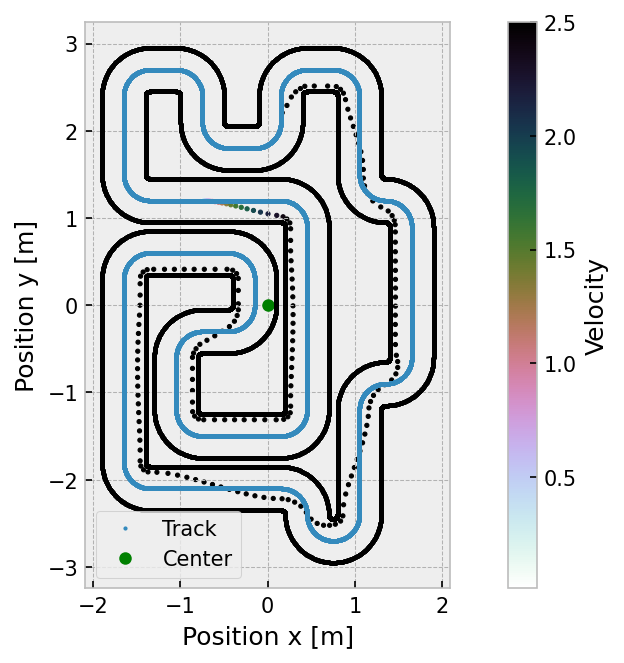

In [76]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

x_plot = np.array(x_list)
y_plot = np.array(y_list)

from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,0,3].detach(), cmap=custom_cmap, s=4)

cbar = plt.colorbar(sct)
cbar.set_label('Velocity') 
#ax.plot(x_plot, y_plot)

#ax.scatter(x_plot[23:25], y_plot[23:25], color='red', s=4)

#ax.scatter(x_plot, y_plot, s=4, color='red')

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

In [54]:
x_simulated.numpy()[:,0,3]

array([0.01      , 0.09      , 0.17      , 0.25      , 0.33      ,
       0.41000003, 0.49000004, 0.57000005, 0.65000004, 0.73      ,
       0.81      , 0.89      , 0.96999997, 1.05      , 1.13      ,
       1.21      , 1.2900001 , 1.3700001 , 1.4500002 , 1.5300002 ,
       1.6100003 , 1.6900003 , 1.7700003 , 1.8500004 , 1.9300004 ,
       2.0100005 , 2.0900004 , 2.1700003 , 2.2500002 , 2.3300002 ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.3746514 , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375  

In [22]:
Q_test_batch.shape

torch.Size([25, 1, 11, 11])